# Preprocess Data


In [1]:
raw.df <- read.csv("final_data_export_consensus.csv")



In [2]:
# install.packages("sjmisc")
# install.packages("tidyverse")
# install.packages("abind")
library(conflicted)  # solve tidyverse package conflicts with conflict_prefer()
library(tidyverse)
conflict_prefer("filter", "dplyr")
conflict_prefer("lag", "dplyr")
library("sjmisc")
library("abind")
# for data manipulation with dplyr see: https://www.youtube.com/watch?v=Gvhkp-Yw65U
# for splitting 2 values in 1 cell see: https://www.youtube.com/watch?v=DiY8EqZDwoI at 3:17 (e.g. if 2 scales for 1 outcome)
# for joining 2 data frames see:        https://www.youtube.com/watch?v=DiY8EqZDwoI at 11:57


In [3]:
raw.df <- raw.df %>%
  filter(Study.design == "Passive RCT")


## Drop unimportant columns by name

### Remove column rages (first columns)

In [4]:
my.df <- raw.df %>%
  select(-Reviewer.Name:-Further.Information.inserted.in.Extraction.Form.)  # "-" indicates deleting these columns


### Remove single column names and repeating names with ascending numbers (table headlines)

In [5]:
cols.pop.char <- c()

for (time.point in 0:4){
  cols.pop.char <- append(cols.pop.char,
                          sprintf("Population.Characteristics..Time.Point.%d..",
                                  time.point
                                  )
                          )
}

cols.outc.t <- c()

for (outc in 1:7){
  for (t in 0:3){
    cols.outc.t <- append(cols.outc.t,
                          sprintf("Outcome.%d..Time.Point.%d..",
                                  outc, t
                                  )
                          )
  }
}

cols.quant.results <- c()

i <- 0
for (int.1 in 1:3){
  i <- i + 1
  if (i == 1){
    for (int.2 in 2:4){
      for (t in 1:3){
        cols.quant.results <- append(cols.quant.results,
                              sprintf("Results.for.Int%d.X.Int%d.of.Time.Point.%d.",
                                      int.1, int.2, t
                                      )
                              )
      }
    }
  } else if (i == 2){
    for (int.2 in 3:4){
      for (t in 1:3){
        cols.quant.results <- append(cols.quant.results,
                              sprintf("Results.for.Int%d.X.Int%d.of.Time.Point.%d.",
                                      int.1, int.2, t
                                      )
                              )
      }
    }
  } else if (i == 3){
    int.2 <- 4
    for (t in 1:3){
      cols.quant.results <- append(cols.quant.results,
                            sprintf("Results.for.Int%d.X.Int%d.of.Time.Point.%d.",
                                    int.1, int.2, t
                                    )
                            )
    }
  } else {
    print("i not = 1, 2, or 3")
  }
}

remove.cols <- c(cols.pop.char[],
                 "Dates.of.Measuring.Time.Points.",
                 "Between.Measuring.Time.Points..Duration.",
                 "Intervention.and.Comparisons.",
                 "Definition.of.Outcomes.",
                 "Measures.of.Outcomes.",
                 cols.outc.t[],
                 cols.quant.results[],
                 "Results.of.Key.Themes."
                 )

my.df <- my.df[, ! names(my.df) %in% remove.cols]


In [6]:
my.df

## Create arrays, data frame lists, and data frames from Covidence tables

### Set basic parameters 

In [7]:
nm.placeholder <- -999  # placeholder for values marked as nm (not mentioned)

study.no <- length(my.df[,"Study.ID"])


### Functions

#### Checking for digits and characters

In [8]:
# function returning TRUE if string contains no characters but digits instead
no.char.but.digit.inside <- function(value){
  !(str_contains(value, letters, logic = "OR") |
  str_contains(value, LETTERS, logic = "OR")) &
  grepl("\\d", value)
}

# function returning TRUE if string contains characters
char.inside <- function(value){
  str_contains(value, letters, logic = "OR") |
  str_contains(value, LETTERS, logic = "OR")
}


#### For mean values

In [9]:
# extracts mean r and mean s values as double
get.all.means <- function(value, study.name = ""){
  if (substr(value, nchar(value) - nchar("mean r") + 1, nchar(value)) == "mean r"){
      # value contains "mean r" at the end
    extracted.value <- as.double(sub(" mean r.*", "", value))
        # extracts anything before " mean r" as double                 
  } else if (substr(value, nchar(value) - nchar("mean s") + 1, nchar(value)) == "mean s"){
    extracted.value <- as.double(sub(" mean s.*", "", value))
  } else if (substr(value, nchar(value) - nchar("mean") + 1, nchar(value)) == "mean"){
    extracted.value <- NA
    print(study.name)
    cat("value ", value, " not added because mean only")
    cat("\n")
  } else {
    extracted.value <- value
  }
  extracted.value
}

# extracts mean s only as double
get.mean.s.only <- function(value){
    if (grepl("mean s", value)){
    extracted.value <- as.double(sub(" mean s.*", "", value))
  } else if (grepl("mean r", value)){
    extracted.value <- NA
    cat("value ", value, " not added because mean r")
    cat("\n")
  } else if (grepl("mean", value)){
    extracted.value <- NA
    cat("value ", value, " not added because mean only")
    cat("\n")
  } else {
    extracted.value <- value
  }
  extracted.value
}


#### Convert value from nm, NA, digit, or char

In [10]:
convert.value <- function(
  value, missing.value.placeholder = nm.placeholder, only.double = TRUE, exclude.greater.than = FALSE, study.name = "insert study name",
  flag.x.s.r = 2
    # x.s.r = exact value (0), mean s (1), or mean r (2)
    # flag.x.s.r = 2 --> include all
    # flag.x.s.r = 1 --> only include mean s and exact values
    # flag.x.s.r = 0 --> include only exact vaules
){
  
  na.value <- FALSE
  if (is.na(value)){
    na.value <- TRUE
  }
  if (na.value == TRUE){
    extracted.value <- NA
  } else {
    value <- as.character(value)

# special cases
    if (value == "nm"){
      extracted.value <- missing.value.placeholder
    } else if (value == ""){
      extracted.value <- NA
    } else if (value == "^"){
      extracted.value <- value 
    } else if (grepl("<", value)){
      extracted.value <- as.double(sub(".*<", "", value))
        # extracts value after "<" as double 
    } else if (grepl(">", value)){
      if (exclude.greater.than == TRUE){
        extracted.value <- NA
      } else if (exclude.greater.than == FALSE){
        extracted.value <- as.double(sub(".*>", "", value))
        # extracts value after ">" as double
      } else {
        print("set 'exclude.greater.than' to 'FALSE' or 'TRUE'")
      }

# no.char.but.digit
    } else if (no.char.but.digit.inside(value)){
      if (grepl(",", value)){
        cat("decimal separator replaced with point in ", value)
        extracted.value <- as.double(sub(",", ".", value))
          # sub(a, b, value) replaces a with b in value
      } else if (grepl("-", value)){
        # like "0 - 40"
        extracted.value <- value
      } else {
        extracted.value <- as.double(value) 
      }

# char
    } else if (char.inside(value)){
      if (flag.x.s.r == 2){
        extracted.value <- get.all.means(value, study.name)
      } else if (flag.x.s.r == 1){
        extracted.value <- get.mean.s.only(value)
      } else if ((flag.x.s.r == 0) & !(grepl("mean r", value) | grepl("mean s", value))){
        extracted.value <- NA
        if (grepl("mean", value)){
          cat("value not added because mean only: ", value)
          cat("\n\n")
        }
      } else {
        if (only.double == TRUE){
          extracted.value <- NA
          cat("unknown case with char inside: ", value)
          cat("\n\n")
        } else {
          extracted.value <- value
        }
      }
    } else {
      cat("unknown case: ", value)
      cat("\n")
    }
  }
  extracted.value
}


#### Check if multiple commas are present in string

In [11]:
multiple.commas.present <- function(input.string){
  multiple.commas.present <- FALSE
  comma.count <- 0

  iterable.string <- tryCatch(
    {
      strsplit(input.string, "")[[1]]
        # strsplit(input.string, "")[[1]] makes string iterable
        # "try" part
    },
    error=function(cond) {
      message(paste("Error of multiple.commas.present() for input:", input.string, "| Type:", class(input.string)))
      message(cond)
      return("")
      # "except" part for errors
    },
    warning=function(cond) {
      message(paste("Warning of multiple.commas.present() for input:", input.string, "| Type:", class(input.string)))
      message(cond)
      return("")
      # "except" part for warnings
    }
  )
    # see following link for exception handling: https://stackoverflow.com/questions/12193779/how-to-write-trycatch-in-r

  for (i in iterable.string){
    if (i == ","){
      comma.count <- comma.count + 1
    }
  }
  if (comma.count > 1){
    multiple.commas.present <- TRUE
  }
  multiple.commas.present
}


#### For arrays

In [12]:
clean.and.shape.data.to.array <- function(
  my.df, start, end, dims, dimname.list, nm.placeholder, study.no, exclude.greater.than = FALSE
){
  my.array <- array(rep(NA),
                    dim = dims,
                    dimnames = dimname.list
                    )
  my.data <- my.df %>%
    select(start:end)
  
  if (length(dims) == 6){
    for (study in 1:study.no){
      my.data.col.no = 1
      for (dim.4.elmnt in 1:dims[4]){
        for (mtrx in 1:dims[3]){
          for (row in 1:dims[1]){
            for (col in 1:dims[2]){
              value <- my.data[study, my.data.col.no]
              my.data.col.no <- my.data.col.no + 1
              if (grepl(",", value)){
                if (!multiple.commas.present(value)){
                  value.before.comma <- sub(",.*", "", value)
                    # extracts anything before "," as double
                  my.array[row, col, mtrx, dim.4.elmnt, 1, study] <- convert.value(
                    value.before.comma, nm.placeholder, exclude.greater.than = exclude.greater.than
                    )
                  value.after.comma <- sub(".*,", "", value)
                    # extracts anything after "," as double
                  my.array[row, col, mtrx, dim.4.elmnt, 2, study] <- convert.value(
                    value.after.comma, nm.placeholder, exclude.greater.than = exclude.greater.than
                    )
                } else {
                    cat(value, "has multiple commas, find solution")
                  }
              } else {
                my.array[row, col, mtrx, dim.4.elmnt, 1, study] <- convert.value(
                  value, nm.placeholder, exclude.greater.than = exclude.greater.than
                  )
              }
            }
          }
        }
      }
    }
  } else if (length(dims) <= 4){
    for (study in 1:study.no){
      my.data.col.no = 1
      for (mtrx in 1:dims[3]){
        for (row in 1:dims[1]){
          for (col in 1:dims[2]){
            value <- my.data[study, my.data.col.no]
            my.data.col.no <- my.data.col.no + 1
            my.array[row, col, mtrx, study] <- convert.value(
              value, nm.placeholder, exclude.greater.than = exclude.greater.than
              )
          }
        }
      }
    }
  } else {
    print("unknwon dimesion")
  }
  my.array
}


#### For data frame lists

In [13]:
# create data frames out of 2D Tables (with rows and cols swapped)
clean.data.to.df.list.swap <- function(
  my.df, start, end, dims, study.names, dimname.list, check.multiple.commas = FALSE, flag.x.s.r = 2
  ){
  study.df <- data.frame(matrix(
    rep(NA),
    nrow = dims[1],
    ncol = dims[2]
  ))
  row.names(study.df) <- dimname.list[[1]]
  colnames(study.df) <- dimname.list[[2]]
  
  # create list of NA data frames of preferred shape
  study.df.list <- list()
  for (i in 1:length(study.names)){
    study.df.list <- append(study.df.list, list(study.df), 0)
  }
  names(study.df.list) <- study.names
  
  my.data <- my.df %>%
    select(start:end)
  
  # vector of my.data.col.no to swapped rows and cols of Covidence output
  my.data.col.no.swapped <- c()
  i <- 0
  j <- 1
  for (k in 1:dims[1]){
    i <- 0
    for (l in 1:dims[2]){
      my.data.col.no.swapped <- append(my.data.col.no.swapped, i * dims[1] + j)
      i <- i + 1
    }
    j <- j + 1 
  }
  # dims[1] = rows new, cols old
  # dims[2] = cols new, rows old
  
  # e.g., filling pattern for old 4 x 7 and new 7 x 4 data frame 
  ## 1, dims[1]+1, 2*dims[1]+1, 3*dims[1]+1, 4*dims[1]+1, 5*dims[1]+1, 6*dims[1]+1,
  ## 2, dims[1]+2, 2*dims[1]+2, 3*dims[1]+2, 4*dims[1]+2, 5*dims[1]+2, 6*dims[1]+2,
  ## x, x, x, x, x, x, x,
  ## x, x, x, x, x, x, x
  
  for (study in 1:study.no){
    m <- 1
    for (row in 1:dims[1]){
      for (col in 1:dims[2]){
        value <- my.data[study, my.data.col.no.swapped[m]]
        m <- m + 1

        if (check.multiple.commas & is.character(value)){
          if (multiple.commas.present(value)){
            cat("multiple commas in value, find solution:\n", value, "\n")
          }
        }
        
        study.df.list[[study]][row, col] <- convert.value(
          value, nm.placeholder, only.double = FALSE, study.name = study.names[study], flag.x.s.r
        )
      }
    }
  }
  study.df.list
}


In [14]:
# create data frames out of 2D Tables
clean.data.to.df.list <- function(
  my.df, start, end, dims, study.names, dimname.list, check.multiple.commas = FALSE, flag.x.s.r = 2
){
  study.df <- data.frame(matrix(
    rep(NA),
    nrow = dims[1],
    ncol = dims[2]
  ))
  row.names(study.df) <- dimname.list[[1]]
  colnames(study.df) <- dimname.list[[2]]
  
  # create list of NA data frames of preferred shape
  study.df.list <- list()
  for (i in 1:length(study.names)){
    study.df.list <- append(study.df.list, list(study.df), 0)
  }
  names(study.df.list) <- study.names
  
  my.data <- my.df %>%
    select(start:end)
  
  for (study in 1:study.no){
    my.data.col.no <- 1
    for (row in 1:dims[1]){
      for (col in 1:dims[2]){
        value <- my.data[study, my.data.col.no]
        my.data.col.no <- my.data.col.no + 1
        
        if (check.multiple.commas & is.character(value)){
          if (multiple.commas.present(value)){
            cat("multiple commas in value, find solution:\n", value, "\n\n")
          }
        }
        tryCatch(
          {
            study.df.list[[study]][row, col] <- convert.value(
              value, nm.placeholder, only.double = FALSE, flag.x.s.r
              )
          },
          error=function(e){
            cat("\n")
            print(study.names[study])
            print(value)
            print(e)
            cat("\n")
          },
          warning=function(w){
            cat("\n")
            print(study.names[study])
            print(value)
            print(w)
            cat("\n")
          }
        )
      }
    }
  }
  study.df.list
}



#### Print array without NA values


In [15]:
print.array.not.na <- function(input.array){
  if (length(dim(input.array)) == 6){
    for (dim.6.element in 1:dim(input.array)[6]){
      cat("\n###### ", dimnames(input.array)[[6]][dim.6.element], " ######")
      for (dim.5.element in 1:dim(input.array)[5]){
        cat("\n### ", dimnames(input.array)[[5]][dim.5.element], " ###")
        for (dim.4.element in 1:dim(input.array)[4]){
          cat("\n#", dimnames(input.array)[[4]][dim.4.element], "\n")
          for (mtrx in 1:dim(input.array)[3]){
            mtrx.is.na <- TRUE
            for (col in 1:dim(input.array)[2]){
              for (row in 1:dim(input.array)[1]){
                if (!is.na(input.array[
                  row, col, mtrx, dim.4.element, dim.5.element, dim.6.element
                                      ]
                          )
                   ){
                     mtrx.is.na <- FALSE
                }
              }
            }
            if (mtrx.is.na == FALSE){
              print(dimnames(input.array)[[3]][mtrx])
              print(input.array[,,mtrx, dim.4.element, dim.5.element, dim.6.element])
              cat("\n")
            }
          } 
        }
      }
    }
  } else if (length(dim(input.array)) == 5){
    for (dim.5.element in 1:dim(input.array)[5]){
      cat("\n### ", dimnames(input.array)[[5]][dim.5.element], " ###")
      for (dim.4.element in 1:dim(input.array)[4]){
        cat("\n#", dimnames(input.array)[[4]][dim.4.element], "\n")
        for (mtrx in 1:dim(input.array)[3]){
          mtrx.is.na <- TRUE
          for (col in 1:dim(input.array)[2]){
            for (row in 1:dim(input.array)[1]){
              if (!is.na(input.array[
                row, col, mtrx, dim.4.element, dim.5.element
                                    ]
                        )
                  ){
                    mtrx.is.na <- FALSE
              }
            }
          }
          if (mtrx.is.na == FALSE){
            print(dimnames(input.array)[[3]][mtrx])
            print(input.array[,,mtrx, dim.4.element, dim.5.element])
            cat("\n")
          }
        } 
      }
    } 
  } else if (length(dim(input.array)) == 4){
    for (dim.4.element in 1:dim(input.array)[4]){
      cat("\n#", dimnames(input.array)[[4]][dim.4.element], "\n")
      for (mtrx in 1:dim(input.array)[3]){
        mtrx.is.na <- TRUE
        for (col in 1:dim(input.array)[2]){
          for (row in 1:dim(input.array)[1]){
            if (!is.na(input.array[
              row, col, mtrx, dim.4.element
                                  ]
                      )
                ){
                  mtrx.is.na <- FALSE
            }
          }
        }
        if (mtrx.is.na == FALSE){
          print(dimnames(input.array)[[3]][mtrx])
          print(input.array[,,mtrx, dim.4.element])
          cat("\n")
        }
      } 
    }
  } else if (length(dim(input.array)) == 3){
    for (mtrx in 1:dim(input.array)[3]){
      mtrx.is.na <- TRUE
      for (col in 1:dim(input.array)[2]){
        for (row in 1:dim(input.array)[1]){
          if (!is.na(input.array[
            row, col, mtrx
                                ]
                    )
              ){
                mtrx.is.na <- FALSE
          }
        }
      }
      if (mtrx.is.na == FALSE){
        print(dimnames(input.array)[[3]][mtrx])
        print(input.array[,,mtrx])
        cat("\n")
      }
    }
  } else {
    print("unknown case")
  }
}


#### Print df list without NA values

In [16]:
# # does not work yet
# print.df.list.not.na <- function(df.list, nm.placeholder){
#   i = 1
#   for (df in df.list){
#     all.na.flag = TRUE
#     for (row in 1:nrow(df)){
#       for (col in 1:ncol(df)){
#         if (
#           !(
#             is.na(df[row, col]) |
#             df[row, col] %in% c("NA", nm.placeholder, as.character(nm.placeholder))
#           )
#         ){
#           all.na.flag = FALSE
#         }
#       }
#     }
#     if (all.na.flag){
#       print(names(df.list)[i])
#       print(df)
#       cat("\n")
#     }
#     i = i + 1
#   }
# }

#### Search in df list

In [17]:
search.df.list <- function(df.list, search.string){
  found <- FALSE
  for (i in 1:length(df.list)){
    for (row in 1:nrow(df.list[[i]])){
      for (col in 1:ncol(df.list[[i]])){
        cell.string <- as.character(df.list[[i]][row,col])
        if (!is.character(search.string)){
          print("search term has to be character")
        }
        if (grepl(search.string, cell.string)){
          cat(
            "search term found in:\ndf:", names(df.list)[i], "\nrow:",
            rownames(df.list[[i]])[row], "\ncol:", colnames(df.list[[i]])[col],
            "\nvalue:", df.list[[i]][row, col], "\n\n"
            )
          found <- TRUE
        }
      }
    }
  }
  if (!found){
    print("serach string not found")
  }
}


### Array

#### Population Characteristics

In [18]:
dims <- c(4, 5, 4, study.no)

dimname.list <- list(c("No.Participants", "Mean.Age", "No.Females", "No.Males"),
                     c("Intervention.1", "Intervention.2", "Intervention.3", "Intervention.4", "Over.All"),
                     c("T0", "T1", "T2", "T3"),
                     my.df[,"Study.ID"]
                     )

start <- "Number.of.Participants.Intervention.1.T0"
end <- "Number.of.Males.Over.All.T3"

population.characteristics.array <- clean.and.shape.data.to.array(
  my.df, start, end, dims, dimname.list, nm.placeholder, study.no
)

my.df <- my.df %>%
  select(-Number.of.Participants.Intervention.1.T0:-Number.of.Males.Over.All.T3)

print.array.not.na(population.characteristics.array)



#### Results Descriptive


In [19]:
dims <- c(4, 3, 4, 7, 2, study.no)

dimname.list <- list(c("Intervention.1", "Intervention.2", "Intervention.3", "Control"),
                     c("Mean", "SD", "n"),
                     c("T0", "T1", "T2", "T3"),
                     c("Outcome.1", "Outcome.2", "Outcome.3", "Outcome.4", "Outcome.5", "Outcome.6", "Outcome.7"),
                     c("Scale.1", "Scale.2"),
                     my.df[,"Study.ID"]
                     )

start <- "Intervention.1.Mean.O1T0"
end <- "Control.or.Intervention.4.n.in.case.of.period.O7T3"

results.descriptive.array <- clean.and.shape.data.to.array(
    my.df, start, end, dims, dimname.list, nm.placeholder, study.no
)

print.array.not.na(results.descriptive.array)

my.df <- my.df %>%
  select(-Intervention.1.Mean.O1T0:-Control.or.Intervention.4.n.in.case.of.period.O7T3)



#### Results Quantitative


In [20]:
dims <- c(7, 3, 3, 6, 2, study.no)

dimname.list <- list(c("Outcome.1", "Outcome.2", "Outcome.3", "Outcome.4", "Outcome.5", "Outcome.6", "Outcome.7"),
                     c("P.Value", "Effect.Size", "Effect.Size.CI"),
                     c("T1", "T2", "T3"),
                     c("Int1.X.Int2", "Int1.X.Int3", "Int1.X.Int4", "Int2.X.Int3", "Int2.X.Int4", "Int3.X.Int4"),
                     c("Scale.1", "Scale.2"),
                     my.df[,"Study.ID"]
                     )

start <- "Outcome.1.P.Value.1x2T1"
end <- "Outcome.7.Confidence.Interval.of.Effect.Size.3x4T3"

results.quantitative.array <- clean.and.shape.data.to.array(
  my.df, start, end, dims, dimname.list, nm.placeholder, study.no,
  exclude.greater.than = TRUE  # <-- sets p.values > 0.05 to NA
)

print.array.not.na(results.quantitative.array)

my.df <- my.df %>%
  select(-Outcome.1.P.Value.1x2T1:-Outcome.7.Confidence.Interval.of.Effect.Size.3x4T3)


### Data frame lists
#### Intervention Comparison


In [21]:
# correct input mistakes
study.names <- my.df[,"Study.ID"]

if ("0.99 mean" == my.df[which(study.names =="Sloan 2016"), "Frequency.of.intervention.sessions.in.times.per.week.Intervention.1"]){
  my.df[which(study.names =="Sloan 2016"), "Frequency.of.intervention.sessions.in.times.per.week.Intervention.1"] <- "0.99 mean s"
}
  # comment: Frequency: "Among the group, 20 participants attended all eight sessions and one attended seven sessions" --> 20   ×   (8   ×   1   +   1   ×   7   ×   1) / 21 / 8 = 0.99

if ("36.67 mean" == my.df[which(study.names =="Weytens 2014"), "Duration.of.single.intervention.sessions.in.minutes.Intervention.2"]){
  my.df[which(study.names =="Weytens 2014"), "Duration.of.single.intervention.sessions.in.minutes.Intervention.2"] <- NA
}
  # comment: "sessions that were twohours long" "group participants were asked to practice 20 minutes of meditation at home, at least five days a week" --> 120 min + 5*20 min / 6 Sessions = 36.67 min average
  # --> meditation frequency was predifined but not measured

if ("3.79 during intervention, 2.04 during follow-up mean" == my.df[which(study.names =="Huberty 2019"), "Frequency.of.intervention.sessions.in.times.per.week.Intervention.1"]){
  my.df[which(study.names =="Huberty 2019"), "Frequency.of.intervention.sessions.in.times.per.week.Intervention.1"] <- "3.79 mean s"
}
  # comment: - frequency: "Participants in the intervention group engaged in an average of 37.9 (SD 30.5) minutes of meditation per week over the course of the 8-week study." "Approximately one-third (14/41, 34%) of intervention participants continued to meditate during the follow-up period (12 weeks from baseline) and spent an average of 20.4 (SD 23.9) minutes meditating." 37.9/10, 20.04/10--> 3.79 and 2.04 times per week
  # --> mistake in calculation only 37.9 min per week during intervention is interesting for meta-regression

if ("4.19 mean" == my.df[which(study.names =="Nolan 2020"), "Frequency.of.intervention.sessions.in.times.per.week.Intervention.1"]){
  my.df[which(study.names =="Nolan 2020"), "Frequency.of.intervention.sessions.in.times.per.week.Intervention.1"] <- "4.19 mean s"
}
  # comment: Frequency (compare tab. 10 & 12): 10   ×   10   +   9   +   2   ×   8   +   3   ×   7   +   6   ×   6   +   2   ×   5   +   5   ×   4   +   3   ×   2   +   2   ×   2 = 222 sessions completed from tab. 10 222   +   10   ×   2   +   2   +   3   ×   1 ( tab. 12) = 247 Mean practiced sessions = 247 / 33 paricipants Mean practiced sessions / total duration (12.5) * 7 week days = 4.19 sessions per week 

if ("12.5 mean" == my.df[which(study.names =="Nolan 2020"), "Total.Duration.of.Intervention.in.Days.Intervention.1"]){
  my.df[which(study.names =="Nolan 2020"), "Total.Duration.of.Intervention.in.Days.Intervention.1"] <- NA
}
  # comment: "10-15-day" --> 12.5 days duration
  # --> higher range than 30% of the higher value (15) --> NA

if ("2.5 mean" == my.df[which(study.names =="Toole 2016"), "Frequency.of.intervention.sessions.in.times.per.week.Intervention.1"]){
  my.df[which(study.names =="Toole 2016"), "Frequency.of.intervention.sessions.in.times.per.week.Intervention.1"] <- "2.5 mean s"
}
  # comment: "The mean number of days participants in the intervention group listened to the podcasts (excluding Visit 1) was 1.5" --> Frequncy = 1 + 1.5 = 2.5

if ("11.19 mean" == my.df[which(study.names =="Schulte-Frankenfeld 2021"), "Duration.of.single.intervention.sessions.in.minutes.Intervention.1"]){
  my.df[which(study.names =="Schulte-Frankenfeld 2021"), "Duration.of.single.intervention.sessions.in.minutes.Intervention.1"] <- "11.19 mean s"
}
  # comment: mean duration of single session: total minutes of all programs (638) / total number of all sessions (57) = 11.19 see: https://iaap-journals.onlinelibrary.wiley.com/action/downloadSupplement?doi=10.1111%2Faphw.12328&file=aphw12328-sup-0001-App-Based+Mindfulness+-+Supplements.docx

if ("2.82 mean" == my.df[which(study.names =="Schulte-Frankenfeld 2021"), "Frequency.of.intervention.sessions.in.times.per.week.Intervention.1"]){
  my.df[which(study.names =="Schulte-Frankenfeld 2021"), "Frequency.of.intervention.sessions.in.times.per.week.Intervention.1"] <- "2.82 mean s"
}
  # comment: Mean Frequency: mean of "sessions" column at https://osf.io/wujsg/ (22.53) / 8 weeks = 2.82

In [22]:
dims <- c(4, 7)

study.names <- my.df[,"Study.ID"]

dimname.list <- list(c("Intervention.1", "Intervention.2", "Intervention.3", "Control"),
                     c("Name", "Short.Description", "Delivery.Mode", "Meditation.App", "Sessions.Duration.in.minutes",
                       "Frequency.in.times.per.week", "Total.Duration.in.Days")
                     )
start <- "Name.Intervention.1"
end <- "Total.Duration.of.Intervention.in.Days.Control.or.Intervention.4"

intervention.comparisons.df.list <- clean.data.to.df.list.swap(
 my.df, start, end, dims, study.names, dimname.list
)

intervention.comparisons.df.list.w.o.mean.r <- clean.data.to.df.list.swap(
 my.df, start, end, dims, study.names, dimname.list, flag.x.s.r = 1
)

my.df <- my.df %>%
  select(-Name.Intervention.1:-Total.Duration.of.Intervention.in.Days.Control.or.Intervention.4)

intervention.comparisons.df.list



#### Measure of Outcomes


In [23]:
dims <- c(7, 3)

study.names <- my.df[,"Study.ID"]

dimname.list <- list(c("Outcome.1", "Outcome.2", "Outcome.3", "Outcome.4", "Outcome.5", "Outcome.6", "Outcome.7"),
                     c("Measures.Name", "Start.and.End.Point", "High.or.low.means.resilient")
                     )
start <- "Outcome.1.Scale.s.or.other.Measure.s.Name"
end <- "Outcome.7.High.or.low.means.resilient"

outcome.measures.df.list <- clean.data.to.df.list(
 my.df, start, end, dims, study.names, dimname.list, check.multiple.commas = TRUE
)

my.df <- my.df %>%
  select(-Outcome.1.Scale.s.or.other.Measure.s.Name:-Outcome.7.High.or.low.means.resilient)

outcome.measures.df.list


In [24]:
# correct vaulue
outcome.measures.df.list[["Warnecke 2011"]]["Outcome.1","Start.and.End.Point"] <- "0 - 40, 0 - 42"

In [25]:
outcome.measures.df.list[["Warnecke 2011"]]


#### Qualitative Results of Data Analyses


In [26]:
dims <- c(7, 3)

study.names <- my.df[,"Study.ID"]

dimname.list <- list(c("Key.Theme.1", "Key.Theme.2", "Key.Theme.3", "Key.Theme.4", "Key.Theme.5", "Key.Theme.6", "Key.Theme.7"),
                     c("Name.of.Key.Theme", "Description.of.Key.Theme", "Results")
                     )
start <- "Key.Theme.1.Name.of.Key.Theme"
end <- "Key.Theme.7.Results"

results.qualitative.df.list <- clean.data.to.df.list(
 my.df, start, end, dims, study.names, dimname.list
)

my.df <- my.df %>%
  select(-Key.Theme.1.Name.of.Key.Theme:-Key.Theme.7.Results)

results.qualitative.df.list


### Data frames
#### Dates of Measuring Time Points


In [27]:
dates.measuring.time.points.df <- my.df[
  , which(colnames(my.df)=="Time.Point.0.Date"):which(colnames(my.df)=="Time.Point.3.Date")
]

for (row in 1:nrow(dates.measuring.time.points.df)){
  for (col in 1:ncol(dates.measuring.time.points.df)){
    dates.measuring.time.points.df[row, col] <- convert.value(dates.measuring.time.points.df[row, col])
  }
}

rownames(dates.measuring.time.points.df) <- study.names

my.df <- my.df %>%
  select(-Time.Point.0.Date:-Time.Point.3.Date)


dates.measuring.time.points.df



#### Between-Measuring Time Points Duration


In [28]:
# correct input mistakes
if ("7 mean" == my.df[which(study.names == "Toole 2016"), "Time.Point.0...1.Duration.in.Days"]){
  my.df[which(study.names == "Toole 2016"), "Time.Point.0...1.Duration.in.Days"] <- "7 mean s"
}
  # quote: "Participants attended two lab visits approximately 1 week apart"

In [29]:
between.T.duration.df <- my.df[
  , which(colnames(my.df)=="Time.Point.0...1.Duration.in.Days"):which(colnames(my.df)=="Time.Point.0...3.Duration.in.Days")
]

for (row in 1:nrow(between.T.duration.df)){
  for (col in 1:ncol(between.T.duration.df)){
    between.T.duration.df[row, col] <- convert.value(between.T.duration.df[row, col], study.name = study.names[row])
  }
}

rownames(between.T.duration.df) <- study.names

my.df <- my.df %>%
  select(-Time.Point.0...1.Duration.in.Days:-Time.Point.0...3.Duration.in.Days)

between.T.duration.df



#### Definition of Outcomes


In [30]:
outcome.definitions.df <- my.df[
  , which(colnames(my.df)=="Outcome.1.Definition"):which(colnames(my.df)=="Outcome.7.Definition")
]

for (row in 1:nrow(outcome.definitions.df)){
  for (col in 1:ncol(outcome.definitions.df)){
    outcome.definitions.df[row, col] <- convert.value(outcome.definitions.df[row, col])
  }
}

rownames(outcome.definitions.df) <- study.names

my.df <- my.df %>%
  select(-Outcome.1.Definition:-Outcome.7.Definition)

outcome.definitions.df



#### Outcome Names


In [31]:
outcome.names.df <- my.df[, which(colnames(my.df)=="Name.of.Outcome.1"):which(colnames(my.df)=="Name.of.Outcome.7")]

for (row in 1:nrow(outcome.names.df)){
  for (col in 1:ncol(outcome.names.df)){
    outcome.names.df[row, col] <- convert.value(outcome.names.df[row, col])
  }
}

my.df <- my.df %>%
  select(-Name.of.Outcome.1:-Name.of.Outcome.7)

rownames(outcome.names.df) <- study.names

outcome.names.df[
  "Siembor 2018",
  which(outcome.names.df["Siembor 2018",] == "Coping flexibility")
] <- "Active Coping"  # correct input mistake

outcome.names.df



#### Meditation Techniques


In [32]:
meditation.techniques.df <- my.df[
  , which(colnames(my.df)=="Practiced.Techniques.in.Intervention.1"):which(colnames(my.df)=="Practiced.Techniques.in.Control.or.Intervention.4")
]

for (row in 1:nrow(meditation.techniques.df)){
  for (col in 1:ncol(meditation.techniques.df)){
    meditation.techniques.df[row, col] <- convert.value(meditation.techniques.df[row, col])
  }
}

rownames(meditation.techniques.df) <- study.names

my.df <- my.df %>%
  select(-Practiced.Techniques.in.Intervention.1:-Practiced.Techniques.in.Control.or.Intervention.4)

meditation.techniques.df


#### RoB Data

In [33]:
raw.rob.df <- read.csv("final_data_export_consensus_RoB.csv")
rownames(raw.rob.df) <- raw.rob.df[,"Study.ID"]
rob.df <- raw.rob.df[,
  c(
    2,which(names(raw.rob.df) == "Domain1..Risk.of.bias.arising.from.the.randomization.process"):
    which(names(raw.rob.df) == "Overall.risk.of.bias.supporting.text")
  )
]
rob.df <- rob.df[,-c(3:5, 7, 9, 11, 13, 15)]  # cut out Domain S for crossover designs and the additional comments
rob.df <- rob.df[order(rob.df$Study.ID), ]  # sort alphabetically 
rob.df[,1] <- 1:nrow(rob.df)
rob.df

In [34]:
studies.high.rob <- rownames(rob.df[rob.df$Overall.risk.of.bias == "High risk of bias",])
studies.high.rob


#### Left 1 D Data


In [35]:
my.df[my.df == 'None' | my.df == '' | is.na(my.df)] <- "NA"

one.D.info.df <- my.df

rownames(one.D.info.df) <- study.names

one.D.info.df


### Follow-up periods

#### Calculate follow-up periods

In [36]:
# correct input mistake
one.D.info.df["Sloan 2016","Numer.of.Measuring.Time.Points"] <- 2

In [37]:
# get studies with more than 2 measuring time points
studies.t3..4 <- c()
i <- 1
for (t.no in one.D.info.df[,"Numer.of.Measuring.Time.Points"]){
  if (
    is.na(t.no) |
    t.no %in% c("NA", nm.placeholder, as.character(nm.placeholder))
  ){
    t.no <- 0
  }
  if (as.double(t.no) > 2){
    studies.t3..4 <- append(studies.t3..4, study.names[i])
  }
  i <- i + 1
}
studies.t3..4

In [38]:
# data relevant for calculation of follow up period:
# "dates.measuring.time.points.df", <-- no important information
# "between.T.duration.df",
# one.D.info.df[,"Dates.of.Measuring.Time.Points.mentioned."],
# one.D.info.df[,"Between.Measuring.Time.Points..Duration.mentioned."]

follow.up.period.df <- data.frame(
  period.t1.t2 <- c(rep(NA, study.no)),
  period.t1.t3 <- c(rep(NA, study.no))
)
colnames(follow.up.period.df) <- c("period.t1.t2", "period.t1.t3")
rownames(follow.up.period.df) <- study.names

for (study.name in study.names){
  # period.t1.t2
  if (
    !(
      is.na(between.T.duration.df[study.name, 'Time.Point.0...1.Duration.in.Days']) |
      is.na(between.T.duration.df[study.name, 'Time.Point.0...1.Duration.in.Days']) %in%
      c("NA", nm.placeholder, as.character(nm.placeholder))
    ) &
    !(
      is.na(between.T.duration.df[study.name, 'Time.Point.0...2.Duration.in.Days']) |
      is.na(between.T.duration.df[study.name, 'Time.Point.0...2.Duration.in.Days']) %in%
      c("NA", nm.placeholder, as.character(nm.placeholder))
    )
  ){
    follow.up.period.df[study.name, "period.t1.t2"] <-
    as.double(between.T.duration.df[study.name, 'Time.Point.0...2.Duration.in.Days']) -
    as.double(between.T.duration.df[study.name, 'Time.Point.0...1.Duration.in.Days'])
  }
  
  # period.t1.t3
  if (
    !(
      is.na(between.T.duration.df[study.name, 'Time.Point.0...2.Duration.in.Days']) |
      is.na(between.T.duration.df[study.name, 'Time.Point.0...2.Duration.in.Days']) %in%
      c("NA", nm.placeholder, as.character(nm.placeholder))
    ) &
    !(
      is.na(between.T.duration.df[study.name, 'Time.Point.0...3.Duration.in.Days']) |
      is.na(between.T.duration.df[study.name, 'Time.Point.0...3.Duration.in.Days']) %in%
      c("NA", nm.placeholder, as.character(nm.placeholder))
    )
  ){
    follow.up.period.df[study.name, "period.t1.t3"] <-
    as.double(between.T.duration.df[study.name, 'Time.Point.0...3.Duration.in.Days']) -
    as.double(between.T.duration.df[study.name, 'Time.Point.0...1.Duration.in.Days'])
  }
}

follow.up.period.df
# keep in mind that t1 is post-test and t2 is first follow-up

#### Append follow-up periods to intervention.comparison.df.list

In [39]:
# it is easier to have this information in this df list for later meta-regression

In [40]:
# for intervention.comparisons.df.list
for (study in 1:study.no){
  intervention.comparisons.df.list[[study]][
    !(
      is.na(intervention.comparisons.df.list[[study]][,"Name"]) |
      intervention.comparisons.df.list[[study]][,"Name"] %in% c("NA", nm.placeholder, as.character(nm.placeholder))
    ),
    "period.t1.t2"
  ] <- follow.up.period.df[study,"period.t1.t2"]
  
  intervention.comparisons.df.list[[study]][
    !(
      is.na(intervention.comparisons.df.list[[study]][,"Name"]) |
      intervention.comparisons.df.list[[study]][,"Name"] %in% c("NA", nm.placeholder, as.character(nm.placeholder))
    ),
    "period.t1.t3"
  ] <- follow.up.period.df[study,"period.t1.t3"]
}
intervention.comparisons.df.list

In [41]:
# for intervention.comparisons.df.list.w.o.mean.r
for (study in 1:study.no){
  intervention.comparisons.df.list.w.o.mean.r[[study]][
    !(
      is.na(intervention.comparisons.df.list.w.o.mean.r[[study]][,"Name"]) |
      intervention.comparisons.df.list.w.o.mean.r[[study]][,"Name"] %in% c("NA", nm.placeholder, as.character(nm.placeholder))
    ),
    "period.t1.t2"
  ] <- follow.up.period.df[study,"period.t1.t2"]
  
  intervention.comparisons.df.list.w.o.mean.r[[study]][
    !(
      is.na(intervention.comparisons.df.list.w.o.mean.r[[study]][,"Name"]) |
      intervention.comparisons.df.list.w.o.mean.r[[study]][,"Name"] %in% c("NA", nm.placeholder, as.character(nm.placeholder))
    ),
    "period.t1.t3"
  ] <- follow.up.period.df[study,"period.t1.t3"]
}
intervention.comparisons.df.list.w.o.mean.r

## Set unique names or variables for scale, delivery modes, and meditation type 
### Meditation types


In [42]:
# get all unique meditation types
meditation.types <- c()

for (intervention in 1:ncol(meditation.techniques.df)) {
  for (study in 1:nrow(meditation.techniques.df)){
    if (
      !(
        meditation.techniques.df[study, intervention] == "NA" |
        is.na(meditation.techniques.df[study, intervention]) |
        meditation.techniques.df[study, intervention] == nm.placeholder |
        meditation.techniques.df[study, intervention] == "None" |
        meditation.techniques.df[study, intervention] == "No Intervention" |
        meditation.techniques.df[study, intervention] == "Wait-List Control"
      )
    ){
      meditation.types <- append(meditation.types, meditation.techniques.df[study, intervention])
    }
  }
}

unique.meditation.types <- unique(meditation.types)
for (meditation.type in unique.meditation.types){
  print(meditation.type)
}


In [43]:
# categorize meditation types
meditation.type.attentional <- c(
  "Breathing Exercise (no further Info)",
  "Transcendental Meditation (TM)",
  "Body Scan; Breathing Exercise (no further Info)",
  "Breathing Exercise (no further Info); Only \"Mindfulness Meditation\" named",
  "Only \"Mindfulness Meditation\" named",
  "Mantra Meditation",
  "Body Scan",
  "Breathing Exercise (no further Info); Other: mindfulness toward sensations and experiences of the body, mindfulness toward the contents of the mind, skill of mental noting to label their mental contents, cultivating awareness and understanding of emotions as mental contents and the nonjudgmental stance toward emotions with a goal of optimizing the response to one’s emotions",
  "Other: silent meditations with bells, personalized meditations with or without guided\nintro and bells",
  "Zen Meditation",
  "Breathing Exercise (no further Info); Other: \"awareness to any sensations in their body or in their immediate environment\", focus on \"thoughts and feelings\",  \"non-judgmental observation\"",
  "Shavasana",
  "Mantra Meditation; Only \"Focused Attention Meditation\" named; Other: Readings reflecting meditative perspective",
  "Breathing Exercise (no further Info); Open Monitoring Meditation",
  "Body Scan; Other: \"become aware of their sensations, including sights, sounds and somatic sensations\", relaxing body areas, observe their physical sensations thoughts and emotions without reaction or judgment,",
  'Body Scan; Only "Mindfulness Meditation" named'
)

meditation.type.constructive <- c(
  "Loving-Kindness Meditation"
)

meditation.type.deconstructive <- c(
  "Vipassana", "Other: devotional readings to ponder, meditations taken from a widely used devotional book designed for Christian readers titled"
  # no forgivingness compared to other intervention in Vasiliauskas 2013
)

meditation.type.attentional.and.constructive <- c(
  "Body Scan; Breathing Exercise (no further Info); Loving-Kindness Meditation"
)

meditation.type.attentional.and.deconstructive <- c(
  "Prayer; Other: devotional readings to ponder, meditations taken from a widely used devotional book designed for Christian readers titled, forgiveness meditations",
    # due to "forgiveness" --> strengthens cognitive and affective patterns (constructive), "reading to ponder" --> deconstructive
  "Breathing Exercise (no further Info); Other: mindfulness toward sensations and experiences of the body, mindfulness toward the contents of the mind, skill of mental noting to label their mental contents, cultivating awareness and understanding of emotions as mental contents and the nonjudgmental stance toward emotions with a goal of optimizing the response to oneâ€™s emotions"
)

meditation.type.attentional.constructive.and.deconstructive <- c(
  "Other: mindfulness-based exercises through audio video or text files, grounding visualization, gratitude, imagining the life you want, finding meaning",
  "Breathing Exercise (no further Info); Other: focusing on meta-awareness, \"Mindfulness-based exercises [...] about happiness in life as the result of a benevolent attitude towards life and a positive relationship to oneself and others\", \"Methods of introspection, reflection and self-care\""
)


meditation.type.all <- c(
  meditation.type.attentional,
  meditation.type.constructive,
  meditation.type.attentional.and.constructive,
  meditation.type.attentional.and.deconstructive,
  meditation.type.attentional.constructive.and.deconstructive,
  meditation.type.deconstructive
)

meditation.type.all.list <- list(
  meditation.type.attentional = meditation.type.attentional,
  meditation.type.constructive = meditation.type.constructive,
  meditation.type.attentional.and.constructive = meditation.type.attentional.and.constructive,
  meditation.type.attentional.and.deconstructive = meditation.type.attentional.and.deconstructive,
  meditation.type.attentional.constructive.and.deconstructive = meditation.type.attentional.constructive.and.deconstructive,
  meditation.type.deconstructive = meditation.type.deconstructive
)

#### Insert Meditation Techniques in df

In [44]:
meditation.techniques.df

In [45]:
# Clustering (all techniques) for intervention.comparisons.df.list
for (study in 1:study.no){
  for (intervention in 1:ncol(meditation.techniques.df)){
    value <- meditation.techniques.df[study, intervention]
    if (!(
      is.na(value) |
      value %in% c(
        "NA", nm.placeholder, as.character(nm.placeholder),
        "Wait-List Control", "None", "No Intervention"
      )
    )){
      if (value %in% meditation.type.attentional){
        intervention.comparisons.df.list[[study]][intervention, "Meditation.Type"] <- "attentional family"
      } else if (value %in% meditation.type.constructive){
        intervention.comparisons.df.list[[study]][intervention, "Meditation.Type"] <- "constructive family"
      } else if (value %in% meditation.type.deconstructive){
        intervention.comparisons.df.list[[study]][intervention, "Meditation.Type"] <- "deconstructive family"
      } else if (
        value %in% c(
          meditation.type.attentional.and.constructive,
          meditation.type.attentional.and.deconstructive,
          meditation.type.attentional.constructive.and.deconstructive
        )
      ){
        intervention.comparisons.df.list[[study]][intervention, "Meditation.Type"] <- "hybrid form"
      } else {
        cat(
          "unknown meditation technique:", "\n",
          value, "\n\n"
        )
      }
    }
  }
}

In [46]:
# Clustering (all techniques) for intervention.comparisons.df.list.w.o.mean.r
for (study in 1:study.no){
  for (intervention in 1:ncol(meditation.techniques.df)){
    value <- meditation.techniques.df[study, intervention]
    if (!(
      is.na(value) |
      value %in% c(
        "NA", nm.placeholder, as.character(nm.placeholder),
        "Wait-List Control", "None", "No Intervention"
      )
    )){
      if (value %in% meditation.type.attentional){
        intervention.comparisons.df.list.w.o.mean.r[[study]][intervention, "Meditation.Type"] <- "attentional Family"
      } else if (value %in% meditation.type.constructive){
        intervention.comparisons.df.list.w.o.mean.r[[study]][intervention, "Meditation.Type"] <- "constructive Family"
      } else if (value %in% meditation.type.deconstructive){
        intervention.comparisons.df.list.w.o.mean.r[[study]][intervention, "Meditation.Type"] <- "deconstructive Family"
      } else if (
        value %in% c(
          meditation.type.attentional.and.constructive,
          meditation.type.attentional.and.deconstructive,
          meditation.type.attentional.constructive.and.deconstructive
        )
      ){
        intervention.comparisons.df.list.w.o.mean.r[[study]][intervention, "Meditation.Type"] <- "hybrid form"
      } else {
        cat(
          "unknown meditation technique:", "\n",
          value, "\n\n"
        )
      }
    }
  }
}


### Scales


In [47]:
# find out all unique scale cell entries
# measures <- c()
# 
# for (outcome.measures.df in outcome.measures.df.list) {
#   for (outcome.measure in outcome.measures.df[,"Measures.Name"]){
#     if (!(is.na(outcome.measure) | outcome.measure == "NA" | outcome.measure == nm.placeholder)){
#       # if (multiple.commas.present(outcome.measure)){
#       #   cat("multiple commas in: ", outcome.measure, "\n")
#       # }
#       measures <- append(measures, outcome.measure)
#     }
#   }
# }
# 
# unique.measures <- unique(measures)
# 
# i <- 1
# for (j in unique.measures){
#   print(i)
#   print(j)
#   cat("\n")
#   i <- i + 1
# }



#### Resilience


In [48]:
scale.CD.RISC.10.synonyms <- c(
  "Connor-Davidson Resilience Scale (CD-RISC-10) (Connor & Davidson, 2003)"
)


#### Mental health-related
##### Including Subscales


In [49]:
scale.DASS.synonyms <- c(
  "Depression, Anxiety\nand Stress Scale (DASS) 26",
  "Depression Anxiety and Stress Scale (DASS) - Depression Subcale",
  "Depression Anxiety and Stress Scale (DASS) - Anxiety Subcale",
  "Depression Anxiety and Stress Scale [32] - depression subcale",
  "Depression Anxiety and Stress Scale [32] - anxiety subcale",
  "Depression Anxiety and Stress Scale [32] - stress subcale",
  "Depression, Anxiety, and Stress Scale – 21 (DASS-21)",
  "Depression Anxiety and Stress Scale (DASS)",
  "Depression, Anxiety, and Stress Scale – 21 (DASS-21), subscale depression",
  "Depression, Anxiety, and Stress Scale â€“ 21 (DASS-21), subscale depression",
  "Depression, Anxiety, and Stress Scale – 21 (DASS-21), subscale anxiety",
  "Depression, Anxiety, and Stress Scale â€“ 21 (DASS-21), subscale anxiety",
  "Depression, Anxiety, and Stress Scale â€“ 21 (DASS-21),subscale stress"
)

scale.POMS.synonyms <- c(
  "Profile of Mood States total mood disturbance main scale 23",
  "Profile of Mood States anxiety subscale",
  "Profile of Mood States depression subscale",
  "Profile of Mood States (POMS)"
)



##### 2 Scales per Cell


In [50]:
scales.DASS.PSS.synonyms <- c(
  "Depression, Anxiety\nand Stress Scale (DASS) 26, Perceived Stress Scale\n(PSS)27,28",
  "Depression, Anxiety, and Stress Scale – 21 (DASS-21),\nPerceived Stress Scale (PSS)",
  "Depression, Anxiety, and Stress Scale – 21 (DASS-21),subscale stress\nPerceived Stress Scale (PSS)",
  "Depression, Anxiety, and Stress Scale â€“ 21 (DASS-21),subscale stress\nPerceived Stress Scale (PSS)"
)

scales.PSS.DASS.synonyms <- c(
  "Perceived Stress Scale (PSS), Depression Anxiety and Stress Scale (DASS) - Stress Subcale"
)



##### Anxiety


In [51]:
scale.SAS.synonyms <- c(
  "Self-Rating Anxiety Scale (SAS) (Zung, 1971)"
)

scale.STAI.synonyms <- c(
  "State Anxiety Scale from the State–Trait Anxiety Inventory (Spielberger, Gorsuch, Lushene, Vagg, & Jacobs, 1983)",
  "State Anxiety Scale from the Stateâ€“Trait Anxiety Inventory (Spielberger, Gorsuch, Lushene, Vagg, & Jacobs, 1983)",
  "State-Trait Anxiety Inventory (STAI)",
  "State-Trait Anxiety Inventory (S-TAI) - state (SAI)",
  "state-trait anxiety inventory (STAI) -  state anxiety",
  "State-Trait Anxiety Inventory (STAI) - state subscale",
  "State-Trait Anxiety Inventory (STAI) - trait subscale"
)



##### Depression


In [52]:
scale.BDI.synonyms <- c(
  "Beck Depression Inventory (BDI [72])",
  "Beck Depression Inventory (BDI)"
)

scale.PHQ.9.synonyms <- c(
  "Patient Health Questionnaire-9 (PHQ-9; Kroenke & Spitzer, 2002)",
  "Patient Health Questionnaire-9 (PHQ-9)",
  " Patient Health Questionnaire-9 (PHQ-9)"
)

scale.QIDS.SR.synonyms <- c(
  "Quick Inventory of Depressive Symptomatology Self-Report (QIDS-SR)"
)

scale.SDS.synonyms <- c(
  "Self-Rating Depression Scale (SDS) (Zung et al., 1965)"
)



##### Stress


In [53]:
scale.PSS.synonyms <- c(
  "Perceived Stress Scale (PSS; Cohen, Kamarck, & Mermelstein, 1983)",
  "The Perceived Stress Scale (PSS)",
  "Perceived Stress Scale (PSS).16",
  "Perceived Stress Scale (PSS-10; Cohen, Kamarck, & Mermelstein, 1983)",
  "Perceived Stress Scale (PSS)",
  "Perceived Stress Scale (PSS) (Cohen et al., 1983)",
  "Perceived Stress Scale (PSS) [58,59]",
  "The Perceived Stress Scale (PSS; Cohen, Kamark, & Mermelstein, 1983)",
  "Perceived Stress Scale (PSS; Cohen et al., 1994)",
  "Perceived Stress Scale (PSS-10) (Cohen, 2017)",
  "erceived Stress Scale (PSS [74])"
)

scale.BRS.synonyms <- c(
  " Behavioral Relaxation Scale"
)



##### Well-Being


In [54]:
scale.CPIwb.synonyms <- c(
  "California Psychological Inventroy (CPI), subscale sense of well-being"
)

scale.LSS.synonyms <- c(
  "Questionnaire for the Assessment of Happiness ( ger.: Lebensglückskala, LSS) (Ciccarello & Reinhard, 2014)",
  "Questionnaire for the Assessment of Happiness ( ger.: LebensglÃ¼ckskala, LSS) (Ciccarello & Reinhard, 2014)"
)

scale.RAND.synonyms <- c(
  "RAND 36-Item Health Survey, concept emotional wellbeing"
)

scale.SWLS.synonyms <- c(
  "Satisfaction with Life Scale (SWLS [71])",
  "Satisfaction with Life Scale (SWLS)",
  "satisfaction with life scale (SWLS; Diener et al., 1985)"
)

scale.WHO.QOL.BREF.synonyms <- c(
  "World Health Organization Quality of Life-Brief (WHO-QOL-BREF)"
)


#### Resilience Factors
##### Active Coping


In [55]:
scale.COPE.synonyms <- c(
  "Coping Style (Brief COPE) (Brief COPE; Carver, 1997)"
)



##### Coping, positive


In [56]:
scale.not.common.positive.coping.synonyms <- c(
  "scales adapted from a\nwell-known set of brief measures developed by the Fetzer Institute (1999, pp. 86–87) - positve coping subscale",
  "scales adapted from a\nwell-known set of brief measures developed by the Fetzer Institute (1999, pp. 86â€“87) - positve coping subscale"
)



##### Empathy


In [57]:
scale.BEA.synonyms <- c(
  "Batson Empathy Adjectives (BEA; Batson, 1986; Coke, Batson, & McDavis, 1978)"
)



##### Mindfulness


In [58]:
scale.CAMS.R.synonyms <- c(
  "Cognitive and Affective Mindfulness Scale-Revised (CAMS-R)",
  "Cognitive and Affective Mindfulness Scale-Revised (CAMS-R) - acceptace subscale",
  "Cognitive and Affective Mindfulness Scale–Revised (CAMS-R; Feldman, Hayes, Kumar, Greeson, & Laurenceau, 2007)",
  "Cognitive and Affective Mindfulness Scaleâ€“Revised (CAMS-R; Feldman, Hayes, Kumar, Greeson, & Laurenceau, 2007)",
  "Cognitive and Affective Mindfulness Scale – Revised (CAMS-R)",
  "Cognitive and Affective Mindfulness Scale â€“ Revised (CAMS-R)",
  "Cognitive and Affective Mindfulness\nScale-Revised (CAMS-R; Feldman et al., 2007)"
)

scale.FFMQ.synonyms <- c(
  "Five Factor Mindfulness Questionnaire (FFMQ) [60].",  # mistake in paper --> Factor = Facet
  "Five Facet Mindfulness Questionnaire (FFMQ; Baer, Smith, Hopkins, Krietemeyer, & Toney, 2006)"
)

scale.FMI.14.synonyms <- c(
  "Freiburg Mindfulness Inventory (FMI-14) (Buchheld & Walach, 2002)"
)

scale.KIMS.synonyms <- c(
  "Kentucky Inventory of Mindfulness Skills (KIMS; Baer et al., 2004)"
)

scale.MAAS.synonyms <- c(
  "Mindfulness Attention Awareness Scale (MAAS) (Brown and Ryan (2003)",
  "Mindfulness Attention Awareness Scale (MAAS) (Brown & Ryan, 2003)",
  "mindful attention awareness scale (MAAS; Brown and Ryan, 2003)"
)

scale.TMS.synonyms <- c(
  "The Toronto Mindfulness Scale (TMS)"
)



##### Positve Emotion


In [59]:
scale.SHS.synonyms <- c(
  "Subjective Happiness Scale (SHS)"
)



##### Psychological Capital


In [60]:
scale.PCQ.synonyms <- c(
  "Psychological Capital\nQuestionnaire (PCQ) 19"
)



##### Self-acceptance


In [61]:
scale.CPIsa.synonyms <- c(
  "California Psychological Inventory French version (CPI) (Gough 1957) - Subscale Self-acceptance (Sa)",
  "California Psychological Inventory French version (CPI)"
)



##### Self-compassion


In [62]:
scale.SCS.synonyms <- c(
  "Self-Compassion Scale (SCS; Neff, 2003a)"
)

scale.SCS.SF.synonyms <- c(
  "Self-Compassion Survey Short-Form (SCS-SF)"
)



##### Self-esteem


In [63]:
scale.RSES.synonyms <- c(
  "Rosenberg Self-Esteem Scale (RSES; Rosenberg, 1965)"
)



#### Set unique scale names


In [64]:
for (study in 1:study.no) {
  for (outcome in 1:7){
    outcome.measure <- outcome.measures.df.list[[study]][outcome,"Measures.Name"]
    if (
      !(is.na(outcome.measure) |
        outcome.measure == "NA" |
        outcome.measure == nm.placeholder |
        outcome.measure == as.character(nm.placeholder)
      )
    ){
# Resilience
      if (outcome.measure %in% scale.CD.RISC.10.synonyms){
        outcome.measures.df.list[[study]][outcome,"Measures.Name"] <- "CD-RISC-10"
# Mental health-related
  ## Including Subscales
      } else if (outcome.measure %in% scale.DASS.synonyms){
        outcome.measures.df.list[[study]][outcome,"Measures.Name"] <- "DASS"
      } else if (outcome.measure %in% scale.POMS.synonyms){
        outcome.measures.df.list[[study]][outcome,"Measures.Name"] <- "POMS"
  ## 2 Scales per cell
      } else if (outcome.measure %in% scales.DASS.PSS.synonyms){
        outcome.measures.df.list[[study]][outcome,"Measures.Name"] <- "DASS, PSS"
      } else if (outcome.measure %in% scales.PSS.DASS.synonyms){
        outcome.measures.df.list[[study]][outcome,"Measures.Name"] <- "PSS, DASS"
  ## Anxiety
      } else if (outcome.measure %in% scale.SAS.synonyms){
        outcome.measures.df.list[[study]][outcome,"Measures.Name"] <- "SAS"
      } else if (outcome.measure %in% scale.STAI.synonyms){
        outcome.measures.df.list[[study]][outcome,"Measures.Name"] <- "STAI"
  ## Depression
      } else if (outcome.measure %in% scale.BDI.synonyms){
        outcome.measures.df.list[[study]][outcome,"Measures.Name"] <- "BDI"
      } else if (outcome.measure %in% scale.PHQ.9.synonyms){
        outcome.measures.df.list[[study]][outcome,"Measures.Name"] <- "PHQ-9"
      } else if (outcome.measure %in% scale.QIDS.SR.synonyms){
        outcome.measures.df.list[[study]][outcome,"Measures.Name"] <- "QIDS-SR"
      } else if (outcome.measure %in% scale.SDS.synonyms){
        outcome.measures.df.list[[study]][outcome,"Measures.Name"] <- "SDS"
  ## Stress
      } else if (outcome.measure %in% scale.PSS.synonyms){
        outcome.measures.df.list[[study]][outcome,"Measures.Name"] <- "PSS"
      } else if (outcome.measure %in% scale.BRS.synonyms){
        outcome.measures.df.list[[study]][outcome,"Measures.Name"] <- "BRS"
  ## Quality of Life
      } else if (outcome.measure %in% scale.CPIwb.synonyms){
        outcome.measures.df.list[[study]][outcome,"Measures.Name"] <- "CPI"
      } else if (outcome.measure %in% scale.LSS.synonyms){
        outcome.measures.df.list[[study]][outcome,"Measures.Name"] <- "LSS"
      } else if (outcome.measure %in% scale.RAND.synonyms){
        outcome.measures.df.list[[study]][outcome,"Measures.Name"] <- "RAND 36-Item Health Survey"
      } else if (outcome.measure %in% scale.SWLS.synonyms){
        outcome.measures.df.list[[study]][outcome,"Measures.Name"] <- "SWLS"
      } else if (outcome.measure %in% scale.WHO.QOL.BREF.synonyms){
        outcome.measures.df.list[[study]][outcome,"Measures.Name"] <- "WHO-QOL-BREF"
# Resilience factors
  ## Coping, active (active coping)
      } else if (outcome.measure %in% scale.COPE.synonyms){
        outcome.measures.df.list[[study]][outcome,"Measures.Name"] <- "Brief COPE"
  ## Coping, religious (religious coping)
      } else if (outcome.measure %in% scale.not.common.positive.coping.synonyms){
        outcome.measures.df.list[[study]][outcome,"Measures.Name"] <- "Positve coping subscale (adapted from scales of the Fetzer Institute)"
  ## Empathy
      } else if (outcome.measure %in% scale.BEA.synonyms){
        outcome.measures.df.list[[study]][outcome,"Measures.Name"] <- "BEA"
  ## Mindfulness
      } else if (outcome.measure %in% scale.CAMS.R.synonyms){
        outcome.measures.df.list[[study]][outcome,"Measures.Name"] <- "CAMS-R"
      } else if (outcome.measure %in% scale.FFMQ.synonyms){
        outcome.measures.df.list[[study]][outcome,"Measures.Name"] <- "FFMQ"
      } else if (outcome.measure %in% scale.FMI.14.synonyms){
        outcome.measures.df.list[[study]][outcome,"Measures.Name"] <- "FMI-14"
      } else if (outcome.measure %in% scale.KIMS.synonyms){
        outcome.measures.df.list[[study]][outcome,"Measures.Name"] <- "KIMS"
      } else if (outcome.measure %in% scale.MAAS.synonyms){
        outcome.measures.df.list[[study]][outcome,"Measures.Name"] <- "MAAS"
      } else if (outcome.measure %in% scale.TMS.synonyms){
        outcome.measures.df.list[[study]][outcome,"Measures.Name"] <- "TMS"
  ## Positive Emotion
      } else if (outcome.measure %in% scale.SHS.synonyms){
        outcome.measures.df.list[[study]][outcome,"Measures.Name"] <- "SHS"
  ## Psychological Capital
      } else if (outcome.measure %in% scale.PCQ.synonyms){
        outcome.measures.df.list[[study]][outcome,"Measures.Name"] <- "PCQ"
  ## Self-acceptance
      } else if (outcome.measure %in% scale.CPIsa.synonyms){
        outcome.measures.df.list[[study]][outcome,"Measures.Name"] <- "CPI"
  ## Self-compassion
      } else if (outcome.measure %in% scale.SCS.synonyms){
        outcome.measures.df.list[[study]][outcome,"Measures.Name"] <- "SCS"
      } else if (outcome.measure %in% scale.SCS.SF.synonyms){
        outcome.measures.df.list[[study]][outcome,"Measures.Name"] <- "SCS-SF"
  ## Self-esteem
      } else if (outcome.measure %in% scale.RSES.synonyms){
        outcome.measures.df.list[[study]][outcome,"Measures.Name"] <- "RSES"
      } else {
        cat(
          "unknown case:", outcome.measure, "\n",
          "study: ", study.names[study], "\n\n"
          )
      }
    }
  }
}


### Delivery Mode

In [65]:
# get all unique delivery mode entries
delivery.modes <- c()
for (study in 1:study.no){
  for (intervention in 1:nrow(intervention.comparisons.df.list[[1]])){
    delivery.mode <- intervention.comparisons.df.list[[study]][intervention,"Delivery.Mode"]
    
    if (
      !is.na(delivery.mode) &
      !(delivery.mode %in% c("NA", nm.placeholder, "nm.placeholder"))
    )
    delivery.modes <- append(
      delivery.modes,
      intervention.comparisons.df.list[[study]][intervention,"Delivery.Mode"]
    )
  }
}

unique.delivery.modes <- unique(delivery.modes)
unique.delivery.modes


In [66]:
# # cluster delivery modes (synch. vs asynch. vs. analog vs. digital vs. self)
# 
# delivery.digital.aynch <- c(
#   "Asynchronous guiding by a recorded voice (e.g. App), audio recording",
#   "Asynchronous guiding by a recorded voice (e.g. App), recorded mindfulness practice on CD",
#   "Asynchronous guiding by a recorded voice (e.g. App), audio CD",
#   "Youtube Video, Asynchronous guiding by a recorded voice (e.g. App)",
#   "Asynchronous guiding by a recorded voice (e.g. App)",
#   "Asynchronous guiding by a recorded voice (e.g. App",
#   "Asynchronous guiding by a recorded voice (e.g. App), audio clips"
# )
# 
# delivery.analogue.synch <- c(
#   "Synchronous guiding in presence (e.g. seminar)",
#   "nm but probably Synchronous guiding in presence (e.g. seminar)"
# )
# 
# delivery.analogue.asynch <- c(
#   "readings"
#   
# )
# 
# delivery.digital.synch..self <- c(
#   "Self-conducted meditation, nm but probably Synchronous online guiding on the internet (e.g. webinar)"
# )
# 
# delivery.digital.asynch..self <- c(
#   "Asynchronous guiding by a recorded voice (e.g. App),  Self-conducted meditation",
#   "Asynchronous guiding by a recorded voice, video,  written instructions on centering prayer"
# )
# 
# delivery.analogue.synch..self <- c(
#   "Synchronous guiding in presence (e.g. seminar), Self-conducted meditation",
#   "nm but probalby Synchronous guiding in presence (e.g. seminar), Self-conducted meditation",
#   "nm probably Synchronous guiding in presence (e.g. seminar), Self-conducted meditation"
# )
# 
# delivery.all <- c(
#   delivery.digital.aynch,
#   delivery.analogue.synch,
#   delivery.analogue.asynch,
#   delivery.digital.synch..self,
#   delivery.digital.asynch..self,
#   delivery.analogue.synch..self
# )
# # --> to fine clustering?


In [67]:
# # Clustering (synchronous vs. asynchronous guiding vs. self-conducted)

# delivery.asynch <- c(
#   "Asynchronous guiding by a recorded voice (e.g. App), audio recording",
#   "Asynchronous guiding by a recorded voice (e.g. App), recorded mindfulness practice on CD",
#   "Asynchronous guiding by a recorded voice (e.g. App), audio CD",
#   "Youtube Video, Asynchronous guiding by a recorded voice (e.g. App)",
#   "Asynchronous guiding by a recorded voice (e.g. App)",
#   "Asynchronous guiding by a recorded voice (e.g. App",
#   "Asynchronous guiding by a recorded voice (e.g. App), audio clips",
#   "readings"
# )

# delivery.synch <- c(
#   "Synchronous guiding in presence (e.g. seminar)",
#   "nm but probably Synchronous guiding in presence (e.g. seminar)"
# )

# delivery.synch..self <- c(
#   "Self-conducted meditation, nm but probably Synchronous online guiding on the internet (e.g. webinar)",
#   "Synchronous guiding in presence (e.g. seminar), Self-conducted meditation",
#   "nm but probalby Synchronous guiding in presence (e.g. seminar), Self-conducted meditation",
#   "nm probably Synchronous guiding in presence (e.g. seminar), Self-conducted meditation"
# )

# delivery.asynch..self <- c(
#   "Asynchronous guiding by a recorded voice (e.g. App),  Self-conducted meditation",
#   "Asynchronous guiding by a recorded voice, video,  written instructions on centering prayer"
# )

# delivery.all <- c(
#   delivery.asynch,
#   delivery.synch,
#   delivery.synch..self,
#   delivery.asynch..self
# )

# delivery.all.names <- c(
#   "delivery.asynch",
#   "delivery.synch",
#   "delivery.synch..self",
#   "delivery.asynch..self"
# )

In [68]:
# # clustering (synchronous vs. asynchronous & digital vs. analog)

# delivery.asynch <- c(
#   "Asynchronous guiding by a recorded voice (e.g. App), audio recording",
#   "Asynchronous guiding by a recorded voice (e.g. App), recorded mindfulness practice on CD",
#   "Asynchronous guiding by a recorded voice (e.g. App), audio CD",
#   "Youtube Video, Asynchronous guiding by a recorded voice (e.g. App)",
#   "Asynchronous guiding by a recorded voice (e.g. App)",
#   "Asynchronous guiding by a recorded voice (e.g. App",
#   "Asynchronous guiding by a recorded voice (e.g. App), audio clips",
#   "readings",
#   "Asynchronous guiding by a recorded voice (e.g. App),  Self-conducted meditation",
#   "Asynchronous guiding by a recorded voice, video,  written instructions on centering prayer"
# )

# delivery.synch <- c(
#   "Synchronous guiding in presence (e.g. seminar)",
#   "nm but probably Synchronous guiding in presence (e.g. seminar)",
#   "Self-conducted meditation, nm but probably Synchronous online guiding on the internet (e.g. webinar)",
#   "Synchronous guiding in presence (e.g. seminar), Self-conducted meditation",
#   "nm but probalby Synchronous guiding in presence (e.g. seminar), Self-conducted meditation",
#   "nm probably Synchronous guiding in presence (e.g. seminar), Self-conducted meditation"
# )

# delivery.analog <- c(
#   "readings",
#   "Synchronous guiding in presence (e.g. seminar)",
#   "nm but probably Synchronous guiding in presence (e.g. seminar)",
#   "Synchronous guiding in presence (e.g. seminar), Self-conducted meditation",
#   "nm but probalby Synchronous guiding in presence (e.g. seminar), Self-conducted meditation",
#   "nm probably Synchronous guiding in presence (e.g. seminar), Self-conducted meditation"
# )

# delivery.analog..digital <- c(
#   "Self-conducted meditation, nm but probably Synchronous online guiding on the internet (e.g. webinar)"
# )

# delivery.digital <- c(
#   "Asynchronous guiding by a recorded voice (e.g. App), audio recording",
#   "Asynchronous guiding by a recorded voice (e.g. App), recorded mindfulness practice on CD",
#   "Asynchronous guiding by a recorded voice (e.g. App), audio CD",
#   "Youtube Video, Asynchronous guiding by a recorded voice (e.g. App)",
#   "Asynchronous guiding by a recorded voice (e.g. App)",
#   "Asynchronous guiding by a recorded voice (e.g. App",
#   "Asynchronous guiding by a recorded voice (e.g. App), audio clips",
#   "Asynchronous guiding by a recorded voice (e.g. App),  Self-conducted meditation",
#   "Asynchronous guiding by a recorded voice, video,  written instructions on centering prayer"
# )

# delivery.all <- c(
#   delivery.asynch,
#   delivery.synch,
#   delivery.analog,
#   delivery.analog..digital,
#   delivery.digital
# )

# delivery.all.names <- c(
#   "delivery.asynch",
#   "delivery.synch",
#   "delivery.analog",
#   "delivery.analog..digital",
#   "delivery.digital"
# )

In [69]:
# clustering (synchronous vs. asynchronous)

delivery.asynch <- c(
  "Asynchronous guiding by a recorded voice (e.g. App), audio recording",
  "Asynchronous guiding by a recorded voice (e.g. App), recorded mindfulness practice on CD",
  "Asynchronous guiding by a recorded voice (e.g. App), audio CD",
  "Youtube Video, Asynchronous guiding by a recorded voice (e.g. App)",
  "Asynchronous guiding by a recorded voice (e.g. App)",
  "Asynchronous guiding by a recorded voice (e.g. App",
  "Asynchronous guiding by a recorded voice (e.g. App), audio clips",
  "readings",
  "Asynchronous guiding by a recorded voice (e.g. App),  Self-conducted meditation",
  "Asynchronous guiding by a recorded voice, video,  written instructions on centering prayer"
)

delivery.synch <- c(
  "Synchronous guiding in presence (e.g. seminar)",
  "nm but probably Synchronous guiding in presence (e.g. seminar)",
  "Self-conducted meditation, nm but probably Synchronous online guiding on the internet (e.g. webinar)",
  "Synchronous guiding in presence (e.g. seminar), Self-conducted meditation",
  "nm but probalby Synchronous guiding in presence (e.g. seminar), Self-conducted meditation",
  "nm probably Synchronous guiding in presence (e.g. seminar), Self-conducted meditation"
)

delivery.all <- c(
  delivery.asynch,
  delivery.synch
)

delivery.all.names <- c(
  "delivery.asynch",
  "delivery.synch"
)

In [70]:
# check if all entries are mentioned (does not work)
delivery.mode.missed <- FALSE
for (study in 1:study.no){
  for (intervention in 1:nrow(intervention.comparisons.df.list[[1]])){
    value <- intervention.comparisons.df.list[[study]][intervention, "Delivery.Mode"]
    if (
      !is.na(value) &
      !(
        value %in% c(
          "NA", nm.placeholder, as.character(nm.placeholder)
        )
      ) &
      !(value %in% delivery.all)
    ){
      cat(
        study.names[study], "Intervention", intervention,
        "| not in delivery.all:\n",
        value, "\n\n"
      )
      delivery.mode.missed <- TRUE
    }
  }
}

if (!delivery.mode.missed){
  cat("all delivery modes mentioned")
}


#### Insert unique names in intervention.comparisons.df.list

In [71]:
# # Clustering (synchronous vs. asynchronous guiding vs. self-conducted)
# for (study in 1:study.no){
#   for (intervention in 1:nrow(intervention.comparisons.df.list[[1]])){
#     value <- intervention.comparisons.df.list[[study]][intervention, "Delivery.Mode"]
#     if (!(
#       is.na(value) |
#       value %in% c("NA", nm.placeholder, as.character(nm.placeholder))
#     )){
#       if (value %in% delivery.asynch){
#         intervention.comparisons.df.list[[study]][intervention, "Delivery.Mode"] <- "Asynchronous guiding only"
#       } else if (value %in% delivery.synch){
#         intervention.comparisons.df.list[[study]][intervention, "Delivery.Mode"] <- "Synchronous guiding only"
#       } else if (value %in% delivery.synch..self){
#         intervention.comparisons.df.list[[study]][intervention, "Delivery.Mode"] <- "Synchronous guiding and self-conducted"
#       } else if (value %in% delivery.asynch..self){
#         intervention.comparisons.df.list[[study]][intervention, "Delivery.Mode"] <- "Asynchronous guiding and self-conducted"
#       } else {
#         cat(
#           "unknown delivery mode:", "\n",
#           value, "\n\n"
#         )
#       }
#     }
#   }
# }

In [72]:
# # Clustering (synchronous vs. asynchronous guiding & digital vs. analog)
# for (study in 1:study.no){
#   for (intervention in 1:nrow(intervention.comparisons.df.list[[1]])){
#     value <- intervention.comparisons.df.list[[study]][intervention, "Delivery.Mode"]
#     if (!(
#       is.na(value) |
#       value %in% c("NA", nm.placeholder, as.character(nm.placeholder))
#     )){
      
#       if (value %in% delivery.asynch){
#         intervention.comparisons.df.list[[study]][intervention, "Delivery.Mode"] <- "Asynchronous guiding"
#       } else if (value %in% delivery.synch){
#         intervention.comparisons.df.list[[study]][intervention, "Delivery.Mode"] <- "Synchronous guiding"
#       } else {
#         cat(
#           "unknown delivery mode:", "\n",
#           value, "\n\n"
#         )
#       }
      
#       value.new <- intervention.comparisons.df.list[[study]][intervention, "Delivery.Mode"]
      
#       if (value %in% delivery.analog){
#         if (value.new %in% c("Asynchronous guiding", "Synchronous guiding")){
#           intervention.comparisons.df.list[[study]][intervention, "Delivery.Mode"] <- paste(value.new, "Analog guiding", sep = ", ")
#         } else {
#           intervention.comparisons.df.list[[study]][intervention, "Delivery.Mode"] <- "Analog guiding"
#         }
        
#       } else if (value %in% delivery.analog..digital){
#         if (value.new %in% c("Asynchronous guiding", "Synchronous guiding")){
#           intervention.comparisons.df.list[[study]][intervention, "Delivery.Mode"] <- paste(value.new, "Analog and digital guiding", sep = ", ")
#         } else {
#           intervention.comparisons.df.list[[study]][intervention, "Delivery.Mode"] <- "Analog and digital guiding"
#         }
        
#       } else if (value %in% delivery.digital){
#         if (value.new %in% c("Asynchronous guiding", "Synchronous guiding")){
#           intervention.comparisons.df.list[[study]][intervention, "Delivery.Mode"] <- paste(value.new, "Digital guiding", sep = ", ")
#         } else {
#           intervention.comparisons.df.list[[study]][intervention, "Delivery.Mode"] <- "Digital guiding"
#         }
        
#       } else {
#         cat(
#           "unknown meditation type:", "\n",
#           value, "\n\n"
#         )
#       }
#     }
#   }
# }

In [73]:
# Clustering (synchronous vs. asynchronous guiding)
for (study in 1:study.no){
  for (intervention in 1:nrow(intervention.comparisons.df.list[[1]])){
    value <- intervention.comparisons.df.list[[study]][intervention, "Delivery.Mode"]
    if (!(
      is.na(value) |
      value %in% c("NA", nm.placeholder, as.character(nm.placeholder))
    )){
      if (value %in% delivery.asynch){
        intervention.comparisons.df.list[[study]][intervention, "Delivery.Mode"] <- "asynchronous guiding"
      } else if (value %in% delivery.synch){
        intervention.comparisons.df.list[[study]][intervention, "Delivery.Mode"] <- "synchronous guiding"
      } else {
        cat(
          "unknown delivery mode:", "\n",
          value, "\n\n"
        )
      }
    }
  }
}

## Fill empty n, mean age, and sex values

### n

In [74]:
# set correct n from Population Characteristics to descriptive results
methods.excluding.subjects <- c(
  "Per-protocol analysis",
  "Listwise or case deletion",
  "Pairwise deletion",
  "NA",
  NA,
  nm.placeholder,
  as.character(nm.placeholder),
  "Not mentioned",
  "not mentioned",
  "Other: "
)

methods.keeping.n.of.t0 <- c(
  "Intention-to-treat (ITT)",
  "Baseline observation carried forward (BOCF)",
  "Best Obeservation Carried Forward",
  "Expectation-Maximization",
  "Last observation carried forward (LOCF)",
  "Maximum likelihood",
  "Mean substitution",
  "Multiple imputation",
  "Regression imputation",
  "Sensitivity analysis"  # in this case values of ITT are inserted if present
)


for (study in 1:study.no){
  for (scale in 1:2){
    for (outcome in 1:7){
      for (t in 1:4){
        for (intervention in 1:4){
          int.name <- intervention.comparisons.df.list[[study]][intervention, "Name"]
          no.incl.outcomes <- one.D.info.df[study, "Number.of.included.Outcomes"]
          if (grepl(",", outcome.measures.df.list[[study]][outcome, "Measures.Name"])){
            # the value of "Measures.Name" is devided in 2 scale names by a comma
            no.used.scales.per.outcome <- 2
          } else {
            no.used.scales.per.outcome <- 1
          }
          if (
            !(is.na(int.name) | int.name %in% c("NA", nm.placeholder, as.character(nm.placeholder))) &
            (outcome <= no.incl.outcomes) &
            (scale <= no.used.scales.per.outcome)
          ){ 
            value <- results.descriptive.array[intervention, "n", t, outcome, scale, study]
            imputation <- one.D.info.df[study,"Imputation.of.missing.Data"]
            ITT.PP.analysis <- one.D.info.df[study,"ITT.or.Per.Protocol.Analysis.present."]
            if (is.character(value)){
              cat("value is character but should be double instead:", value)
            } else if (is.na(value) | value == nm.placeholder){

              if (
                imputation %in% methods.excluding.subjects &
                ITT.PP.analysis %in% methods.excluding.subjects
              ){
                n <- population.characteristics.array["No.Participants", intervention, t, study]
                if ((is.na(n)) & t == 4){
                  n <- population.characteristics.array["No.Participants", intervention, t - 1, study]
                  if (is.na(n)){
                    n <- population.characteristics.array["No.Participants", intervention, t - 2, study]
                    if (is.na(n)){
                      n <- population.characteristics.array["No.Participants", intervention, t - 3, study]
                      if (is.na(n)){
                        cat(
                          "ERROR#1: no n of present intervention of study:", study.names[study], "\n",
                          "intervention:", intervention, "\n",
                          "n:", n, "\n\n"
                        )
                      }
                    }
                  }
                } else if ((is.na(n)) & t == 3){
                  n <- population.characteristics.array["No.Participants", intervention, t - 1, study]
                  if (is.na(n)){
                    n <- population.characteristics.array["No.Participants", intervention, t - 2, study]
                    if (is.na(n)){
                      cat(
                        "ERROR#2: no n of present intervention of study:", study.names[study], "\n",
                        "intervention:", intervention, "\n",
                        "n:", n, "\n\n"
                      )
                    }
                  }
                } else if ((is.na(n)) & t == 2){
                  n <- population.characteristics.array["No.Participants", intervention, t - 1, study]
                  if (is.na(n)){
                    cat(
                      "ERROR#3: no n of present intervention of study:", study.names[study], "\n",
                      "intervention:", intervention, "\n",
                      "n:", n, "\n\n"
                    )
                  }
                }

              } else if (
                imputation %in% methods.keeping.n.of.t0 |
                ITT.PP.analysis %in% methods.keeping.n.of.t0
              ){
                n <- population.characteristics.array["No.Participants", intervention, 1, study]
                # for ITT: "once randomized, always analyzed" --> n = n of T0
                if (is.na(n)){
                  cat("ERROR#5: no n of present intervention of study:", study.names[study], "\n")
                }

              } else {
                cat(
                  "Unknown case #1, find solution\n",
                  "Study: ", study.names[study], "\n",
                  "Imputation of missing Data:", one.D.info.df[study,"Imputation.of.missing.Data"], "\n",
                  "ITT or Per-Protocol-Analysis:", one.D.info.df[study,"ITT.or.Per.Protocol.Analysis.present."], "\n",
                  "n:", n, "\n\n"
                   )
              }
              results.descriptive.array[intervention, "n", t, outcome, scale, study] <- n
            }
          }
        }
      }
    }
  }
}


### Age

In [75]:
# get overall mean age of T1 (post-test)
age.overall.t1 <- NA
for (study in 1:study.no){
  
  # get over all mean age T1
  if (
    !is.na(population.characteristics.array["Mean.Age", "Over.All", "T1", study]) &
    population.characteristics.array["Mean.Age", "Over.All", "T1", study] != nm.placeholder
  ){
    age.overall.t1 <- population.characteristics.array["Mean.Age", "Over.All", "T1", study]
  
  # if over all mean age T1 is NA, over all mean age T0 is over all mean age T1
  } else if (
    !is.na(population.characteristics.array["Mean.Age", "Over.All", "T0", study]) &
    population.characteristics.array["Mean.Age", "Over.All", "T0", study] != nm.placeholder
  ){
    age.overall.t1 <- population.characteristics.array["Mean.Age", "Over.All", "T0", study]
   
  # if over all mean age at T1 and T0 is NA, calculate over all mean age from mean of groups
  } else if (
    (
      is.na(population.characteristics.array["Mean.Age", "Over.All", "T1", study]) |
      population.characteristics.array["Mean.Age", "Over.All", "T1", study] == nm.placeholder
    ) &
    (
      is.na(population.characteristics.array["Mean.Age", "Over.All", "T0", study]) |
      population.characteristics.array["Mean.Age", "Over.All", "T0", study] == nm.placeholder
    )
  ){
    
    no.participants.vec <- c()
    mean.age.vec <- c()
    t.range <- c(1,0)
    for (intervention in 1:4){
      for (t in t.range){
        
        try(
          if (!(
                is.na(population.characteristics.array["Mean.Age", intervention, t, study]) |
                (population.characteristics.array["Mean.Age", intervention, t, study] %in% nm.placeholder) |
                is.na(population.characteristics.array["No.Participants", intervention, t, study]) |
                (population.characteristics.array["No.Participants", intervention, t, study] %in% nm.placeholder)
          )){

            no.participants.vec <- append(
              no.participants.vec,
              population.characteristics.array["No.Participants", intervention, t, study]
            )

            mean.age.vec <- append(
              mean.age.vec,
              population.characteristics.array["Mean.Age", intervention, t, study]
            )
            break  # do not add values of T0 if values of T1 are present
          },
          silent=TRUE
        )
      }
    }
    
    mean.age.x.n.vec <- c()
    
    if (length(no.participants.vec) != length(mean.age.vec)){
      cat(
        "\n\nERROR#1: length of no.participants.vec and mean.age.vec are not equal in:",
        "\n", study.names[study], "| Intervention", intervention, "| T", t, "\n\n"
      )
    }
    
    if (length(no.participants.vec) > 0){
      mean.age.x.n.vec <- mean.age.vec * no.participants.vec
      age.overall.t1 <- sum(mean.age.x.n.vec) / sum(no.participants.vec)
    }
  } else {
      print("ERROR#2: unknown case")
  }
  population.characteristics.array["Mean.Age", "Over.All", "T1", study] <- age.overall.t1
}

In [76]:
cat(paste(study.names, ": ", population.characteristics.array["Mean.Age", "Over.All", "T1",], "\n", sep = ""))

### Sex

In [77]:
# add rows of sex percentages to population.characteristics.array
population.characteristics.array <- abind(
  population.characteristics.array,
  array(NA, replace(dim(population.characteristics.array), 1, 3)),
  along = 1
)

dimnames(population.characteristics.array) <- list(
  c("No.Participants", "Mean.Age", "No.Females", "No.Males", "Females.Percent", "Males.Percent", "Diverse.Percent"),
  c("Intervention.1", "Intervention.2", "Intervention.3", "Intervention.4", "Over.All"),
  c("T0", "T1", "T2", "T3"),
  my.df[,"Study.ID"]
)

In [78]:
for (study in 1:study.no){
  if (
    !TRUE %in%
    c(
      population.characteristics.array[
        c("No.Females", "No.Males", "No.Participants"),
        "Over.All", "T1", study
      ] %in%
      c(NA, nm.placeholder)
    )
  ){
    population.characteristics.array[c("Females.Percent", "Males.Percent"), "Over.All", "T1", study] <- round(
      population.characteristics.array[c("No.Females", "No.Males"), "Over.All", "T1", study] /
      rep(population.characteristics.array["No.Participants", "Over.All", "T1", study], 2) * 100,
      digits = 2
    )
    
    population.characteristics.array["Diverse.Percent", "Over.All", "T1", study] <- round(
      100 -
      sum(population.characteristics.array[c("No.Females", "No.Males"), "Over.All", "T1", study]) /
      population.characteristics.array["No.Participants", "Over.All", "T1", study] * 100,
      digits = 2
    )
    
  } else if (
    !TRUE %in%
    c(
      population.characteristics.array[
        c("No.Females", "No.Males", "No.Participants"),
        "Over.All", "T0", study
      ] %in%
      c(NA, nm.placeholder)
    )
  ){
    population.characteristics.array[c("Females.Percent", "Males.Percent"), "Over.All", "T1", study] <- round(
      population.characteristics.array[c("No.Females", "No.Males"), "Over.All", "T0", study] /
      rep(population.characteristics.array["No.Participants", "Over.All", "T0", study], 2) * 100,
      digits = 2
    )
    
    population.characteristics.array["Diverse.Percent", "Over.All", "T1", study] <- round(
      100 -
      sum(population.characteristics.array[c("No.Females", "No.Males"), "Over.All", "T0", study]) /
      population.characteristics.array["No.Participants", "Over.All", "T0", study] * 100,
      digits = 2
    )
  } else (
    cat("\nnot enough sex data in study:", study.names[study])
  )
}

## Put total data into a list

In [79]:
m.data.list <- list(
  one.D.info.df,
  population.characteristics.array,
  intervention.comparisons.df.list,
  intervention.comparisons.df.list.w.o.mean.r,
  outcome.measures.df.list,
  results.descriptive.array,
  results.quantitative.array,
  results.qualitative.df.list,
  dates.measuring.time.points.df,
  between.T.duration.df,
  outcome.definitions.df,
  outcome.names.df,
  rob.df,
  meditation.techniques.df
)

names(m.data.list) <- c(
  "one.D.info.df",
  "population.characteristics.array",
  "intervention.comparisons.df.list",
  "intervention.comparisons.df.list.w.o.mean.r",
  "outcome.measures.df.list",
  "results.descriptive.array",
  "results.quantitative.array",
  "results.qualitative.df.list",
  "dates.measuring.time.points.df",
  "between.T.duration.df",
  "outcome.definitions.df",
  "outcome.names.df",
  "rob.df",
  "meditation.techniques.df"
)


## Get all present outcomes names

In [80]:
intervention.comparisons.df.list

In [81]:
#
present.outcomes <- c()

for (row in 1:nrow(outcome.names.df)){
  for (col in 1:ncol(outcome.names.df)){
    if (!(
      is.na(outcome.names.df[row, col]) |
      outcome.names.df[row, col] == "NA"
    )){
      present.outcomes <- append(present.outcomes, outcome.names.df[row, col])
    }
  }
}

present.outcomes <- present.outcomes[-c(which(present.outcomes == "Other: "))]  # delete "Other: "
outcomes.no.df <- data.frame(table(present.outcomes))

present.outcomes <- unique(present.outcomes)
outcomes.no.df


In [82]:
present.outcomes

In [83]:
outcomes.no.10.plus <- as.vector(outcomes.no.df[
  outcomes.no.df$Freq >= 10, "present.outcomes"
])
outcomes.no.10.plus



## Check if direction of scale is the same for each outcome

In [84]:
scales.per.outcome.df.list <- rep(
  list(data.frame(
      Scale = c(NA),
      High.or.low.means.resilient = c(NA)
  )),
  length(present.outcomes)
)
names(scales.per.outcome.df.list) <- present.outcomes

for (study in 1:study.no){
  for (outcome in 1:7){
    outcome.name <- outcome.names.df[study, outcome]
    scale.name <- outcome.measures.df.list[[study]][outcome, "Measures.Name"]
    h.l.resilient <- outcome.measures.df.list[[study]][outcome, "High.or.low.means.resilient"]
    if (!(
      (TRUE %in% is.na(c(outcome.name, scale.name))) |
      (TRUE %in% (
        c(outcome.name, scale.name) %in%
        c("NA", nm.placeholder, as.character(nm.placeholder), "Other: ")
      ))
    )){
      nrow.df <- nrow(scales.per.outcome.df.list[[outcome.name]])
      if (nrow.df == 1 & is.na(scales.per.outcome.df.list[[outcome.name]][1,1])){
        nrow.df <- 0
      }
      scales.per.outcome.df.list[[outcome.name]][nrow.df + 1,"Scale"] <- scale.name
      scales.per.outcome.df.list[[outcome.name]][nrow.df + 1,"High.or.low.means.resilient"] <-
        h.l.resilient
    }
  }
}
scales.per.outcome.df.list

In [85]:
# keep only unique rows
for (n in 1:length(scales.per.outcome.df.list)){
  scales.per.outcome.df.list[[n]] <- scales.per.outcome.df.list[[n]] %>%
    distinct(Scale, High.or.low.means.resilient, .keep_all=TRUE)
}
scales.per.outcome.df.list

In [86]:
# find unique scale directions
## create empty df.list
scale.direction.per.outcome.df.list <- rep(
  list(data.frame(
      Scale = c(NA),
      High.or.low.means.resilient = c(NA)
  )),
  length(present.outcomes)
)
names(scale.direction.per.outcome.df.list) <- present.outcomes


## fill empty df.list
for (outcome in 1:length(present.outcomes)){
  for (scale in 1:nrow(scales.per.outcome.df.list[[outcome]])){
    
    scale.name <- scales.per.outcome.df.list[[outcome]][scale, "Scale"]
    filtered.scale.names <- scale.direction.per.outcome.df.list[[outcome]][, "Scale"]
    h.l.resilient.new <- scales.per.outcome.df.list[[outcome]][scale, "High.or.low.means.resilient"]
    h.l.resilient.old <- scale.direction.per.outcome.df.list[[outcome]][
        scale.direction.per.outcome.df.list[[outcome]]$Scale == scale.name,
        "High.or.low.means.resilient"
    ]
    
    nrow.df <- nrow(scale.direction.per.outcome.df.list[[outcome]])
    if (nrow.df == 1 & is.na(scale.direction.per.outcome.df.list[[outcome]][1,1])){
      nrow.df <- 0
    }
    
    if (!scale.name %in% filtered.scale.names){
      scale.direction.per.outcome.df.list[[outcome]][nrow.df + 1,"Scale"] <- scale.name
      scale.direction.per.outcome.df.list[[outcome]][nrow.df + 1,"High.or.low.means.resilient"] <- h.l.resilient.new
      
    } else if (!h.l.resilient.new %in% h.l.resilient.old){
      if (
        is.na(h.l.resilient.old) |
        (h.l.resilient.old %in% c("NA", nm.placeholder, as.character(nm.placeholder)))
      ){
        scale.direction.per.outcome.df.list[[outcome]][
          scale.direction.per.outcome.df.list[[outcome]]$Scale == scale.name,
          "High.or.low.means.resilient"
        ] <- h.l.resilient.new  
        
      } else if (is.na(h.l.resilient.new) | h.l.resilient.new %in% c("NA", nm.placeholder, as.character(nm.placeholder))){
        next
      } else {
        cat(
          "\n\n", "h.l.resilient is different in outcome", present.outcomes[outcome], "and scale name", scale.name,
          h.l.resilient.new, h.l.resilient.old, "\n\n"
        )
        scale.direction.per.outcome.df.list[[outcome]][
          scale.direction.per.outcome.df.list[[outcome]]$Scale == scale.name,
          "High.or.low.means.resilient"
        ] <- NA
      }
    }
  }
}
scale.direction.per.outcome.df.list

In [87]:
# correct direction mistake in SWLS
scale.direction.per.outcome.df.list[["Well-being or quality of life"]][1, "High.or.low.means.resilient"] <- "^"
scale.direction.per.outcome.df.list
  # https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7967519/

In [88]:
# find unclear scale directions
scale.direction.unclear.df.list <- scale.direction.per.outcome.df.list
for (outcome in 1:length(present.outcomes)){
  scale.direction.unclear.df.list[[outcome]] <- scale.direction.unclear.df.list[[outcome]] %>%
    filter(
      is.na(High.or.low.means.resilient) |
      High.or.low.means.resilient %in% c("NA", nm.placeholder, as.character(nm.placeholder))
    )
}
scale.direction.unclear.df.list

In [89]:
for (outcome in 1:length(scale.direction.per.outcome.df.list)){
  for (scale in 1:nrow(scale.direction.per.outcome.df.list[[outcome]])){
    scale.name <- scale.direction.per.outcome.df.list[[outcome]][scale,"Scale"]
    if (scale.name == "POMS"){
      scale.direction.per.outcome.df.list[[outcome]][scale,"High.or.low.means.resilient"] <- "v"  # http://dx.doi.org/10.3389/fpsyg.2021.631668
    } else if (scale.name == "BRS"){
      scale.direction.per.outcome.df.list[[outcome]][scale,"High.or.low.means.resilient"] <- "v"
        # https://doi.org/10.1016/0005-7916(83)90027-7
        # "Scores on the BRS could range from 50 to zero, with lower scores indicating greater relaxation"
    } else if (scale.name == "SAS"){
      scale.direction.per.outcome.df.list[[outcome]][scale,"High.or.low.means.resilient"] <- "v"
        # https://doi.org/10.1186/s12888-019-2427-6
        # '“I feel my heartbeating fast.”) in nature. Responses are given on a 4-point scale which range from 1 (none, or a little of thetime) to 4 (most, or all of the time)''
    } else if (scale.name == "STAI"){
      scale.direction.per.outcome.df.list[[outcome]][scale,"High.or.low.means.resilient"] <- "v"
        # https://www.mdpi.com/1660-4601/19/12/7053
        # "A result was considered positive when a score equal to or higher than 30 points was obtained in each subscale"
    } else if (scale.name == "SDS"){
      scale.direction.per.outcome.df.list[[outcome]][scale,"High.or.low.means.resilient"] <- "v"
        # https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5591521/
        # An SDS Index score of 50 (raw score = 40) suggests clinically significant symptoms with the following three levels of severity ratings: Index scores 25–49 (raw scores 20–40) Normal; 50–59 (raw scores 41–47) Mild to Moderate; 60–69 (raw scores 48–55) Moderate to Severe; and 70 and over (raw scores 56 and over) Severe [23]. ""
    } else if (scale.name == "BDI"){
      scale.direction.per.outcome.df.list[[outcome]][scale,"High.or.low.means.resilient"] <- "v"
        # https://www.cambridge.org/core/services/aop-cambridge-core/content/view/832EDF02CBC32FF1297CE7A4F67CF7B1/S2045796019000088a.pdf/div-class-title-translating-the-bdi-and-bdi-ii-into-the-hamd-and-vice-versa-with-equipercentile-linking-div.pdf
    } else if (scale.name == "QIDS-SR"){
      scale.direction.per.outcome.df.list[[outcome]][scale,"High.or.low.means.resilient"] <- "v"
        # https://doi.org/10.3389/fpsyt.2020.598609
        # "The C-QIDS-SR total score ranges from 0 to 27, with higher scores indicating more severe depressive symptomatology."
    } else if (scale.name == "PCQ"){
      scale.direction.per.outcome.df.list[[outcome]][scale,"High.or.low.means.resilient"] <- "^"
        # https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7967519/
        # ''“I always look on the bright side of things” (Optimism scale); and “I usually manage difficulties one way or another” (Resilience scale). In this study, the response pattern followed a 6-point Likert scale ranging from 6 (totally agree) to 1 (totally disagree).''
    } else if (scale.name == "MAAS"){
      scale.direction.per.outcome.df.list[[outcome]][scale,"High.or.low.means.resilient"] <- "^"
        # https://www.actaspsiquiatria.es/repositorio//14/75/ENG/14-75-ENG-19-26-466350.pdf
        # "The five items of the MAAS-5 have six Likert-type response options (6 = almost never to 1 = almost always)" "Examples of the items are “I perform my activities quickly, without being very attentive to what I am doing”, “I do work automatically, without noticing what I am doing” "
    } else if (scale.name == "WHO-QOL-BREF"){
      scale.direction.per.outcome.df.list[[outcome]][scale,"High.or.low.means.resilient"] <- "^"
        # https://www.who.int/publications/i/item/WHOQOL-BREF
    } else if (scale.name == "RAND 36-Item Health Survey"){
      scale.direction.per.outcome.df.list[[outcome]][scale,"High.or.low.means.resilient"] <- "^"
        # https://www.ncbi.nlm.nih.gov/pmc/articles/PMC8045101/
    } else if (scale.name == "CPI"){
      scale.direction.per.outcome.df.list[[outcome]][scale,"High.or.low.means.resilient"] <- "^"
    } else if (scale.name == "CAMS-R"){
      scale.direction.per.outcome.df.list[[outcome]][scale,"High.or.low.means.resilient"] <- "^"
    } else if (scale.name == "CPI"){
      scale.direction.per.outcome.df.list[[outcome]][scale,"High.or.low.means.resilient"] <- "^"
    } else if (scale.name == "BEA"){
      scale.direction.per.outcome.df.list[[outcome]][scale,"High.or.low.means.resilient"] <- "^"
    }
  }
}
scale.direction.per.outcome.df.list

In [90]:
outcome.direction.df <- data.frame(
  Outcome = present.outcomes,
  High.or.low.means.resilient = rep(NA, length(present.outcomes))
)

for (outcome in 1:length(present.outcomes)){
  scale.direction <- scale.direction.per.outcome.df.list[[outcome]][1, "High.or.low.means.resilient"]
  
  other.scale.direction.found <- FALSE
  for (scale in 1:nrow(scale.direction.per.outcome.df.list[[outcome]])){
    if (!grepl(scale.direction, scale.direction.per.outcome.df.list[[outcome]][scale, "High.or.low.means.resilient"])){
      other.scale.direction.found <- TRUE
        # does not consider if first and second scale direction (separated by comma) differ from each other
        # does not work if first scale direction is a comma separated value
    }
  }
       
  if (!other.scale.direction.found){
    outcome.direction.df[outcome, "High.or.low.means.resilient"] <- scale.direction
  } else {
    cat("unclear scale direction for outcome:", present.outcomes[outcome])
  }
}
outcome.direction.df

# Meta-Analysis Functions

In [91]:
# unversal function
# print.meta.results(
#   outcome, preferred.scale = preferred.scale,
#   regression = F, print.forest = T, print.funnel = F, print.influence = F, print.baujat = F, split.subgroups = F, print.forest.sub.single = F, print.meta.results = F,
#   return.data = "results.meta",
#   filter.forest..funnel.vec = outlier.list[[outcome]]
# )

In [92]:
# install.packages("esc")
# install.packages("meta")
# install.packages("metafor")
# install.packages("gridExtra")
library("esc")
library("metafor")
library("meta")
library(gridExtra)

In [93]:
# set units
regression.labels.df <- data.frame(
  sessions.duration = "Sessions' duration [minutes]",
  sessions.frequency = "Sessions' frequency [1/week]",
  programs.duration = "Program's duration [days]",
  follow.up.period= "Follow-up period [days]"
)
regression.labels.df

In [94]:
# set outliers
c("programs.duration", "sessions.duration", "sessions.frequency", "follow.up.period")
# set outliers
outlier.list <- list(
  `Resilience Scale` = c(),
  `Anxiety (state)` = c(3),
  `Anxiety (trait)` = c(6),
  `Depression (trait)` = c(1, 2, 7),
  Stress = c(),  # c(1, 12, 14),  # outliers were not removed due to the gosh plots' results
  `Well-being or quality of life` = c(1),
  Acceptance = c(),
  `Active coping` = c(),
  Empathy = c(),
  Hope = c(),
  `Mindfulness (state)` = c(),
  `Mindfulness (trait)` = c(9), # without high risk studies = 8
  `Optimism or positive attributional style` = c(),
  `Positive emotion` = c(),
  `Religiosity or spirituality or religious coping` = c(),
  `Self-acceptance` = c(),
  `Self-compassion` = c(),
  `Self-efficacy` = c(),
  `Self-esteem` = c(),
  
# Program's Duration
  programs.duration.lin = list(
    `Resilience Scale` = c(),
    `Anxiety (state)` = c(),
    `Anxiety (trait)` = c(),
    `Depression (trait)` = c(),
    Stress = c(1),
    `Well-being or quality of life` = c(),
    Acceptance = c(),
    `Active coping` = c(),
    Empathy = c(),
    Hope = c(),
    `Mindfulness (state)` = c(),
    `Mindfulness (trait)` = c(), # without high risk studies = 8
    `Optimism or positive attributional style` = c(),
    `Positive emotion` = c(),
    `Religiosity or spirituality or religious coping` = c(),
    `Self-acceptance` = c(),
    `Self-compassion` = c(),
    `Self-efficacy` = c(),
    `Self-esteem` = c()
  ),
  
  programs.duration.sq = list(
    `Resilience Scale` = c(),
    `Anxiety (state)` = c(),
    `Anxiety (trait)` = c(),
    `Depression (trait)` = c(),
    Stress = c(1),
    `Well-being or quality of life` = c(),
    Acceptance = c(),
    `Active coping` = c(),
    Empathy = c(),
    Hope = c(),
    `Mindfulness (state)` = c(),
    `Mindfulness (trait)` = c(), # without high risk studies = 8
    `Optimism or positive attributional style` = c(),
    `Positive emotion` = c(),
    `Religiosity or spirituality or religious coping` = c(),
    `Self-acceptance` = c(),
    `Self-compassion` = c(),
    `Self-efficacy` = c(),
    `Self-esteem` = c()
  ),
  
# Sessions' Duration
  sessions.duration.lin = list(
    `Resilience Scale` = c(),
    `Anxiety (state)` = c(),
    `Anxiety (trait)` = c(),
    `Depression (trait)` = c(),
    Stress = c(10),
    `Well-being or quality of life` = c(),
    Acceptance = c(),
    `Active coping` = c(),
    Empathy = c(),
    Hope = c(),
    `Mindfulness (state)` = c(),
    `Mindfulness (trait)` = c(), # without high risk studies = 8
    `Optimism or positive attributional style` = c(),
    `Positive emotion` = c(),
    `Religiosity or spirituality or religious coping` = c(),
    `Self-acceptance` = c(),
    `Self-compassion` = c(),
    `Self-efficacy` = c(),
    `Self-esteem` = c()
  ),
  
  sessions.duration.sq = list(
    `Resilience Scale` = c(),
    `Anxiety (state)` = c(),
    `Anxiety (trait)` = c(),
    `Depression (trait)` = c(),
    Stress = c(1, 10),
    `Well-being or quality of life` = c(),
    Acceptance = c(),
    `Active coping` = c(),
    Empathy = c(),
    Hope = c(),
    `Mindfulness (state)` = c(),
    `Mindfulness (trait)` = c(), # without high risk studies = 8
    `Optimism or positive attributional style` = c(),
    `Positive emotion` = c(),
    `Religiosity or spirituality or religious coping` = c(),
    `Self-acceptance` = c(),
    `Self-compassion` = c(),
    `Self-efficacy` = c(),
    `Self-esteem` = c()
  ),
  
# Sessions' Frequency
  sessions.frequency.lin = list(
    `Resilience Scale` = c(),
    `Anxiety (state)` = c(),
    `Anxiety (trait)` = c(),
    `Depression (trait)` = c(),
    Stress = c(11),
    `Well-being or quality of life` = c(),
    Acceptance = c(),
    `Active coping` = c(),
    Empathy = c(),
    Hope = c(),
    `Mindfulness (state)` = c(),
    `Mindfulness (trait)` = c(), # without high risk studies = 8
    `Optimism or positive attributional style` = c(),
    `Positive emotion` = c(),
    `Religiosity or spirituality or religious coping` = c(),
    `Self-acceptance` = c(),
    `Self-compassion` = c(),
    `Self-efficacy` = c(),
    `Self-esteem` = c()
  ),
  
  sessions.frequency.sq = list(
    `Resilience Scale` = c(),
    `Anxiety (state)` = c(),
    `Anxiety (trait)` = c(),
    `Depression (trait)` = c(),
    Stress = c(11),
    `Well-being or quality of life` = c(),
    Acceptance = c(),
    `Active coping` = c(),
    Empathy = c(),
    Hope = c(),
    `Mindfulness (state)` = c(),
    `Mindfulness (trait)` = c(), # without high risk studies = 8
    `Optimism or positive attributional style` = c(),
    `Positive emotion` = c(),
    `Religiosity or spirituality or religious coping` = c(),
    `Self-acceptance` = c(),
    `Self-compassion` = c(),
    `Self-efficacy` = c(),
    `Self-esteem` = c()
  ),
  
# Follow-up Period
  follow.up.period.lin = list(
    `Resilience Scale` = c(),
    `Anxiety (state)` = c(),
    `Anxiety (trait)` = c(),
    `Depression (trait)` = c(),
    Stress = c(1, 12, 14),
    `Well-being or quality of life` = c(),
    Acceptance = c(),
    `Active coping` = c(),
    Empathy = c(),
    Hope = c(),
    `Mindfulness (state)` = c(),
    `Mindfulness (trait)` = c(), # without high risk studies = 8
    `Optimism or positive attributional style` = c(),
    `Positive emotion` = c(),
    `Religiosity or spirituality or religious coping` = c(),
    `Self-acceptance` = c(),
    `Self-compassion` = c(),
    `Self-efficacy` = c(),
    `Self-esteem` = c()
  ),
  
  follow.up.period.sq = list(
    `Resilience Scale` = c(),
    `Anxiety (state)` = c(),
    `Anxiety (trait)` = c(),
    `Depression (trait)` = c(),
    Stress = c(1, 12, 14),
    `Well-being or quality of life` = c(),
    Acceptance = c(),
    `Active coping` = c(),
    Empathy = c(),
    Hope = c(),
    `Mindfulness (state)` = c(),
    `Mindfulness (trait)` = c(), # without high risk studies = 8
    `Optimism or positive attributional style` = c(),
    `Positive emotion` = c(),
    `Religiosity or spirituality or religious coping` = c(),
    `Self-acceptance` = c(),
    `Self-compassion` = c(),
    `Self-efficacy` = c(),
    `Self-esteem` = c()
  )
)

### Get regression (moderator) data

In [95]:
get.regression.data <- function(
    m.data.list, moderator, study, intervention.no, nm.placeholder, without.mean.r
){
  moderators <- c(
    "Delivery.Mode", "Sessions.Duration.in.minutes", "Frequency.in.times.per.week",
    "Total.Duration.in.Days", "period.t1.t2", "period.t1.t3", "Meditation.Type"
  )
  
  if (without.mean.r){
    intervention.comparisons.df.list.str <- "intervention.comparisons.df.list.w.o.mean.r"
  } else {
    intervention.comparisons.df.list.str <- "intervention.comparisons.df.list"
  }
  
  if (!moderator %in% moderators){
    cat("use one of the following moderators in get.regression.data():\n", moderators)
  } else {
    moderator.value <- m.data.list[[intervention.comparisons.df.list.str]][[study]][intervention.no, moderator]
    if (!(
      is.na(moderator.value) |
      moderator.value %in% c("NA", nm.placeholder, as.character(nm.placeholder))
    )){
      regression.data <- moderator.value
    } else {
      regression.data <- NA
    }
    return(regression.data)
  }
}


### Get Funnel and Regression Result

In [96]:
get.results.metafor <- function(
  meta.df, moderator = FALSE, degree = 1, interaction = FALSE  # , categorical.mod.trans = FALSE
){
  
#   ######### TEST to plot multiple regression plot for factors ##########
#   # if 2 moderators are used and one is categorical and the other is continuous set the categorical one on 2nd position
#   if (
#     length(moderator) == 2 &
#     categorical.mod.trans == TRUE &
#     !is.character(meta.df[1,moderator[2]]) &
#     !is.character(meta.df[1,moderator[1]])
#   ){
    
#     # clear out studies who have NA in one of the both moderators    
#     meta.df <- meta.df[
#       which(!(
#         is.na(meta.df[,moderator[1]]) |
#         is.na(meta.df[,moderator[2]])
#       )),
#     ]
    
#     # turn 1st moderator (which should be continuous) in 3 categorical levels ("low","medium","high")
#     mod1.max <- max(meta.df[,moderator[1]])
#     mod1.33th.perc <- quantile(meta.df[,moderator[1]], probs = c(.33))  # returns 33rd percentile of meta.df[,moderator[1]]
#     mod1.67th.perc <- quantile(meta.df[,moderator[1]], probs = c(.66))
    
#     meta.df[,moderator[1]] <- cut(
#       meta.df[,moderator[1]], breaks=c(-1, mod1.33th.perc, mod1.67th.perc, mod1.max+1),
#       labels=c("low","medium","high"), right=FALSE
#     )
    
#     # set reference level of 1st moderator to low
#     meta.df[,moderator[1]] <- relevel(factor(meta.df[,moderator[1]]), ref="low")
    
#     # turn 2nd moderator (which should be continuous) in 2 categorical levels ("low", "high")
#     mod2.max <- max(meta.df[,moderator[2]])
#     mod2.med <- median(meta.df[,moderator[2]])
    
#     meta.df[,moderator[2]] <- cut(
#       meta.df[,moderator[2]], breaks=c(-1, mod2.med, mod2.max+1),
#       labels=c("low", "high"), right=FALSE
#     )
    
#     # set reference level of 2nd moderator to low
#     meta.df[,moderator[2]] <- relevel(factor(meta.df[,moderator[2]]), ref="low")
    
#   } else if(
#     categorical.mod.trans == TRUE &
#     (
#       is.character(meta.df[1,moderator[2]]) |
#       is.character(meta.df[1,moderator[1]])
#     )
#   ){
#     print("both moderators should be continuous while categorical.mod.trans = TRUE")
#   }
#   ###########################
    
  results.escalc <- escalc(
    data = meta.df, measure = "SMD",
    m1i = meta.df[,"mean.int"], sd1i = meta.df[,"sd.int"], n1i = meta.df[,"n.int"],
    m2i = meta.df[,"mean.control"], sd2i = meta.df[,"sd.control"], n2i = meta.df[,"n.control"]
  )
  
  if (if(is.logical(moderator)){moderator == FALSE}else{FALSE}){
    results.metafor <- rma.uni(
      yi, vi, measure="SMD", data = results.escalc
    )
    
  } else {
    
    if (length(moderator) == 1){
      moderator.string <- moderator
    } else {
      if (interaction){
        moderator.string <- paste(moderator, collapse="*")
      } else {
        moderator.string <- paste(moderator, collapse="+")
      }
    }
    
    if (degree == 1){
      
#       ######### TEST to plot multiple regression plot for factors ##########
#       if (categorical.mod.trans == TRUE & length(moderator) > 1){
#         # model without intercept for plotting a regression plot of 2 moderators
#         results.metafor <- rma.uni(
#           yi, vi, mods = formula(paste("~", moderator.string, "-1")), data=results.escalc
#           # formula(paste()) allows to pass string as variable name
#           # adding "-1" leads to not including intercept into the results
#         )
#       ###########################
        
#       } else {
      # model with intercept for all other use cases in this script
      results.metafor <- rma.uni(
        yi, vi, mods = formula(paste("~", moderator.string)), data=results.escalc
      )
#      }

    } else if (degree == 2) {
      if (length(moderator) == 1){
        results.metafor <- rma.uni(
          yi, vi, mods = ~ poly(results.escalc[, moderator[1]], degree=degree, raw=TRUE), data=results.escalc  # formula(paste("~", moderator[1], "+I(", moderator[1], "^2)"))
        )
      } else if (length(moderator) == 2){
        
        if (interaction){
          results.metafor <- rma.uni(
            yi, vi, mods = ~
            poly(results.escalc[, moderator[1]], degree=degree, raw=TRUE) *
            poly(results.escalc[, moderator[2]], degree=degree, raw=TRUE), 
            data=results.escalc
          )
        } else {
          results.metafor <- rma.uni(
            yi, vi, mods = ~
            poly(results.escalc[, moderator[1]], degree=degree, raw=TRUE) +
            poly(results.escalc[, moderator[2]], degree=degree, raw=TRUE), 
            data=results.escalc
          )
        }
      } else if (length(moderator) == 3){
        if (interaction){
        results.metafor <- rma.uni(
            yi, vi, mods = ~
            poly(results.escalc[, moderator[1]], degree=degree, raw=TRUE) *
            poly(results.escalc[, moderator[2]], degree=degree, raw=TRUE) *
            poly(results.escalc[, moderator[3]], degree=degree, raw=TRUE), 
            data=results.escalc
          )
        } else {
          results.metafor <- rma.uni(
            yi, vi, mods = ~
            poly(results.escalc[, moderator[1]], degree=degree, raw=TRUE) +
            poly(results.escalc[, moderator[2]], degree=degree, raw=TRUE) +
            poly(results.escalc[, moderator[3]], degree=degree, raw=TRUE), 
            data=results.escalc
          )
        }
      } else if (length(moderator) == 4){
        if (interaction){
          results.metafor <- rma.uni(
            yi, vi, mods = ~
            poly(results.escalc[, moderator[1]], degree=degree, raw=TRUE) *
            poly(results.escalc[, moderator[2]], degree=degree, raw=TRUE) *
            poly(results.escalc[, moderator[3]], degree=degree, raw=TRUE) *
            poly(results.escalc[, moderator[4]], degree=degree, raw=TRUE), 
            data=results.escalc
          )
        } else {
          results.metafor <- rma.uni(
            yi, vi, mods = ~
            poly(results.escalc[, moderator[1]], degree=degree, raw=TRUE) +
            poly(results.escalc[, moderator[2]], degree=degree, raw=TRUE) +
            poly(results.escalc[, moderator[3]], degree=degree, raw=TRUE) +
            poly(results.escalc[, moderator[4]], degree=degree, raw=TRUE), 
            data=results.escalc
          )
        }
      } else if (length(moderator) == 5){
        if (interaction){
          results.metafor <- rma.uni(
            yi, vi, mods = ~
            poly(results.escalc[, moderator[1]], degree=degree, raw=TRUE) *
            poly(results.escalc[, moderator[2]], degree=degree, raw=TRUE) *
            poly(results.escalc[, moderator[3]], degree=degree, raw=TRUE) *
            poly(results.escalc[, moderator[4]], degree=degree, raw=TRUE) *
            poly(results.escalc[, moderator[5]], degree=degree, raw=TRUE),  
            data=results.escalc
          )
        } else {
          results.metafor <- rma.uni(
            yi, vi, mods = ~
            poly(results.escalc[, moderator[1]], degree=degree, raw=TRUE) +
            poly(results.escalc[, moderator[2]], degree=degree, raw=TRUE) +
            poly(results.escalc[, moderator[3]], degree=degree, raw=TRUE) +
            poly(results.escalc[, moderator[4]], degree=degree, raw=TRUE) +
            poly(results.escalc[, moderator[5]], degree=degree, raw=TRUE),  
            data=results.escalc
          )
        }
      } else {
          print("get.results.metafor() currently only works for polynomial multiple regressions of 1 to 5 moderator")
      }
    } else {
      print("get.results.metafor() currently only works for degree 1 or 2")
    }
  }
  return(results.metafor)
}

### Fill meta.df for meta.analyze()

In [97]:
fill.meta.df <- function(
  scale, time.point, intervention.no, outcome.no, study,
  m.data.list, nm.placeholder, int.per.study, descr..reg.data.list,
  return.val, without.mean.r
){
  
  t.with.pre <- time.point + 1
## For Control Group
  if (intervention.no == 4){
    for (i in 1:int.per.study){
      # if n interventions are included, these refer to the control n times
      descr..reg.data.list[[time.point]][["study.id"]] <- append(
        descr..reg.data.list[[time.point]][["study.id"]],
        m.data.list[["one.D.info.df"]][study,"Study.ID"]
      )

      descr..reg.data.list[[time.point]][["n.control"]] <- append(
        descr..reg.data.list[[time.point]][["n.control"]],
        results.descriptive.array[intervention.no, "n", t.with.pre, outcome.no, scale, study]
      )
      descr..reg.data.list[[time.point]][["mean.control"]] <- append(
        descr..reg.data.list[[time.point]][["mean.control"]],
        results.descriptive.array[intervention.no, "Mean", t.with.pre, outcome.no, scale, study]
      )
      descr..reg.data.list[[time.point]][["sd.control"]] <- append(
        descr..reg.data.list[[time.point]][["sd.control"]],
        results.descriptive.array[intervention.no, "SD", t.with.pre, outcome.no, scale, study]
      )
    }
# Descriptive Results
## For Intervention
  } else {
    descr..reg.data.list[[time.point]][["n.int"]] <- append(
      descr..reg.data.list[[time.point]][["n.int"]],
      results.descriptive.array[intervention.no, "n", t.with.pre, outcome.no, scale, study]
    )
    descr..reg.data.list[[time.point]][["mean.int"]] <- append(
      descr..reg.data.list[[time.point]][["mean.int"]],
      results.descriptive.array[intervention.no, "Mean", t.with.pre, outcome.no, scale, study]
    )
    descr..reg.data.list[[time.point]][["sd.int"]] <- append(
      descr..reg.data.list[[time.point]][["sd.int"]],
      results.descriptive.array[intervention.no, "SD", t.with.pre, outcome.no, scale, study]
    )

    int.per.study <- int.per.study + 1

# Results for Meta-Regression and Subgroup Analysis
    descr..reg.data.list[[time.point]][["sessions.duration"]] <- append(
      descr..reg.data.list[[time.point]][["sessions.duration"]],
      get.regression.data(m.data.list, "Sessions.Duration.in.minutes", study, intervention.no, nm.placeholder, without.mean.r)
    )

    descr..reg.data.list[[time.point]][["sessions.frequency"]] <- append(
      descr..reg.data.list[[time.point]][["sessions.frequency"]],
      get.regression.data(m.data.list, "Frequency.in.times.per.week", study, intervention.no, nm.placeholder, without.mean.r)
    )

    descr..reg.data.list[[time.point]][["programs.duration"]] <- append(
      descr..reg.data.list[[time.point]][["programs.duration"]],
      get.regression.data(m.data.list, "Total.Duration.in.Days", study, intervention.no, nm.placeholder, without.mean.r)
    )

    descr..reg.data.list[[time.point]][["delivery.mode"]] <- append(
      descr..reg.data.list[[time.point]][["delivery.mode"]],
      get.regression.data(m.data.list, "Delivery.Mode", study, intervention.no, nm.placeholder, without.mean.r)
    )
    
    descr..reg.data.list[[time.point]][["meditation.type"]] <- append(
      descr..reg.data.list[[time.point]][["meditation.type"]],
      get.regression.data(m.data.list, "Meditation.Type", study, intervention.no, nm.placeholder, without.mean.r)
    )
    
    if (time.point == 1){
      descr..reg.data.list[[time.point]][["follow.up.period"]] <- append(
        descr..reg.data.list[[time.point]][["follow.up.period"]],
        0
      )
    } else if (time.point == 2){
      descr..reg.data.list[[time.point]][["follow.up.period"]] <- append(
        descr..reg.data.list[[time.point]][["follow.up.period"]],
        get.regression.data(m.data.list, "period.t1.t2", study, intervention.no, nm.placeholder, without.mean.r)
      )
      # note that t1 is post-test and t2 is 1st follow-up
    } else if (time.point == 3){
      descr..reg.data.list[[time.point]][["follow.up.period"]] <- append(
        descr..reg.data.list[[time.point]][["follow.up.period"]],
        get.regression.data(m.data.list, "period.t1.t3", study, intervention.no, nm.placeholder, without.mean.r)
      )
    } else {
      print("unknown time point in fill.meta.df()")
    }
    
  }
  if (return.val == "descr..reg.data.list"){
    return(descr..reg.data.list)
  } else if (return.val == "int.per.study"){
    return(int.per.study)
  } else {
    print('error in fill.meta.df(): set return.val to "descr..reg.data.list" or "int.per.study"')
  }
}

### Calculate Power

In [98]:
# from {dmeta} package
#' A priori power calculator
#'
#' This function performs an \emph{a priori} power estimation of a meta-analysis
#' for different levels of assumed between-study heterogeneity.
#'
#' @usage power.analysis(d, OR, k, n1, n2, p = 0.05, heterogeneity = 'fixed')
#'
#' @param d The hypothesized, or plausible overall effect size of a treatment/intervention under study compared
#' to control, expressed as the standardized mean difference (\emph{SMD}). Effect sizes must be positive
#' numerics (i.e., expressed as positive effect sizes).
#' @param OR The hypothesized, or plausible overall effect size of a treatment/intervention under study compared
#' to control, expressed as the Odds Ratio (\emph{OR}). If both \code{d} and \code{OR} are specified, results
#' will only be computed for the value of \code{d}.
#' @param k The expected number of studies to be included in the meta-analysis.
#' @param n1 The expected, or plausible mean sample size of the treatment group in the studies to be included in the meta-analysis.
#' @param n2 The expected, or plausible mean sample size of the control group in the studies to be included in the meta-analysis.
#' @param p The alpha level to be used for the power computation. Default is \eqn{\alpha = 0.05}.
#' @param heterogeneity Which level of between-study heterogeneity to assume for the meta-analysis. Can be either
#' \code{"fixed"} for no heterogeneity/a fixed-effect model, \code{"low"} for low heterogeneity, \code{"moderate"}
#' for moderate-sized heterogeneity or \code{"high"} for high levels of heterogeneity. Default is \code{"fixed"}.
#'
#' @details While researchers conducting primary studies can plan the size of their sample
#' based on the effect size they want to find, the situation is a different in
#' meta-analysis, where one can only work with the published material.
#' However, researchers have some control over the number of studies they want to include in their
#' meta-analysis (e.g., through more leniently or strictly defined inclusion criteria).
#' Therefore, one can change the power to some extent by including more or less studies into
#' the meta-analysis. Conventionally, a power of \eqn{1-\beta = 0.8} is deemed sufficient to detect an existing effect.
#' There are four things one has to make assumptions about when assessing the power of a meta-analysis a priori.
#'
#' \itemize{
#' \item The number of included or includable studies
#' \item The overall size of the studies we want to include (are the studies in the field rather small or large?)
#' \item The effect size. This is particularly important, as assumptions have to be made
#' about how big an effect size has to be to still be clinically meaningful. One study calculated
#' that for interventions for depression, even effects as small as \emph{SMD}=0.24 may still
#' be meaningful for patients (Cuijpers et al. 2014). If the aim is to study negative effects of an
#' intervention (e.g., death or symptom deterioration), even very small effect sizes are extremely
#' important and should be detected.
#' \item The heterogeneity of our studies’ effect sizes, as this also affects the precision of the pooled estimate,
#' and thus its potential to find significant effects.
#' }
#'
#' The \code{power.analysis} function implements the formula by Borenstein et al. (2011) to calculate
#' the power estimate. Odds Ratios are converted to \code{d} internally before the power is estimated, and
#' are then reconverted.
#'
#' @references
#'
#' Harrer, M., Cuijpers, P., Furukawa, T.A, & Ebert, D. D. (2019).
#' \emph{Doing Meta-Analysis in R: A Hands-on Guide}. DOI: 10.5281/zenodo.2551803. \href{https://bookdown.org/MathiasHarrer/Doing_Meta_Analysis_in_R/power-analysis.html}{Chapter 13}
#'
#'Cuijpers, P., Turner, E.H., Koole, S. L., Van Dijke, A., & Smit, F. (2014).
#'What Is the Threshold for a Clinically Relevant Effect? The Case of Major Depressive Disorders.
#'\emph{Depression and Anxiety, 31}(5): 374–78.
#'
#'Borenstein, M., Hedges, L.V., Higgins, J.P.T. and Rothstein, H.R. (2011). Introduction to Meta-Analysis. John Wiley & Sons.
#'
#' @author Mathias Harrer & David Daniel Ebert
#'
#' @return Returns a \code{list} with two elements:
#'
#' \itemize{
#' \item \code{Plot}: A plot showing the effect size (x), power (y), estimated power (red point) and
#' estimated power for changing effect sizes (blue line). A dashed line at 80\% power is also provided as a visual threshold for sufficient power.
#' \item \code{Power}: The \strong{estimated power} of the meta-analysis, expressed as a value between 0 and 1 (i.e., 0\%-100\%).
#' }
#'
#' @export power.analysis
#'
#' @import ggplot2
#'
#' @seealso \code{\link{power.analysis.subgroup}}
#'
#' @examples
#'
#' # Example 1: Using SMD and fixed-effect model (no heterogeneity)
#' power.analysis(d=0.124, k=10, n1=50, n2=50, heterogeneity = 'fixed')
#'
#' # Example 2: Using OR and assuming moderate heterogeneity
#' pa = power.analysis(OR=0.77, k=12, n1=50, n2=50, heterogeneity = 'high')
#' summary(pa)
#'
#' # Only show plot
#' plot(pa)


power.analysis = function(d, OR, k, n1, n2, p = 0.05, heterogeneity = "fixed") {

    odds = FALSE

    if (missing(OR) & missing(d)) {
        stop("Either 'd' or 'OR' must be provided.")
    }

    if (!(heterogeneity %in% c("fixed", "low", "moderate", "high"))) {
        stop("'heterogeneity' must be either 'fixed', 'low', 'moderate', 'high'.")
    }

    # Cohen's d not provided: calculate from OR
    if (missing(d)) {
        odds = TRUE
        d = log(OR) * (sqrt(3)/pi)
        token1 = "log"
    } else {

        token1 = "no.log"

    }

    es = d

    if (heterogeneity == "fixed") {

        het.factor = 1
        v.d = ((n1 + n2)/(n1 * n2)) + ((d * d)/(2 * (n1 + n2)))
        v.m = v.d/k
        lambda = (d/sqrt(v.m))
        plevel = 1 - (p/2)
        zval = qnorm(p = plevel, 0, 1)
        power = 1 - (pnorm(zval - lambda)) + (pnorm(-zval - lambda))

        token2 = "fixed"

    }

    if (heterogeneity == "low") {

        het.factor = 1.33
        v.d = ((n1 + n2)/(n1 * n2)) + ((d * d)/(2 * (n1 + n2)))
        v.m = v.d/k
        v.m = 1.33 * v.m
        lambda = (d/sqrt(v.m))
        plevel = 1 - (p/2)
        zval = qnorm(p = plevel, 0, 1)
        power = 1 - (pnorm(zval - lambda)) + (pnorm(-zval - lambda))

        token2 = "low"

    }

    if (heterogeneity == "moderate") {

        het.factor = 1.67
        v.d = ((n1 + n2)/(n1 * n2)) + ((d * d)/(2 * (n1 + n2)))
        v.m = v.d/k
        v.m = 1.67 * v.m
        lambda = (d/sqrt(v.m))
        plevel = 1 - (p/2)
        zval = qnorm(p = plevel, 0, 1)
        power = 1 - (pnorm(zval - lambda)) + (pnorm(-zval - lambda))

        token2 = "moderate"

    }

    if (heterogeneity == "high") {

        het.factor = 2
        v.d = ((n1 + n2)/(n1 * n2)) + ((d * d)/(2 * (n1 + n2)))
        v.m = v.d/k
        v.m = 2 * v.m
        lambda = (d/sqrt(v.m))
        plevel = 1 - (p/2)
        zval = qnorm(p = plevel, 0, 1)
        power = 1 - (pnorm(zval - lambda)) + (pnorm(-zval - lambda))

        token2 = "high"

    }

    # Loop for data for plot
    dvec = (1:1000)/1000

    if (d > 1) {
        dvec = (1:(d * 1000))/1000
    }

    powvect = vector()

    for (i in 1:length(dvec)) {
        d = dvec[i]
        v.d = ((n1 + n2)/(n1 * n2)) + ((d * d)/(2 * (n1 + n2)))
        v.m = v.d/k
        v.m = het.factor * v.m
        lambda = (d/sqrt(v.m))
        plevel = 1 - (p/2)
        zval = qnorm(p = plevel, 0, 1)
        powvect[i] = 1 - (pnorm(zval - lambda)) + (pnorm(-zval - lambda))
    }

    # Generate plot

    if (odds == FALSE) {
        plotdat = as.data.frame(cbind(dvec, powvect))
        plot = ggplot(data = plotdat, aes(x = dvec, y = powvect)) + geom_line(color = "blue", size = 2) +
            geom_point(aes(x = es, y = power), color = "red", size = 5) + theme_minimal() + geom_hline(yintercept = 0.8,
            color = "black", linetype = "dashed") + ylab("Power") + xlab("Effect size (SMD)")
    } else {
        dvecs = exp(dvec * (pi/sqrt(3)))
        dvec.inv = exp(-dvec * (pi/sqrt(3)))
        dvec = as.vector(rbind(dvec.inv, dvecs))
        powvect = as.vector(rbind(powvect, powvect))
        plotdat = as.data.frame(cbind(dvec, powvect))
        plot = ggplot(data = plotdat, aes(x = dvec, y = powvect)) + geom_line(color = "blue", size = 2) +
            geom_point(aes(x = exp(es * (pi/sqrt(3))), y = power), color = "red", size = 5) + theme_minimal() +
            geom_hline(yintercept = 0.8, color = "black", linetype = "dashed") + ylab("Power") + xlab("Effect size (OR)") +
            scale_x_log10()
    }

    return.list = list("Plot" = plot, "Power" = power)
    class(return.list) = c("power.analysis", token1, token2)
    invisible(return.list)
    return.list


}

### Plot Forest & Funnel Plots, Return regression data frame

In [99]:
# for single plots approach to print just these

meta.analyze <- function(
# includes...
  # ...printing forest and funnel plots,
  # ...returning...
    # ...filtered single regression data frame (regression plotting was outsourced to print.meta.results function)
    # ...single plots
    # ...other data
  
  # mandatory infos
  outcome, meditation.types, m.data.list, preferred.scale = FALSE, meta.df.list = FALSE,
  
  # print plots or data
  print.forest = FALSE, print.funnel = FALSE, print.meta.results = FALSE,
  print.descriptive = FALSE, print.influence = FALSE, print.baujat = FALSE, report = FALSE,
  
  # regression and subgroup analysis 
  moderator = FALSE, split.subgroups = TRUE, subgroups = c("delivery.mode", "meditation.type"), print.forest.sub.single = FALSE,
  without.mean.r = FALSE,
  
  # filter and sorting
  filter.forest..funnel.vec = FALSE, filter.regression.vec = FALSE, sort.by = "hedges.g",
  exclude.high.rob.vec = FALSE,
  
  # return
  return.data = FALSE
    # meditation.types = vector of meditation types
    # preferred.scale = preferred scale in case of 2 scales for one outcome (Stress)
    # moderator returns regression df instead of printing because latter does not work for some reason
    # filter.forest..funnel.vec (filters basic data frame) and filter.regression.vec (filters regression results) should not be combined
    # meta.df.list can be inserted from earlier calculations with the same outcome to skip the data collection process
){
  
  if (if(is.logical(meta.df.list)){meta.df.list == FALSE}else{FALSE}){
    study.id <- c()

  # Set Variables
  ## Descriptive Results
    n.int <- c()
    n.control <- c()
    mean.int <- c()
    mean.control <- c()
    sd.int <- c()
    sd.control <- c()

  ## Meta-Regression Factors
    # for active control groups with regression data, create vectors also for control group
    # and insert them at the function's control group part
    # for this script there are only passive controls that do not have regression data
    sessions.duration <- c()
    sessions.frequency <- c()
    programs.duration <- c()
    delivery.mode <- c()
    follow.up.period <- c()
    meditation.type <- c()

  ## create list of all meta data vectors to pass it to fill.meta.df()
    # arrays or data frames are not used to be able to append values to vectors separately 
    descr..reg.data.list.t1 <- list(
      study.id, n.int, n.control, mean.int, mean.control, sd.int, sd.control,
      sessions.duration, sessions.frequency, programs.duration, delivery.mode,
      follow.up.period, meditation.type
    )

    names(descr..reg.data.list.t1) <- c(
      "study.id", "n.int", "n.control", "mean.int", "mean.control", "sd.int", "sd.control",
      "sessions.duration", "sessions.frequency", "programs.duration", "delivery.mode",
      "follow.up.period", "meditation.type"
    )

    descr..reg.data.list.t2 <- descr..reg.data.list.t1

    descr..reg.data.list.t3 <- descr..reg.data.list.t1

    descr..reg.data.list <- list(descr..reg.data.list.t1, descr..reg.data.list.t2, descr..reg.data.list.t3)

    names(descr..reg.data.list) <- c("t1", "t2", "t3")

  #___For other than Stress (Outcomes with one scale per outcome per study)___#
    if (preferred.scale == FALSE){
      for (study in 1:study.no){
        for (time.point in 2:4){  # in this case 2 is post-test
          int.per.study <- 0
          for (outcome.no in 1:7){
            for (intervention.no in 1:4){
              results.descriptive.array <- m.data.list[["results.descriptive.array"]]
              if (
                m.data.list[["outcome.names.df"]][study, sprintf("Name.of.Outcome.%d", outcome.no)] ==
                outcome &
                !(
                  is.na(m.data.list[["intervention.comparisons.df.list"]][[study]][intervention.no,"Name"]) |
                  m.data.list[["intervention.comparisons.df.list"]][[study]][intervention.no,"Name"] == "NA" |
                  m.data.list[["intervention.comparisons.df.list"]][[study]][intervention.no,"Name"] ==
                    nm.placeholder |
                  m.data.list[["intervention.comparisons.df.list"]][[study]][intervention.no,"Name"] ==
                    as.character(nm.placeholder)
                ) &
                (
                  m.data.list[["meditation.techniques.df"]][study, intervention.no] %in% meditation.types |
                  ((TRUE %in% (m.data.list[["meditation.techniques.df"]][study,] %in% meditation.types)) &
                   intervention.no == 4)
                ) &
                !(
                  NA %in% results.descriptive.array[intervention.no,,time.point, outcome.no, "Scale.1", study] |
                  nm.placeholder %in% results.descriptive.array[intervention.no,,time.point, outcome.no, "Scale.1", study]
                ) &
                !(
                  NA %in% results.descriptive.array["Control",,time.point, outcome.no, "Scale.1", study] |
                  nm.placeholder %in% results.descriptive.array["Control",,time.point, outcome.no, "Scale.1", study]
                )
              ){
                descr..reg.data.list <- fill.meta.df(
                  "Scale.1", time.point - 1, intervention.no, outcome.no, study,
                  m.data.list, nm.placeholder, int.per.study, descr..reg.data.list,
                  "descr..reg.data.list", without.mean.r
                  # time.point - 1 because descr..reg.data.list starts with pos-test
                )
                int.per.study <- fill.meta.df(
                  "Scale.1", time.point - 1, intervention.no, outcome.no, study,
                  m.data.list, nm.placeholder, int.per.study, descr..reg.data.list,
                  "int.per.study", without.mean.r
                )
              }
            }
          }
        }
      }

  #___For Stress (Sometimes 2 scales per study per outcome)___#
    } else if (preferred.scale != FALSE){
      for (study in 1:study.no){
        for (time.point in 2:4){  # in this case 2 is post-test
          int.per.study <- 0
          for (scale in 1:2){
            for (outcome.no in 1:7){
              for (intervention.no in 1:4){
                results.descriptive.array <- m.data.list[["results.descriptive.array"]]

                if (
                  m.data.list[["outcome.names.df"]][study, sprintf("Name.of.Outcome.%d", outcome.no)] == outcome &
                  !(
                    is.na(m.data.list[["intervention.comparisons.df.list"]][[study]][intervention.no,"Name"]) |
                    m.data.list[["intervention.comparisons.df.list"]][[study]][intervention.no,"Name"] == "NA" |
                    m.data.list[["intervention.comparisons.df.list"]][[study]][intervention.no,"Name"] == nm.placeholder |
                    m.data.list[["intervention.comparisons.df.list"]][[study]][intervention.no,"Name"] ==
                      as.character(nm.placeholder)
                  ) &
                  (
                    m.data.list[["meditation.techniques.df"]][study, intervention.no] %in% meditation.types |
                    ((TRUE %in% (m.data.list[["meditation.techniques.df"]][study,] %in% meditation.types)) & intervention.no == 4)
                  ) &
                  !(
                    NA %in% results.descriptive.array[intervention.no,,time.point, outcome.no, scale, study] |
                    nm.placeholder %in% results.descriptive.array[intervention.no,,time.point, outcome.no, scale, study]
                  ) &
                  !(
                    NA %in% results.descriptive.array["Control",,time.point, outcome.no, scale, study] |
                    nm.placeholder %in% results.descriptive.array["Control",,time.point, outcome.no, scale, study]
                  )
                ){

    # skip iteration if 2 scales per outcome are present and current scale is not the preferred one
                  scale.name <- m.data.list[["outcome.measures.df.list"]][[study]][sprintf("Outcome.%d", outcome.no),
                    "Measures.Name"]
                  if (multiple.commas.present(scale.name)){
                    cat("multiple commas in scale name, find solution:", scale.name, "\n\n")
                    next
                  } else if (grepl(",", scale.name)){  # comma = 2 scales per outcome
                    if (scale == 1){
                      scale.name.substring <- sub(",.*", "", scale.name)
                        # extracts substring before comma
                      if (!grepl(gsub("([()])","\\\\\\1", preferred.scale), scale.name.substring)){
                        # grepl(gsub("([()])","\\\\\\1", preferred.scale) makes parenthesis in preferred.scale searchable
                        next
                      }
                    } else if (scale == 2){
                      scale.name.substring <- sub(".*,", "", scale.name)
                        # extracts substring after comma
                      if (!grepl(gsub("([()])","\\\\\\1", preferred.scale), scale.name.substring)){
                        next
                      }
                    }
                  }

                  descr..reg.data.list <- fill.meta.df(
                    scale, time.point - 1, intervention.no, outcome.no, study,
                    m.data.list, nm.placeholder, int.per.study, descr..reg.data.list,
                    "descr..reg.data.list", without.mean.r
                    # time.point - 1 because descr..reg.data.list starts with pos-test
                  )
                  int.per.study <- fill.meta.df(
                    scale, time.point - 1, intervention.no, outcome.no, study,
                    m.data.list, nm.placeholder, int.per.study, descr..reg.data.list,
                    "int.per.study", without.mean.r
                  )
                }
              }
            }
          }
        }
      }
    }

  # Create data frame list from descr..reg.data.list
    meta.df.list.unfiltered <- list()

    for (time.point in 1:3){  # here 1 is post-test

      n.control <- descr..reg.data.list[[time.point]][["n.control"]]
      mean.control <- descr..reg.data.list[[time.point]][["mean.control"]]
      sd.control <- descr..reg.data.list[[time.point]][["sd.control"]]
      n.int <- descr..reg.data.list[[time.point]][["n.int"]]
      mean.int <- descr..reg.data.list[[time.point]][["mean.int"]]
      sd.int <- descr..reg.data.list[[time.point]][["sd.int"]]

      sessions.duration <- descr..reg.data.list[[time.point]][["sessions.duration"]]
      sessions.frequency <- descr..reg.data.list[[time.point]][["sessions.frequency"]]
      programs.duration <- descr..reg.data.list[[time.point]][["programs.duration"]]
      delivery.mode <- descr..reg.data.list[[time.point]][["delivery.mode"]]

      follow.up.period <- descr..reg.data.list[[time.point]][["follow.up.period"]]

      meditation.type <- descr..reg.data.list[[time.point]][["meditation.type"]]

      pooled.sd <- sqrt((((n.int - 1) * sd.int^2) + ((n.control - 1) * sd.control^2)) / (n.int + n.control -2))
      mean.diff <- mean.int - mean.control
      hedges.g <- mean.diff / pooled.sd 
      weights <- 1/sqrt(pooled.sd)  # this weight will not be used for caluclations
        # ... weights calculated by {metafor} and {meta} will be used instead 

      meta.df.list.unfiltered <- append(
        meta.df.list.unfiltered,
        list(data.frame(  # data frame as to be in a list to append it to a list
          study.id = descr..reg.data.list[[time.point]][["study.id"]],
          n.control = n.control,
          mean.control = mean.control,
          sd.control = sd.control,
          n.int = n.int,
          mean.int = mean.int,
          sd.int = sd.int,
          pooled.sd = pooled.sd,
          mean.diff = mean.diff,
          hedges.g = hedges.g,
          weights = weights,
          sessions.duration = sessions.duration,
          sessions.frequency = sessions.frequency,
          programs.duration = programs.duration,
          delivery.mode = delivery.mode,
          follow.up.period = follow.up.period,
          meditation.type = meditation.type,
          meditation.total = sessions.duration * sessions.frequency * (programs.duration / 7)
        ))
      )

      # sort studies
      if (sort.by == "hedges.g"){
        meta.df.list.unfiltered[[time.point]] <- arrange(meta.df.list.unfiltered[[time.point]], hedges.g)
      } else if (sort.by == "name"){
        meta.df.list.unfiltered[[time.point]] <- arrange(meta.df.list.unfiltered[[time.point]], study.id)
      } else if (sort.by != FALSE){
        cat('\n\nsort by "hedges.g" or "name"\n\n')
      }
    }
    names(meta.df.list.unfiltered) <- c("t1", "t2", "t3")
  } else {
    meta.df.list.unfiltered <- meta.df.list
  }

  # filter study results from posttest
  if (!FALSE %in% exclude.high.rob.vec){
    studies.high.rob.included <- which(meta.df.list.unfiltered[[1]]$study.id %in% studies.high.rob)
    if (length(studies.high.rob.included) > 0){
      meta.df.list[[1]] <- meta.df.list.unfiltered[[1]][
        -studies.high.rob.included,
      ]
    }
  } else {
    meta.df.list <- meta.df.list.unfiltered
  }

  if (!FALSE %in% filter.forest..funnel.vec){
    if (!FALSE %in% exclude.high.rob.vec){
      meta.df.list[[1]] <- meta.df.list[[1]][filter.forest..funnel.vec,]
    } else {
      meta.df.list[[1]] <- meta.df.list.unfiltered[[1]][filter.forest..funnel.vec,]
    }
  } else {
    meta.df.list <- meta.df.list.unfiltered
  }
  
  if (nrow(meta.df.list[[1]]) >= 1){
    
# get results df for forest plot {meta}
    results.meta <- metacont(
      n.int, mean.int, sd.int,
      n.control, mean.control, sd.control,
      fixed = T, random = T, studlab = study.id,
      data = meta.df.list[[1]], sm = "SMD"
    )
    
# calculate power
    results.meta.cohens.d <- metacont(
      n.int, mean.int, sd.int,
      n.control, mean.control, sd.control,
      fixed = T, random = T, studlab = study.id,
      data = meta.df.list[[1]], sm = "SMD", method.smd = "Cohen"
    )
    
    if (results.meta.cohens.d$TE.random > 0){
      te.random <- results.meta.cohens.d$TE.random
    } else {
      te.random <- -results.meta.cohens.d$TE.random
    }
    power.obj <- power.analysis(
      d = te.random,  # over all effect size (must be positive)
      k = results.meta.cohens.d$k,  # number of included studies
      n1 = mean(results.meta.cohens.d$n.c), n2 = mean(results.meta.cohens.d$n.e)  # mean numbers of control and experimental goup
    )
    
    results.meta$power <- round(100 * power.obj$Power, digits = 2)
    
# Print Forest plot or descriptive or meta-results
    if (print.descriptive){
      print(meta.df.list[[1]])
    }

    if (print.meta.results){
      print(results.meta)
    }

    # set right and left label for scale of SMD
    if (
      outcome.direction.df[
        which(outcome.direction.df[,"Outcome"] == outcome),
        "High.or.low.means.resilient"
      ] == "v"
    ){
      label.left <- "improves resilience   "
      label.right <- "   reduces resilience"  
    } else {
      label.left <- "reduces resilience   "
      label.right <- "   improves resilience"
    }
    
    if (print.forest){
            
      # create label to show outcome in case of multiple plots in wrong order
      label.add <- ""
      if (preferred.scale != FALSE){
        if (grepl("PSS", preferred.scale)){
          label.add <- " (PSS) "
        } else if (grepl("DASS", preferred.scale)){
          label.add <- " (DASS) "
        } 
      }
      
      forest(
        results.meta, leftcols = c('studlab'),
        prediction = TRUE, print.Q = TRUE,
        label.left = label.left, label.right = label.right,
        plotwidth = "5cm",
        smlab = "Standardized Mean\nDifference",
        # smlab = paste("SMD for\n", outcome, label.add),  # label to show outcome
        hetlab = paste("Power = ", as.character(results.meta$power), "%, ", sep = ""),
        addrows.below.overall = 4,  # rows below SMD sclae
        colgap.forest.left = "1cm"  # left space from graph 
      )
    }
    
    # Subgroup Analysis
    if (split.subgroups){
      if (results.meta$k >= 4){
        i <- 1
        for (subgroup in subgroups){
          if (print.forest.sub.single == FALSE){
            cat("\n")
            cat("# Subgroup Analysis:", subgroup, "\n")
          }
          
          if (outcome == "Well-being or quality of life" & subgroup == "delivery.mode"){
            # for some reason it does not work in this case
            print(meta.df.list[[1]][,c("study.id", "delivery.mode")])  #################################
            next
          }
          
          results.meta.sub <- update.meta(
            results.meta, subgroup = eval(parse(text = subgroup))
              # eval(parse()) makes it possible to pass string as variable
          )
          
          if (print.forest.sub.single == FALSE){
            print(results.meta.sub)
          }
          
          if (if(print.forest.sub.single != FALSE){subgroup == print.forest.sub.single}else{TRUE}){
            forest(
              results.meta.sub, leftcols = c('studlab'),
              prediction = TRUE, print.Q = TRUE,
              label.left = label.left, label.right = label.right,
              hetlab = paste("Power =", as.character(results.meta$power), "%, "),
              plotwidth = "6cm", addrows.below.overall = 4,
              colgap.forest.left = "4cm", squaresize = 1.05
            )
          }
          i <- i + 1
        }
      } else {
        cat("\nk < 4 => no Subgroup Analysis\n\n")
      }
    }
    
    # Outlier Analysis (influential outliers present?)
    if(results.meta$k >= 3){
      results.influence <- get.results.metafor(meta.df.list[[1]])
      
      if (print.influence){
        par(mar = c(5, 6, 4, 2))  # to set plot parameters?
        plot(influence(results.influence), cex = 0.8, las = 1)
      }
      
      if (print.baujat){
        baujat(results.influence)
      }
      
    } else if ((print.influence | print.baujat) & results.meta$k < 3){
      print("number of included studies is below 3 --> now influence or baujat plot")
    }
    
    if(report){
      results.report <- get.results.metafor(meta.df.list[[1]])
      reporter(results.report)
    }
  } else {
    cat("no studies included for outcome:", outcome, "\n\n")
  }

  if (print.funnel & nrow(meta.df.list[[1]]) >= 3){
    
# Funnel plot
    # get results for funnel and meta-regression plot
    results.funnel <- get.results.metafor(meta.df.list[[1]])
      # method argument is set default to:
      # method="REML" = restricted maximum likelihood estimator (Viechtbauer, 2005; Raudenbush, 2009)

    # # with {meta}
    # funnel(results.meta)
    
    # with {metafor}
    # test for relationship between effect sizes and standard error (which implies funnel plot asynnetry) with the Egger's regression test (mixed-effects meta-regression version)
    if(return.data != "funnel.asym.p"){
      print(regtest(results.funnel))
    }
    
    # use trim and fill metheod to insert potential missing studies due to publication bias
    trim.and.fill <- trimfill(results.funnel)
    
    
    funnel(
      trim.and.fill, legend = TRUE,  yaxis="seinv", label = TRUE,
      level=c(90, 95, 99), shade=c("white", "gray55", "gray75"),
      refline=0, lty = 0, refline2 = results.meta$TE.random, lty2 = 3
        # results.meta$TE.random = overall effect size of the random effects model
    )
    
  } else if (print.funnel & nrow(meta.df.list[[1]]) < 3){
    print(sprintf("Number of included studies (%d) for the funnel plot is below 3 for outcome: %s", nrow(meta.df.list[[1]]), outcome))
    cat("\n")
  }

# Meta-Regression {metafor}
  # only preparing data frames for regression analysis in print.meta.results().
  # (an unknown error occured while doing this in the curren function)
  if (moderator %in% c(
    "sessions.duration", "sessions.frequency", "programs.duration", "meditation.total", "delivery.mode",
    "follow.up.period", "meditation.type"
    )
  ){
  # follow.up.period
    if (moderator == "follow.up.period"){
      regression.df.list <- list()
      for (t in 1:3){
        regression.df <- meta.df.list[[t]] %>%
          filter(!(
            is.na(!!sym(moderator)) |
            !!sym(moderator) %in% c("NA", nm.placeholder, as.character(nm.placeholder))
          ))
          # filters out rows in which the moderator's column is NA
        
        regression.df.list <- append(
          regression.df.list,
          list(regression.df)
        )
      }
      regression.df <- rbind(regression.df.list[[1]], regression.df.list[[2]], regression.df.list[[3]])
        # rbind() appends rows of data frames together
      
  # other moderators    
    } else {
      regression.df <- meta.df.list[[1]] %>%
        filter(!(
          is.na(!!sym(moderator)) |
          !!sym(moderator) %in% c("NA", nm.placeholder, as.character(nm.placeholder))
        ))
    }
    
  # filter
    if (!FALSE %in% filter.regression.vec){
      regression.df <- regression.df[filter.regression.vec,]
    }
    
    if(moderator != FALSE){
      return(regression.df)
    }

    
  } else if (moderator != FALSE) {
    print('set moderator to "follow.up.period", "sessions.duration", "sessions.frequency", "programs.duration", "meditation.total", or "delivery.mode"')
  }

# Return Data
  if (moderator == FALSE & return.data != FALSE){
    if (return.data == "meta.df.list"){
      return(meta.df.list)
    } else if (return.data == "funnel.asym.p"){
      if (nrow(meta.df.list[[1]]) >= 3){
        results.funnel <- get.results.metafor(meta.df.list[[1]])
        return(regtest(results.funnel)$pval)
      }
    } else if (return.data == "descriptive"){
      return(meta.df.list)
    } else if (return.data == "regression.all"){
      return(rbind(meta.df.list[[1]], meta.df.list[[2]], meta.df.list[[3]]))
    } else if (return.data == "results.meta"){
      if (nrow(meta.df.list[[1]]) >= 1){
        results.meta <- metacont(
          n.int, mean.int, sd.int,
          n.control, mean.control, sd.control,
          fixed = T, random = T, studlab = study.id,
          data = meta.df.list[[1]], sm = "SMD"
        )

        if (results.meta$TE.random > 0){
          te.random <- results.meta$TE.random
        } else {
          te.random <- -results.meta$TE.random
        }
        power.obj <- power.analysis(
          d = te.random,  # over all effect size (must be positive)
          k = results.meta$k,  # number of included studies
          n1 = mean(results.meta$n.c), n2 = mean(results.meta$n.e)  # mean numbers of control and experimental goup
        )
        results.meta$power <- round(100 * power.obj$Power, digits = 2)

        return(results.meta)
      } else {
        return(
          data.frame(k = c(0))
        )
      }
    } else if (return.data == "results.metafor"){
      if (nrow(meta.df.list[[1]]) >= 3){
        return(get.results.metafor(meta.df.list[[1]]))
      } else {
        return(1)
      }
    } else if (return.data == "hedges.g"){
      return(meta.df.list[[1]][, "hedges.g"])
    } else if (return.data %in% c("regression.results.linear", "regression.results.poly")){
      # data return will happen in print.meta.results()
    } else {
      print('set return.data to "meta.df.list", "funnel.asym.p", "descriptive", "regression.all", "results.meta", "results.metafor", "hedges.g", "regression.results.linear", or "regression.results.poly"')
    }
  } else if (moderator != FALSE & return.data != FALSE){
    print("Argument moderator and return.data are != FALSE. Only regression data was returned.")
  }
}

### Multiple Regressions

In [100]:
do.multiple.regressions <- function(
  outcome, preferred.scale = FALSE, meta.df.list = FALSE, moderator.multiple.list,
  filter.multiple.regression.linear.list = FALSE, filter.multiple.regression.poly.list = FALSE,
  print.regplot = TRUE, print.baujat.regression = TRUE, print.gosh.regression = FALSE,
  print.regression.results = TRUE, print.regression.df = FALSE, regression.label = FALSE,
  degree.1 = TRUE, degree.2 = TRUE, non.interaction = TRUE, interaction = FALSE, without.mean.r = FALSE
  # moderator.multiple.list --> list of string vectors specifying what moderators has to be combined
  # filter.regression.linear/poly.list (filters only linear regression) --> list with filtering vectors in order of moderator.vec ("" means no filtering)
){
  
  meditation.type.var <- meditation.type.all
  
  mod.comb.no <- 1
  
  for (moderator.combination in moderator.multiple.list){
    
    regression.df <- meta.analyze(
      outcome, meditation.type.var, m.data.list, preferred.scale = preferred.scale, meta.df.list = meta.df.list,
      split.subgroups = FALSE, return.data = "regression.all", without.mean.r = without.mean.r
    )
    
    # cut out data after post-test (that have follow.up.period > 0) if follow.up.period is not in moderator.combination
    if (!"follow.up.period" %in% moderator.combination){
      regression.df <- regression.df[
        which(regression.df[,"follow.up.period"] == 0),
      ]
    }
    
    # eliminate NAs
    if (length(moderator.combination) == 2){
      regression.df <- regression.df %>%
        filter(!(
          is.na(!!sym(moderator.combination[1])) |
          !!sym(moderator.combination[1]) %in% c("NA", nm.placeholder, as.character(nm.placeholder)) |
          is.na(!!sym(moderator.combination[2])) |
          !!sym(moderator.combination[2]) %in% c("NA", nm.placeholder, as.character(nm.placeholder))
        ))
    } else if (length(moderator.combination) == 3){
      regression.df <- regression.df %>%
        filter(!(
          is.na(!!sym(moderator.combination[1])) |
          !!sym(moderator.combination[1]) %in% c("NA", nm.placeholder, as.character(nm.placeholder)) |
          is.na(!!sym(moderator.combination[2])) |
          !!sym(moderator.combination[2]) %in% c("NA", nm.placeholder, as.character(nm.placeholder)) |
          is.na(!!sym(moderator.combination[3])) |
          !!sym(moderator.combination[3]) %in% c("NA", nm.placeholder, as.character(nm.placeholder))
        ))
    } else {
      print("filtering multiple regression data frame from NAs is only implemted for length(moderator.combination) == 2 or 3")
        # could be implemented with for loop
    }
    
# Linear
    if (degree.1){
      
      # filter for linear regression
      if (
        is.list(filter.multiple.regression.linear.list) &
        if(is.list(filter.multiple.regression.linear.list)){filter.multiple.regression.linear.list[[mod.comb.no]][1] != ""}else{FALSE}
      ){
        regression.df.filtered <- regression.df[filter.multiple.regression.linear.list[[mod.comb.no]],]
      } else {
        regression.df.filtered <- regression.df
      }
      
      if (print.regression.df){
        cat("regression data frame for multiple linear regression of", moderator.combination, "\n")
        print(regression.df.filtered)
      }
      
      if (non.interaction){
        results.regression.linear <- get.results.metafor(
          regression.df.filtered, moderator = moderator.combination
        )
      }
      
      if (interaction){
        results.regression.linear.interact <- get.results.metafor(
          regression.df.filtered, moderator = moderator.combination, interaction = T
        )
      }
      
      # bubble plot      
      if (print.regplot & length(moderator.combination) == 2){
        
        # get model results for 500 values between -1 and maximum of moderator 1 + 5 for 3 fixed values of moderatore 2
        if (non.interaction){
          model.res.list <- list(min = "", mean = "", max = "", data = "")
        }
        
        if (interaction){
          model.res.list.interact <- list(min = "", mean = "", max = "", data = "")
        }

        for (i in 1:3){
          if (i == 1){
            mod.fix.vals <- rep(min(regression.df.filtered[, moderator.combination[2]], na.rm = T), 500)
          } else if (i == 2){
            mod.fix.vals <- rep(
              (max(regression.df.filtered[, moderator.combination[2]], na.rm = T) + min(regression.df.filtered[, moderator.combination[2]], na.rm = T)) / 2,
              500
            )
          } else if (i == 3){
            mod.fix.vals <- rep(max(regression.df.filtered[, moderator.combination[2]], na.rm = T), 500)
          }   
          
          mod.pred.xvals <- seq(-1, max(regression.df.filtered[, moderator.combination[1]], na.rm = T) + 5, length=500)
          
          if (non.interaction){
            res.obj <- predict(results.regression.linear, newmods = unname(cbind(mod.pred.xvals, mod.fix.vals)), addx=TRUE)
                
            res.df <- data.frame(
              pred = res.obj$pred,
              ci.lb = res.obj$ci.lb,
              ci.ub = res.obj$ci.ub,
              X.mod.1 = res.obj$X[,moderator.combination[1]]
            )
            model.res.list[[i]] <- res.df
          }

          if (interaction){
            res.obj.interact <- predict(results.regression.linear.interact, newmods = unname(cbind(mod.pred.xvals, mod.fix.vals, mod.pred.xvals * mod.fix.vals)), addx=TRUE)
            
            res.df.interact <- data.frame(
              pred = res.obj.interact$pred,
              ci.lb = res.obj.interact$ci.lb,
              ci.ub = res.obj.interact$ci.ub,
              X.mod.1 = res.obj.interact$X[,moderator.combination[1]]
            )
            model.res.list.interact[[i]] <- res.df.interact
          }
        }
        
        # combine data from escalc() and regression.df.filtered to data frame and filter out NA for the multiple regression / bubble plot
        res.escalc <- escalc(
          data = regression.df.filtered, measure = "SMD",
          m1i = regression.df.filtered[,"mean.int"], sd1i = regression.df.filtered[,"sd.int"], n1i = regression.df.filtered[,"n.int"],
          m2i = regression.df.filtered[,"mean.control"], sd2i = regression.df.filtered[,"sd.control"], n2i = regression.df.filtered[,"n.control"]
        )
        
        res.escalc.df <- data.frame(res.escalc[
          which(!(
            is.na(res.escalc[,moderator.combination[1]]) |
            is.na(res.escalc[,moderator.combination[2]]) 
          ))
          ,
        ])
        
        dat <- regression.df.filtered[
          which(!(
            is.na(regression.df.filtered[,moderator.combination[1]]) |
            is.na(regression.df.filtered[,moderator.combination[2]]) 
          ))
          ,
        ]
        
        if (non.interaction){
          model.res.list[[4]] <- dat[,c("study.id", "hedges.g", "weights", moderator.combination[1], moderator.combination[2])]

          # set correct SMD and weights that are used by metafor
          model.res.list[[4]]$hedges.g <- res.escalc.df$yi
          model.res.list[[4]]$weights <- 1 / res.escalc.df$vi
        }
        
        if (interaction){
          model.res.list.interact[[4]] <- dat[,c("study.id", "hedges.g", "weights", moderator.combination[1], moderator.combination[2])]

          # set correct SMD and weights that are used by metafor
          model.res.list.interact[[4]]$hedges.g <- res.escalc.df$yi
          model.res.list.interact[[4]]$weights <- 1 / res.escalc.df$vi
        }
        
        # get fixed values of moderator 2 that was used for prediction as string to label graphs
        mod.fix.val.min <- as.character(round(min(regression.df.filtered[, moderator.combination[2]], na.rm = T), digits = 2))
        mod.fix.val.mean <- as.character(round(
          (max(regression.df.filtered[, moderator.combination[2]], na.rm = T) + min(regression.df.filtered[, moderator.combination[2]], na.rm = T)) / 2,
          digits = 2
        ))
        mod.fix.val.max <- as.character(round(max(regression.df.filtered[, moderator.combination[2]], na.rm = T), digits = 2)) 
        
        # plot
        scale.color.values <- c("red", "blue", "chartreuse3")
        names(scale.color.values) <- c(mod.fix.val.min, mod.fix.val.mean, mod.fix.val.max)
        
        if (non.interaction){
          print(
            ggplot(model.res.list[["min"]], aes(x = X.mod.1, y = pred, group = 1)) + 
              # 3 regression lines (for low, medium, and high moderator 2 values)
              geom_line(aes(col = mod.fix.val.min), size = 1, data = model.res.list[["min"]],) + 
              geom_ribbon(aes(ymin = ci.lb, ymax = ci.ub), alpha = 0.05, fill = "red", data = model.res.list[["min"]]) +
              geom_line(aes(col = mod.fix.val.mean), size = 1, data = model.res.list[["mean"]]) + 
              geom_ribbon(aes(ymin = ci.lb, ymax = ci.ub), alpha = 0.05, fill = "blue", model.res.list[["mean"]]) +
              geom_line(aes(col = mod.fix.val.max), size = 1, data = model.res.list[["max"]]) + 
              geom_ribbon(aes(ymin = ci.lb, ymax = ci.ub), alpha = 0.05, fill = "chartreuse3", model.res.list[["max"]]) +

              # bubbles (SMDs x Moderator 1 x weights)
              geom_point(aes(x=!!sym(moderator.combination[1]), y = hedges.g, size = weights), color="darkslategray", alpha = 0.5, data = model.res.list[["data"]]) +

              # reference line
              geom_hline(yintercept = 0, linetype='dotted') +

              # labels
              ylab("Standard Mean Difference") +
              xlab(moderator.combination[1]) +
              labs(title = paste("Multiple Linear Regression Plot of", moderator.combination[1], "and", moderator.combination[2])) +
              scale_color_manual(
                name = moderator.combination[2], values = scale.color.values,
                breaks = c(mod.fix.val.min, mod.fix.val.mean, mod.fix.val.max)
              ) +
              scale_size_continuous(guide = "none")  # +
              # coord_cartesian(ylim = c(NA, 0))  # to change display range
          )
        }
        
        if (interaction){
          print(
            ggplot(model.res.list.interact[["min"]], aes(x = X.mod.1, y = pred, group = 1)) + 
              # 3 regression lines (for low, medium, and high moderator 2 values)
              geom_line(aes(col = mod.fix.val.min), size = 1, data = model.res.list.interact[["min"]],) + 
              geom_ribbon(aes(ymin = ci.lb, ymax = ci.ub), alpha = 0.05, fill = "red", data = model.res.list.interact[["min"]]) +
              geom_line(aes(col = mod.fix.val.mean), size = 1, data = model.res.list.interact[["mean"]]) + 
              geom_ribbon(aes(ymin = ci.lb, ymax = ci.ub), alpha = 0.05, fill = "blue", model.res.list.interact[["mean"]]) +
              geom_line(aes(col = mod.fix.val.max), size = 1, data = model.res.list.interact[["max"]]) + 
              geom_ribbon(aes(ymin = ci.lb, ymax = ci.ub), alpha = 0.05, fill = "chartreuse3", model.res.list.interact[["max"]]) +

              # bubbles (SMDs x Moderator 1 x weights)
              geom_point(aes(x=!!sym(moderator.combination[1]), y = hedges.g, size = weights), color="darkslategray", alpha = 0.5, data = model.res.list.interact[["data"]]) +

              # reference line
              geom_hline(yintercept = 0, linetype='dotted') +

              # labels
              ylab("Standard Mean Difference") +
              xlab(moderator.combination[1]) +
              labs(title = paste(
                "Multiple Linear Regression Plot of", moderator.combination[1], "and", moderator.combination[2],
                "(with interaction)"
              )) +
              scale_color_manual(
                name = moderator.combination[2], values = scale.color.values,
                breaks = c(mod.fix.val.min, mod.fix.val.mean, mod.fix.val.max)
              ) +
              scale_size_continuous(guide = "none")  # +
              # coord_cartesian(ylim = c(NA, 0))  # to change display range
          )
        }
        
        
#         ############# TEST to plot multiple regression plot for factors ###############
#         results.regression.linear.cat <- get.results.metafor(
#           regression.df.filtered, moderator = moderator.combination, categorical.mod.trans = T
#         )
        
#         y.lim.min <- min(results.regression.linear.cat$data$hedges.g)
#         y.lim.max <- max(results.regression.linear.cat$data$hedges.g)
        
#         plot(
#           coef(results.regression.linear.cat)[1:3], type="o", pch=19,
#           xlim=c(0.8,3.2), ylim=c(y.lim.min,y.lim.max),
#           xlab=moderator.combination[1],
#           ylab="Standardized Mean Difference", xaxt="n", bty="l"
#         )
        
#         axis(side=1, at=1:3, labels=c("min","mean","max"))
        
#         lines(
#           coef(results.regression.linear.cat)[1:3] +
#           coef(results.regression.linear.cat)[4], type="o", pch=15, lty="dotted"
#         )
        
#         legend(
#           "topright", legend=c(paste("min", moderator.combination[2]), paste("max", moderator.combination[2])),
#           lty=c("solid", "dotted"), pch=c(19,15), inset=0.01
#         )
        
#         title("Estimated Average Effects based on the Additive Model")

#       } else if (print.regplot){
#         print("linear multiple regression plot currently works only with 2 moderators")
        #################################
      } else if (print.regplot) {
        print("printing the bubble plot for multiple linear regressions is only implemented for 2 moderators at once")
      }
                                            
      # baujat plot
      if (print.baujat.regression){
        # par(mar = c(5, 6, 4, 2))  # to set plot parameters?
        # plot(influence(results.regression.linear), cex = 0.8, las = 1)
        
        if (non.interaction){
          baujat(results.regression.linear, xlab = paste("Squared Pearson Residual (for ", paste(moderator.combination, collapse = ", "), "; linear)", sep = ""))
        }
        
        if (interaction){
          if (length(moderator.combination) < 3){
            baujat(results.regression.linear.interact, xlab = paste("Squared Pearson Residual (for ", paste(moderator.combination, collapse = ", "), "; linear; with interaction)", sep = ""))
          } else {
            # for length(moderator.combination) == 3 an error occured with baujat plot, so the hat value and the weights of the influnce() will be used to search for outliers instead
            cat("\ninfluence plots of:", moderator.combination)
            par(mar = c(5, 6, 4, 2))
            plot(influence(results.regression.linear.interact), cex = 0.8, las = 1)
          }
        }
      }

      # gosh plot
      if (print.gosh.regression){
        if (
          is.list(filter.multiple.regression.linear.list) &
          if(is.list(filter.multiple.regression.linear.list)){filter.multiple.regression.linear.list[[mod.comb.no]][1] != ""}else{FALSE}
        ){
          
          if (non.interaction){
            for (outlier in -filter.multiple.regression.linear.list[[mod.comb.no]]){

              results.regression.linear.unfiltered <- get.results.metafor(
                regression.df, moderator = moderator.combination
              )

              cat("\n Gosh plot for", paste(moderator.combination, sep = ", "), "(outlier number:", outlier, "linear)")
              sav <- gosh(results.regression.linear.unfiltered, subsets = 15000)
              plot(sav, out = outlier)
            }
          }
          
          if (interaction){
            for (outlier in -filter.multiple.regression.linear.list[[mod.comb.no]]){

              results.regression.linear.interact.unfiltered <- get.results.metafor(
                regression.df, moderator = moderator.combination, interaction = T
              )

              cat("\n Gosh plot for", paste(moderator.combination, sep = ", "), "(outlier number:", outlier, "linear)")
              sav <- gosh(results.regression.linear.interact.unfiltered, subsets = 15000)
              plot(sav, out = outlier)
            }
          }
          
        } else {
          cat("\nno Gosh plot printed for", moderator.combination, "(linear)\n")
        }
      }
    }
    
# Polynomial
    if (degree.2){
      if (interaction){
        print("using multiple regression models with interaction ist not implemented yet")
      }
      
      degree <- 2
  # filter for polynomial regression
      if (
        is.list(filter.multiple.regression.poly.list) &
        if(is.list(filter.multiple.regression.poly.list)){filter.multiple.regression.poly.list[[mod.comb.no]][1] != ""}else{FALSE}
      ){
        regression.df.filtered <- regression.df[filter.multiple.regression.poly.list[[mod.comb.no]],]
      } else {
        regression.df.filtered <- regression.df
      }
      
      # eliminate NAs
      regression.df.filtered <- regression.df.filtered %>%
        filter(!(
          is.na(!!sym(moderator.combination[1])) |
          !!sym(moderator.combination[1]) %in% c("NA", nm.placeholder, as.character(nm.placeholder)) |
          is.na(!!sym(moderator.combination[2])) |
          !!sym(moderator.combination[2]) %in% c("NA", nm.placeholder, as.character(nm.placeholder))
        ))
      
      if (print.regression.df){
        cat("regression data frame for multiple polynomial regression of", moderator.combination, "\n")
        print(regression.df.filtered)
      }
      
      results.regression.poly <- get.results.metafor(
        regression.df.filtered, moderator = moderator.combination, degree = degree
      )
      
      # bubble plot
      if (print.regplot){
        print("bubble plot for multiple polynomial regressions is not implemented yet")
        
#         ############### TEST for multiple polynomial regression plots ##############
#         for (mod.no in 1:length(moderator.combination)){
          
#           xvals <- seq(
#             -1,
#             max(regression.df.filtered[
#               which(!is.na(regression.df.filtered[,moderator.combination[mod.no]])),
#               moderator.combination[mod.no]
#             ]) + 5,
#             length=500
#           )
          
#           sav <- predict(
#             results.regression.poly,
#             newmods = unname(poly(xvals, degree=degree, raw=TRUE))
#           )
          
#           regplot(
#             results.regression.poly,
#             mod = (mod.no - 1) * degree + 2,
#             refline=0, pred=sav, xvals=xvals, las=1, digits=1, bty="l",
#             xlab = paste(moderator.combination[mod.no], " with follwing fixed: ", moderator.combination[-mod.no], "; polynomial", sep = ""),
#             label=regression.label
#             # xlim = c(0,60), predlim = c(0,60)  # adjusting display area of graph
#           )
#         }
#        ##################################
        
       }

      # baujat plot
      if (print.baujat.regression){
        # par(mar = c(5, 6, 4, 2))  # to set plot parameters?
        # plot(influence(results.regression.poly), cex = 0.8, las = 1)

        baujat(results.regression.poly, xlab = paste("Squared Pearson Residual (for ", paste(moderator.combination, collapse = ", "), "; Degree: ", degree, ")", sep = ""))
      }

      # gosh plot
      if (print.gosh.regression){
        if (
          is.list(filter.multiple.regression.poly.list) &
          if(is.list(filter.multiple.regression.poly.list)){filter.multiple.regression.poly.list[[mod.comb.no]][1] != ""}else{FALSE}
        ){
          for (outlier in -filter.multiple.regression.poly.list[[mod.comb.no]]){
            results.regression.poly.unfiltered <- get.results.metafor(
              regression.df, moderator = moderator.combination
            )

            cat("\n Gosh plot for", paste(moderator.combination, sep = ", "), "(outlier number:", outlier, "; Degree:",degree, ")")
            sav <- gosh(results.regression.poly.unfiltered, subsets = 15000)
            plot(sav, out = outlier)
          }
        } else {
          cat("\nno Gosh plot printed for", moderator.combination, "(linear)\n")
        }
      }
    }
    
    if (print.regression.results & degree.1){
      cat("\nMultiple Regression Results for", moderator.combination, "\n")
      if (non.interaction){
        print("Multiple Linear (no interaction)")
        print(results.regression.linear)
      }
      if (interaction){
        print("Multiple Linear (with interaction)")
        print(results.regression.linear.interact)
      }

      if (degree.2){
        cat("\n")
        print("Multiple Polynomial")
        print(results.regression.poly)
      }
    }
    
    mod.comb.no <- 1 + 1
  }
}

# implement also interaction of moderators?

### Print all Results

In [101]:
# calculating regression results was outsourced from meta.analyze() to this function as it occured an unknown error
print.meta.results <- function(
  outcome, preferred.scale = FALSE, print.meta.results = TRUE, meta.df.list = FALSE, return.data = FALSE,
  
  # arguments for forest and funnel plot
  basic = TRUE, 
  print.forest = TRUE, print.funnel = TRUE, print.influence = TRUE, print.baujat = TRUE, split.subgroups = TRUE, print.forest.sub.single = FALSE,
  filter.forest..funnel.vec = FALSE, exclude.high.rob.vec = FALSE,
    # basic is to decide if forest and funnel plot shell be printed
  
  # arguments for regression
  ## (singlie regression)
  regression = TRUE, 
  moderator.vec = c("sessions.duration", "sessions.frequency", "programs.duration", "meditation.total", "follow.up.period", "delivery.mode", "meditation.type"),
  regression.degree.1 = TRUE, regression.degree.2 = TRUE, filter.regression.vec = FALSE, print.regression.df = FALSE,
  filter.regression.linear.list = FALSE, filter.regression.poly.list = FALSE,
    # filter.regression.vec filters regression.df that comes from meta.analyze
    # filter.regression.linear/poly.list (filters only linear regression) --> list with filtering vectors in order of moderator.vec ("" means no filtering)
  
  ## (additive arguments for multiple regression)
  regression.multiple = FALSE,
  moderator.multiple.list = FALSE, filter.multiple.regression.linear.list = FALSE, filter.multiple.regression.poly.list = FALSE,
  regression.multiple.degree.2 = TRUE, non.interaction = TRUE, interaction = FALSE,
  
  ## for both single and multiple regression
  print.regression.results = TRUE,  print.regplot = TRUE, print.baujat.regression = TRUE, print.gosh.regression = FALSE, regression.label = FALSE,
  without.mean.r = FALSE
){
  
  meditation.type.var <- meditation.type.all
  
  cat("\n#", outcome, "----------------------------------\n")
  
  return.data.var <- NULL
  
# Forest and Funnel Plot
  if (basic){
    return.data.var <- meta.analyze(
      outcome, meditation.types = meditation.type.var, m.data.list = m.data.list, preferred.scale = preferred.scale, meta.df.list = meta.df.list,
      print.forest = print.forest, print.baujat = print.baujat, print.funnel = print.funnel,
      print.meta.results = print.meta.results, print.influence = print.influence, return.data = return.data,
      filter.forest..funnel.vec = filter.forest..funnel.vec, split.subgroups = split.subgroups, print.forest.sub.single = print.forest.sub.single,
      exclude.high.rob.vec = exclude.high.rob.vec, sort.by = "hedges.g", without.mean.r = without.mean.r  # print.descriptive = T
    )
  }
  
# Single Regression (one moderator)
  if (regression){
    mod.no <- 1
    
    # create regression df
    for (moderator in moderator.vec){
      if (length(moderator.vec) > 1){
        print(moderator)
      }
      regression.df <- meta.analyze(
        outcome, meditation.type.var, m.data.list, preferred.scale = preferred.scale, meta.df.list = meta.df.list,
        moderator = moderator, filter.regression.vec = filter.regression.vec,
        split.subgroups = FALSE, print.influence = FALSE, without.mean.r = without.mean.r
      )
      
      if (nrow(regression.df) >= 4){
        if (FALSE %in% (regression.df[1,moderator] == regression.df[,moderator])){
          # ^ checks if there is more than one equal value present in regression.df[,moderator]
          
  ## Linear Regression
          if (regression.degree.1){
            # filter for linear regression
            if (
              is.list(filter.regression.linear.list) &
              if(is.list(filter.regression.linear.list)){filter.regression.linear.list[[mod.no]][1] != ""}else{FALSE}
            ){
              regression.df.filtered <- regression.df[filter.regression.linear.list[[mod.no]],]
            } else {
              regression.df.filtered <- regression.df
            }

            # get results for linear regression
            results.regression.linear <- get.results.metafor(
              regression.df.filtered, moderator = moderator
            )
            
            if (return.data == "regression.results.linear"){
              return.data.var <- results.regression.linear
            }
            
            for (modertor.label in colnames(regression.labels.df)){
              if (moderator == modertor.label){
                x.label <- regression.labels.df[1,moderator]
              }
            }
            
            # bubble plot
            if (!moderator %in% c("delivery.mode", "meditation.type") & print.regplot){
              regplot(
                results.regression.linear,
                refline=0,
                pi = T,
                grid = T,
                label = regression.label,
                legend = F,
                xlab = x.label
                # xlim = c(0,60), predlim = c(0,60)  # adjusting display area of graph
              )
            }

            # baujat plot
            if (print.baujat.regression){
              # outlier analysis
              # par(mar = c(5, 6, 4, 2))  # to set plot parameters?
              # plot(influence(results.regression.linear), cex = 0.8, las = 1)
              if (nrow(regression.df.filtered) > 4){
                baujat(results.regression.linear, xlab = paste("Squared Pearson Residual (for ", moderator, "; linear)", sep = ""))
              } else {
                print("no baujat plot due to less than 5 stuides")
              }
            } 

            # gosh plot
            if (print.gosh.regression){
              if (
                is.list(filter.regression.linear.list) &
                if(is.list(filter.regression.linear.list)){filter.regression.linear.list[[mod.no]][1] != ""}else{FALSE}
              ){
                for (outlier in -filter.regression.linear.list[[mod.no]]){

                  results.regression.linear.unfiltered <- get.results.metafor(
                    regression.df, moderator = moderator
                  )

                  cat("\n Gosh plot for", moderator, "(outlier number:", outlier, "linear)")
                  sav <- gosh(results.regression.linear.unfiltered, subsets = 15000)
                  plot(sav, out = outlier)
                }
              } else {
                cat("\nno Gosh plot printed for", moderator, "(linear)\n")
              }
            }
          }
          
  ## Polynomial Regression
          if (regression.degree.2 & moderator %in% moderator.vec[1:4]){
              # only for continuous moderators
            
            # filter polynomial regression data
            if (
              is.list(filter.regression.poly.list) &
              if(is.list(filter.regression.poly.list)){filter.regression.poly.list[[mod.no]][1] != ""}else{FALSE}
            ){
              regression.df.filtered <- regression.df[filter.regression.poly.list[[mod.no]],]
            } else {
              regression.df.filtered <- regression.df
            }
            
            for (modertor.label in colnames(regression.labels.df)){
              if (moderator == modertor.label){
                x.label <- regression.labels.df[1,moderator]
              }
            }
            
            degree <- 2
            
            # get polynomial regression results
            results.regression.polynomial <- get.results.metafor(
              regression.df.filtered, moderator = moderator, degree = degree
            )
            
            if (return.data == "regression.results.poly"){
              return.data.var <- results.regression.polynomial
            }
            
            # bubble plot
            if (!moderator %in% c("delivery.mode", "meditation.type") & print.regplot){
              if (nrow(regression.df.filtered) > 4){
                xvals <- seq(-1, max(regression.df.filtered[,moderator]) + 5, length=500)
                sav <- predict(results.regression.polynomial, newmods= unname(poly(xvals, degree=degree, raw=TRUE)))

                regplot(
                  results.regression.polynomial, mod=2, pred=sav, xvals=xvals, refline=0, las=1, digits=1, bty="l",
                  label=regression.label, xlab=x.label,
                  pi = T, grid = T, legend = F
                )
              } else {
                print("polynomial bubble plot was not printed because number of incluided studies is <= 4")
              }
            }
            
            # baujat plot
            if (print.baujat.regression){
              # outlier analysis
              # par(mar = c(5, 6, 4, 2))  # to set plot parameters?
              # plot(influence(results.regression.polynomial), cex = 0.8, las = 1)
              if (nrow(regression.df.filtered) > 4){
                baujat(results.regression.polynomial, xlab = paste("Squared Pearson Residual (for ", moderator, "; polynomial)", sep = ""))
              } else{
                print("no baujat plot due to less than 5 stuides")
              }
            }
            
            # gosh plot
            if (print.gosh.regression){
              if (
                is.list(filter.regression.poly.list) &
                if(is.list(filter.regression.poly.list)){filter.regression.poly.list[[mod.no]][1] != ""}else{FALSE}
              ){
                for (outlier in -filter.regression.poly.list[[mod.no]]){

                  results.regression.polynomial.unfiltered <- get.results.metafor(
                    regression.df, moderator = moderator
                  )

                  cat("\n Gosh plot for", moderator, "(outlier number:", outlier, "polynomial)")
                  sav <- gosh(results.regression.polynomial.unfiltered, subsets = 15000)
                  plot(sav, out = outlier)
                }
              } else {
                cat("\nno Gosh plot printed for", moderator, "(polynomial)\n")
              }
            }
          }
          
          # print regression results
          if (print.regression.results){
            print(moderator)
            print("Linear")
            print(results.regression.linear)
            if (regression.degree.2){
              cat("\n")
              print("Polynomial")
              print(results.regression.polynomial)
            }
          }
        } else {
          print(sprintf('Only equal moderator values present for regression of outcome:"%s" and moderator: "%s"', outcome, moderator))
          cat("\n")
        }
      } else {
        print(sprintf('Number of included studies (%d) in regression is below 4 for outcome "%s" and moderator "%s"', nrow(regression.df), outcome, moderator))
        cat("\n")
      }
      
      # print regression data frame
      if(print.regression.df){
        print(moderator)
        print(regression.df)
      }
      
      mod.no <- mod.no + 1
    }
  }
  
  if (regression.multiple){
    do.multiple.regressions(
      outcome = outcome, preferred.scale = preferred.scale, meta.df.list = meta.df.list,
      moderator.multiple.list = moderator.multiple.list,
      filter.multiple.regression.linear.list = filter.multiple.regression.linear.list,
      filter.multiple.regression.poly.list = filter.multiple.regression.poly.list,
      print.regplot = print.regplot, print.baujat.regression = print.baujat.regression,
      print.gosh.regression = print.gosh.regression, print.regression.df = print.regression.df,
      regression.label = regression.label, degree.2 = regression.multiple.degree.2,
      non.interaction = non.interaction, interaction = interaction
    )
  }
  
  if (return.data != FALSE){
    return(return.data.var)
  }
}

### Plot Summary Forest Plot

In [102]:
# currently with outliers and random effect models
plot.summary.forest <- function(with.outliers = FALSE){
  # get total effect sizes and confidence intervals of all outcomes
  outcomes <- c()
  k <- c()
  o <- c()  # total observations
  o.i <- c()  # observations in intervention
  o.c <- c()  # observations in control
  te <- c()
  ci.l <- c()
  ci.u <- c()
  I2 <- c()
  pow <- c()
  
  present.outcomes.ordered.te <- present.outcomes
  
  for (outcome in present.outcomes.ordered.te){
    if (outcome == "Stress"){
      preferred.scale <- "DASS"
    } else {
      preferred.scale <- FALSE
    }
    results.meta <- meta.analyze(
      outcome = outcome, meditation.types = meditation.type.all, m.data.list = m.data.list,
      return.data = "results.meta", preferred.scale = preferred.scale, split.subgroups = FALSE,
      filter.forest..funnel.vec = if(length(outlier.list[[outcome]]) > 0 & !with.outliers){-outlier.list[[outcome]]}else{FALSE}
    )
    if (results.meta$k > 0){
      outcomes <- append(outcomes, outcome)
      k <- append(
        k,
        length(unique(
          print.meta.results(
            outcome, preferred.scale = preferred.scale,
            regression = F, print.forest = F, print.funnel = F, print.influence = F, print.baujat = F, split.subgroups = F, print.forest.sub.single = F, print.meta.results = F,
            return.data = "meta.df.list"
          )[[1]][,1]
        ))
      )
      o.i <- append(o.i, sum(results.meta$data[, "n.int"]))
      o.c <- append(o.c, sum(results.meta$data[, "n.control"]))
      o <- append(
        o, sum(results.meta$data[, "n.int"]) + sum(results.meta$data[, "n.control"])
      )
      te  <- append(te, results.meta$TE.random)
      ci.l  <- append(ci.l, results.meta$lower.random)
      ci.u <- append(ci.u, results.meta$upper.random)
      I2 <- append(I2, results.meta$I2)
      pow <- append(pow, results.meta$power)
    }
  }

  df.sum <- data.frame(
    outcomes = outcomes,
    k = k,
    o.i = o.i,
    o.c = o.c,
    o = o,
    te = te,
    ci.l = ci.l,
    ci.u = ci.u,
    I2 = I2,
    pow = pow
  )

  # correct scale  directions
  for (outcome in df.sum[,"outcomes"]){
    if (outcome.direction.df[outcome.direction.df[,"Outcome"] == outcome, "High.or.low.means.resilient"] == "v"){
      df.sum[df.sum[,"outcomes"] == outcome, c("te", "ci.l", "ci.u")] <- -1 * df.sum[df.sum[,"outcomes"] == outcome, c("te", "ci.u", "ci.l")]
    }
  }

  # sort by te
  df.sum <- arrange(df.sum, te)

  # create col with I^2 is 0 instead of NA
  df.sum$I2.trans <- df.sum$I2*100

  df.sum[is.na(df.sum$I2.trans), "I2.trans"] <- 0

  # roud values
  df.sum[,c("o", "te", "ci.l", "ci.u", "I2", "I2.trans", "pow")] <- round(df.sum[,c("o", "te", "ci.l", "ci.u", "I2", "I2.trans", "pow")], 2)

  # create col of strings with te an ci vaulues
  df.sum$te.ci <- paste(
    as.character(df.sum$te), " (",
    as.character(df.sum$ci.l), ", ",
    as.character(df.sum$ci.u), ")",
    sep = ""
  )

  # create col of strings with observation and no. of studies
  df.sum$o.k <- paste(
    as.character(df.sum$o), " (",
    as.character(df.sum$k), ")",
    sep = ""
  )

  # set band colours for table
  df.sum$colour <- rep(c("white", "gray95"), nrow(df.sum) / 2)

#   # correct differece of order due to rounding in band coulor
#   df.sum[df.sum[,"outcomes"] == "Self-efficacy", "colour"] <- "white"
#   df.sum[df.sum[,"outcomes"] == "Self-compassion", "colour"] <- "gray95"
#   df.sum[df.sum[,"outcomes"] == "Mindfulness (trait)", "colour"] <- "white"
#   df.sum[df.sum[,"outcomes"] == "Depression (trait)", "colour"] <- "gray95"

  # correct further band coulor
  df.sum[df.sum[,"outcomes"] == "Self-efficacy", "colour"] <- "gray95"
  df.sum[df.sum[,"outcomes"] == "Self-compassion", "colour"] <- "white"
  
  
  # set color range for coloring heterogeneity
  fun_color_range <- colorRampPalette(c("chartreuse4", "gold", "red"))  # Create color generating function
    my_colors <- fun_color_range(20)
    my_colors
  
  # forest plot
  correct.color.order.forest <- c('white','white','white','gray95','gray95','gray95','white','gray95','white','gray95','gray95','gray95','gray95','white','white','white')

  p <- ggplot(df.sum, aes(y = te, x = reorder(outcomes, te))) + 
    geom_vline(xintercept = outcomes, colour = arrange(df.sum, te)$colour, size = 19) +
    geom_pointrange(
      aes(
        ymin = ci.l, ymax = ci.u, colour = I2.trans, size = o
      ),
      alpha = 0.5, shape = 15
    ) +
    coord_flip() +
    guides(colour = guide_legend(override.aes = list(size=0.5)), reverse=TRUE) +
    scale_colour_gradientn(colors = my_colors, name="Heterogeneity") + 
    scale_size_continuous(
      name = "Observations", range = c(0.5, 1.7),
      breaks = c(
        950, 450, 200, 50
      )
    ) +
    geom_hline(aes(yintercept=0), colour = 'red', lty=2) +
    geom_hline(aes(yintercept=0.2), colour = 'darkgray', lty=3) +
    geom_hline(aes(yintercept=0.5), colour = 'darkgray', lty=3) +
    geom_hline(aes(yintercept=0.8), colour = 'darkgray', lty=3) +
    geom_hline(aes(yintercept=-0.2), colour = 'darkgray', lty=3) +
    geom_hline(aes(yintercept=-0.5), colour = 'darkgray', lty=3) +
    geom_hline(aes(yintercept=-0.8), colour = 'darkgray', lty=3) +
    theme_bw() +
    theme(
      legend.key=element_rect(fill='cornsilk2'),
      axis.text.y = element_blank(), axis.title.y = element_blank(),
      axis.text=element_text(size=12), #change font size of axis text
      axis.title=element_text(size=12), #change font size of axis titles
      plot.title=element_text(size=25)
    ) +
    ggtitle("") + ylab("SMD [Hedge's g]")

  # table
  font.size <- 5

  data_table <- ggplot(data = df.sum, aes(y = reorder(outcomes, te))) +
    geom_hline(aes(yintercept = outcomes, colour = colour), size = 19) +

    geom_text(aes(x = 0, label = outcomes), hjust = 0, size = font.size) +
    geom_text(aes(x = 1, label = o.k), nudge_x = 0.1, hjust = 0, size = font.size) +
    geom_text(aes(x = 2, label = te.ci), hjust = 0, nudge_x = - 0.1, size = font.size) +
    geom_text(aes(x = 3, label = I2.trans), hjust = 0, nudge_x = - 0.1, size = font.size) +
    geom_text(aes(x = 4, label = pow), hjust = 0, nudge_x = - 0.5, size = font.size) +

    scale_colour_identity() +
    theme_void() +
    ggtitle("           Outcome                                                    Oberservations (Studies)       SMD (CI) [Hedge's g]                           I^2 [%]                   Power [%]") +
    theme(
      plot.margin = margin(5, 0, 39, 0),
      plot.title=element_text(size=16, face="bold"),
    )
  
  # combine forest plot and table
  grid.arrange(
    data_table, p, ncol = 2,
    widths = c(4/7, 3/7)
  )
}

# Study Characteristics

In [103]:
# install.packages(c("stringr", "maps", "mapproj"))  # for splitting strings & map plot
library(stringr)
library(maps)
library(ggplot2)
library(mapproj)
library(colorspace)  # creating color palette

## Create sorted vector of present outcomes

In [104]:
# define primary outcomes vector
present.outcomes.primary <- c("Resilience Scale", "Anxiety (state)", "Anxiety (trait)", "Depression (trait)", "Stress", "Well-being or quality of life")

# filter out primary outcomes
present.outcomes.secondary <- present.outcomes[
  -c(which(
    present.outcomes %in% present.outcomes.primary
  ))
]

# sort and append both together
present.outcomes.sorted <- append(present.outcomes.primary, sort(present.outcomes.secondary))
present.outcomes.sorted

## Participants

In [105]:
no.participants.df <- data.frame(results.descriptive.array[,"n","T1","Outcome.1","Scale.1",])
no.participants.df["Sum",] <- colSums(no.participants.df, na.rm = TRUE)
no.participants.df["Sum", no.participants.df["Sum",] < 0] <- NA  # negative values indicate nm.placholder
no.participants.df["Sum", "Gupta.2020"] <- 94
no.participants.df

In [106]:
percent.symb.female <- rep(" %", study.no)
percent.symb.female[
  is.na(population.characteristics.array["Females.Percent", "Over.All", "T1",]) |
  population.characteristics.array["Females.Percent", "Over.All", "T1",] == nm.placeholder
] <- ""

percent.symb.male <- rep(" %", study.no)
percent.symb.male[
  is.na(population.characteristics.array["Males.Percent", "Over.All", "T1",]) |
  population.characteristics.array["Males.Percent", "Over.All", "T1",] == nm.placeholder
] <- ""

percent.symb.diverse <- rep(" %", study.no)
percent.symb.diverse[
  is.na(population.characteristics.array["Diverse.Percent", "Over.All", "T1",]) |
  population.characteristics.array["Diverse.Percent", "Over.All", "T1",] == nm.placeholder
] <- ""


participants.info <- paste(
  "N = ", no.participants.df["Sum",], "\n\n",
  "Mean age [years] = ", round(population.characteristics.array["Mean.Age", "Over.All", "T1",], digits = 2), "\n\n",
  "Female percentage = ", round(population.characteristics.array["Females.Percent", "Over.All", "T1",], digits = 2), percent.symb.female, "\n",
  "Male percentage = ", round(population.characteristics.array["Males.Percent", "Over.All", "T1",], digits = 2), percent.symb.male, "\n",
  "Diverse gender percentage = ", round(population.characteristics.array["Diverse.Percent", "Over.All", "T1",], digits = 2), percent.symb.diverse,
  sep = ""
)
cat(participants.info)

## Intervention Description

In [107]:
count.int <- function(study, nm.placeholder){
  int.count <- 0
  for (int in 1:3){
    if(!(
      is.na(intervention.comparisons.df.list[[study]][int, "Name"]) |
      intervention.comparisons.df.list[[study]][int, "Name"] %in%
      c("NA", nm.placeholder, as.character(nm.placeholder))
    )){
      int.count <- int.count + 1
    }
  }
  return(int.count)
}

In [108]:
check.na.int.comp <- function(int, study, nm.placeholder){
  if (
      is.na(intervention.comparisons.df.list[[study]][int, "Name"]) |
      intervention.comparisons.df.list[[study]][int, "Name"] %in%
      c("NA", nm.placeholder, as.character(nm.placeholder))
  ){
    return(TRUE)
  } else {
    return(FALSE)
  }
}

In [109]:
int.info <- c()

for (study in 1:study.no){

  int.vec.list <- list(c(), c(), c())
  
  names(int.vec.list) <- c("int1", "int2", "int3")
  
  int.no <- 1
  for (int in 1:3){
    
    int.name <- intervention.comparisons.df.list[[study]][int, "Name"]

    if (!check.na.int.comp(int, study, nm.placeholder)){
      int.vec.list[[int]] <- append(
        int.vec.list[[int]],
        paste(
          if(count.int(study, nm.placeholder) > 1){
            paste("Intervention ", int.no, " (", int.name, "):", "\n", sep = "")
          } else{""},
          intervention.comparisons.df.list[[study]][int, "Short.Description"],
          sep = ""
        )
      )
      int.no <- int.no + 1
    } else{
      int.vec.list[[int]] <- append(int.vec.list[[int]], c(""))
    }
  }
  
  int.info.per.study <- paste(
    int.vec.list[[1]], if(!check.na.int.comp(1, study, nm.placeholder)){"\n\n"}else{""},
    int.vec.list[[2]], if(!check.na.int.comp(2, study, nm.placeholder)){"\n\n"}else{""},
    int.vec.list[[3]],
    sep = ""
  )
  
  int.info <- append(int.info, int.info.per.study)
}

length(int.info)
cat(int.info)

## Intervention Characteristics

In [110]:
intervention.comparisons.df.list[[1]]

In [111]:
int.char.info <- c(rep(c(1), study.no))

for (study in 1:study.no){
  int.char.info.per.int <- c(rep(c(""), 3))
  for (int in 1:3){
    int.char.info.per.int[int] <- paste(
      if(int == 1){
        if(
          !check.na.int.comp(1, study, nm.placeholder) &
          count.int(study, nm.placeholder) > 1
        ){
          "Intervention 1:\n"
        } else{""}
        
      } else if (int == 2){
        if(
          !check.na.int.comp(2, study, nm.placeholder) &
          count.int(study, nm.placeholder) > 1
        ){
          if(check.na.int.comp(1, study, nm.placeholder)){"Intervention 1:\n"}else{"\n\nIntervention 2:\n"}
        } else {""}
        
      } else if (int == 3){
        if(
          !check.na.int.comp(3, study, nm.placeholder) &
          count.int(study, nm.placeholder) > 1
        ){
          if(check.na.int.comp(1, study, nm.placeholder) & check.na.int.comp(2, study, nm.placeholder)){
            "Intervention 1:\n"
          } else if(check.na.int.comp(1, study, nm.placeholder)){
            "\n\nIntervention 2:\n"
          } else {
            "\n\nIntervention 3:\n"
          }
        } else{""}
      } else {
        print("unkown int")
      },
      
      if(!check.na.int.comp(int, study, nm.placeholder)){
        int.dur <- intervention.comparisons.df.list[[study]][int, "Total.Duration.in.Days"]
        ses.dur <- intervention.comparisons.df.list[[study]][int, "Sessions.Duration.in.minutes"]
        freq <- intervention.comparisons.df.list[[study]][int, "Frequency.in.times.per.week"]
        del.mod <- intervention.comparisons.df.list[[study]][int, "Delivery.Mode"]
        med.typ <- intervention.comparisons.df.list[[study]][int, "Meditation.Type"]
        
        paste(
          "Intervention's duration [days]: ", if(!int.dur %in% c(nm.placeholder, as.character(nm.placeholder))){int.dur}else{"NA"}, "\n",
          "Single Session's duration [minutes]: ", if(!ses.dur %in% c(nm.placeholder, as.character(nm.placeholder))){ses.dur}else{"NA"}, "\n",
          "Frequency [sessions per week]: ", if(!freq %in% c(nm.placeholder, as.character(nm.placeholder))){freq}else{"NA"}, "\n",
          "Delivery mode: ", if(!del.mod %in% c(nm.placeholder, as.character(nm.placeholder))){del.mod}else{"NA"}, "\n",
          "Meditation Technique: ", meditation.techniques.df[study, int], "\n",
          "Meditation category: ", if(!med.typ %in% c(nm.placeholder, as.character(nm.placeholder))){med.typ}else{"NA"},
          sep = ""
        )
      } else {""},
      sep = ""
    )
  }
  int.char.info[study] <- paste(
    int.char.info.per.int[1],
    int.char.info.per.int[2],
    int.char.info.per.int[3],
    sep = ""
  )
}

cat(int.char.info)

In [112]:
dimnames(intervention.comparisons.df.list[[1]])

## Control

In [113]:
control.info <- c()
for (study in 1:study.no){
  control.info <- append(
    control.info,
    intervention.comparisons.df.list[[study]]["Control", "Name"]
  )
}

control.info

In [114]:
control.info.unique <- unique(control.info)
control.info.unique

In [115]:
no.treatment.vec <- c(
  "no intervention",
  "no-treatment",
  "no-treatment control",
  "business as usual",
  "usual care control",
  "non-treatment control"
)

wait.list.vec <- c(
  "wait-list control",
  "waitlist",
  "wait-list",
  "waitlist ",
  "waitlist control"
)

na.cont.vec <- c(
  "control group"
)

In [116]:
for (i in 1:length(control.info)){
  if (control.info[i] %in% no.treatment.vec){
    control.info[i] <- "non-treatment control"
  } else if (control.info[i] %in% wait.list.vec){
    control.info[i] <- "waitlist control"
  } else if (control.info[i] %in% na.cont.vec){
    control.info[i] <- NA
  } else {
    cat("not mentioned control:", control.info[i])
  }
}

## Meditation Techniques

In [117]:
check.na.med.tech <- function(int, study, nm.placeholder){
  if (
      is.na(meditation.techniques.df[study, int]) |
      meditation.techniques.df[study, int] %in%
      c("NA", nm.placeholder, as.character(nm.placeholder), "None")
  ){
    return(TRUE)
  } else {
    return(FALSE)
  }
}

In [118]:
med.tech.info <- c()

for (study in 1:study.no){

  med.vec.list <- list(c(), c(), c())
  
  names(med.vec.list) <- c("int1", "int2", "int3")
  
  int.no <- 1
  for (int in 1:3){

    if (!check.na.med.tech(int, study, nm.placeholder)){
      med.vec.list[[int]] <- append(
        med.vec.list[[int]],
        paste(
          if(count.int(study, nm.placeholder) > 1){
            paste("Intervention ", int.no, ":", "\n", sep = "")
          } else {""},
          meditation.techniques.df[study, int],
          sep = ""
        )
      )
      int.no <- int.no + 1
    } else{
      med.vec.list[[int]] <- append(med.vec.list[[int]], c(""))
    }
  }
  
  med.tech.info.per.study <- paste(
    med.vec.list[[1]], if(!check.na.med.tech(1, study, nm.placeholder)){"\n\n"}else{""},
    med.vec.list[[2]], if(!check.na.med.tech(2, study, nm.placeholder)){"\n\n"}else{""},
    med.vec.list[[3]],
    sep = ""
  )
  
  med.tech.info <- append(med.tech.info, med.tech.info.per.study)
}

length(med.tech.info)
cat(med.tech.info)

## Outcomes and Effectiveness

In [119]:
intervention.comparisons.df.list[[1]]

In [120]:
check.na.otucome <- function(outcome, study, nm.placeholder){
  if (
      is.na(outcome.names.df[study, outcome]) |
      outcome.names.df[study, outcome] %in%
      c("NA", nm.placeholder, as.character(nm.placeholder), "Other: ")
  ){
    return(TRUE)
  } else {
    return(FALSE)
  }
}

In [121]:
check.na.res.quant <- function(outcome, int, scale, study, nm.placeholder){
  if (
      is.na(results.quantitative.array[outcome, 'P.Value', "T1", int, scale, study]) |
      (results.quantitative.array[outcome, 'P.Value', "T1", int, scale, study] == nm.placeholder)
  ){
    return(TRUE)
  } else {
    return(FALSE)
  }
}

In [122]:
check.na.scales <- function(outcome, study, nm.placeholder){
  if (
      is.na(outcome.measures.df.list[[study]][outcome, "Measures.Name"]) |
      outcome.measures.df.list[[study]][outcome, "Measures.Name"] %in%
      c("NA", nm.placeholder, as.character(nm.placeholder))
  ){
    return(TRUE)
  } else {
    return(FALSE)
  }
}

In [123]:
outcome.names.df

In [124]:
outcome.measures.df.list

In [125]:
outc.eff.info <- c(rep(c(""), study.no))

for (study in 1:study.no){
  
  outc.no <- 1
  for (outcome in 1:7){
    
    # get p-values of between subject statitics of T1 (post-test) per outcome and intervention
    p.val.list.per.outc <- list(1, 1, 1)
    names(p.val.list.per.outc) <- c('Int1.X.Int4', 'Int2.X.Int4', 'Int3.X.Int4')
    
    p.val.dimnames <- c('Int1.X.Int4', 'Int2.X.Int4', 'Int3.X.Int4')
    for (int in p.val.dimnames){
      placeholder <- "space"
      scale1.val <- placeholder
      scale2.val <- placeholder
      for (scale in 1:2){
        if (!check.na.res.quant(outcome, int, scale, study, nm.placeholder)){
          if (scale == 1){
            scale1.val <- results.quantitative.array[outcome, 'P.Value', "T1", int, scale, study]
            
            p.val.list.per.outc[[int]] <- scale1.val
            
          } else if (scale == 2){
            scale2.val <- results.quantitative.array[outcome, 'P.Value', "T1", int, scale, study]
            
            if (scale1.val == placeholder & scale2.val != placeholder){
              scale1.val <- scale2.val
            }            
            
            if (scale1.val != scale2.val){
              cat(
                "\n\np-values of scale 1 and scale 2 are not equal --> differnt evidence of effectiveness?\n",
                "scale 1: ", scale1.val, "\n",
                "scale 2: ", scale2.val, "\n\n",
                sep = ""
              )
            }
          }
        } else {
          if (scale == 1){
            p.val.list.per.outc[[int]] <- 0.11  # just a value >= 0.05 (see code below)
          }
        }
      }
    }
    
    if (!check.na.otucome(outcome, study, nm.placeholder)){
      outc.eff.info[study] <- paste(
        outc.eff.info[study],
        outcome.names.df[study, outcome], " (",
        outcome.measures.df.list[[study]][outcome, "Measures.Name"], ")",
        if(!check.na.int.comp(1, study, nm.placeholder)){
          paste(
            if(count.int(study, nm.placeholder) > 1){"\nIntervention 1: "}else{": "},
            if(p.val.list.per.outc[[1]] <= 0.05){"Y"}else{"N"},
            "\n"
          )
        } else {""},
        if(!check.na.int.comp(2, study, nm.placeholder)){
          paste(
            if(count.int(study, nm.placeholder) > 1){
              if(check.na.int.comp(1, study, nm.placeholder)){"\nIntervention 1: "}else{"\nIntervention 2: "}
            } else{": "},
            if(p.val.list.per.outc[[2]] <= 0.05){"Y"}else{"N"},
            "\n"
          )
        } else {""},
        if(!check.na.int.comp(3, study, nm.placeholder)){
          paste(
            if(count.int(study, nm.placeholder) > 1){
              if(check.na.int.comp(1, study, nm.placeholder) & check.na.int.comp(2, study, nm.placeholder)){"\nIntervention 1: "}else if(check.na.int.comp(1, study, nm.placeholder)){"\nIntervention 2: "}else{"\nIntervention 3: "}
            } else{": "},
            if(p.val.list.per.outc[[3]] <= 0.05){"Y"}else{"N"},
            "\n"
          )
        } else {""}, "\n",
        sep = ""
      )
      outc.no <- outc.no + 1
    } else{
      outc.eff.info[study] <- paste(outc.eff.info[study], c(""))
    }
  }
}

length(outc.eff.info)
cat(outc.eff.info)

## Authors Key Conclusion

In [126]:
key.conlcusions <- one.D.info.df[,'Key.Conclusions.of.Study.Authors']
key.conlcusions

## Insert Values in Table

In [127]:
study.char.col.names <- c(
  "Participants", "Intervention Description(s)", "Intervention Characteristics", "Control",
  "Included Outcomes (Scale) & Evidence of Effectiveness in Between Subject Statistics",
  "Authors' Key Conlclusion"
)

study.char.df <- data.frame(matrix(
  ncol = length(study.char.col.names),
  nrow = study.no
))

dimnames(study.char.df) <- list(
  study.names,
  study.char.col.names
)

study.char.df$Participants <- participants.info

study.char.df$`Intervention Description(s)` <- int.info  # only included interventions

study.char.df$Control <- control.info

study.char.df$`Included Outcomes (Scale) & Evidence of Effectiveness in Between Subject Statistics` <- 
outc.eff.info

study.char.df$`Intervention Characteristics` <- int.char.info

study.char.df$`Authors' Key Conlclusion` <- key.conlcusions

study.char.df


In [128]:
# write.csv(study.char.df, "study.char.df.csv")

## Summary/descriptive statistics

In [129]:
# set plot size
options(repr.plot.width = 10, repr.plot.height = 9, repr.plot.res = 200)

### Participants

#### n, age, gender

In [130]:
# n 
n.total <- sum(no.participants.df["Sum",])
n.mean.total <- n.total / study.no
n.range <- paste(
  as.character(min(no.participants.df["Sum",])),
  as.character(max(no.participants.df["Sum",])),
  sep = ", "
)
n.sd.total <- sd(no.participants.df["Sum",], na.rm = T)

# age
age.range <- paste(
  as.character(round(min(population.characteristics.array["Mean.Age", "Over.All", "T1",], na.rm = T), digits = 2)),
  as.character(round(max(population.characteristics.array["Mean.Age", "Over.All", "T1",], na.rm = T), digits = 2)),
  sep = ", "
)
age.mean.total <- round(sum(no.participants.df["Sum",] * population.characteristics.array["Mean.Age", "Over.All", "T1",]) / n.total, digits = 2)
age.sd.total <- sd(population.characteristics.array["Mean.Age", "Over.All", "T1",], na.rm = T)

# gender
## male
male.range <- paste(
  as.character(min(round(population.characteristics.array["Males.Percent", "Over.All", "T1",], digits = 2), na.rm = T)),
  as.character(max(round(population.characteristics.array["Males.Percent", "Over.All", "T1",], digits = 2), na.rm = T)),
  sep = ", "
)
n.gender.present.total <- sum(
  no.participants.df[
    "Sum",
    which(
      !is.na(population.characteristics.array["Males.Percent", "Over.All", "T1",]) |
      population.characteristics.array["Males.Percent", "Over.All", "T1",] %in% c("NA", nm.placeholder, as.character(nm.placeholder))
    )
  ]
)  # total n of studies that has reported gender
male.mean.total <- round(
  sum(no.participants.df["Sum",] * population.characteristics.array["Males.Percent", "Over.All", "T1",], na.rm = T) / n.gender.present.total,
  digits = 2
)
male.sd.total <- sd(population.characteristics.array["Males.Percent", "Over.All", "T1",], na.rm = T)

## female
female.range <- paste(
  as.character(min(round(population.characteristics.array["Females.Percent", "Over.All", "T1",], digits = 2), na.rm = T)),
  as.character(max(round(population.characteristics.array["Females.Percent", "Over.All", "T1",], digits = 2), na.rm = T)),
  sep = ", "
)
female.mean.total <- round(
  sum(no.participants.df["Sum",] * population.characteristics.array["Females.Percent", "Over.All", "T1",], na.rm = T) / n.gender.present.total,
  digits = 2
)
female.sd.total <- sd(population.characteristics.array["Females.Percent", "Over.All", "T1",], na.rm = T)

## diverse
diverse.range <- paste(
  as.character(min(round(population.characteristics.array["Diverse.Percent", "Over.All", "T1",], digits = 2), na.rm = T)),
  as.character(max(round(population.characteristics.array["Diverse.Percent", "Over.All", "T1",], digits = 2), na.rm = T)),
  sep = ", "
)
diverse.mean.total <- round(
  sum(no.participants.df["Sum",] * population.characteristics.array["Diverse.Percent", "Over.All", "T1",], na.rm = T) / n.gender.present.total,
  digits = 2
)
diverse.sd.total <- sd(population.characteristics.array["Diverse.Percent", "Over.All", "T1",], na.rm = T)

# put data in data frame
desc.stat.participants <- data.frame(
  Mean = round(c(n.mean.total, age.mean.total, male.mean.total, female.mean.total, diverse.mean.total), digits = 2),
  Range = c(n.range, age.range, male.range, female.range, diverse.range),
  SD = round(c(n.sd.total, age.sd.total, male.sd.total, female.sd.total, diverse.sd.total), digits = 2),
  row.names = c("Number of participants", "Mean age", "Male percentage", "Female percentage", "Diverse gender percentage")
)
desc.stat.participants


In [131]:
n.total

In [132]:
# write.csv(study.char.df, "desc.stat.participants.csv")

#### Country distribution

In [133]:
# cut yout "Other: "
one.D.info.df[, "Country.in.which.the.study.conducted"] <- gsub("Other: ", "",one.D.info.df[, "Country.in.which.the.study.conducted"])
one.D.info.df[, "Country.in.which.the.study.conducted"]

In [134]:
# Count countries
country.df <- data.frame(region = one.D.info.df[, "Country.in.which.the.study.conducted"])
country.df <- data.frame(table(country.df))
country.df$region <- as.character(country.df$region)
country.df

In [135]:
WorldData <- map_data('world')

ggplot() +
  geom_map(
    data = WorldData, map = WorldData,
    aes(x = long, y = lat, group = group, map_id = region),
    fill = "white", colour = "#7f7f7f", size=0.5
  ) + 
  geom_map(
    data = country.df, map=WorldData,
    aes(fill=Freq, map_id=region),
    colour="#7f7f7f", size=0.5
  ) +
  coord_map("rectangular", lat0=0, xlim=c(-180,180), ylim=c(-60, 90)) +
  # scale_fill_continuous(type = "viridis") +  # alternative scale color
  scale_fill_continuous_divergingx(
    palette = "RdBu",  # rev = TRUE,
    mid = 4
  ) +  # scale color
  scale_y_continuous(breaks=c()) +
  scale_x_continuous(breaks=c()) +
  labs(fill="Legend [frequency]", x="", y="") +
  theme_bw()

### Intervention

#### Function (replace value in data frame col)

In [136]:
replace_val_in_df <- function(df, col, search, replace){
  df[
    which(grepl(search, df[,col])),
    col
  ] <- replace
  df
}

#### Distribution

##### Meditation types

In [137]:
meditation.techniques.all.vec <- unlist(meditation.techniques.df,use.names = FALSE)  # get all elements of df
meditation.techniques.all.vec <- meditation.techniques.all.vec[which(!(
  is.na(meditation.techniques.all.vec) | meditation.techniques.all.vec %in% c("NA", "None", 'No Intervention', "Wait-List Control")
))]  # cut out NAs
meditation.techniques.all.vec <- sort(unlist(str_split(meditation.techniques.all.vec, "; "), use.names=FALSE))  # split by "; " and sort
meditation.techniques.freq.df <- data.frame(table(meditation.techniques.all.vec))  # create df of frequencies
colnames(meditation.techniques.freq.df) <- c("Meditation Techniques", "Frequency")

# recluster meditation types
other.count <- 0
open.monitoring.count <- 0
loving.kindness.count <- 0

for (med.tech in meditation.techniques.freq.df[, "Meditation Techniques"]){
  # others
  if (grepl(
    "Other: devotional readings to ponder, meditations taken from a widely used devotional book designed for Christian readers titled",
    med.tech
    ) | grepl(
    "Other: devotional readings to ponder, meditations taken from a widely used devotional book designed for Christian readers titled, forgiveness meditations",
    med.tech
    ) | grepl(
    "Other: mindfulness-based exercises through audio video or text files, grounding visualization, gratitude, imagining the life you want, finding meaning",
    med.tech
    ) | grepl(
    "Other: mindfulness toward sensations and experiences of the body, mindfulness toward the contents of the mind, skill of mental noting to label their mental contents, cultivating awareness and understanding of emotions as mental contents and the nonjudgmental stance toward emotions with a goal of optimizing the response to one’s emotions",
    med.tech
    ) | grepl(
    "Other: Readings reflecting meditative perspective",
    med.tech
  )){
    other.count <- other.count + 1
  
  # open monitoring
  } else if (grepl(
    "Other: \"awareness to any sensations in their body or in their immediate environment\", focus on \"thoughts and feelings\",  \"non-judgmental observation\"",
    med.tech
    ) | grepl(
    "Other: silent meditations with bells, personalized meditations with or without guided\nintro and bells",
    med.tech
  )){
    open.monitoring.count <- open.monitoring.count + 1
  
  # loving kindness
  } else if (grepl(
    "Other: focusing on meta-awareness, \"Mindfulness-based exercises [[]...[]] about happiness in life as the result of a benevolent attitude towards life and a positive relationship to oneself and others\", \"Methods of introspection, reflection and self-care\"",
    med.tech
  )){
    loving.kindness.count <- loving.kindness.count + 1
  }
}

# cut out others
meditation.techniques.freq.df <- meditation.techniques.freq.df[
  which(!grepl("Other", meditation.techniques.freq.df[,"Meditation Techniques"])),
]

# correct data types
meditation.techniques.freq.df[,"Meditation Techniques"] <- as.character(meditation.techniques.freq.df[,"Meditation Techniques"])
meditation.techniques.freq.df[,"Frequency"] <- as.double(meditation.techniques.freq.df[,"Frequency"])

# assign reclustered meditation types
meditation.techniques.freq.df[nrow(meditation.techniques.freq.df) + 1,] <- c("various techniques", other.count)  # add others' other.count

meditation.techniques.freq.df[which(meditation.techniques.freq.df[, "Meditation Techniques"] == "Open Monitoring Meditation"), "Frequency"] <-
as.double(meditation.techniques.freq.df[which(meditation.techniques.freq.df[, "Meditation Techniques"] == "Open Monitoring Meditation"), "Frequency"]) + open.monitoring.count

meditation.techniques.freq.df[which(meditation.techniques.freq.df[, "Meditation Techniques"] == "Loving-Kindness Meditation"), "Frequency"] <-
as.double(meditation.techniques.freq.df[which(meditation.techniques.freq.df[, "Meditation Techniques"] == "Loving-Kindness Meditation"), "Frequency"]) + loving.kindness.count

# sort by frequency
meditation.techniques.freq.df <- meditation.techniques.freq.df[order(-as.double(meditation.techniques.freq.df$Frequency)),]

rownames(meditation.techniques.freq.df) <- 1:nrow(meditation.techniques.freq.df)  # adjust indices
meditation.techniques.freq.df

In [138]:
# set plot size
options(repr.plot.width = 10, repr.plot.height = 9, repr.plot.res = 150)

In [139]:
# correct data type of $Frequency again (wasn't working above)
meditation.techniques.freq.df[,"Frequency"] <- as.double(meditation.techniques.freq.df[,"Frequency"])
meditation.techniques.freq.df

In [140]:
meditation.techniques.freq.df[1,"Meditation Techniques"] <- str_to_lower("Breathing Exercise")

In [141]:
# correct spelling
i <- 1
for (med.tech in meditation.techniques.freq.df[, "Meditation Techniques"]){
  meditation.techniques.freq.df[i,"Meditation Techniques"] <- str_to_lower(meditation.techniques.freq.df[i,"Meditation Techniques"])  # convert strings to lower case
  meditation.techniques.freq.df[i,"Meditation Techniques"] <- gsub("\"", "'", meditation.techniques.freq.df[i,"Meditation Techniques"])  # replace " with '
  i <- i + 1
}

meditation.techniques.freq.df <- replace_val_in_df(
  df = meditation.techniques.freq.df, col = 1,
  search = "transcendental meditation", replace = "transcendental meditation"
)

meditation.techniques.freq.df <- replace_val_in_df(
  df = meditation.techniques.freq.df, col = 1,
  search = "breathing exercise", replace = "breathing exercise"
)

meditation.techniques.freq.df

In [142]:
ggplot(meditation.techniques.freq.df, aes(x = reorder(`Meditation Techniques`, -Frequency), y = Frequency)) +
  geom_bar(stat="identity", fill = "cornflowerblue", alpha = 0.6) +
  theme(
    title = element_text(size = 17, face = "bold"),
    axis.title = element_text(size = 15, face = "bold"),
    axis.text.x = element_text(angle=75, vjust=1, hjust=1, size = 17),
    axis.text.y = element_text(size = 17)
  ) +
  labs(
    title = "Frequency of meditation techniques",
    x = "\nMeditation types",
    y = "Frequency\n"
  )
# split others to an name it

##### Meditation families

In [143]:
# do same for meditation families
meditation.type.attentional.freq <- 0
meditation.type.constructive.freq <- 0
meditation.type.deconstructive.freq <- 0

for (col in 1:ncol(meditation.techniques.df)){
  for (row in 1:nrow(meditation.techniques.df)){
    med.tech <- meditation.techniques.df[row, col]
    
    if (med.tech %in% meditation.type.all.list[[1]]){
      meditation.type.attentional.freq <- meditation.type.attentional.freq + 1
    } else if (med.tech %in% meditation.type.all.list[[2]]){
      meditation.type.constructive.freq <- meditation.type.constructive.freq + 1
    } else if (med.tech %in% meditation.type.all.list[[3]]){
      meditation.type.attentional.freq <- meditation.type.attentional.freq + 1
      meditation.type.constructive.freq <- meditation.type.constructive.freq + 1
    } else if (med.tech %in% meditation.type.all.list[[4]]){
      meditation.type.attentional.freq <- meditation.type.attentional.freq + 1
      meditation.type.deconstructive.freq <- meditation.type.deconstructive.freq + 1
    } else if (med.tech %in% meditation.type.all.list[[5]]){
      meditation.type.attentional.freq <- meditation.type.attentional.freq + 1
      meditation.type.constructive.freq <- meditation.type.constructive.freq + 1
      meditation.type.deconstructive.freq <- meditation.type.deconstructive.freq + 1
    } else if (med.tech %in% meditation.type.all.list[[6]]){
      meditation.type.deconstructive.freq <- meditation.type.deconstructive.freq + 1
    }
  }
}

meditation.families.count.df <- data.frame(
  `Meditation Families` = c(
    "attentional familiy", "constructive family", "deconstructive familiy"
  ),
  Frequency = c(
    meditation.type.attentional.freq, meditation.type.constructive.freq, meditation.type.deconstructive.freq
  )
)
meditation.families.count.df <- meditation.families.count.df[order(meditation.families.count.df$Frequency),]
meditation.families.count.df

In [144]:
ggplot(meditation.families.count.df, aes(x = "", y = Frequency, fill=reorder(Meditation.Families, Frequency))) +
  geom_bar(stat="identity", color = "white", width=1, size = 0.9) +
  coord_polar("y", start=0) +
  geom_text(
    aes(label = Frequency),
    position = position_stack(vjust=0.5),
    col = c(rep("black", 2), "white"),
    size = c(rep(7, 2), 8)
  ) +  #text within pie pieces
  guides(fill = guide_legend(reverse = TRUE, override.aes = list(size = 10))) +  # reverse legend order
  labs(
    title = "          Frequency of meditation families",
    x = NULL, y = NULL, fill = "Meditation families"
  ) +  # labels
  theme_classic() +
  theme(
    title = element_text(size = 17, face = "bold"),
    axis.line = element_blank(),
    axis.text = element_blank(),
    axis.ticks = element_blank(),
    legend.text = element_text(size = 17),
    legend.title = element_text(size = 17)
  ) +  # adjust texts
  scale_fill_brewer(palette="Blues")  # set color palette

##### Intervention Characteristics

In [145]:
# function checking if value is NA or nm.placeholder
is.na.or.nm <- function(val){
  is.na(val) | val %in% c("NA", nm.placeholder, as.character(nm.placeholder))
}

In [146]:
paste(as.character(c(1,3)), collapse = ", ")

In [147]:
# calculate mean sd and range of sessions' duration and frequency and programs duration
sessions.durations.vec <- c()
sessions.durations.report.count <- c()

sessions.frequencies.vec <- c()
sessions.frequencies.report.count <- c()

programs.durations.vec <- c()
programs.durations.report.count <- c()

for (study in 1:study.no){
  df <- intervention.comparisons.df.list[[study]]
  
  sessions.durations.report.count <- append(
    sessions.durations.report.count,
    ifelse(
      F %in% is.na.or.nm(df[, "Sessions.Duration.in.minutes"]),
      1, 0
    )
  )
  
  sessions.frequencies.report.count <- append(
    sessions.frequencies.report.count,
    ifelse(
      F %in% is.na.or.nm(df[, "Frequency.in.times.per.week"]),
      1, 0
    )
  )
  
  programs.durations.report.count <- append(
    programs.durations.report.count,
    ifelse(
      F %in% is.na.or.nm(df[, "Total.Duration.in.Days"]),
      1, 0
    )
  )
  
  for (row in 1:nrow(df)){
    sessions.duration <- ifelse(is.na.or.nm(df[row, "Sessions.Duration.in.minutes"]), NA, df[row, "Sessions.Duration.in.minutes"])
    sessions.durations.vec <- append(sessions.durations.vec, sessions.duration)
    
    sessions.frequency <- ifelse(is.na.or.nm(df[row, "Frequency.in.times.per.week"]), NA, df[row, "Frequency.in.times.per.week"])
    sessions.frequencies.vec <- append(sessions.frequencies.vec, sessions.frequency)
    
    programs.duration <- ifelse(is.na.or.nm(df[row, "Total.Duration.in.Days"]), NA, df[row, "Total.Duration.in.Days"])
    programs.durations.vec <- append(programs.durations.vec, programs.duration)
  }
}

sessions.duration.mean.total <- round(mean(sessions.durations.vec, na.rm = T), digits = 2)
sessions.duration.sd.total <- round(sd(sessions.durations.vec, na.rm = T), digits = 2)
sessions.duration.range.total <- paste(as.character(c(min(sessions.durations.vec, na.rm = T), max(sessions.durations.vec, na.rm = T))), collapse = ", ")

sessions.frequency.mean.total <- round(mean(sessions.frequencies.vec, na.rm = T), digits = 2)
sessions.frequency.sd.total <- round(sd(sessions.frequencies.vec, na.rm = T), digits = 2)
sessions.frequency.range.total <- paste(as.character(c(min(sessions.frequencies.vec, na.rm = T), max(sessions.frequencies.vec, na.rm = T))), collapse = ", ")

programs.duration.mean.total <- round(mean(programs.durations.vec, na.rm = T), digits = 2)
programs.duration.sd.total <- round(sd(programs.durations.vec, na.rm = T), digits = 2)
programs.duration.range.total <- paste(as.character(c(min(programs.durations.vec, na.rm = T), max(programs.durations.vec, na.rm = T))), collapse = ", ")

intervention.characteristics.descriptive.df <- data.frame(
  Mean = c(sessions.duration.mean.total, sessions.frequency.mean.total, programs.duration.mean.total),
  SD = c(sessions.duration.sd.total, sessions.frequency.sd.total, programs.duration.sd.total),
  Range = c(sessions.duration.range.total, sessions.frequency.range.total, programs.duration.range.total),
  `Percentage of reporting studies` = round(
    c(sum(sessions.durations.report.count), sum(sessions.frequencies.report.count), sum(programs.durations.report.count)) / study.no * 100,
    digits = 2
  ),
  row.names = list("Sessions' Duration [minutes]", "Sessions' Frequency [1/week]", "Interventions' Duration [days]")
)
intervention.characteristics.descriptive.df

In [148]:
study.no / c(28, 28)

In [149]:
length(sessions.durations.vec[!is.na.or.nm(sessions.durations.vec)])
length(sessions.frequencies.vec[!is.na.or.nm(sessions.frequencies.vec)])
length(programs.durations.vec[!is.na.or.nm(programs.durations.vec)])

##### Outcomes

###### Outcome numbers

In [150]:
outcomes.no.ordered.freq.df <- outcomes.no.df

In [151]:
outcomes.no.ordered.freq.df <- outcomes.no.df[order(-outcomes.no.df$Freq),]
colnames(outcomes.no.ordered.freq.df) <- c("Outcome", "Frequency")
outcomes.no.ordered.freq.df$`Frequency sufficient data` <- NA


i <- 1
for (outcome in outcomes.no.ordered.freq.df$Outcome){
  if (outcome == "stress"){
    preferred.scale <- "DASS"
  } else {
    preferred.scale <- F
  }
  outcomes.no.ordered.freq.df[i, "Frequency sufficient data"] <- 
  length(unique(
    print.meta.results(
      outcome, preferred.scale = preferred.scale,
      regression = F, print.forest = F, print.funnel = F, print.influence = F, print.baujat = F, split.subgroups = F, print.forest.sub.single = F, print.meta.results = F,
      return.data = "meta.df.list"
    )[[1]][,1]
  ))  # numbers of studies that supply sufficient data for outcomes to caclulate meta-analyses
  i <- i + 1
}

outcomes.no.ordered.freq.df$Outcome <- str_to_lower(as.character(outcomes.no.ordered.freq.df$Outcome))

outcomes.no.ordered.freq.df

In [152]:
outcomes.no.ordered.freq.plot.df <- outcomes.no.ordered.freq.df[,c(1,2)]
outcomes.no.ordered.suff.dat.plot.df <- outcomes.no.ordered.freq.df[,c(1,3)]
names(outcomes.no.ordered.suff.dat.plot.df) <- c("Outcome", "Frequency")
outcomes.no.ordered.suff.dat.plot.df$Frequency <- outcomes.no.ordered.freq.plot.df$Frequency - (outcomes.no.ordered.freq.plot.df$Frequency - outcomes.no.ordered.suff.dat.plot.df$Frequency)
outcomes.no.ordered.freq.plot.df$Frequency <- outcomes.no.ordered.freq.plot.df$Frequency - outcomes.no.ordered.suff.dat.plot.df$Frequency

outcomes.no.ordered.freq.plot.df <- rbind(outcomes.no.ordered.suff.dat.plot.df, outcomes.no.ordered.freq.plot.df)
rownames(outcomes.no.ordered.freq.plot.df) <- 1:nrow(outcomes.no.ordered.freq.plot.df)

outcomes.no.ordered.freq.plot.df$`Sufficient data for meta-analysis` <- NA
outcomes.no.ordered.freq.plot.df[1:(nrow(outcomes.no.ordered.freq.plot.df)/2),"Sufficient data for meta-analysis"] <- "yes"
outcomes.no.ordered.freq.plot.df[20:nrow(outcomes.no.ordered.freq.plot.df), "Sufficient data for meta-analysis"] <- "no"

outcomes.no.ordered.freq.plot.df

In [153]:
# set plot size
options(repr.plot.width = 15, repr.plot.height = 9, repr.plot.res = 150)

In [154]:
# # create labels shown in outcome frequency plots
# outcome.freq.labels <- c()
# iter.count <- nrow(outcomes.no.ordered.freq.plot.df)
# for (i in 1:iter.count){
#   if (i <= iter.count / 2){
#     outcome.freq.labels <- append(
#       outcome.freq.labels,
#       outcomes.no.ordered.freq.plot.df[i,"Frequency"] + outcomes.no.ordered.freq.plot.df[i + (iter.count / 2),"Frequency"]  # add number of sufficient and not sufficient data frequency
#     )
#   } else {
#     outcome.freq.labels <- append(outcome.freq.labels, "")
#   }
# }
# outcome.freq.labels

In [155]:
# create labels shown in outcome frequency plots
outcome.freq.labels <- c()
iter.count <- nrow(outcomes.no.ordered.freq.plot.df)
for (i in 1:iter.count){
  freq <- outcomes.no.ordered.freq.plot.df[i,"Frequency"]
  if (freq == 0){
    freq <- ""
  }
  outcome.freq.labels <- append(
    outcome.freq.labels,
    freq
  )
}
outcome.freq.labels

In [156]:
row.no <- nrow(outcomes.no.ordered.freq.plot.df)
ggplot(outcomes.no.ordered.freq.plot.df, aes(x = reorder(Outcome, -Frequency), y = Frequency, fill = `Sufficient data for meta-analysis`)) +
  geom_bar(stat="identity", alpha = 0.6, colour = "white") +
  geom_text(
    aes(label = outcome.freq.labels),
    position = position_stack(vjust=0.5),
    color = c(rep("white", length(outcome.freq.labels) / 2), rep("black", length(outcome.freq.labels) / 2))
  ) + 
  theme(
    title = element_text(size = 16, face = "bold"),
    legend.title = element_text(size = 13, face = "bold"),
    legend.text = element_text(size = 11),
    axis.title = element_text(size = 13, face = "bold"),
    axis.text.x = element_text(angle=75, vjust=1, hjust=1, size = 13)
  ) +
  labs(
    title = "Frequency of outcomes",
    x = "\nOutcomes",
    y = "Frequency\n"
  ) +
  scale_fill_manual(values=c("cornflowerblue", "darkblue"))
# split others to an name it

###### Participants per outcome

In [157]:
# participants per outcomes (with and without outliers)
part.p.group.p.outcome.df <- data.frame(
  Experimental.group = rep(NA, length(present.outcomes)),
  Experimental.group.no.outl. = rep(NA, length(present.outcomes)),
  Control.group = rep(NA, length(present.outcomes)),
  Control.group.no.outl. = rep(NA, length(present.outcomes)),
  Total = rep(NA, length(present.outcomes)),
  Total.no.outl. = rep(NA, length(present.outcomes)),
  row.names = present.outcomes.sorted
)

for (outcome in present.outcomes.sorted){
  # get data without outliers
  outliers <- outlier.list[[outcome]]
  results.meta.wo.o <-  print.meta.results(
    outcome, preferred.scale = preferred.scale,
    regression = F, print.forest = F, print.funnel = F, print.influence = F, print.baujat = F, split.subgroups = F, print.forest.sub.single = F, print.meta.results = F,
    return.data = "results.meta", filter.forest..funnel.vec = if(length(outliers) != 0){-outliers}else{FALSE}
  )
  n.e.wo.o <- if(results.meta.wo.o$k == 0){0}else{results.meta.wo.o$n.e.pooled}
  n.c.wo.o <- if(results.meta.wo.o$k == 0){0}else{results.meta.wo.o$n.c.pooled}
  part.p.group.p.outcome.df[outcome, "Experimental.group.no.outl."] <- n.e.wo.o
  part.p.group.p.outcome.df[outcome, "Control.group.no.outl."] <- n.c.wo.o
  part.p.group.p.outcome.df[outcome, "Total.no.outl."] <- n.e.wo.o + n.c.wo.o
  
  # get data with outliers included
  results.meta.w.o <-  print.meta.results(
    outcome, preferred.scale = preferred.scale,
    regression = F, print.forest = F, print.funnel = F, print.influence = F, print.baujat = F, split.subgroups = F, print.forest.sub.single = F, print.meta.results = F,
    return.data = "results.meta"
  )
  n.e.w.o <- if(results.meta.w.o$k == 0){0}else{results.meta.w.o$n.e.pooled}
  n.c.w.o <- if(results.meta.w.o$k == 0){0}else{results.meta.w.o$n.c.pooled}
  part.p.group.p.outcome.df[outcome, "Experimental.group"] <- n.e.w.o
  part.p.group.p.outcome.df[outcome, "Control.group"] <- n.c.w.o
  part.p.group.p.outcome.df[outcome, "Total"] <- n.c.w.o + n.e.w.o
}

# add row with sums
part.p.group.p.outcome.df <- rbind(
  part.p.group.p.outcome.df,
  data.frame(
    part.p.group.p.outcome.df %>%
      summarise(across(everything(), ~ sum(., na.rm = TRUE))),
    row.names = "Sum"
  )
)
part.p.group.p.outcome.df

In [158]:
part.p.group.p.outcome.df$Outcomes <- rownames(part.p.group.p.outcome.df)
part.p.group.p.outcome.df <- part.p.group.p.outcome.df %>%
  relocate(Outcomes)
part.p.group.p.outcome.df

In [159]:
'''
# bring part.p.group.p.outcome.df from wide to long format for plotting (not nessecary)
part.p.group.p.outcome.gathered.df <- part.p.group.p.outcome.df %>%
  select(Outcomes:Control.group.no.outl.) %>%
  filter(!row_number() %in% c(nrow(.))) %>%
  gather(key = "Groups", value = "Participants", "Experimental.group":"Control.group.no.outl.") %>%
  mutate(`Outliers included` = ifelse(grepl(".no.outl.", .$Groups), "no", "yes")) %>%
  mutate(Groups = ifelse(
      grepl(".no.outl.", .$Groups),
      sub(".no.outl.", "", .$Groups),
      .$Groups
  )) %>%
  relocate(`Outliers included`, .after = Groups)
part.p.group.p.outcome.gathered.df
'''

In [ ]:
'''
row.no <- nrow(part.p.group.p.outcome.gathered.df)
ggplot(
  part.p.group.p.outcome.gathered.df,
  aes(x = reorder(Outcomes, -Participants), y = Participants, fill = `Outliers included`)
) +
  geom_bar(stat="identity", alpha = 0.6, colour = "white") +
  theme(
    title = element_text(size = 16, face = "bold"),
    legend.title = element_text(size = 13, face = "bold"),
    legend.text = element_text(size = 11),
    axis.title = element_text(size = 13, face = "bold"),
    axis.text.x = element_text(angle=75, vjust=1, hjust=1, size = 13)
  ) +
  labs(
    title = "Frequency of Particpimants per Outcome",
    x = "\nOutcomes",
    y = "Frequency\n"
  ) +
  scale_fill_manual(values=c("cornflowerblue", "darkblue", "blue2", "blue"))
'''

In [ ]:
# ggplot(outcomes.no.ordered.freq.df, aes(x = reorder(Outcome, -Frequency), y = Frequency)) +
#   geom_bar(stat="identity", fill = "cornflowerblue", alpha = 0.6) +
#   theme(
#     title = element_text(size = 16, face = "bold"),
#     axis.title = element_text(size = 13, face = "bold"),
#     axis.text.x = element_text(angle=75, vjust=1, hjust=1, size = 9)
#   ) +
#   labs(
#     title = "Frequency of outcomes",
#     x = "\nOutcomes",
#     y = "Frequency\n"
#   )
# # split others to an name it

# Risk of Bias Assessment

In [ ]:
options(repr.plot.width = 6, repr.plot.height = 9, repr.plot.res = 100)

In [ ]:
# install.packages("robvis")
library("robvis")

In [ ]:
outcome.names.df

In [ ]:
rob.df

In [ ]:
rob_traffic_light(
  data = rob.df,
  tool = "ROB2",
  psize = 5
)

In [ ]:
options(repr.plot.width = 9, repr.plot.height = 3, repr.plot.res = 100)

In [ ]:
rob_summary(
  data = rob.df,
  tool = "ROB2",
  overall = T,
  weighted = F
)

# Create Shiny Dashboard

In [ ]:
# install.packages("shinydashboard")
library(shinydashboard)
library(shiny)
conflicts_prefer(shinydashboard::box)

## Functions

### Get regression results from print.meta.results()

In [ ]:
get.regression.results <- function(
  meta.df.list, outcome, moderator, degree, filter = FALSE, preferred.scale = FALSE, without.mean.r = FALSE
){
  if (degree == 1){
    regression.results <- print.meta.results(
      outcome, preferred.scale = preferred.scale, meta.df.list = meta.df.list, return.data = "regression.results.linear",
      basic = F, moderator.vec = c(moderator), print.baujat.regression = F, print.regression.results = F,
      regression.degree.1 = T, regression.degree.2 = F, print.regplot = F, without.mean.r = without.mean.r,
      filter.regression.linear.list = if(filter){if(length(outlier.list[[paste(moderator, ".lin", sep = "")]][[outcome]]) == 0){FALSE}else{list(-outlier.list[[paste(moderator, ".lin", sep = "")]][[outcome]])}}else{F}
    )
  } else if (degree == 2){
    regression.results <- print.meta.results(
      outcome, preferred.scale = preferred.scale, meta.df.list = meta.df.list, return.data = "regression.results.poly",
      basic = F, moderator.vec = c(moderator), print.baujat.regression = F, print.regression.results = F,
      regression.degree.1 = F, regression.degree.2 = T, print.regplot = F, without.mean.r = without.mean.r,
      filter.regression.poly.list = if(filter){if(length(outlier.list[[paste(moderator, ".sq", sep = "")]][[outcome]]) == 0){FALSE}else{list(-outlier.list[[paste(moderator, ".sq", sep = "")]][[outcome]])}}else{F}
    )
  } else {
    cat(
      'No regression results returned from get.regression.results() for outcome "', outcome, '" and moderator "', moderator,
      "\nset degree to 1 or 2\n", sep= ""
    )
  }
  
  return(regression.results)
}

### Create fluidRows of moderators (no outliers)

In [ ]:
set.moderator.rows.n.o. <- function(
  meta.df.list, outcome, preferred.scale, outcome.alias, sig.0.05.color, sig.0.1.color,
  moderator.vec = c("programs.duration", "sessions.duration", "sessions.frequency", "follow.up.period")
){
  
  # set variables for better readability of code below
  f.up.isnt.na <- 
  if (
    nrow(meta.df.list[[1]]) >= 4 &
    (
      nrow(meta.df.list[[2]]) >= 1 |
      nrow(meta.df.list[[3]]) >= 1
    )
  ){
    !is.na(print.meta.results(
      outcome, preferred.scale = preferred.scale, meta.df.list = meta.df.list, return.data = "regression.results.linear",
      basic = F, moderator.vec = c("follow.up.period"), print.baujat.regression = F, print.regression.results = F, regression.degree.1 = T, regression.degree.2 = F,
      print.regplot = F, filter.regression.linear.list = F
    )[1])
  } else {FALSE}
  
  k.4 <- nrow(meta.df.list[[1]]) >= 4  # check if 4 or more studies are included
  
  fluidRow.list <- list()
  for (moderator in moderator.vec){
    fluidRow.list <- append(fluidRow.list, fluidRow(
      box(
        width = 12,
        class = "well",
        h3(moderator)
      )
    ))
    
    fluidRow.list <- append(fluidRow.list, fluidRow(
      box(
        width = 12,
        class = "well",
        h4(paste(
          "Outliers [linear; squared]:",
          paste(
            paste(outlier.list[[paste(moderator, ".lin", sep = "")]][[outcome]], collapse = ", "), "; ",
            paste(outlier.list[[paste(moderator, ".sq", sep = "")]][[outcome]], collapse = ", "),
            sep = ""
          )
        ))
      )
    ))
    
    fluidRow.list <- append(fluidRow.list, fluidRow(
      box(
        title = "linear",
        width = 6,
        background = if(nrow(meta.df.list[[1]]) >= 4 & if(moderator == "follow.up.period"){f.up.isnt.na}else{T}){
          if(
            get.regression.results(meta.df.list, outcome, moderator, degree = 1, filter = T, preferred.scale = preferred.scale)$QMp <= 0.05 &
            get.regression.results(meta.df.list, outcome, moderator, degree = 1, filter = T, preferred.scale = preferred.scale)$pval[2] <= 0.05
          ){
            sig.0.05.color
          } else if (
            get.regression.results(meta.df.list, outcome, moderator, degree = 1, filter = T, preferred.scale = preferred.scale)$QMp <= 0.1 &
            get.regression.results(meta.df.list, outcome, moderator, degree = 1, filter = T, preferred.scale = preferred.scale)$pval[2] <= 0.1
          ){
            sig.0.1.color
          } else {NULL}
        } else {NULL},
        class = "well",
        plotOutput(paste(moderator, ".lin", outcome.alias, sep = "")),
        footer = p(paste(
          "k: ", if(k.4 & if(moderator == "follow.up.period"){f.up.isnt.na}else{T}){get.regression.results(meta.df.list, outcome, moderator, degree = 1, filter = T, preferred.scale = preferred.scale)$k}else{"NA"}, "; ",
          "Test of moderators p-value: ", if(k.4 & if(moderator == "follow.up.period"){f.up.isnt.na}else{T}){round(get.regression.results(meta.df.list, outcome, moderator, degree = 1, filter = T, preferred.scale = preferred.scale)$QMp, digits = 4)}else{"NA"}, "; ",
          "Regression coefficient p-value: ", if(k.4 & if(moderator == "follow.up.period"){f.up.isnt.na}else{T}){round(get.regression.results(meta.df.list, outcome, moderator, degree = 1, filter = T, preferred.scale = preferred.scale)$pval[2], digits = 4)}else{"NA"}, "; ",
          "R^2: ", if(k.4 & if(moderator == "follow.up.period"){f.up.isnt.na}else{T}){round(get.regression.results(meta.df.list, outcome, moderator, degree = 1, filter = T, preferred.scale = preferred.scale)$R2, digits = 2)}else{"NA"}, "%; ",
          "I^2: ", if(k.4 & if(moderator == "follow.up.period"){f.up.isnt.na}else{T}){round(get.regression.results(meta.df.list, outcome, moderator, degree = 1, filter = T, preferred.scale = preferred.scale)$I2, digits = 2)}else{"NA"}, "%",
          sep = ""
        ), style="color:black"),
        align="center",
        collapsible = TRUE
      ),
      box(
        title = "squared",
        width = 6,
        background = if(nrow(meta.df.list[[1]]) >= 4 & if(moderator == "follow.up.period"){f.up.isnt.na}else{T}){
          if(
            get.regression.results(meta.df.list, outcome, moderator, degree = 2, filter = T, preferred.scale = preferred.scale)$QMp <= 0.05 &
            get.regression.results(meta.df.list, outcome, moderator, degree = 2, filter = T, preferred.scale = preferred.scale)$pval[2] <= 0.05
          ){
            sig.0.05.color
          } else if (
            get.regression.results(meta.df.list, outcome, moderator, degree = 2, filter = T, preferred.scale = preferred.scale)$QMp <= 0.1 &
            get.regression.results(meta.df.list, outcome, moderator, degree = 2, filter = T, preferred.scale = preferred.scale)$pval[2] <= 0.1
          ){
            sig.0.1.color
          } else {NULL}
        } else {NULL},
        class = "well",
        plotOutput(paste(moderator, ".sq", outcome.alias, sep = "")),
        footer = p(paste(
          "k: ", if(k.4 & if(moderator == "follow.up.period"){f.up.isnt.na}else{T}){get.regression.results(meta.df.list, outcome, moderator, degree = 2, filter = T, preferred.scale = preferred.scale)$k}else{"NA"}, "; ",
          "Test of moderators p-value: ", if(k.4 & if(moderator == "follow.up.period"){f.up.isnt.na}else{T}){round(get.regression.results(meta.df.list, outcome, moderator, degree = 2, filter = T, preferred.scale = preferred.scale)$QMp, digits = 4)}else{"NA"}, "; ",
          "Regression coefficient p-value: ", if(k.4 & if(moderator == "follow.up.period"){f.up.isnt.na}else{T}){round(get.regression.results(meta.df.list, outcome, moderator, degree = 2, filter = T, preferred.scale = preferred.scale)$pval[2], digits = 4)}else{"NA"}, "; ",
          "R^2: ", if(k.4 & if(moderator == "follow.up.period"){f.up.isnt.na}else{T}){round(get.regression.results(meta.df.list, outcome, moderator, degree = 2, filter = T, preferred.scale = preferred.scale)$R2, digits = 2)}else{"NA"}, "%; ",
          "I^2: ", if(k.4 & if(moderator == "follow.up.period"){f.up.isnt.na}else{T}){round(get.regression.results(meta.df.list, outcome, moderator, degree = 2, filter = T, preferred.scale = preferred.scale)$I2, digits = 2)}else{"NA"}, "%",
          sep = ""
        ), style="color:black"),
        align="center",
        collapsible = TRUE
      )
    ))
  }
  return(fluidRow.list)
}

### Create fluidRows of moderators (for sensitivity analysis)

In [ ]:
# function not verified
'set.moderator.rows.comp <- function(
  meta.df.list, outcome, preferred.scale, outcome.alias, sig.0.05.color, sig.0.1.color,
  moderator.vec = c("programs.duration", "sessions.duration", "sessions.frequency", "follow.up.period")){
  
  # set variables for better readability of code below
  f.up.isnt.na <- 
  if (
    nrow(meta.df.list[[1]]) >= 4 &
    (
      nrow(meta.df.list[[2]]) >= 1 |
      nrow(meta.df.list[[3]]) >= 1
    )
  ){
    !is.na(print.meta.results(
      outcome, preferred.scale = preferred.scale, meta.df.list = meta.df.list, return.data = "regression.results.linear",
      basic = F, moderator.vec = c("follow.up.period"), print.baujat.regression = F, print.regression.results = F, regression.degree.1 = T, regression.degree.2 = F,
      print.regplot = F, filter.regression.linear.list = F
    )[1])
  } else {FALSE}
  
  k.4 <- nrow(meta.df.list[[1]]) >= 4  # check if 4 or more studies are included
  
  fluidRow.list <- list()
  for (moderator in moderator.vec){
# Headings
    fluidRow.list <- append(fluidRow.list, fluidRow(
      box(
        width = 12,
        class = "well",
        h3(moderator)
      )
    ))
    
    for (without.mean.r in c(FALSE, TRUE)){
      if (without.mean.r){
        fluidRow.list <- append(fluidRow.list, fluidRow(
          box(
            width = 12,
            class = "well",
            h4("Without mean ranges")
          )
        ))
      } else {
        fluidRow.list <- append(fluidRow.list, fluidRow(
          box(
            width = 12,
            class = "well",
            h4("With mean ranges")
          )
        ))
      }
      for (filter in c(TRUE, FALSE)){
        if (filter){
          fluidRow.list <- append(fluidRow.list, fluidRow(
            box(
              width = 12,
              class = "well",
              h5("Without outliers")
            )
          ))
        } else {
          fluidRow.list <- append(fluidRow.list, fluidRow(
            box(
              width = 12,
              class = "well",
              h5("With outliers")
            )
          ))
        }
        
# Plots
        fluidRow.list <- append(fluidRow.list, fluidRow(
          box(
            title = "linear",
            width = 6,
            background = if(nrow(meta.df.list[[1]]) >= 4 & if(moderator == "follow.up.period"){f.up.isnt.na}else{T}){
              if(
                 get.regression.results(meta.df.list, outcome, moderator, without.mean.r = without.mean.r, degree = 1, filter = filter, preferred.scale = preferred.scale)$QMp <= 0.05 &
                 get.regression.results(meta.df.list, outcome, moderator, without.mean.r = without.mean.r, degree = 1, filter = filter, preferred.scale = preferred.scale)$pval[2] <= 0.05
              ){
                sig.0.05.color
              } else if (
                 get.regression.results(meta.df.list, outcome, moderator, without.mean.r = without.mean.r, degree = 1, filter = filter, preferred.scale = preferred.scale)$QMp <= 0.1 &
                 get.regression.results(meta.df.list, outcome, moderator, without.mean.r = without.mean.r, degree = 1, filter = filter, preferred.scale = preferred.scale)$pval[2] <= 0.1
              ){
                sig.0.1.color
              } else {NULL}
            } else {NULL},
            class = "well",
            plotOutput(paste(
              moderator, ".lin", outcome.alias, if(filter){".filt"}else{".unfilt"}, if(without.mean.r){".w.o.mean.r"}else{".w.mean.r"},
              sep = ""
            )),
            footer = p(paste(
              "k: ", if(k.4 & if(moderator == "follow.up.period"){f.up.isnt.na}else{T}){ get.regression.results(meta.df.list, outcome, moderator, without.mean.r = without.mean.r, degree = 1, filter = filter, preferred.scale = preferred.scale)$k}else{"NA"}, "; ",
              "Test of moderators p-value: ", if(k.4 & if(moderator == "follow.up.period"){f.up.isnt.na}else{T}){round( get.regression.results(meta.df.list, outcome, moderator, without.mean.r = without.mean.r, degree = 1, filter = filter, preferred.scale = preferred.scale)$QMp, digits = 4)}else{"NA"}, "; ",
              "Regression coefficient p-value: ", if(k.4 & if(moderator == "follow.up.period"){f.up.isnt.na}else{T}){round( get.regression.results(meta.df.list, outcome, moderator, without.mean.r = without.mean.r, degree = 1, filter = filter, preferred.scale = preferred.scale)$pval[2], digits = 4)}else{"NA"}, "; ",
              "R^2: ", if(k.4 & if(moderator == "follow.up.period"){f.up.isnt.na}else{T}){round( get.regression.results(meta.df.list, outcome, moderator, without.mean.r = without.mean.r, degree = 1, filter = filter, preferred.scale = preferred.scale)$R2, digits = 2)}else{"NA"}, "%; ",
              "I^2: ", if(k.4 & if(moderator == "follow.up.period"){f.up.isnt.na}else{T}){round( get.regression.results(meta.df.list, outcome, moderator, without.mean.r = without.mean.r, degree = 1, filter = filter, preferred.scale = preferred.scale)$I2, digits = 2)}else{"NA"}, "%",
              sep = ""
            ), style="color:black"),
            align="center",
            collapsible = TRUE
          ),
          box(
            title = "squared",
            width = 6,
            background = if(nrow(meta.df.list[[1]]) >= 4 & if(moderator == "follow.up.period"){f.up.isnt.na}else{T}){
              if(
                 get.regression.results(meta.df.list, outcome, moderator, without.mean.r = without.mean.r, degree = 2, filter = filter, preferred.scale = preferred.scale)$QMp <= 0.05 &
                 get.regression.results(meta.df.list, outcome, moderator, without.mean.r = without.mean.r, degree = 2, filter = filter, preferred.scale = preferred.scale)$pval[2] <= 0.05
              ){
                sig.0.05.color
              } else if (
                 get.regression.results(meta.df.list, outcome, moderator, without.mean.r = without.mean.r, degree = 2, filter = filter, preferred.scale = preferred.scale)$QMp <= 0.1 &
                 get.regression.results(meta.df.list, outcome, moderator, without.mean.r = without.mean.r, degree = 2, filter = filter, preferred.scale = preferred.scale)$pval[2] <= 0.1
              ){
                sig.0.1.color
              } else {NULL}
            } else {NULL},
            class = "well",
            plotOutput(paste(
              moderator, ".sq", outcome.alias, if(filter){".filt"}else{".unfilt"}, if(without.mean.r){".w.o.mean.r"}else{".w.mean.r"},
              sep = ""
            )),
            footer = p(paste(
              "k: ", if(k.4 & if(moderator == "follow.up.period"){f.up.isnt.na}else{T}){ get.regression.results(meta.df.list, outcome, moderator, without.mean.r = without.mean.r, degree = 2, filter = filter, preferred.scale = preferred.scale)$k}else{"NA"}, "; ",
              "Test of moderators p-value: ", if(k.4 & if(moderator == "follow.up.period"){f.up.isnt.na}else{T}){round( get.regression.results(meta.df.list, outcome, moderator, without.mean.r = without.mean.r, degree = 2, filter = filter, preferred.scale = preferred.scale)$QMp, digits = 4)}else{"NA"}, "; ",
              "Regression coefficient p-value: ", if(k.4 & if(moderator == "follow.up.period"){f.up.isnt.na}else{T}){round( get.regression.results(meta.df.list, outcome, moderator, without.mean.r = without.mean.r, degree = 2, filter = filter, preferred.scale = preferred.scale)$pval[2], digits = 4)}else{"NA"}, "; ",
              "R^2: ", if(k.4 & if(moderator == "follow.up.period"){f.up.isnt.na}else{T}){round( get.regression.results(meta.df.list, outcome, moderator, without.mean.r = without.mean.r, degree = 2, filter = filter, preferred.scale = preferred.scale)$R2, digits = 2)}else{"NA"}, "%; ",
              "I^2: ", if(k.4 & if(moderator == "follow.up.period"){f.up.isnt.na}else{T}){round( get.regression.results(meta.df.list, outcome, moderator, without.mean.r = without.mean.r, degree = 2, filter = filter, preferred.scale = preferred.scale)$I2, digits = 2)}else{"NA"}, "%",
              sep = ""
            ), style="color:black"),
            align="center",
            collapsible = TRUE
          )
        ))
      }
    }
  }
  return(fluidRow.list)
}'

### Create outcome page for the ui

In [ ]:
# graphical parameters stress (because shiny fails to recognize the size of subgroub forest plots)
forest.plot.box.height.Stress <- "height: 65vh;"
  # for 16:9 (1920 x 1080) screen = "height: 65vh;"
  # for 3:2 (2256 x 1504) screen = "height: 99vh;"

# Tab names per outcome page
forest.tab.name <- "Forest & Funnel Plot (without outliers)"
forest.no.outliers.tab.name <- "Forest & Funnel Plot (comparision with/without outliers)"
regression.single.no.outliers.tab.name <- "Linear Regressions (without outliers)"
regression.single.comp.tab.name <- "Linear Regressions (comparison with/without outliers/mean ranges)"
# regression.multiple.tab.name <- "Multiple Regressions"
# regression.multiple.no.outliers.tab.name <- "M. Regressions (w.o.)"

# set colors
sig.0.05.color <- "red"
sig.0.1.color <- "yellow"

set.outcome.page <- function(outcome, preferred.scale = FALSE){
  
# Collect data of outcome 
  meta.df.list <- print.meta.results(
    outcome, preferred.scale = preferred.scale,
    regression = F, print.forest = F, print.funnel = F, print.influence = F, print.baujat = F, split.subgroups = F, print.forest.sub.single = F, print.meta.results = F,
    return.data = "meta.df.list"
  )
  
# Get p-value of Egger's regression test for funnel plot asymmetry
  funnel.asym.p <- print.meta.results(
    outcome, preferred.scale = preferred.scale,  meta.df.list = meta.df.list,
    regression = F, print.forest = F, print.funnel = F, print.influence = F, print.baujat = F, split.subgroups = F, print.forest.sub.single = F, print.meta.results = F,
    return.data = "funnel.asym.p"
  )
  if(length(funnel.asym.p) == 0){
    funnel.asym.p <- 1
  }
  
  funnel.asym.p.n.o. <- print.meta.results(
    outcome, preferred.scale = preferred.scale, meta.df.list = meta.df.list,
    regression = F, print.forest = F, print.funnel = F, print.influence = F, print.baujat = F, split.subgroups = F, print.forest.sub.single = F, print.meta.results = F,
    return.data = "funnel.asym.p", filter.forest..funnel.vec = if(length(outlier.list[[outcome]]) != 0){-outlier.list[[outcome]]}else{FALSE}
  )
  if(length(funnel.asym.p.n.o.) == 0){
    funnel.asym.p.n.o. <- 1
  }
  
  # get number of control and experiment groups' total observations
  results.meta <-  print.meta.results(
    outcome, preferred.scale = preferred.scale, meta.df.list = meta.df.list,
    regression = F, print.forest = F, print.funnel = F, print.influence = F, print.baujat = F, split.subgroups = F, print.forest.sub.single = F, print.meta.results = F,
    return.data = "results.meta", filter.forest..funnel.vec = if(length(outlier.list[[outcome]]) != 0){-outlier.list[[outcome]]}else{FALSE}
  )
  o.exp <- results.meta$n.e.pooled
  o.con <- results.meta$n.c.pooled
  o.total <- o.exp + o.con
  
# Adjust outcome name because spaces and brackets could cause trouble later on
  outcome.alias <- gsub("([()])", "", gsub(" ", "_", outcome))
  
  
  tabItem(
    tabName = paste(outcome.alias, "_page", sep = ""),
    tabsetPanel(
      type = "tabs",
      
# Main Results (without outliers)
      tabPanel(
        forest.tab.name,
        fluidRow(
          box(
            title = "Forest Plot",
            footer = paste("Exp. Observations: ", o.exp, "; Con. Observations: ", o.con, "; Total: ", o.total, sep = ""),
            width = 8,
            class = "well",
            plotOutput(paste("forest.", outcome.alias, sep = "")),
            align="center",
            collapsible = TRUE
          ),
          box(
            title = "Funnel Plot (with Trim and Fill Method)",
            background = if(funnel.asym.p <= 0.05){sig.0.05.color}else{NULL},
            footer = paste("P-value of Egger's regression test for funnel plot asymmetry:", round(funnel.asym.p, digits = 4)),
            width = 4,
            class = "well",
            plotOutput(paste("funnel.", outcome.alias, sep = "")),
            collapsible = TRUE
          )
        ),
        
        fluidRow(
          box(
            title = "Forest Plot (devided by Delivery Mode)",
            width = 6,
            class = "well",
            plotOutput(paste("subgroup.delivery.", outcome.alias, sep = "")),
            align="center",
            style = forest.plot.box.height.Stress,
              # adjust height of grey box around the plot, as the high number of studies hinders shiny to recognize the actual plot size
            collapsible = TRUE
          ),
          box(
            title = "Forest Plot (devided by Meditation Type)",
            width = 6,
            plotOutput(paste("subgroup.type.", outcome.alias, sep = "")),
            class = "well",
            align = "center",
            style = forest.plot.box.height.Stress,
            collapsible = TRUE
          )
        )
      ),
      
# Main Results comparison with/without outliers
      tabPanel(
        forest.no.outliers.tab.name,
        fluidRow(
          box(
            title = "Baujat Plot",
            width = 4,
            class = "well",
            plotOutput(paste("baujat.", outcome.alias, ".forest.comp", sep = "")),
            align="right",
            collapsible = TRUE,
            collapsed = TRUE
          ),
          box(
            title = "Influence Plots",
            width = 8,
            class = "well",
            plotOutput(paste("influence.", outcome.alias, ".forest", sep = "")),
            align="center",
            collapsible = TRUE,
            collapsed = TRUE
          )
        ),
        fluidRow(
          box(
            width = 6,
            class = "well",
            h4(paste(
              "Outliers:",
              paste(outlier.list[[outcome]], collapse = ", ")
            ))
          )
        ),
        fluidRow(
          box(
            title = "Forest Plot (with outliers)",
            width = 6,
            class = "well",
            plotOutput(paste("forest.o.", outcome.alias, sep = "")),
            align="right",
            collapsible = TRUE
          ),
          box(
            title = "Forest Plot (without outliers)",
            width = 6,
            class = "well",
            plotOutput(paste("forest.n.o.comp", outcome.alias, sep = "")),
            align="right",
            collapsible = TRUE
          )
        ),
        
        fluidRow(
          box(
            title = "Forest Plot (devided by Delivery Mode with outliers)",
            width = 6,
            class = "well",
            plotOutput(paste("subgroup.delivery.", outcome.alias, ".o.", sep = "")),
            align="center",
            style = forest.plot.box.height.Stress,
            collapsible = TRUE
          ),
          box(
            title = "Forest Plot (devided by Delivery Mode without outliers)",
            width = 6,
            class = "well",
            plotOutput(paste("subgroup.delivery.", outcome.alias, ".n.o.comp", sep = "")),
            align="center",
            style = forest.plot.box.height.Stress,
            collapsible = TRUE
          )
        ),
        
        fluidRow(
          box(
            title = "Forest Plot (devided by Meditation Type with outliers)",
            width = 6,
            class = "well",
            plotOutput(paste("subgroup.type.", outcome.alias, ".o.", sep = "")),
            align="center",
            style = forest.plot.box.height.Stress,
            collapsible = TRUE
          ),
          box(
            title = "Forest Plot (devided by Meditation Type without outliers)",
            width = 6,
            class = "well",
            plotOutput(paste("subgroup.type.", outcome.alias, ".n.o.comp", sep = "")),
            align="center",
            style = forest.plot.box.height.Stress,
            collapsible = TRUE
          )
        ),
        
        fluidRow(
          box(
            title = "Funnel Plot (with outliers)",
            width = 6,
            class = "well",
            plotOutput(paste("funnel.o.", outcome.alias, sep = "")),
            footer = paste("P-value of Egger's regression test for funnel plot asymmetry:", round(funnel.asym.p, digits = 4)),
            align="right",
            collapsible = TRUE
          ),
          box(
            title = "Funnel Plot (without outliers)",
            width = 6,
            class = "well",
            plotOutput(paste("funnel.n.o.comp", outcome.alias, sep = "")),
            footer = paste("P-value of Egger's regression test for funnel plot asymmetry:", round(funnel.asym.p.n.o., digits = 4)),
            align="right",
            collapsible = TRUE
          )
        ),
        
        fluidRow(
          box(
            title = "Gosh Plot (outlier 1)",
            width = 4,
            class = "well",
            imageOutput(paste("gosh.1.", outcome.alias, ".forest.comp", sep = "")),
            align="center",
            collapsible = TRUE
          ),
          box(
            title = "Gosh Plot (outlier 2)",
            width = 4,
            class = "well",
            imageOutput(paste("gosh.2.", outcome.alias, ".forest.comp", sep = "")),
            align="center",
            collapsible = TRUE
          ),
          box(
            title = "Gosh Plot (outlier 3)",
            width = 4,
            class = "well",
            imageOutput(paste("gosh.3.", outcome.alias, ".forest.comp", sep = "")),
            align="center",
            collapsible = TRUE
          )
        )
      ),
      
# Single Regressions
  # (without outliers)
      tabPanel(
        regression.single.no.outliers.tab.name,
        set.moderator.rows.n.o.(meta.df.list, outcome, preferred.scale, outcome.alias, sig.0.05.color, sig.0.1.color)
      ),
      
  # (sensitivity analysis / comparisons)
#       tabPanel(
#         regression.single.comp.tab.name,
#         set.moderator.rows.comp(meta.df.list, outcome, preferred.scale, outcome.alias, sig.0.05.color, sig.0.1.color)
#       )
    )
  )
}

### Set outcome outputs for server

In [ ]:
# with loop for moderators (error: shows only follow.up period plot for every moderator yet)
moderator.vec <- c("programs.duration", "sessions.duration", "sessions.frequency", "follow.up.period")

return.outcome.output <- function(output, outcome.vec, preferred.scale = FALSE){
  
  picture.size <- 400
  
  for (outcome in outcome.vec){
    # this for loop was inteded to set outputs for all outcomes, but the outpunts of all outcomes got set with the plots of the last outcome
    # passing only one outcome as outcome.vec works
    outliers <- outlier.list[[outcome]]
    
    meta.df.list <- print.meta.results(
      outcome, preferred.scale = preferred.scale,
      regression = F, print.forest = F, print.funnel = F, print.influence = F, print.baujat = F, split.subgroups = F, print.forest.sub.single = F, print.meta.results = F,
      return.data = "meta.df.list"
    )
    
    outcome.alias <- gsub("([()])", "", gsub(" ", "_", outcome))  # because spaces and brackets could cause trouble later on
    
  # Main Results
    output[[paste("forest.", outcome.alias, sep = "")]] <- renderPlot(
      {
        print.meta.results(
          outcome, preferred.scale = preferred.scale, meta.df.list = meta.df.list,
          regression = F, print.forest = T, print.funnel = F, print.influence = F, print.baujat = F, split.subgroups = F, print.forest.sub.single = F, print.meta.results = F,
          filter.forest..funnel.vec = if(length(outliers) == 0){FALSE}else{-outliers}
        )
      }
    )
    
    output[[paste("subgroup.delivery.", outcome.alias, sep = "")]] <- renderPlot(
      {
        print.meta.results(
          outcome, preferred.scale = preferred.scale, meta.df.list = meta.df.list,
          regression = F, print.forest = F, print.funnel = F, print.influence = F, print.baujat = F, split.subgroups = T, print.forest.sub.single = "delivery.mode", print.meta.results = F,
          filter.forest..funnel.vec = if(length(outliers) == 0){FALSE}else{-outliers}
        )
      },
      height = 600  # adjust height of plot (independently of from the ui frame)
    )

    output[[paste("subgroup.type.", outcome.alias, sep = "")]] <- renderPlot(
      {
        print.meta.results(
          outcome, preferred.scale = preferred.scale, meta.df.list = meta.df.list,
          regression = F, print.forest = F, print.funnel = F, print.influence = F, print.baujat = F, split.subgroups = T, print.forest.sub.single = "meditation.type", print.meta.results = F,
          filter.forest..funnel.vec = if(length(outliers) == 0){FALSE}else{-outliers}
        )
      },
      height = 600
    )

    output[[paste("funnel.", outcome.alias, sep = "")]] <- renderPlot({
      print.meta.results(
        outcome, preferred.scale = preferred.scale, meta.df.list = meta.df.list,
        regression = F, print.forest = F, print.funnel = T, print.influence = F, print.baujat = F, split.subgroups = F, print.forest.sub.single = F, print.meta.results = F,
        filter.forest..funnel.vec = if(length(outliers) == 0){FALSE}else{-outliers}
      )
    })


  # Main Results comparison with/without outliers
    output[[paste("baujat.", outcome.alias, ".forest.comp", sep = "")]] <- renderPlot({  # n.o. = no outliers (included)
      print.meta.results(
        outcome, preferred.scale = preferred.scale, meta.df.list = meta.df.list,
        regression = F, print.forest = F, print.funnel = F, print.influence = F, print.baujat = T, split.subgroups = F, print.forest.sub.single = F, print.meta.results = F
      )
    })
    
    output[[paste("influence.", outcome.alias, ".forest", sep = "")]] <- renderPlot({
      print.meta.results(
        outcome, preferred.scale = preferred.scale, meta.df.list = meta.df.list,
        regression = F, print.forest = F, print.funnel = F, print.influence = T, print.baujat = F, split.subgroups = F, print.forest.sub.single = F, print.meta.results = F
      )
    })

    output[[paste("forest.o.", outcome.alias, sep = "")]] <- renderPlot({  # o. = (with) outliers
      print.meta.results(
        outcome, preferred.scale = preferred.scale, meta.df.list = meta.df.list,
        regression = F, print.forest = T, print.funnel = F, print.influence = F, print.baujat = F, split.subgroups = F, print.forest.sub.single = F, print.meta.results = F
      )
    })

    output[[paste("forest.n.o.comp", outcome.alias, sep = "")]] <- renderPlot({
      print.meta.results(
        outcome, preferred.scale = preferred.scale, meta.df.list = meta.df.list,
        regression = F, print.forest = T, print.funnel = F, print.influence = F, print.baujat = F, split.subgroups = F, print.forest.sub.single = F, print.meta.results = F,
        filter.forest..funnel.vec = if(length(outliers) == 0){FALSE}else{-outliers}
      )
    })
    
    output[[paste("subgroup.delivery.", outcome.alias, ".o.", sep = "")]] <- renderPlot(
      {
        print.meta.results(
          outcome, preferred.scale = preferred.scale, meta.df.list = meta.df.list,
          regression = F, print.forest = F, print.funnel = F, print.influence = F, print.baujat = F, split.subgroups = T, print.forest.sub.single = "delivery.mode", print.meta.results = F
        )
      },
      height = 600  # adjust height of plot (independently of from the ui frame)
    )

    output[[paste("subgroup.delivery.", outcome.alias, ".n.o.comp", sep = "")]] <- renderPlot(
      {
        print.meta.results(
          outcome, preferred.scale = preferred.scale, meta.df.list = meta.df.list,
          regression = F, print.forest = F, print.funnel = F, print.influence = F, print.baujat = F, split.subgroups = T, print.forest.sub.single = "delivery.mode", print.meta.results = F,
          filter.forest..funnel.vec = if(length(outliers) == 0){FALSE}else{-outliers}
        )
      },
      height = 600  # adjust height of plot (independently of from the ui frame)
    )
    
    output[[paste("subgroup.type.", outcome.alias, ".o.", sep = "")]] <- renderPlot(
      {
        print.meta.results(
          outcome, preferred.scale = preferred.scale, meta.df.list = meta.df.list,
          regression = F, print.forest = F, print.funnel = F, print.influence = F, print.baujat = F, split.subgroups = T, print.forest.sub.single = "meditation.type", print.meta.results = F
        )
      },
      height = 600  # adjust height of plot (independently of from the ui frame)
    )

    output[[paste("subgroup.type.", outcome.alias, ".n.o.comp", sep = "")]] <- renderPlot(
      {
        print.meta.results(
          outcome, preferred.scale = preferred.scale, meta.df.list = meta.df.list,
          regression = F, print.forest = F, print.funnel = F, print.influence = F, print.baujat = F, split.subgroups = T, print.forest.sub.single = "meditation.type", print.meta.results = F,
          filter.forest..funnel.vec = if(length(outliers) == 0){FALSE}else{-outliers}
        )
      },
      height = 600  # adjust height of plot (independently of from the ui frame)
    )

    output[[paste("funnel.o.", outcome.alias, sep = "")]] <- renderPlot({  # o. = (with) outliers
      print.meta.results(
        outcome, preferred.scale = preferred.scale, meta.df.list = meta.df.list,
        regression = F, print.forest = F, print.funnel = T, print.influence = F, print.baujat = F, split.subgroups = F, print.forest.sub.single = F, print.meta.results = F
      )
    })

    output[[paste("funnel.n.o.comp", outcome.alias, sep = "")]] <- renderPlot({
      print.meta.results(
        outcome, preferred.scale = preferred.scale, meta.df.list = meta.df.list,
        regression = F, print.forest = F, print.funnel = T, print.influence = F, print.baujat = F, split.subgroups = F, print.forest.sub.single = F, print.meta.results = F,
        filter.forest..funnel.vec = if(length(outliers) == 0){FALSE}else{-outliers}
      )
    })

    output[[paste("gosh.1.", outcome.alias, ".forest.comp", sep = "")]] <- renderImage({
      list(
        src = paste(gsub("/", "\\\\", getwd()), "\\", "Gosh.Plot.", outcome, ".outlier.1", ".png", sep = ""),
        contentType = 'image/png',
        width = picture.size,
        height = picture.size
      )
    }, deleteFile = F)

    output[[paste("gosh.2.", outcome.alias, ".forest.comp", sep = "")]] <- renderImage({
      list(
        src = paste(gsub("/", "\\\\", getwd()), "\\", "Gosh.Plot.", outcome, ".outlier.2", ".png", sep = ""),
        contentType = 'image/png',
        width = picture.size,
        height = picture.size
      )
    }, deleteFile = F)

    output[[paste("gosh.3.", outcome.alias, ".forest.comp", sep = "")]] <- renderImage({
      list(
        src = paste(gsub("/", "\\\\", getwd()), "\\", "Gosh.Plot.", outcome, ".outlier.3", ".png", sep = ""),
        contentType = 'image/png',
        width = picture.size,
        height = picture.size
      )
    }, deleteFile = F)
    
# Regression
    for (moderator in moderator.vec){
      output[[paste(moderator, ".lin", outcome.alias, sep = "")]] <- renderPlot({
        print.meta.results(
          outcome, preferred.scale = preferred.scale, meta.df.list = meta.df.list,
          basic = F, moderator.vec = c(moderator), print.baujat.regression = F, print.regression.results = F, regression.degree.1 = T, regression.degree.2 = F,
          regression.label = T,
          filter.regression.linear.list = if(length(outlier.list[[paste(moderator, ".lin", sep = "")]][[outcome]]) == 0){FALSE}else{list(-outlier.list[[paste(moderator, ".lin", sep = "")]][[outcome]])}
        )
      })
      
      output[[paste(moderator, ".sq", outcome.alias, sep = "")]] <- renderPlot({
        print.meta.results( 
          outcome, preferred.scale = preferred.scale, meta.df.list = meta.df.list,
          basic = F, moderator.vec = c(moderator), print.baujat.regression = F, print.regression.results = F, regression.degree.1 = F, regression.degree.2 = T,
          regression.label = T,
          filter.regression.poly.list = if(length(outlier.list[[paste(moderator, ".sq", sep = "")]][[outcome]]) == 0){FALSE}else{list(-outlier.list[[paste(moderator, ".sq", sep = "")]][[outcome]])}
        )
      })
    }
  }
  return(output)
}

In [ ]:
# # replaced part by above for loop
#     output[[paste("sessions.duration.lin", outcome.alias, sep = "")]] <- renderPlot({
#       print.meta.results(
#         outcome, preferred.scale = preferred.scale, meta.df.list = meta.df.list,
#         basic = F, moderator.vec = c("sessions.duration"), print.baujat.regression = F, print.regression.results = F, regression.degree.1 = T, regression.degree.2 = F,
#         regression.label = T,
#         filter.regression.linear.list = if(length(outlier.list[["sessions.duration.lin"]][[outcome]]) == 0){FALSE}else{list(-outlier.list[["sessions.duration.lin"]][[outcome]])}
#       )
#     })
  
#     output[[paste("sessions.duration.sq", outcome.alias, sep = "")]] <- renderPlot({
#       print.meta.results( 
#         outcome, preferred.scale = preferred.scale, meta.df.list = meta.df.list,
#         basic = F, moderator.vec = c("sessions.duration"), print.baujat.regression = F, print.regression.results = F, regression.degree.1 = F, regression.degree.2 = T,
#         regression.label = T,
#         filter.regression.poly.list = if(length(outlier.list[["sessions.duration.sq"]][[outcome]]) == 0){FALSE}else{list(-outlier.list[["sessions.duration.sq"]][[outcome]])}
#       )
#     })
  
#     output[[paste("sessions.frequency.lin", outcome.alias, sep = "")]] <- renderPlot({
#       print.meta.results(
#         outcome, preferred.scale = preferred.scale, meta.df.list = meta.df.list,
#         basic = F, moderator.vec = c("sessions.frequency"), print.baujat.regression = F, print.regression.results = F, regression.degree.1 = T, regression.degree.2 = F,
#         regression.label = T,
#         filter.regression.linear.list = if(length(outlier.list[["sessions.frequency.lin"]][[outcome]]) == 0){FALSE}else{list(-outlier.list[["sessions.frequency.lin"]][[outcome]])}
#       )
#     })
  
#     output[[paste("sessions.frequency.sq", outcome.alias, sep = "")]] <- renderPlot({
#       print.meta.results( 
#         outcome, preferred.scale = preferred.scale, meta.df.list = meta.df.list,
#         basic = F, moderator.vec = c("sessions.frequency"), print.baujat.regression = F, print.regression.results = F, regression.degree.1 = F, regression.degree.2 = T,
#         regression.label = T,
#         filter.regression.poly.list = if(length(outlier.list[["sessions.frequency.sq"]][[outcome]]) == 0){FALSE}else{list(-outlier.list[["sessions.frequency.sq"]][[outcome]])}
#       )
#     })
    
#     output[[paste("follow.up.period.lin", outcome.alias, sep = "")]] <- renderPlot({
#       print.meta.results( 
#         outcome, preferred.scale = preferred.scale, meta.df.list = meta.df.list,
#         basic = F, moderator.vec = c("follow.up.period"), print.baujat.regression = F, print.regression.results = F, regression.degree.1 = T, regression.degree.2 = F,
#         regression.label = T,
#         filter.regression.linear.list = if(length(outlier.list[["follow.up.period.lin"]][[outcome]]) == 0){FALSE}else{list(-outlier.list[["follow.up.period.lin"]][[outcome]])}
#       )
#     })
    
#     output[[paste("follow.up.period.sq", outcome.alias, sep = "")]] <- renderPlot({
#       print.meta.results( 
#         outcome, preferred.scale = preferred.scale, meta.df.list = meta.df.list,
#         basic = F, moderator.vec = c("follow.up.period"), print.baujat.regression = F, print.regression.results = F, regression.degree.1 = F, regression.degree.2 = T,
#         regression.label = T,
#         filter.regression.poly.list = if(length(outlier.list[["follow.up.period.sq"]][[outcome]]) == 0){FALSE}else{list(-outlier.list[["follow.up.period.sq"]][[outcome]])}
#       )
#     })

In [ ]:
# without loop for moderatprs
return.outcome.output <- function(output, outcome.vec, preferred.scale = FALSE){
  
  picture.size <- 400
  
  for (outcome in outcome.vec){
    # this for loop was inteded to set outputs for all outcomes, but the outpunts of all outcomes got set with the plots of the last outcome
    # passing only one outcome as outcome.vec works
    outliers <- outlier.list[[outcome]]
    
    meta.df.list <- print.meta.results(
      outcome, preferred.scale = preferred.scale,
      regression = F, print.forest = F, print.funnel = F, print.influence = F, print.baujat = F, split.subgroups = F, print.forest.sub.single = F, print.meta.results = F,
      return.data = "meta.df.list"
    )
    
    outcome.alias <- gsub("([()])", "", gsub(" ", "_", outcome))  # because spaces and brackets could cause trouble later on
    
  # Main Results
    output[[paste("forest.", outcome.alias, sep = "")]] <- renderPlot(
      {
        print.meta.results(
          outcome, preferred.scale = preferred.scale, meta.df.list = meta.df.list,
          regression = F, print.forest = T, print.funnel = F, print.influence = F, print.baujat = F, split.subgroups = F, print.forest.sub.single = F, print.meta.results = F,
          filter.forest..funnel.vec = if(length(outliers) == 0){FALSE}else{-outliers}
        )
      }
    )
    
    output[[paste("subgroup.delivery.", outcome.alias, sep = "")]] <- renderPlot(
      {
        print.meta.results(
          outcome, preferred.scale = preferred.scale, meta.df.list = meta.df.list,
          regression = F, print.forest = F, print.funnel = F, print.influence = F, print.baujat = F, split.subgroups = T, print.forest.sub.single = "delivery.mode", print.meta.results = F,
          filter.forest..funnel.vec = if(length(outliers) == 0){FALSE}else{-outliers}
        )
      },
      height = 600  # adjust height of plot (independently of from the ui frame)
    )

    output[[paste("subgroup.type.", outcome.alias, sep = "")]] <- renderPlot(
      {
        print.meta.results(
          outcome, preferred.scale = preferred.scale, meta.df.list = meta.df.list,
          regression = F, print.forest = F, print.funnel = F, print.influence = F, print.baujat = F, split.subgroups = T, print.forest.sub.single = "meditation.type", print.meta.results = F,
          filter.forest..funnel.vec = if(length(outliers) == 0){FALSE}else{-outliers}
        )
      },
      height = 600
    )

    output[[paste("funnel.", outcome.alias, sep = "")]] <- renderPlot({
      print.meta.results(
        outcome, preferred.scale = preferred.scale, meta.df.list = meta.df.list,
        regression = F, print.forest = F, print.funnel = T, print.influence = F, print.baujat = F, split.subgroups = F, print.forest.sub.single = F, print.meta.results = F,
        filter.forest..funnel.vec = if(length(outliers) == 0){FALSE}else{-outliers}
      )
    })


  # Main Results comparison with/without outliers
    output[[paste("baujat.", outcome.alias, ".forest.comp", sep = "")]] <- renderPlot({  # n.o. = no outliers (included)
      print.meta.results(
        outcome, preferred.scale = preferred.scale, meta.df.list = meta.df.list,
        regression = F, print.forest = F, print.funnel = F, print.influence = F, print.baujat = T, split.subgroups = F, print.forest.sub.single = F, print.meta.results = F
      )
    })
    
    output[[paste("influence.", outcome.alias, ".forest", sep = "")]] <- renderPlot({
      print.meta.results(
        outcome, preferred.scale = preferred.scale, meta.df.list = meta.df.list,
        regression = F, print.forest = F, print.funnel = F, print.influence = T, print.baujat = F, split.subgroups = F, print.forest.sub.single = F, print.meta.results = F
      )
    })

    output[[paste("forest.o.", outcome.alias, sep = "")]] <- renderPlot({  # o. = (with) outliers
      print.meta.results(
        outcome, preferred.scale = preferred.scale, meta.df.list = meta.df.list,
        regression = F, print.forest = T, print.funnel = F, print.influence = F, print.baujat = F, split.subgroups = F, print.forest.sub.single = F, print.meta.results = F
      )
    })

    output[[paste("forest.n.o.comp", outcome.alias, sep = "")]] <- renderPlot({
      print.meta.results(
        outcome, preferred.scale = preferred.scale, meta.df.list = meta.df.list,
        regression = F, print.forest = T, print.funnel = F, print.influence = F, print.baujat = F, split.subgroups = F, print.forest.sub.single = F, print.meta.results = F,
        filter.forest..funnel.vec = if(length(outliers) == 0){FALSE}else{-outliers}
      )
    })
    
    output[[paste("subgroup.delivery.", outcome.alias, ".o.", sep = "")]] <- renderPlot(
      {
        print.meta.results(
          outcome, preferred.scale = preferred.scale, meta.df.list = meta.df.list,
          regression = F, print.forest = F, print.funnel = F, print.influence = F, print.baujat = F, split.subgroups = T, print.forest.sub.single = "delivery.mode", print.meta.results = F
        )
      },
      height = 600  # adjust height of plot (independently of from the ui frame)
    )

    output[[paste("subgroup.delivery.", outcome.alias, ".n.o.comp", sep = "")]] <- renderPlot(
      {
        print.meta.results(
          outcome, preferred.scale = preferred.scale, meta.df.list = meta.df.list,
          regression = F, print.forest = F, print.funnel = F, print.influence = F, print.baujat = F, split.subgroups = T, print.forest.sub.single = "delivery.mode", print.meta.results = F,
          filter.forest..funnel.vec = if(length(outliers) == 0){FALSE}else{-outliers}
        )
      },
      height = 600  # adjust height of plot (independently of from the ui frame)
    )
    
    output[[paste("subgroup.type.", outcome.alias, ".o.", sep = "")]] <- renderPlot(
      {
        print.meta.results(
          outcome, preferred.scale = preferred.scale, meta.df.list = meta.df.list,
          regression = F, print.forest = F, print.funnel = F, print.influence = F, print.baujat = F, split.subgroups = T, print.forest.sub.single = "meditation.type", print.meta.results = F
        )
      },
      height = 600  # adjust height of plot (independently of from the ui frame)
    )

    output[[paste("subgroup.type.", outcome.alias, ".n.o.comp", sep = "")]] <- renderPlot(
      {
        print.meta.results(
          outcome, preferred.scale = preferred.scale, meta.df.list = meta.df.list,
          regression = F, print.forest = F, print.funnel = F, print.influence = F, print.baujat = F, split.subgroups = T, print.forest.sub.single = "meditation.type", print.meta.results = F,
          filter.forest..funnel.vec = if(length(outliers) == 0){FALSE}else{-outliers}
        )
      },
      height = 600  # adjust height of plot (independently of from the ui frame)
    )

    output[[paste("funnel.o.", outcome.alias, sep = "")]] <- renderPlot({  # o. = (with) outliers
      print.meta.results(
        outcome, preferred.scale = preferred.scale, meta.df.list = meta.df.list,
        regression = F, print.forest = F, print.funnel = T, print.influence = F, print.baujat = F, split.subgroups = F, print.forest.sub.single = F, print.meta.results = F
      )
    })

    output[[paste("funnel.n.o.comp", outcome.alias, sep = "")]] <- renderPlot({
      print.meta.results(
        outcome, preferred.scale = preferred.scale, meta.df.list = meta.df.list,
        regression = F, print.forest = F, print.funnel = T, print.influence = F, print.baujat = F, split.subgroups = F, print.forest.sub.single = F, print.meta.results = F,
        filter.forest..funnel.vec = if(length(outliers) == 0){FALSE}else{-outliers}
      )
    })

    output[[paste("gosh.1.", outcome.alias, ".forest.comp", sep = "")]] <- renderImage({
      list(
        src = paste(gsub("/", "\\\\", getwd()), "\\", "Gosh.Plot.", outcome, ".outlier.1", ".png", sep = ""),
        contentType = 'image/png',
        width = picture.size,
        height = picture.size
      )
    }, deleteFile = F)

    output[[paste("gosh.2.", outcome.alias, ".forest.comp", sep = "")]] <- renderImage({
      list(
        src = paste(gsub("/", "\\\\", getwd()), "\\", "Gosh.Plot.", outcome, ".outlier.2", ".png", sep = ""),
        contentType = 'image/png',
        width = picture.size,
        height = picture.size
      )
    }, deleteFile = F)

    output[[paste("gosh.3.", outcome.alias, ".forest.comp", sep = "")]] <- renderImage({
      list(
        src = paste(gsub("/", "\\\\", getwd()), "\\", "Gosh.Plot.", outcome, ".outlier.3", ".png", sep = ""),
        contentType = 'image/png',
        width = picture.size,
        height = picture.size
      )
    }, deleteFile = F)
    
    output[[paste("programs.duration.lin", outcome.alias, sep = "")]] <- renderPlot({
      print.meta.results(
        outcome, preferred.scale = preferred.scale, meta.df.list = meta.df.list,
        basic = F, moderator.vec = c("programs.duration"), print.baujat.regression = F, print.regression.results = F, regression.degree.1 = T, regression.degree.2 = F,
        regression.label = T,
        filter.regression.linear.list = if(length(outlier.list[["programs.duration.lin"]][[outcome]]) == 0){FALSE}else{list(-outlier.list[["programs.duration.lin"]][[outcome]])}
      )
    })
  
    output[[paste("programs.duration.sq", outcome.alias, sep = "")]] <- renderPlot({
      print.meta.results( 
        outcome, preferred.scale = preferred.scale, meta.df.list = meta.df.list,
        basic = F, moderator.vec = c("programs.duration"), print.baujat.regression = F, print.regression.results = F, regression.degree.1 = F, regression.degree.2 = T,
        regression.label = T,
        filter.regression.poly.list = if(length(outlier.list[["programs.duration.sq"]][[outcome]]) == 0){FALSE}else{list(-outlier.list[["programs.duration.sq"]][[outcome]])}
      )
    })
    
    output[[paste("sessions.duration.lin", outcome.alias, sep = "")]] <- renderPlot({
      print.meta.results(
        outcome, preferred.scale = preferred.scale, meta.df.list = meta.df.list,
        basic = F, moderator.vec = c("sessions.duration"), print.baujat.regression = F, print.regression.results = F, regression.degree.1 = T, regression.degree.2 = F,
        regression.label = T,
        filter.regression.linear.list = if(length(outlier.list[["sessions.duration.lin"]][[outcome]]) == 0){FALSE}else{list(-outlier.list[["sessions.duration.lin"]][[outcome]])}
      )
    })
  
    output[[paste("sessions.duration.sq", outcome.alias, sep = "")]] <- renderPlot({
      print.meta.results( 
        outcome, preferred.scale = preferred.scale, meta.df.list = meta.df.list,
        basic = F, moderator.vec = c("sessions.duration"), print.baujat.regression = F, print.regression.results = F, regression.degree.1 = F, regression.degree.2 = T,
        regression.label = T,
        filter.regression.poly.list = if(length(outlier.list[["sessions.duration.sq"]][[outcome]]) == 0){FALSE}else{list(-outlier.list[["sessions.duration.sq"]][[outcome]])}
      )
    })
  
    output[[paste("sessions.frequency.lin", outcome.alias, sep = "")]] <- renderPlot({
      print.meta.results(
        outcome, preferred.scale = preferred.scale, meta.df.list = meta.df.list,
        basic = F, moderator.vec = c("sessions.frequency"), print.baujat.regression = F, print.regression.results = F, regression.degree.1 = T, regression.degree.2 = F,
        regression.label = T,
        filter.regression.linear.list = if(length(outlier.list[["sessions.frequency.lin"]][[outcome]]) == 0){FALSE}else{list(-outlier.list[["sessions.frequency.lin"]][[outcome]])}
      )
    })
  
    output[[paste("sessions.frequency.sq", outcome.alias, sep = "")]] <- renderPlot({
      print.meta.results( 
        outcome, preferred.scale = preferred.scale, meta.df.list = meta.df.list,
        basic = F, moderator.vec = c("sessions.frequency"), print.baujat.regression = F, print.regression.results = F, regression.degree.1 = F, regression.degree.2 = T,
        regression.label = T,
        filter.regression.poly.list = if(length(outlier.list[["sessions.frequency.sq"]][[outcome]]) == 0){FALSE}else{list(-outlier.list[["sessions.frequency.sq"]][[outcome]])}
      )
    })
    
    output[[paste("follow.up.period.lin", outcome.alias, sep = "")]] <- renderPlot({
      print.meta.results( 
        outcome, preferred.scale = preferred.scale, meta.df.list = meta.df.list,
        basic = F, moderator.vec = c("follow.up.period"), print.baujat.regression = F, print.regression.results = F, regression.degree.1 = T, regression.degree.2 = F,
        regression.label = T,
        filter.regression.linear.list = if(length(outlier.list[["follow.up.period.lin"]][[outcome]]) == 0){FALSE}else{list(-outlier.list[["follow.up.period.lin"]][[outcome]])}
      )
    })
    
    output[[paste("follow.up.period.sq", outcome.alias, sep = "")]] <- renderPlot({
      print.meta.results( 
        outcome, preferred.scale = preferred.scale, meta.df.list = meta.df.list,
        basic = F, moderator.vec = c("follow.up.period"), print.baujat.regression = F, print.regression.results = F, regression.degree.1 = F, regression.degree.2 = T,
        regression.label = T,
        filter.regression.poly.list = if(length(outlier.list[["follow.up.period.sq"]][[outcome]]) == 0){FALSE}else{list(-outlier.list[["follow.up.period.sq"]][[outcome]])}
      )
    })
  }
  
  return(output)
}

In [ ]:
# # TEST (old)
# return.outcome.output <- function(output, outcome.vec, preferred.scale = FALSE){
  
#   picture.size <- 400
  
#   for (outcome in outcome.vec){
#     # this for loop was inteded to set outputs for all outcomes, but the outpunts of all outcomes got set with the plots of the last outcome
#     # passing only one outcome as outcome.vec works
#     outliers <- outlier.list[[outcome]]
    
#     meta.df.list <- print.meta.results(
#       outcome, preferred.scale = preferred.scale,
#       regression = F, print.forest = F, print.funnel = F, print.influence = F, print.baujat = F, split.subgroups = F, print.forest.sub.single = F, print.meta.results = F,
#       return.data = "meta.df.list"
#     )
    
#     outcome.alias <- gsub("([()])", "", gsub(" ", "_", outcome))  # because spaces and brackets could cause trouble later on
    
#   # Main Results
#     output[[paste("forest.", outcome.alias, sep = "")]] <- renderPlot(
#       {
#         print.meta.results(
#           outcome, preferred.scale = preferred.scale, meta.df.list = meta.df.list,
#           regression = F, print.forest = T, print.funnel = F, print.influence = F, print.baujat = F, split.subgroups = F, print.forest.sub.single = F, print.meta.results = F,
#           filter.forest..funnel.vec = if(length(outliers) == 0){FALSE}else{-outliers}
#         )
#       }
#     )
    
#     output[[paste("subgroup.delivery.", outcome.alias, sep = "")]] <- renderPlot(
#       {
#         print.meta.results(
#           outcome, preferred.scale = preferred.scale, meta.df.list = meta.df.list,
#           regression = F, print.forest = F, print.funnel = F, print.influence = F, print.baujat = F, split.subgroups = T, print.forest.sub.single = "delivery.mode", print.meta.results = F,
#           filter.forest..funnel.vec = if(length(outliers) == 0){FALSE}else{-outliers}
#         )
#       },
#       height = 600  # adjust height of plot (independently of from the ui frame)
#     )

#     output[[paste("subgroup.type.", outcome.alias, sep = "")]] <- renderPlot(
#       {
#         print.meta.results(
#           outcome, preferred.scale = preferred.scale, meta.df.list = meta.df.list,
#           regression = F, print.forest = F, print.funnel = F, print.influence = F, print.baujat = F, split.subgroups = T, print.forest.sub.single = "meditation.type", print.meta.results = F,
#           filter.forest..funnel.vec = if(length(outliers) == 0){FALSE}else{-outliers}
#         )
#       },
#       height = 600
#     )

#     output[[paste("funnel.", outcome.alias, sep = "")]] <- renderPlot({
#       print.meta.results(
#         outcome, preferred.scale = preferred.scale, meta.df.list = meta.df.list,
#         regression = F, print.forest = F, print.funnel = T, print.influence = F, print.baujat = F, split.subgroups = F, print.forest.sub.single = F, print.meta.results = F,
#         filter.forest..funnel.vec = if(length(outliers) == 0){FALSE}else{-outliers}
#       )
#     })


#   # Main Results comparison with/without outliers
#     output[[paste("baujat.", outcome.alias, ".forest.comp", sep = "")]] <- renderPlot({  # n.o. = no outliers (included)
#       print.meta.results(
#         outcome, preferred.scale = preferred.scale, meta.df.list = meta.df.list,
#         regression = F, print.forest = F, print.funnel = F, print.influence = F, print.baujat = T, split.subgroups = F, print.forest.sub.single = F, print.meta.results = F
#       )
#     })
    
#     output[[paste("influence.", outcome.alias, ".forest", sep = "")]] <- renderPlot({
#       print.meta.results(
#         outcome, preferred.scale = preferred.scale, meta.df.list = meta.df.list,
#         regression = F, print.forest = F, print.funnel = F, print.influence = T, print.baujat = F, split.subgroups = F, print.forest.sub.single = F, print.meta.results = F
#       )
#     })

#     output[[paste("forest.o.", outcome.alias, sep = "")]] <- renderPlot({  # o. = (with) outliers
#       print.meta.results(
#         outcome, preferred.scale = preferred.scale, meta.df.list = meta.df.list,
#         regression = F, print.forest = T, print.funnel = F, print.influence = F, print.baujat = F, split.subgroups = F, print.forest.sub.single = F, print.meta.results = F
#       )
#     })

#     output[[paste("forest.n.o.comp", outcome.alias, sep = "")]] <- renderPlot({
#       print.meta.results(
#         outcome, preferred.scale = preferred.scale, meta.df.list = meta.df.list,
#         regression = F, print.forest = T, print.funnel = F, print.influence = F, print.baujat = F, split.subgroups = F, print.forest.sub.single = F, print.meta.results = F,
#         filter.forest..funnel.vec = if(length(outliers) == 0){FALSE}else{-outliers}
#       )
#     })
    
#     output[[paste("subgroup.delivery.", outcome.alias, ".o.", sep = "")]] <- renderPlot(
#       {
#         print.meta.results(
#           outcome, preferred.scale = preferred.scale, meta.df.list = meta.df.list,
#           regression = F, print.forest = F, print.funnel = F, print.influence = F, print.baujat = F, split.subgroups = T, print.forest.sub.single = "delivery.mode", print.meta.results = F
#         )
#       },
#       height = 600  # adjust height of plot (independently of from the ui frame)
#     )

#     output[[paste("subgroup.delivery.", outcome.alias, ".n.o.comp", sep = "")]] <- renderPlot(
#       {
#         print.meta.results(
#           outcome, preferred.scale = preferred.scale, meta.df.list = meta.df.list,
#           regression = F, print.forest = F, print.funnel = F, print.influence = F, print.baujat = F, split.subgroups = T, print.forest.sub.single = "delivery.mode", print.meta.results = F,
#           filter.forest..funnel.vec = if(length(outliers) == 0){FALSE}else{-outliers}
#         )
#       },
#       height = 600  # adjust height of plot (independently of from the ui frame)
#     )
    
#     output[[paste("subgroup.type.", outcome.alias, ".o.", sep = "")]] <- renderPlot(
#       {
#         print.meta.results(
#           outcome, preferred.scale = preferred.scale, meta.df.list = meta.df.list,
#           regression = F, print.forest = F, print.funnel = F, print.influence = F, print.baujat = F, split.subgroups = T, print.forest.sub.single = "meditation.type", print.meta.results = F
#         )
#       },
#       height = 600  # adjust height of plot (independently of from the ui frame)
#     )

#     output[[paste("subgroup.type.", outcome.alias, ".n.o.comp", sep = "")]] <- renderPlot(
#       {
#         print.meta.results(
#           outcome, preferred.scale = preferred.scale, meta.df.list = meta.df.list,
#           regression = F, print.forest = F, print.funnel = F, print.influence = F, print.baujat = F, split.subgroups = T, print.forest.sub.single = "meditation.type", print.meta.results = F,
#           filter.forest..funnel.vec = if(length(outliers) == 0){FALSE}else{-outliers}
#         )
#       },
#       height = 600  # adjust height of plot (independently of from the ui frame)
#     )

#     output[[paste("funnel.o.", outcome.alias, sep = "")]] <- renderPlot({  # o. = (with) outliers
#       print.meta.results(
#         outcome, preferred.scale = preferred.scale, meta.df.list = meta.df.list,
#         regression = F, print.forest = F, print.funnel = T, print.influence = F, print.baujat = F, split.subgroups = F, print.forest.sub.single = F, print.meta.results = F
#       )
#     })

#     output[[paste("funnel.n.o.comp", outcome.alias, sep = "")]] <- renderPlot({
#       print.meta.results(
#         outcome, preferred.scale = preferred.scale, meta.df.list = meta.df.list,
#         regression = F, print.forest = F, print.funnel = T, print.influence = F, print.baujat = F, split.subgroups = F, print.forest.sub.single = F, print.meta.results = F,
#         filter.forest..funnel.vec = if(length(outliers) == 0){FALSE}else{-outliers}
#       )
#     })

#     output[[paste("gosh.1.", outcome.alias, ".forest.comp", sep = "")]] <- renderImage({
#       list(
#         src = paste(gsub("/", "\\\\", getwd()), "\\", "Gosh.Plot.", outcome, ".outlier.1", ".png", sep = ""),
#         contentType = 'image/png',
#         width = picture.size,
#         height = picture.size
#       )
#     }, deleteFile = F)

#     output[[paste("gosh.2.", outcome.alias, ".forest.comp", sep = "")]] <- renderImage({
#       list(
#         src = paste(gsub("/", "\\\\", getwd()), "\\", "Gosh.Plot.", outcome, ".outlier.2", ".png", sep = ""),
#         contentType = 'image/png',
#         width = picture.size,
#         height = picture.size
#       )
#     }, deleteFile = F)

#     output[[paste("gosh.3.", outcome.alias, ".forest.comp", sep = "")]] <- renderImage({
#       list(
#         src = paste(gsub("/", "\\\\", getwd()), "\\", "Gosh.Plot.", outcome, ".outlier.3", ".png", sep = ""),
#         contentType = 'image/png',
#         width = picture.size,
#         height = picture.size
#       )
#     }, deleteFile = F)
    
#     output[[paste("programs.duration.lin", outcome.alias, sep = "")]] <- renderPlot({
#       print.meta.results(
#         outcome, preferred.scale = preferred.scale, meta.df.list = meta.df.list,
#         basic = F, moderator.vec = c("programs.duration"), print.baujat.regression = F, print.regression.results = F, regression.degree.1 = T, regression.degree.2 = F,
#         regression.label = T,
#         filter.regression.linear.list = if(length(outlier.list[["programs.duration.lin"]][[outcome]]) == 0){FALSE}else{list(-outlier.list[["programs.duration.lin"]][[outcome]])}
#       )
#     })
  
#     output[[paste("programs.duration.sq", outcome.alias, sep = "")]] <- renderPlot({
#       print.meta.results( 
#         outcome, preferred.scale = preferred.scale, meta.df.list = meta.df.list,
#         basic = F, moderator.vec = c("programs.duration"), print.baujat.regression = F, print.regression.results = F, regression.degree.1 = F, regression.degree.2 = T,
#         regression.label = T,
#         filter.regression.poly.list = if(length(outlier.list[["programs.duration.sq"]][[outcome]]) == 0){FALSE}else{list(-outlier.list[["programs.duration.sq"]][[outcome]])}
#       )
#     })
    
#     output[[paste("sessions.duration.lin", outcome.alias, sep = "")]] <- renderPlot({
#       print.meta.results(
#         outcome, preferred.scale = preferred.scale, meta.df.list = meta.df.list,
#         basic = F, moderator.vec = c("sessions.duration"), print.baujat.regression = F, print.regression.results = F, regression.degree.1 = T, regression.degree.2 = F,
#         regression.label = T,
#         filter.regression.linear.list = if(length(outlier.list[["sessions.duration.lin"]][[outcome]]) == 0){FALSE}else{list(-outlier.list[["sessions.duration.lin"]][[outcome]])}
#       )
#     })
  
#     output[[paste("sessions.duration.sq", outcome.alias, sep = "")]] <- renderPlot({
#       print.meta.results( 
#         outcome, preferred.scale = preferred.scale, meta.df.list = meta.df.list,
#         basic = F, moderator.vec = c("sessions.duration"), print.baujat.regression = F, print.regression.results = F, regression.degree.1 = F, regression.degree.2 = T,
#         regression.label = T,
#         filter.regression.poly.list = if(length(outlier.list[["sessions.duration.sq"]][[outcome]]) == 0){FALSE}else{list(-outlier.list[["sessions.duration.sq"]][[outcome]])}
#       )
#     })
  
#     output[[paste("sessions.frequency.lin", outcome.alias, sep = "")]] <- renderPlot({
#       print.meta.results(
#         outcome, preferred.scale = preferred.scale, meta.df.list = meta.df.list,
#         basic = F, moderator.vec = c("sessions.frequency"), print.baujat.regression = F, print.regression.results = F, regression.degree.1 = T, regression.degree.2 = F,
#         regression.label = T,
#         filter.regression.linear.list = if(length(outlier.list[["sessions.frequency.lin"]][[outcome]]) == 0){FALSE}else{list(-outlier.list[["sessions.frequency.lin"]][[outcome]])}
#       )
#     })
  
#     output[[paste("sessions.frequency.sq", outcome.alias, sep = "")]] <- renderPlot({
#       print.meta.results( 
#         outcome, preferred.scale = preferred.scale, meta.df.list = meta.df.list,
#         basic = F, moderator.vec = c("sessions.frequency"), print.baujat.regression = F, print.regression.results = F, regression.degree.1 = F, regression.degree.2 = T,
#         regression.label = T,
#         filter.regression.poly.list = if(length(outlier.list[["sessions.frequency.sq"]][[outcome]]) == 0){FALSE}else{list(-outlier.list[["sessions.frequency.sq"]][[outcome]])}
#       )
#     })
    
#     output[[paste("follow.up.period.lin", outcome.alias, sep = "")]] <- renderPlot({
#       print.meta.results( 
#         outcome, preferred.scale = preferred.scale, meta.df.list = meta.df.list,
#         basic = F, moderator.vec = c("follow.up.period"), print.baujat.regression = F, print.regression.results = F, regression.degree.1 = T, regression.degree.2 = F,
#         regression.label = T,
#         filter.regression.linear.list = if(length(outlier.list[["follow.up.period.lin"]][[outcome]]) == 0){FALSE}else{list(-outlier.list[["follow.up.period.lin"]][[outcome]])}
#       )
#     })
    
#     output[[paste("follow.up.period.sq", outcome.alias, sep = "")]] <- renderPlot({
#       print.meta.results( 
#         outcome, preferred.scale = preferred.scale, meta.df.list = meta.df.list,
#         basic = F, moderator.vec = c("follow.up.period"), print.baujat.regression = F, print.regression.results = F, regression.degree.1 = F, regression.degree.2 = T,
#         regression.label = T,
#         filter.regression.poly.list = if(length(outlier.list[["follow.up.period.sq"]][[outcome]]) == 0){FALSE}else{list(-outlier.list[["follow.up.period.sq"]][[outcome]])}
#       )
#     })
    
#     output[[paste("programs.duration.lin.w.o.", outcome.alias, sep = "")]] <- renderPlot({
#       print.meta.results(
#         outcome, preferred.scale = preferred.scale, meta.df.list = meta.df.list,
#         basic = F, moderator.vec = c("programs.duration"), print.baujat.regression = F, print.regression.results = F, regression.degree.1 = T, regression.degree.2 = F,
#         regression.label = T
#       )
#     })
  
#     output[[paste("programs.duration.sq.w.o.", outcome.alias, sep = "")]] <- renderPlot({
#       print.meta.results( 
#         outcome, preferred.scale = preferred.scale, meta.df.list = meta.df.list,
#         basic = F, moderator.vec = c("programs.duration"), print.baujat.regression = F, print.regression.results = F, regression.degree.1 = F, regression.degree.2 = T,
#         regression.label = T
#       )
#     })
    
#   }
  
#   return(output)
# }

## Save all Gosh Plots as .png (making dashboard faster)

In [ ]:
# plot.group.list <- list(
#   main.effects = outlier.list,
#   regressions.single = list(
#     list(
#       # only outcomes for that a regression gets calculated
#       # per outcome...
#       programs.duration = c(),
#       sessions.duration = c(),
#       programs.frequency = c(),
#       follow.up.period = c()
#     )
#   )
# )

# preferred.scale <- "PSS"
# frame.size <- 11
# resolution.png <- 600

# for (outcome in present.outcomes){  # index over present.outcomes all outcomes
#   results.metafor <- print.meta.results(
#     outcome, preferred.scale = if(outcome == "Stress"){preferred.scale}else{FALSE}, return.data = "results.metafor",
#     print.forest = F, print.funnel = F, print.meta.results = F, split.subgroups = F, print.influence = F, regression = F, print.baujat = F
#   )
  
#   for (plot.group.name in "main.effects"){ # index over names(plot.group) insead of "main.effects" to get also the regression gosh plots
#     i <- 1
#     for (outlier in plot.group.list[["main.effects"]][[outcome]]){  # index over plot.group.name insead of "main.effects" to get also the regression gosh plots
#       png(
#         paste("Gosh.Plot.", outcome, if(outcome == "Stress"){paste(".", preferred.scale)}else{""}, ".outlier.", i, ".png", sep = ""),
#         width=frame.size, height=frame.size, units="in", res=resolution.png
#       )
#       par(mar=c(frame.size,frame.size,1,1))
#       sav <- gosh(results.metafor)
#       plot(sav, out = outlier)
#       dev.off()
#       i <- i + 1
#     }
#   }
# }

## Dashboard

In [ ]:
# graphs seem to be correct; values in foodnote doesn't
ui <- dashboardPage(
  dashboardHeader(title = "Meta-Analysis"),
  dashboardSidebar(
    sidebarMenu(
      menuItem("Summary", tabName = "Summary_page", icon = icon("flash", lib = 'glyphicon')),
      menuItem("Resilience_Scale", tabName = "Resilience_Scale_page", icon = icon("line-chart")),
      menuItem("Anxiety_state", tabName = "Anxiety_state_page", icon = icon("line-chart")),
      menuItem("Anxiety_trait", tabName = "Anxiety_trait_page", icon = icon("line-chart")),
      menuItem("Depression_trait", tabName = "Depression_trait_page", icon = icon("line-chart")),
      menuItem("Stress", tabName = "Stress_page", icon = icon("line-chart")),
      menuItem("Well-being_or_quality_of_life", tabName = "Well-being_or_quality_of_life_page", icon = icon("line-chart")),
      menuItem("Acceptance", tabName = "Acceptance_page", icon = icon("line-chart")),
      menuItem("Coping_flexibility", tabName = "Coping_flexibility_page", icon = icon("line-chart")),
      menuItem("Empathy", tabName = "Empathy_page", icon = icon("line-chart")),
      menuItem("Hope", tabName = "Hope_page", icon = icon("line-chart")),
      menuItem("Mindfulness_state", tabName = "Mindfulness_state_page", icon = icon("line-chart")),
      menuItem("Mindfulness_trait", tabName = "Mindfulness_trait_page", icon = icon("line-chart")),
      menuItem("Optimism_or_positive_attributional_style", tabName = "Optimism_or_positive_attributional_style_page", icon = icon("line-chart")),
      menuItem("Positive_emotion", tabName = "Positive_emotion_page", icon = icon("line-chart")),
      menuItem("Religiosity_or_spirituality_or_religious_coping", tabName = "Religiosity_or_spirituality_or_religious_coping_page", icon = icon("line-chart")),
      menuItem("Self-acceptance", tabName = "Self-acceptance_page", icon = icon("line-chart")),
      menuItem("Self-compassion", tabName = "Self-compassion_page", icon = icon("line-chart")),
      menuItem("Self-efficacy", tabName = "Self-efficacy_page", icon = icon("line-chart")),
      menuItem("Self-esteem", tabName = "Self-esteem_page", icon = icon("line-chart"))
    ),
    sidebarMenuOutput("menu")
  ),
  dashboardBody(tabItems(
    
  # Summary Page
    tabItem(
      tabName = "Summary_page",
      tabsetPanel(
        type = "tabs",
        tabPanel(
          "Summary without outliers",
          fluidRow(
            box(
              title = "Summary Forest Plot",
              width = 12,
              class = "well",
              plotOutput("forest.summary"),
              align="center",
              collapsible = TRUE
            )
          )
        ),
        tabPanel(
          "Comparison with/without outliers",
          fluidRow(
            box(
              title = "Summary Forest Plot (with outliers)",
              width = 12,
              class = "well",
              plotOutput("forest.summary.o."),
              align="center",
              collapsible = TRUE
            )
          ),
          fluidRow(
            box(
              title = "Summary Forest Plot (without outliers)",
              width = 12,
              class = "well",
              plotOutput("forest.summary.n.o."),
              align="center",
              collapsible = TRUE
            )
          )
        )
      )
    ),
    
  # Outcomes' pages

    set.outcome.page("Resilience Scale"),
    set.outcome.page("Anxiety (state)"),
    set.outcome.page("Anxiety (trait)"),
    set.outcome.page("Depression (trait)"),
    set.outcome.page("Stress", preferred.scale = "DASS"),
    set.outcome.page("Well-being or quality of life"),
    set.outcome.page("Acceptance"),
    set.outcome.page("Active coping"),
    set.outcome.page("Empathy"),
    set.outcome.page("Hope"),
    set.outcome.page("Mindfulness (state)"),
    set.outcome.page("Mindfulness (trait)"),
    set.outcome.page("Optimism or positive attributional style"),
    set.outcome.page("Positive emotion"),
    set.outcome.page("Religiosity or spirituality or religious coping"),
    set.outcome.page("Self-acceptance"),
    set.outcome.page("Self-compassion"),
    set.outcome.page("Self-efficacy"),
    set.outcome.page("Self-esteem")
  ))
)


# Server -------------------------------------------------------
server <- function(input, output, session) {
  
  # end session by closing the window / tab
  session$onSessionEnded(function() {
        stopApp()
  })
  
  output$forest.summary <- renderPlot(plot.summary.forest())
  output$forest.summary.o. <- renderPlot(plot.summary.forest(with.outliers = T))
  output$forest.summary.n.o. <- renderPlot(plot.summary.forest())
  
  output <- return.outcome.output(output, "Resilience Scale")
  output <- return.outcome.output(output, "Anxiety (state)")
  output <- return.outcome.output(output, "Anxiety (trait)")
  output <- return.outcome.output(output, "Depression (trait)")
  output <- return.outcome.output(output, "Stress", preferred.scale = "DASS")
  output <- return.outcome.output(output, "Well-being or quality of life")
  output <- return.outcome.output(output, "Acceptance")
  output <- return.outcome.output(output, "Active coping")
  output <- return.outcome.output(output, "Empathy")
  output <- return.outcome.output(output, "Hope")
  output <- return.outcome.output(output, "Mindfulness (state)")
  output <- return.outcome.output(output, "Mindfulness (trait)")
  output <- return.outcome.output(output, "Optimism or positive attributional style")
  output <- return.outcome.output(output, "Positive emotion")
  output <- return.outcome.output(output, "Religiosity or spirituality or religious coping")
  output <- return.outcome.output(output, "Self-acceptance")
  output <- return.outcome.output(output, "Self-compassion")
  output <- return.outcome.output(output, "Self-efficacy")
  output <- return.outcome.output(output, "Self-esteem")
}

shinyApp(ui, server)

# Meta-Analysis Plots

## Plots

In [109]:
# set plot size
options(repr.plot.width = 10, repr.plot.height = 9, repr.plot.res = 200)

### Code to print any desired Plot

In [ ]:
# set outcome and preferred outliers, subgroup to split
print.meta.results(
  outcome, preferred.scale = preferred.scale, meta.df.list = meta.df.list,
  regression = F, print.forest = F, print.funnel = F, print.influence = F, print.baujat = F, split.subgroups = T, print.forest.sub.single = "delivery.mode", print.meta.results = F,
  filter.forest..funnel.vec = if(length(outliers) == 0){FALSE}else{-outliers}
)

#### Test


# Stress ----------------------------------


Number of studies combined: k = 14
Number of observations: o = 988

                         SMD             95%-CI     z  p-value
Common effect model  -0.4109 [-0.5385; -0.2832] -6.31 < 0.0001
Random effects model -0.4304 [-0.6129; -0.2478] -4.62 < 0.0001

Quantifying heterogeneity:
 tau^2 = 0.0523 [0.0000; 0.3070]; tau = 0.2287 [0.0000; 0.5540]
 I^2 = 47.5% [2.4%; 71.7%]; H = 1.38 [1.01; 1.88]

Test of heterogeneity:
     Q d.f. p-value
 24.75   13  0.0249

Details on meta-analytical method:
- Inverse variance method
- Restricted maximum-likelihood estimator for tau^2
- Q-Profile method for confidence interval of tau^2 and tau
- Hedges' g (bias corrected standardised mean difference; using exact formulae)

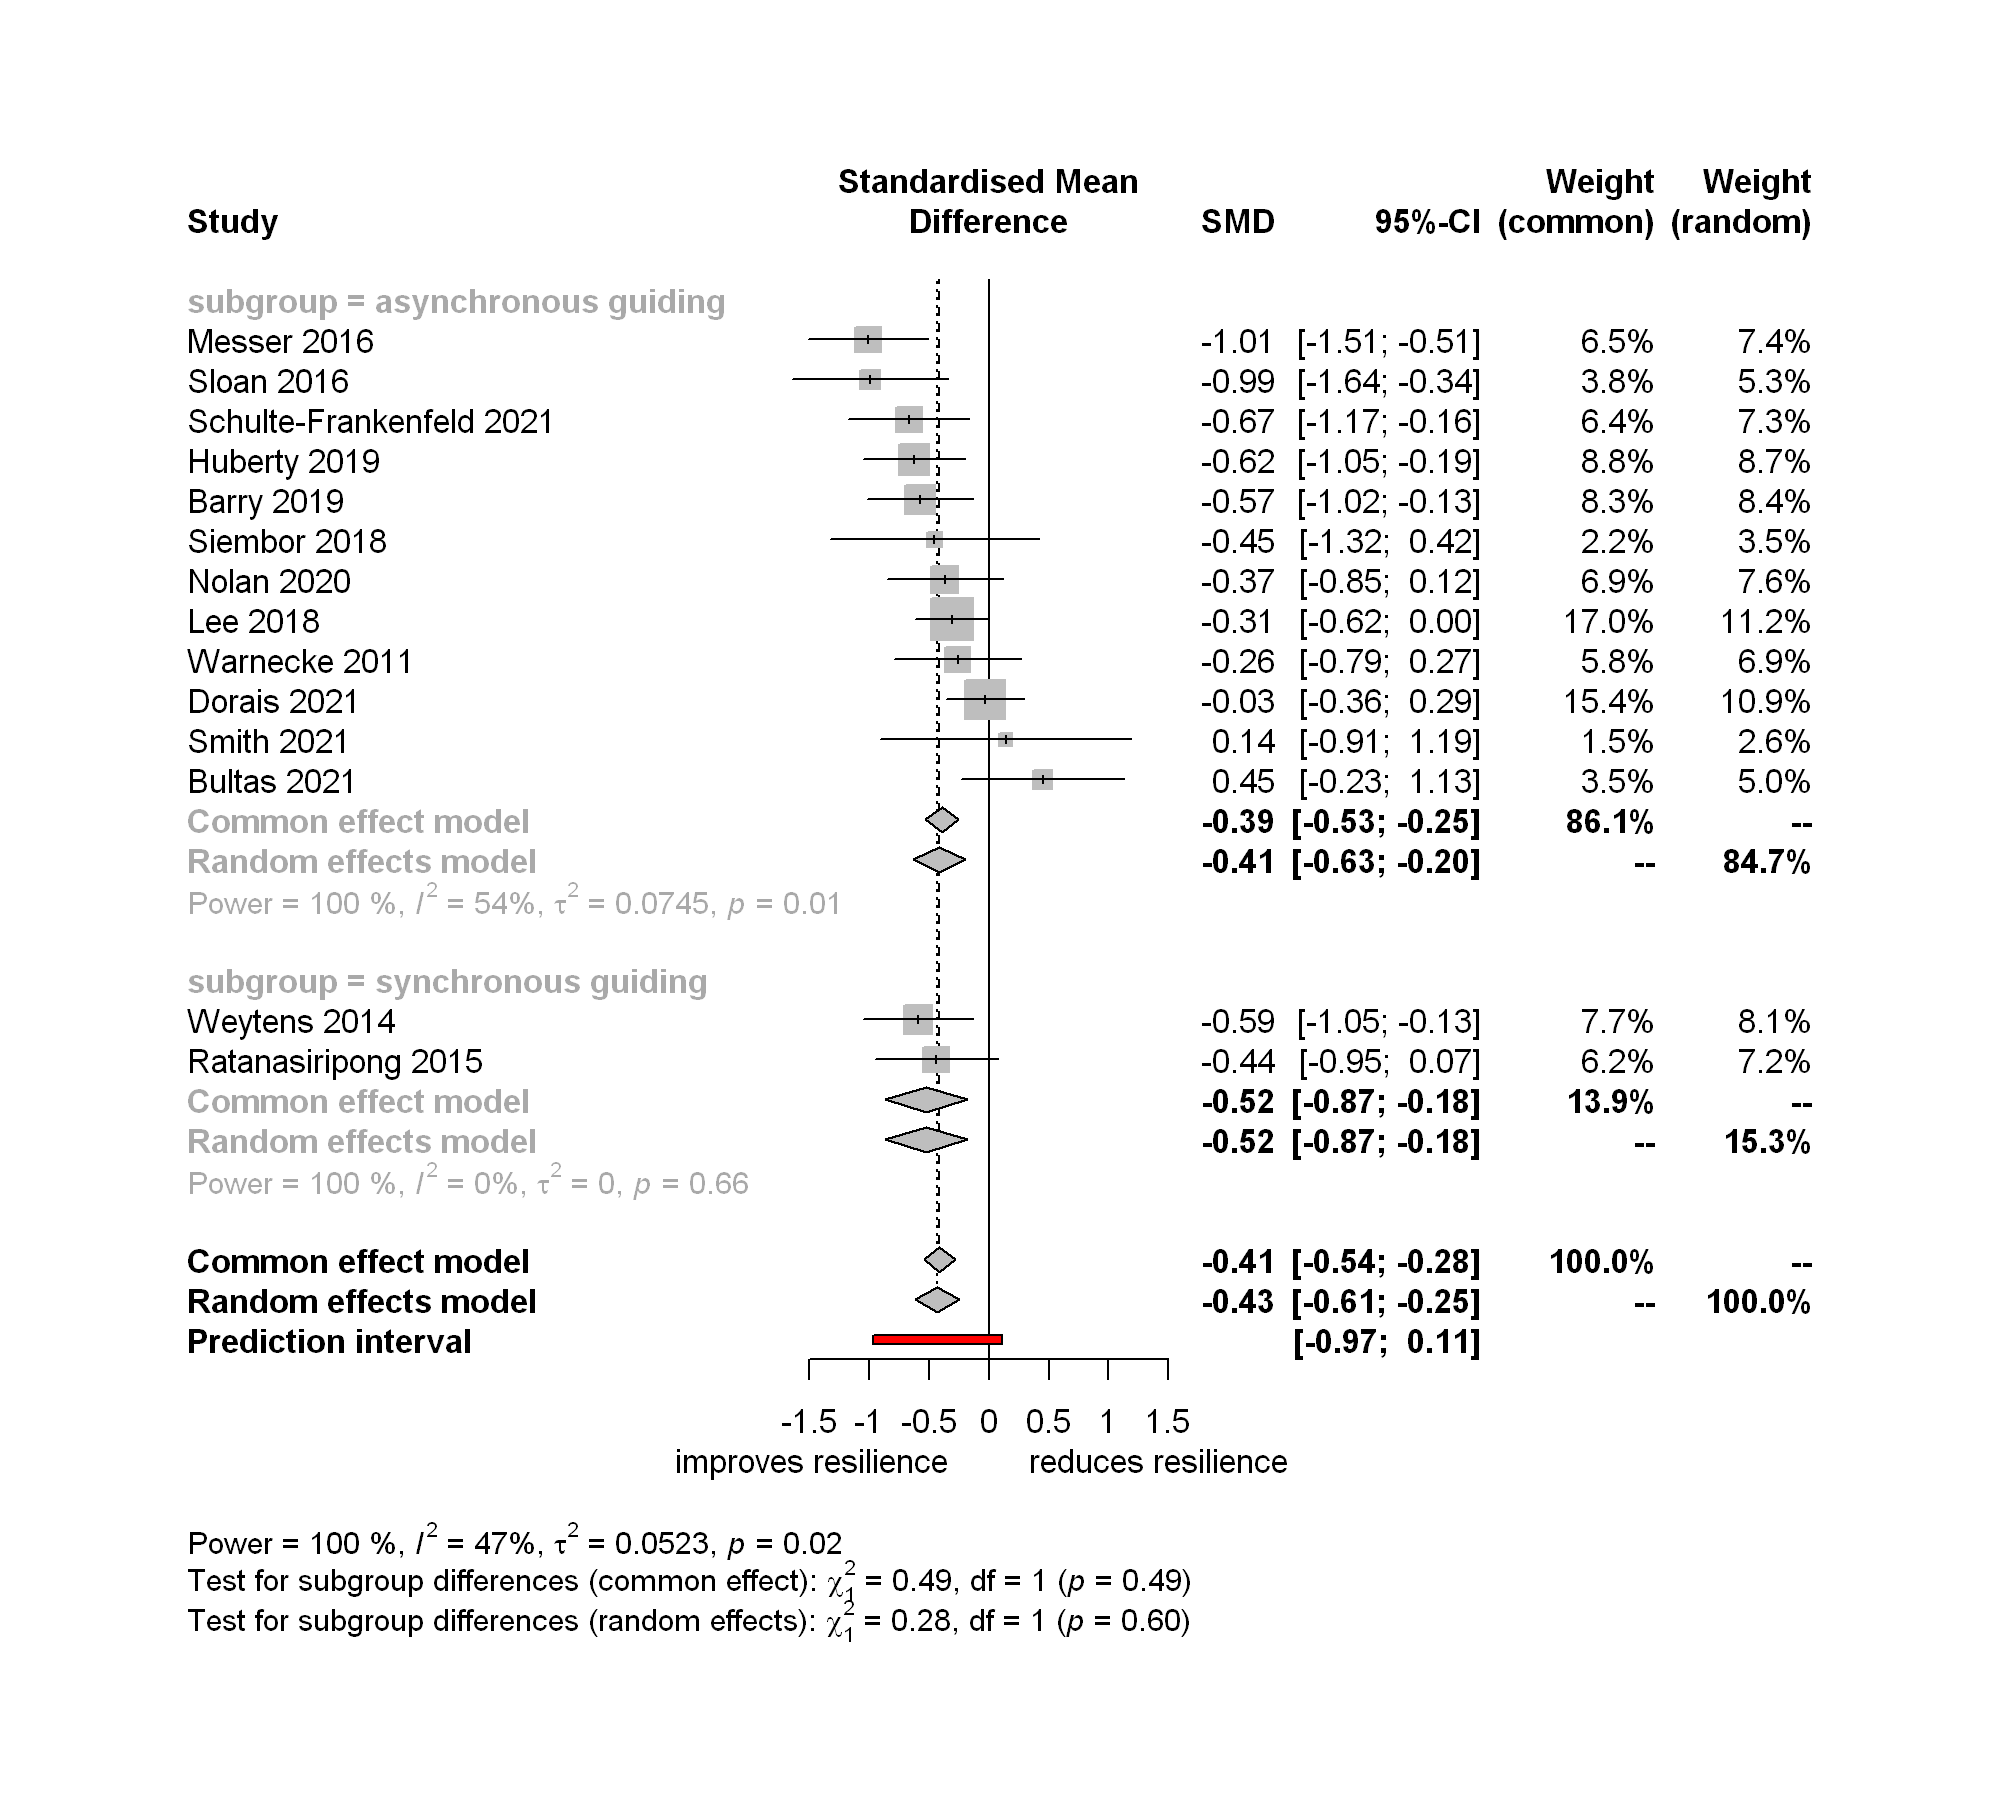

In [112]:
# set outcome and preferred outliers, subgroup to split
test.meta.results <- print.meta.results(
  "Stress", preferred.scale = "DASS",
  regression = F, print.forest = F, print.funnel = F, print.influence = F, print.baujat = F, split.subgroups = F, print.forest.sub.single = "delivery.mode", print.meta.results = F,
  return.data = "results.meta"
)
test.meta.results

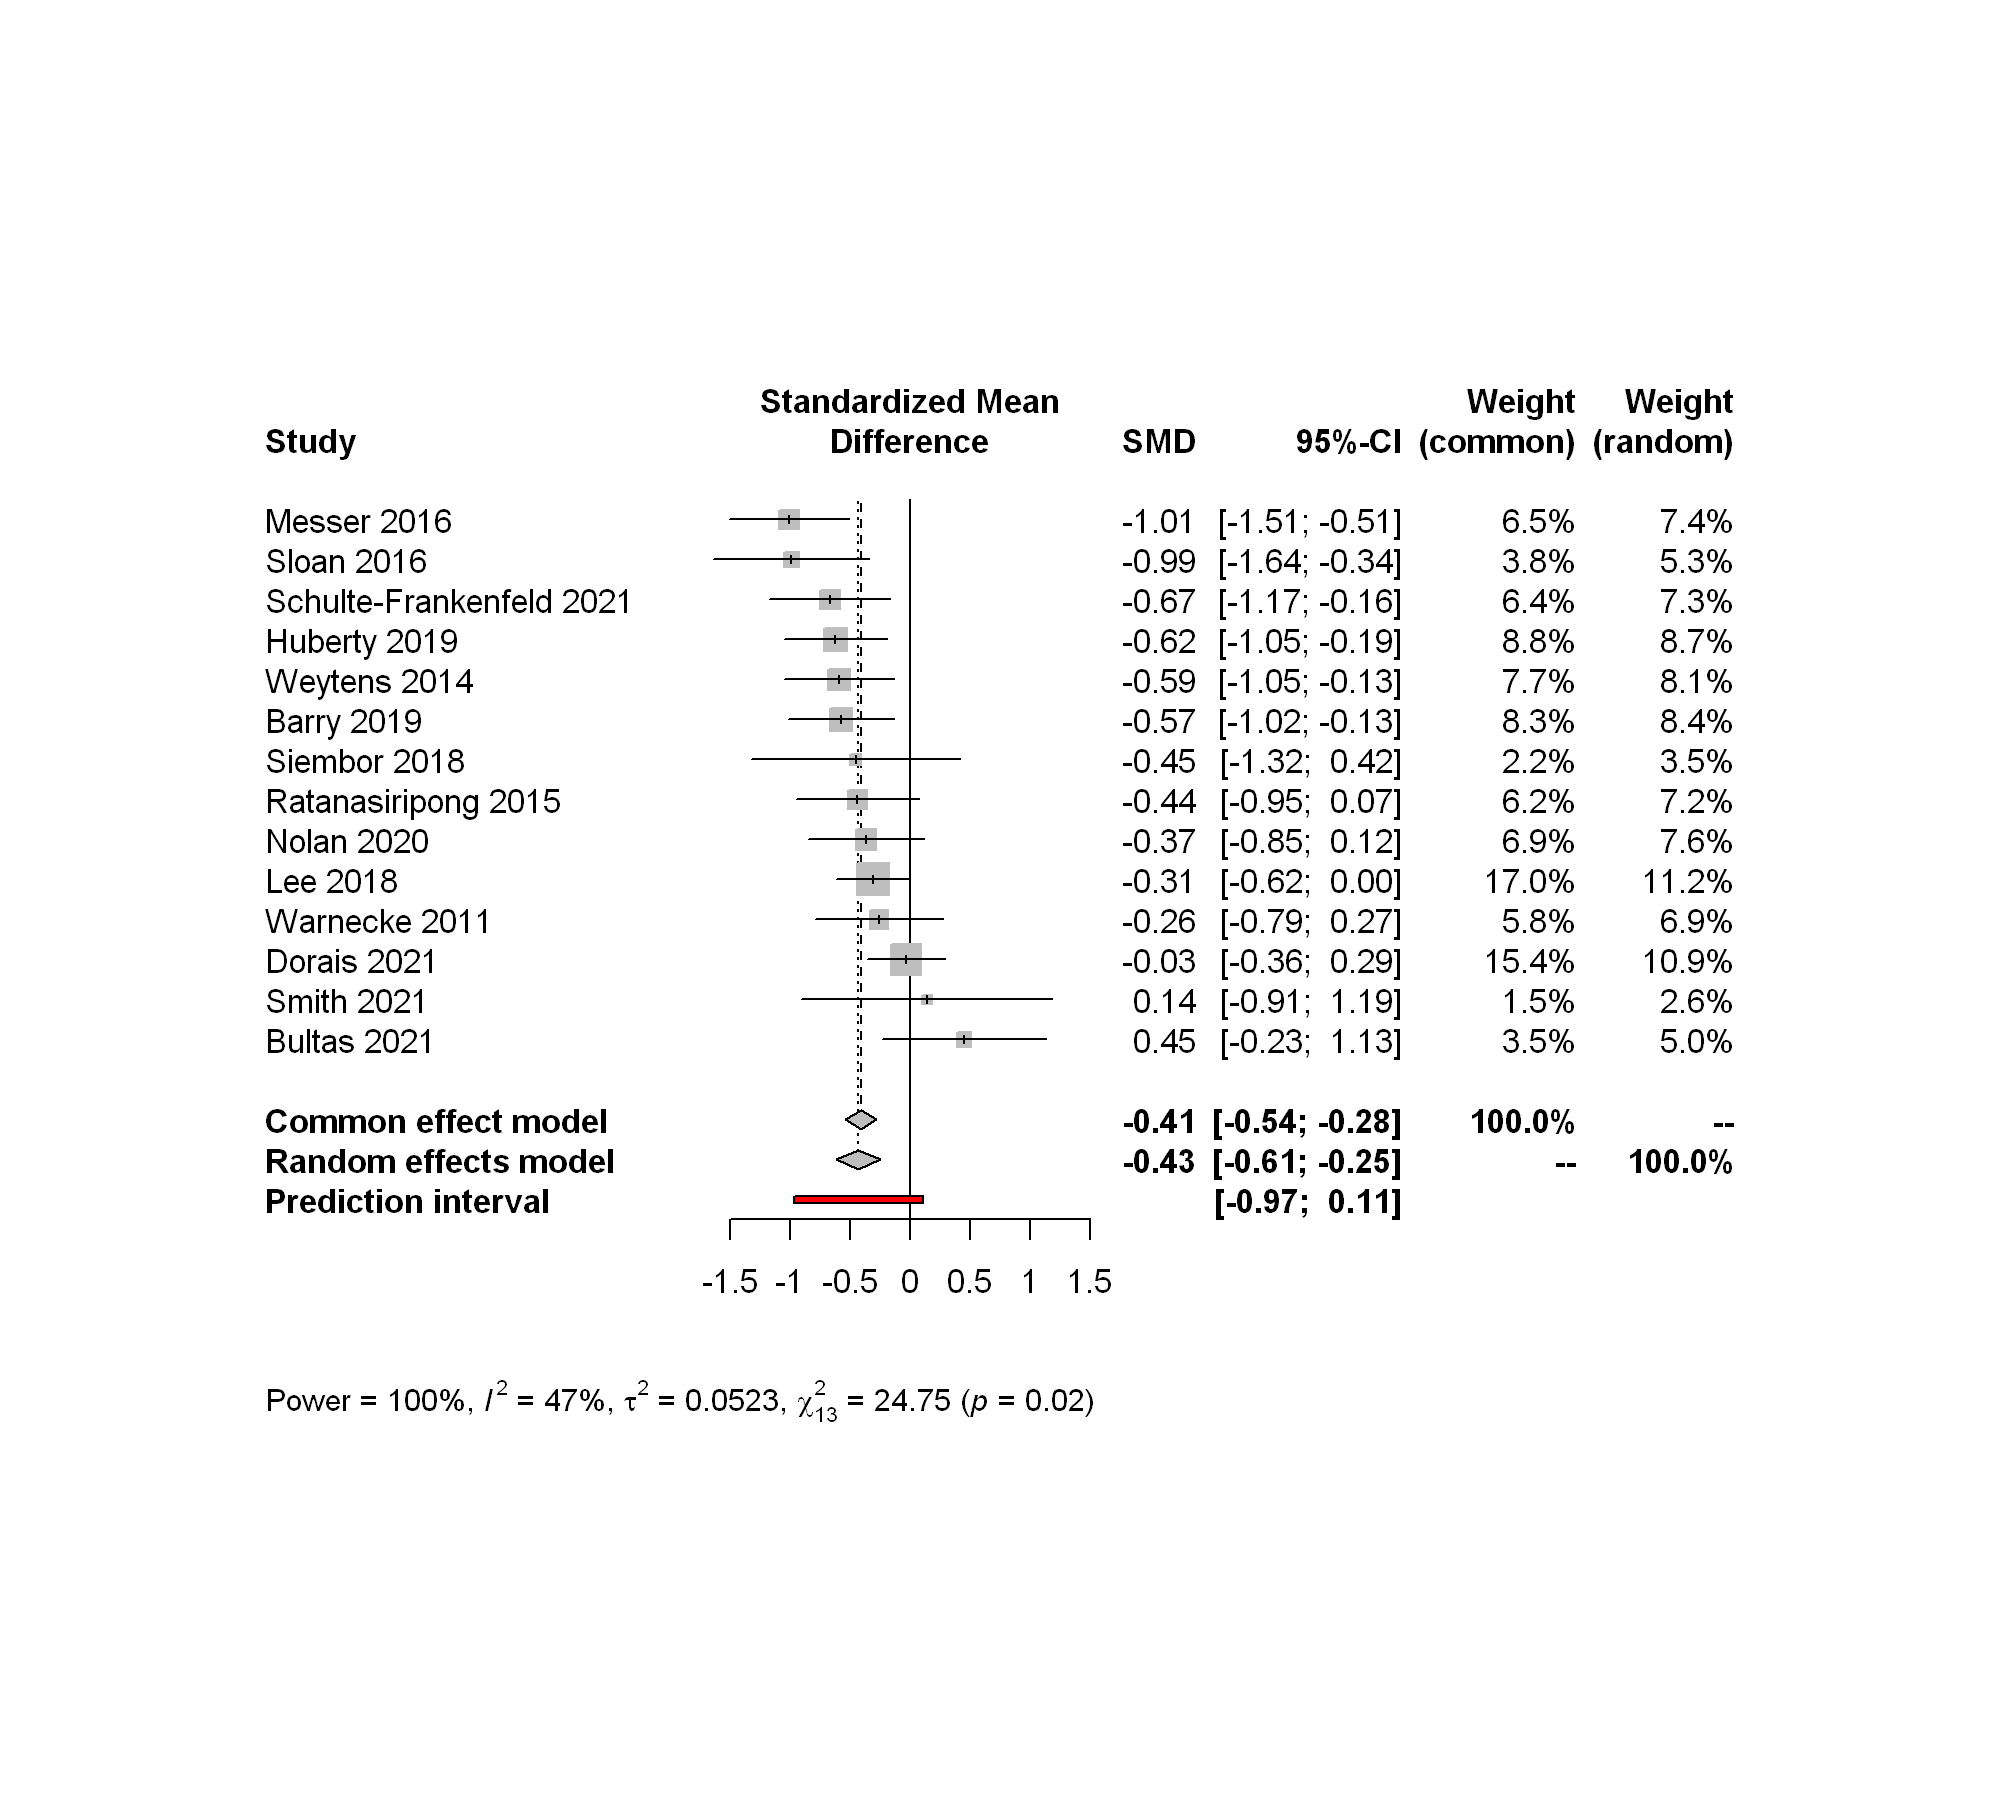

In [119]:
meta::forest(
  test.meta.results, leftcols = c('studlab'),
  prediction = TRUE,
  print.Q = TRUE,
  plotwidth = "5cm",
  smlab = "Standardized Mean\nDifference",
  # smlab = paste("SMD for\n", outcome, label.add),  # label to show outcome
  hetlab = paste("Power = ", as.character(test.meta.results$power), "%, ", sep = ""),
  addrows.below.overall = 4,  # rows below SMD sclae
  colgap.forest.left = "1cm"  # left space from graph 
)

### Resilience Scale


# Resilience Scale ----------------------------------


Warning message in metacont(n.int, mean.int, sd.int, n.control, mean.control, sd.control, :
"Note, studies with non-positive values for n.e and / or n.c get no weight in meta-analysis."
Warning message in metacont(n.int, mean.int, sd.int, n.control, mean.control, sd.control, :
"Note, studies with non-positive values for n.e and / or n.c get no weight in meta-analysis."


Number of studies combined: k = 1
Number of observations: o = 32

                         SMD             95%-CI     z p-value
Common effect model  -0.7636 [-1.4859; -0.0413] -2.07  0.0383
Random effects model -0.7636 [-1.4859; -0.0413] -2.07  0.0383

Quantifying heterogeneity:
 tau^2 = NA; tau = NA; I^2 = NA; H = NA

Details on meta-analytical method:
- Inverse variance method
- Restricted maximum-likelihood estimator for tau^2
- Hedges' g (bias corrected standardised mean difference; using exact formulae)

k < 4 => no Subgroup Analysis

[1] "number of included studies is below 3 --> now influence or baujat plot"
[1] "Number of included studies (2) for the funnel plot is below 3 for outcome: Resilience Scale"

[1] "sessions.duration"


Warning message in metacont(n.int, mean.int, sd.int, n.control, mean.control, sd.control, :
"Note, studies with non-positive values for n.e and / or n.c get no weight in meta-analysis."
Warning message in metacont(n.int, mean.int, sd.int, n.control, mean.control, sd.control, :
"Note, studies with non-positive values for n.e and / or n.c get no weight in meta-analysis."


[1] "Number of included studies (2) in regression is below 3 for outcome \"Resilience Scale\" and moderator \"sessions.duration\""

[1] "sessions.frequency"


Warning message in metacont(n.int, mean.int, sd.int, n.control, mean.control, sd.control, :
"Note, studies with non-positive values for n.e and / or n.c get no weight in meta-analysis."
Warning message in metacont(n.int, mean.int, sd.int, n.control, mean.control, sd.control, :
"Note, studies with non-positive values for n.e and / or n.c get no weight in meta-analysis."


[1] "Number of included studies (2) in regression is below 3 for outcome \"Resilience Scale\" and moderator \"sessions.frequency\""

[1] "programs.duration"


Warning message in metacont(n.int, mean.int, sd.int, n.control, mean.control, sd.control, :
"Note, studies with non-positive values for n.e and / or n.c get no weight in meta-analysis."
Warning message in metacont(n.int, mean.int, sd.int, n.control, mean.control, sd.control, :
"Note, studies with non-positive values for n.e and / or n.c get no weight in meta-analysis."


[1] "Number of included studies (2) in regression is below 3 for outcome \"Resilience Scale\" and moderator \"programs.duration\""

[1] "meditation.total"


Warning message in metacont(n.int, mean.int, sd.int, n.control, mean.control, sd.control, :
"Note, studies with non-positive values for n.e and / or n.c get no weight in meta-analysis."
Warning message in metacont(n.int, mean.int, sd.int, n.control, mean.control, sd.control, :
"Note, studies with non-positive values for n.e and / or n.c get no weight in meta-analysis."


[1] "Number of included studies (2) in regression is below 3 for outcome \"Resilience Scale\" and moderator \"meditation.total\""

[1] "follow.up.period"


Warning message in metacont(n.int, mean.int, sd.int, n.control, mean.control, sd.control, :
"Note, studies with non-positive values for n.e and / or n.c get no weight in meta-analysis."
Warning message in metacont(n.int, mean.int, sd.int, n.control, mean.control, sd.control, :
"Note, studies with non-positive values for n.e and / or n.c get no weight in meta-analysis."


[1] "Number of included studies (2) in regression is below 3 for outcome \"Resilience Scale\" and moderator \"follow.up.period\""

[1] "delivery.mode"


Warning message in metacont(n.int, mean.int, sd.int, n.control, mean.control, sd.control, :
"Note, studies with non-positive values for n.e and / or n.c get no weight in meta-analysis."
Warning message in metacont(n.int, mean.int, sd.int, n.control, mean.control, sd.control, :
"Note, studies with non-positive values for n.e and / or n.c get no weight in meta-analysis."


[1] "Number of included studies (2) in regression is below 3 for outcome \"Resilience Scale\" and moderator \"delivery.mode\""

[1] "meditation.type"


Warning message in metacont(n.int, mean.int, sd.int, n.control, mean.control, sd.control, :
"Note, studies with non-positive values for n.e and / or n.c get no weight in meta-analysis."
Warning message in metacont(n.int, mean.int, sd.int, n.control, mean.control, sd.control, :
"Note, studies with non-positive values for n.e and / or n.c get no weight in meta-analysis."


[1] "Number of included studies (2) in regression is below 3 for outcome \"Resilience Scale\" and moderator \"meditation.type\""



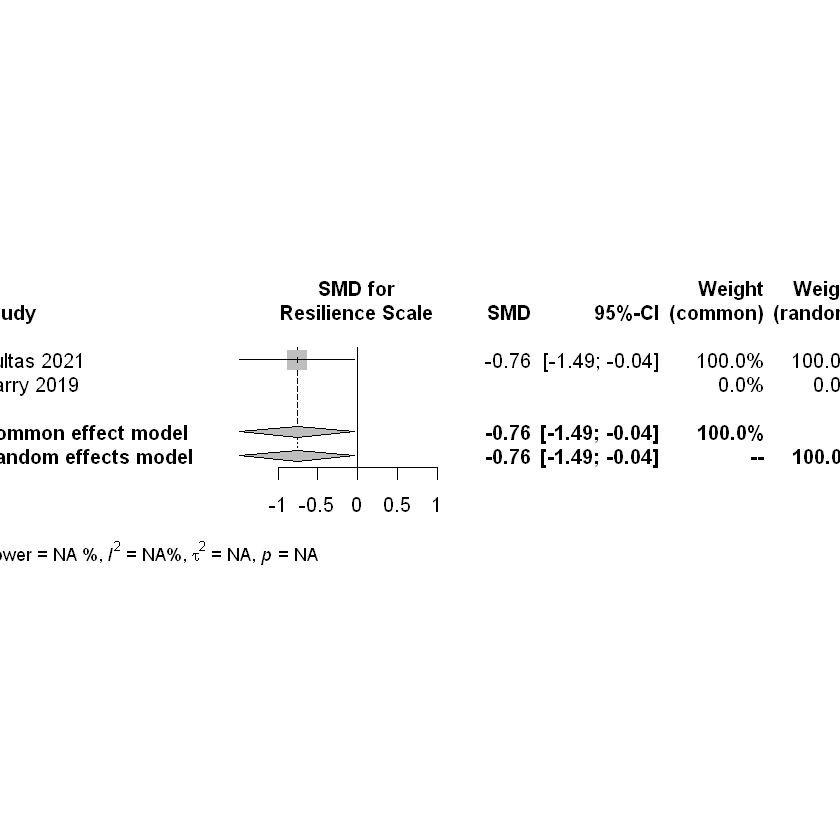

In [389]:
print.meta.results("Resilience Scale")

### Mental Health-related Outcomes

#### Anxiety

In [390]:
print.meta.results("Anxiety (state)")


# Anxiety (state) ----------------------------------


Warning message in metacont(n.int, mean.int, sd.int, n.control, mean.control, sd.control, :
"Note, studies with non-positive values for n.e and / or n.c get no weight in meta-analysis."
Warning message in metacont(n.int, mean.int, sd.int, n.control, mean.control, sd.control, :
"Note, studies with non-positive values for n.e and / or n.c get no weight in meta-analysis."


ERROR: Error in if (results.meta.cohens.d$TE.random > 0) {: missing value where TRUE/FALSE needed


In [ ]:
results.metafor.anxiety.t <- print.meta.results("Anxiety (trait)", return.data = "results.metafor", regression = T, regression.multiple = F)

In [ ]:
print.meta.results("Anxiety (trait)", filter.forest..funnel.vec = -c(6), regression = F, split.subgroups = F, print.influence = F)

In [ ]:
for (outlier in c(6)){
  sav <- gosh(results.metafor.anxiety.t)
  plot(sav, out = outlier)
}

#### Depression

In [ ]:
results.metafor.depression.t <- print.meta.results("Depression (trait)", return.data = "results.metafor")

In [ ]:
print.meta.results("Depression (trait)", filter.forest..funnel.vec = -c(1, 2, 7), regression = F, split.subgroups = F, print.influence = F)

In [ ]:
for (outlier in c(1, 2, 7)){
  sav <- gosh(results.metafor.depression.t)
  plot(sav, out = outlier)
}

#### Stress

##### DASS as preferred scale


# Stress ----------------------------------


Warning message:
"Using `size` aesthetic for lines was deprecated in ggplot2 3.4.0.
ℹ Please use `linewidth` instead."


Number of studies combined: k = 14
Number of observations: o = 988

                         SMD             95%-CI     z  p-value
Common effect model  -0.4109 [-0.5385; -0.2832] -6.31 < 0.0001
Random effects model -0.4304 [-0.6129; -0.2478] -4.62 < 0.0001

Quantifying heterogeneity:
 tau^2 = 0.0523 [0.0000; 0.3070]; tau = 0.2287 [0.0000; 0.5540]
 I^2 = 47.5% [2.4%; 71.7%]; H = 1.38 [1.01; 1.88]

Test of heterogeneity:
     Q d.f. p-value
 24.75   13  0.0249

Details on meta-analytical method:
- Inverse variance method
- Restricted maximum-likelihood estimator for tau^2
- Q-Profile method for confidence interval of tau^2 and tau
- Hedges' g (bias corrected standardised mean difference; using exact formulae)

# Subgroup Analysis: delivery.mode 
Number of studies combined: k = 14
Number of observations: o = 988

                         SMD             95%-CI     z  p-value
Common effect model  -0.4109 [-0.5385; -0.2832] -6.31 < 0.0001
Random effects model -0.4304 [-0.6129; -0.2478] -4.6

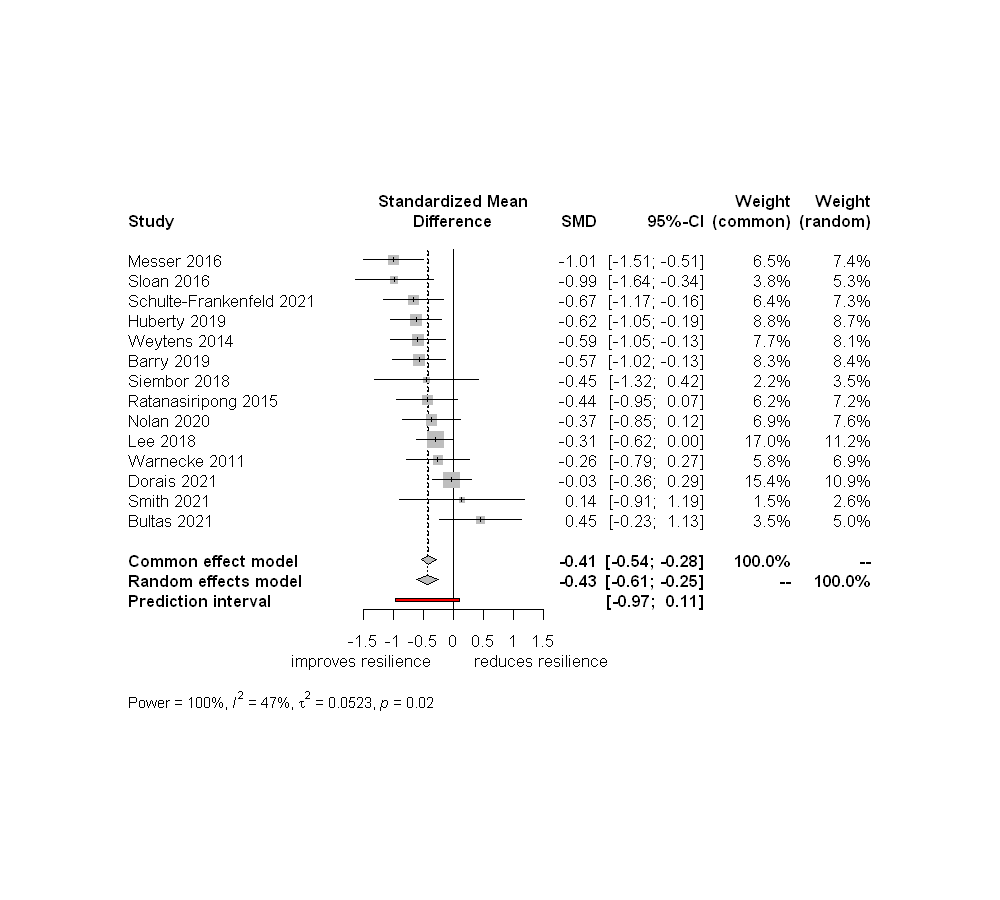


# Subgroup Analysis: meditation.type 
Number of studies combined: k = 14
Number of observations: o = 988

                         SMD             95%-CI     z  p-value
Common effect model  -0.4109 [-0.5385; -0.2832] -6.31 < 0.0001
Random effects model -0.4304 [-0.6129; -0.2478] -4.62 < 0.0001

Quantifying heterogeneity:
 tau^2 = 0.0523 [0.0000; 0.3070]; tau = 0.2287 [0.0000; 0.5540]
 I^2 = 47.5% [2.4%; 71.7%]; H = 1.38 [1.01; 1.88]

Test of heterogeneity:
     Q d.f. p-value
 24.75   13  0.0249

Results for subgroups (common effect model):
                                   k     SMD             95%-CI     Q   I^2
subgroup = attentional family      9 -0.3490 [-0.5231; -0.1750] 21.30 62.4%
subgroup = hybrid form             3 -0.4653 [-0.6900; -0.2405]  2.13  6.0%
subgroup = constructive family     1 -0.5922 [-1.0510; -0.1335]  0.00    --
subgroup = deconstructive family   1 -0.4381 [-0.9508;  0.0747]  0.00    --

Test for subgroup differences (common effect model):
                  

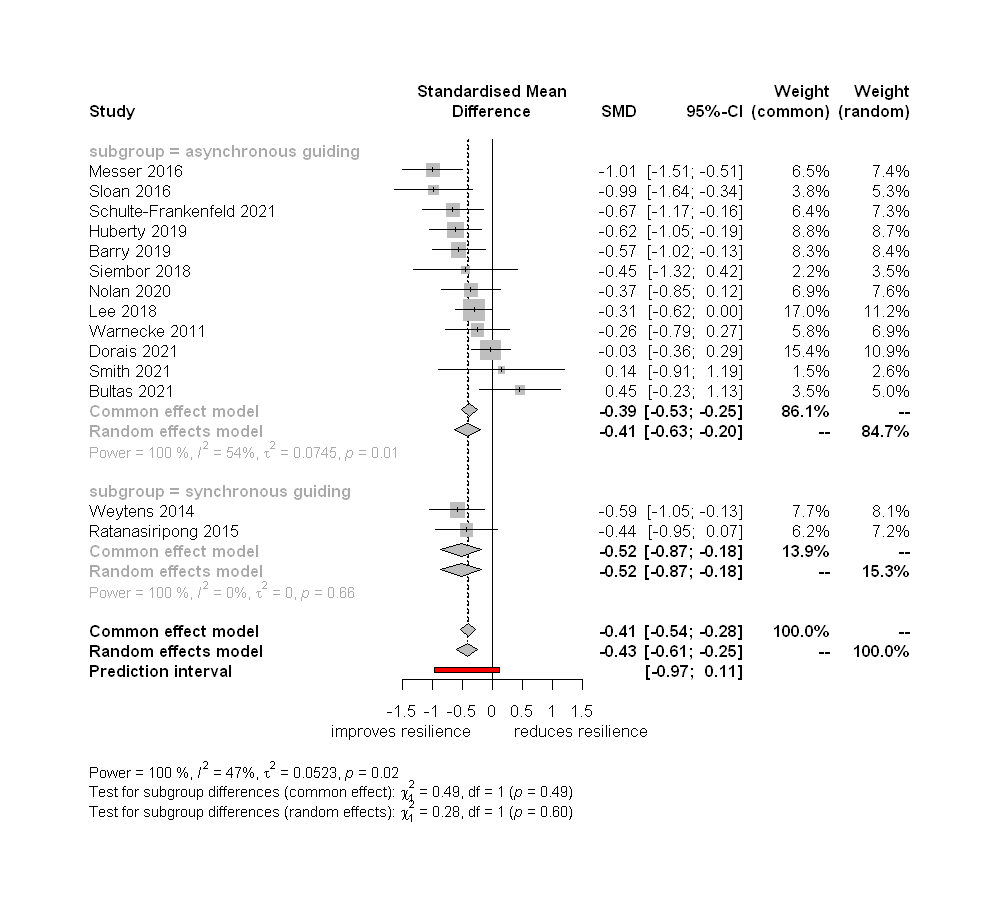

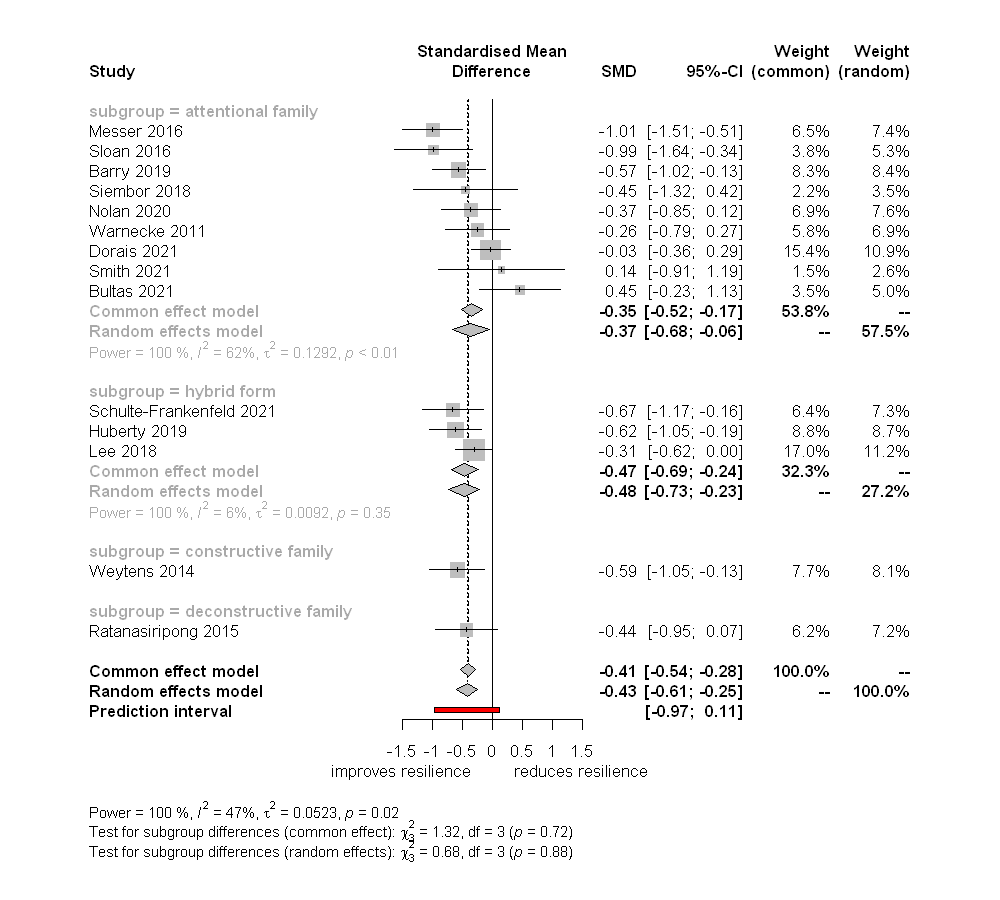

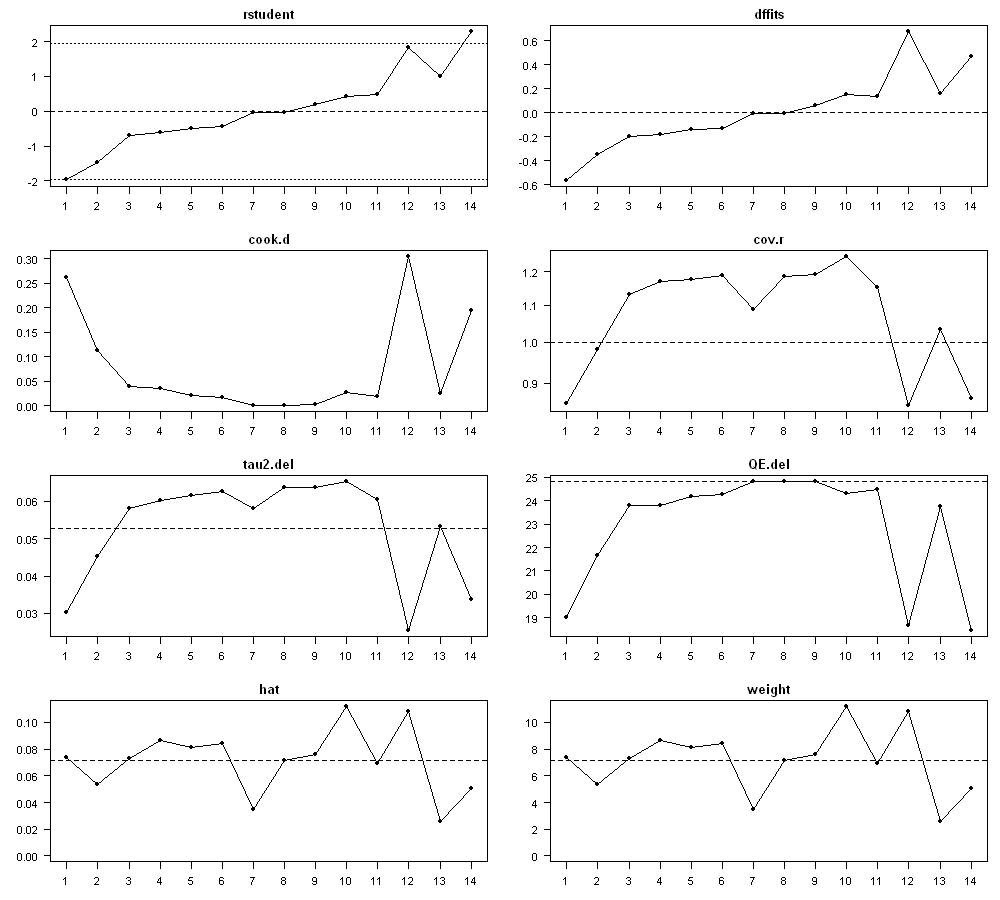


Regression Test for Funnel Plot Asymmetry

Model:     mixed-effects meta-regression model
Predictor: standard error

Test for Funnel Plot Asymmetry: z =  0.3212, p = 0.7481
Limit Estimate (as sei -> 0):   b = -0.5315 (CI: -1.1741, 0.1110)



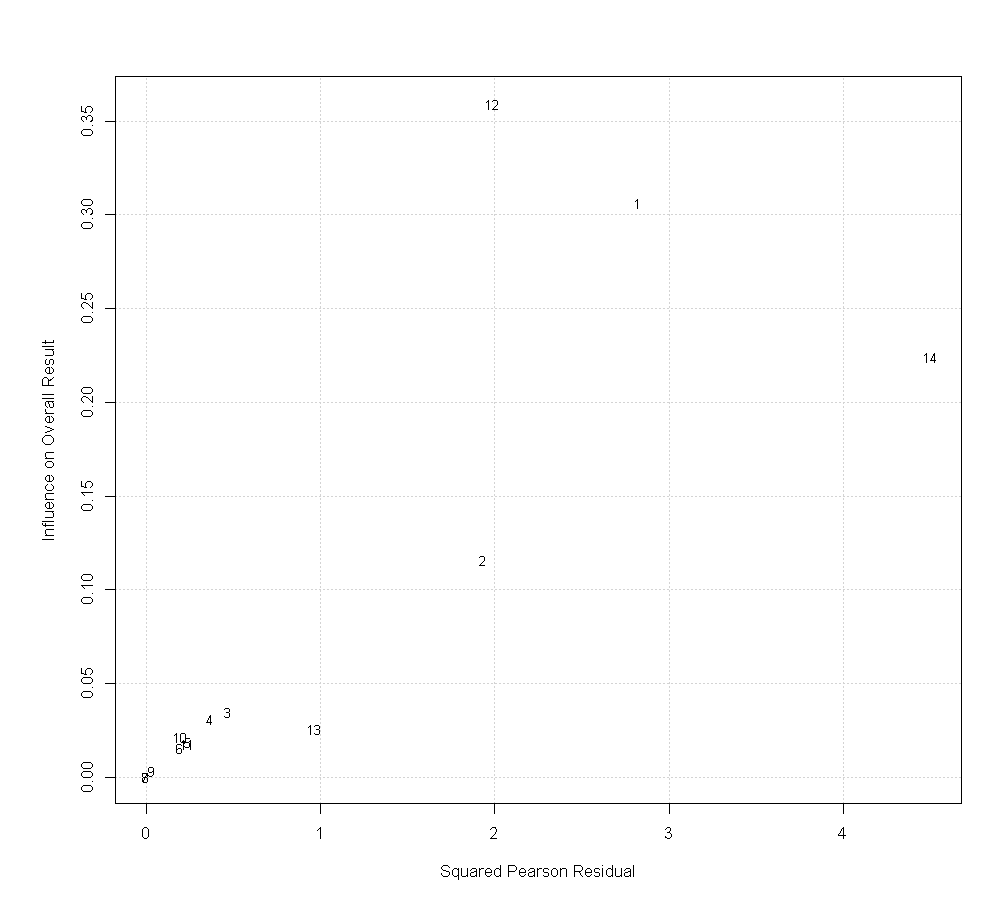

[1] "sessions.duration"


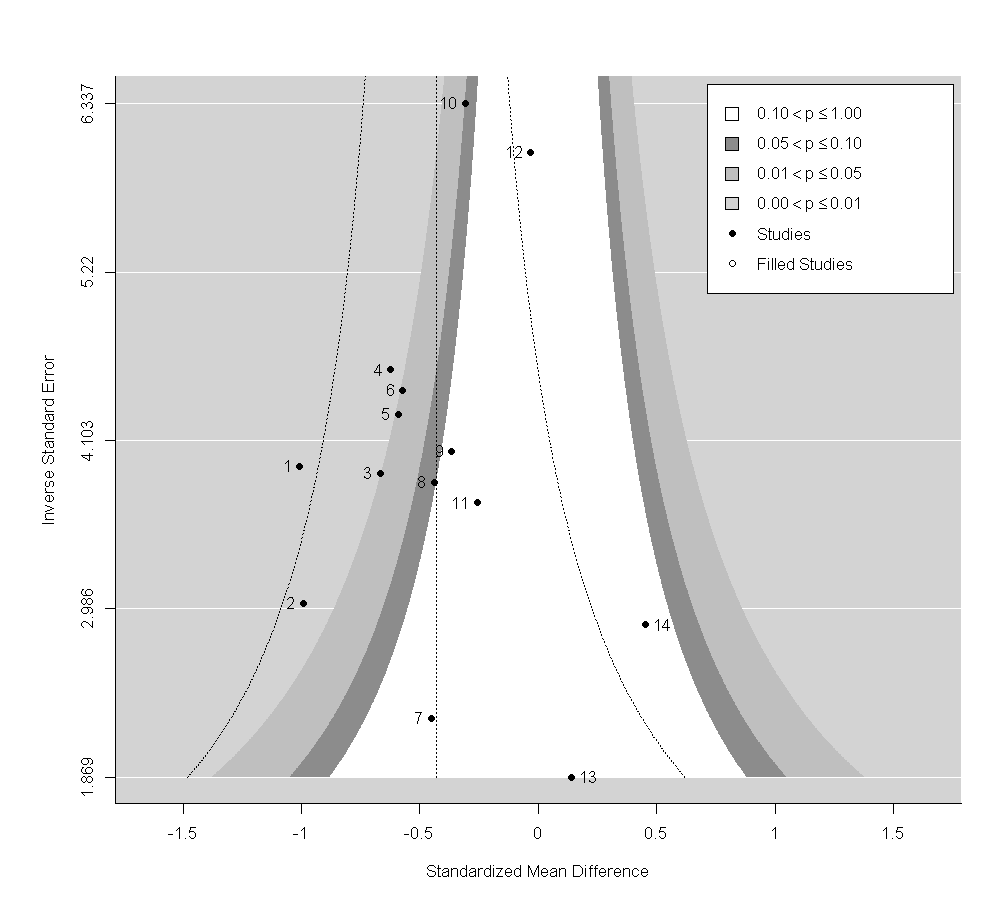

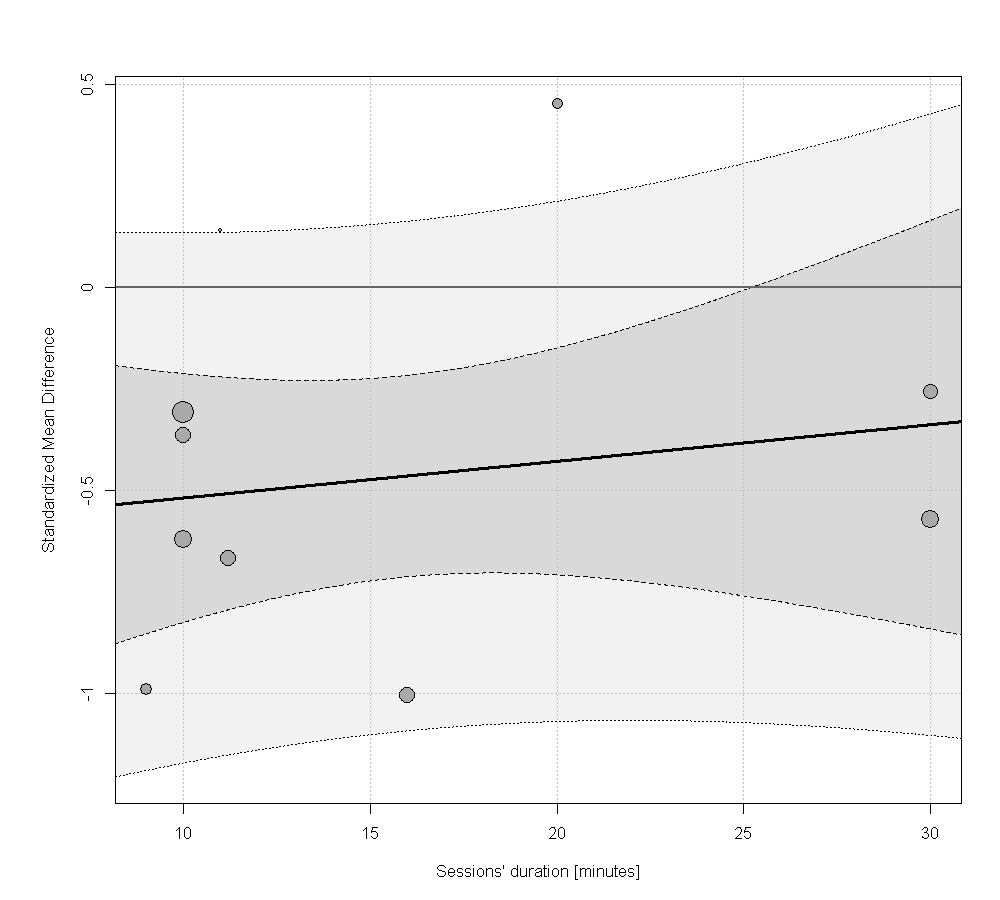

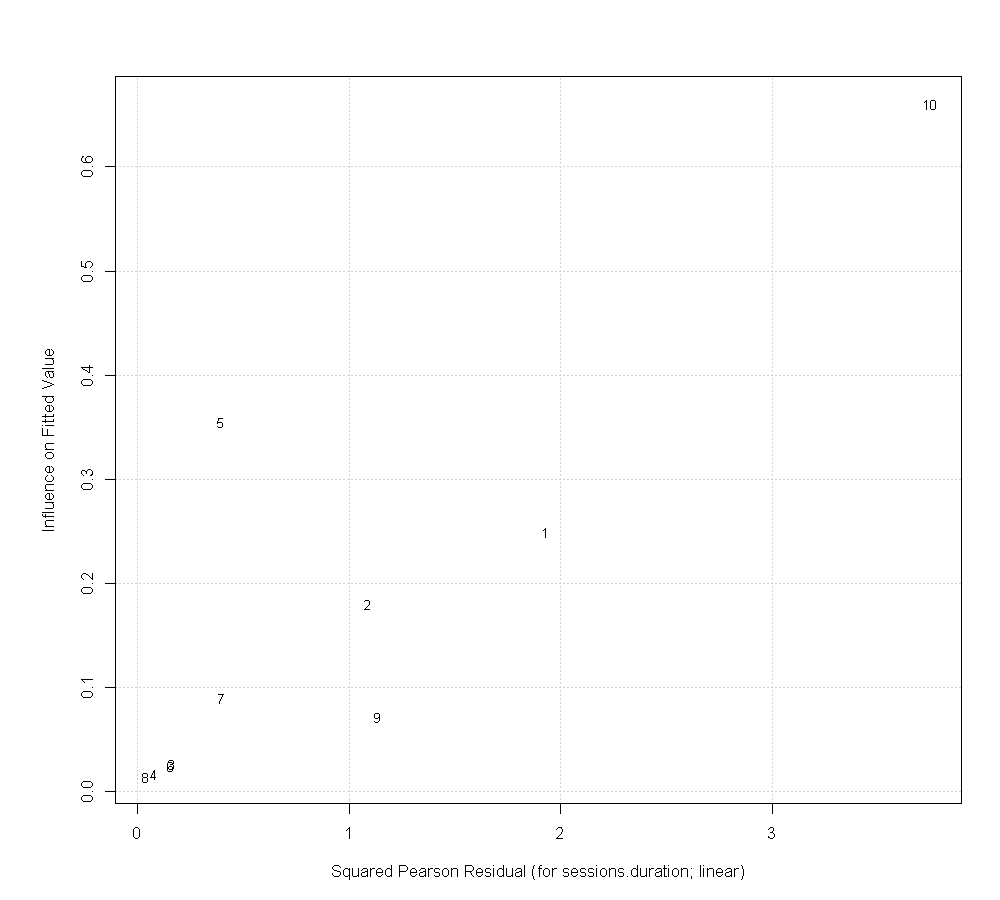

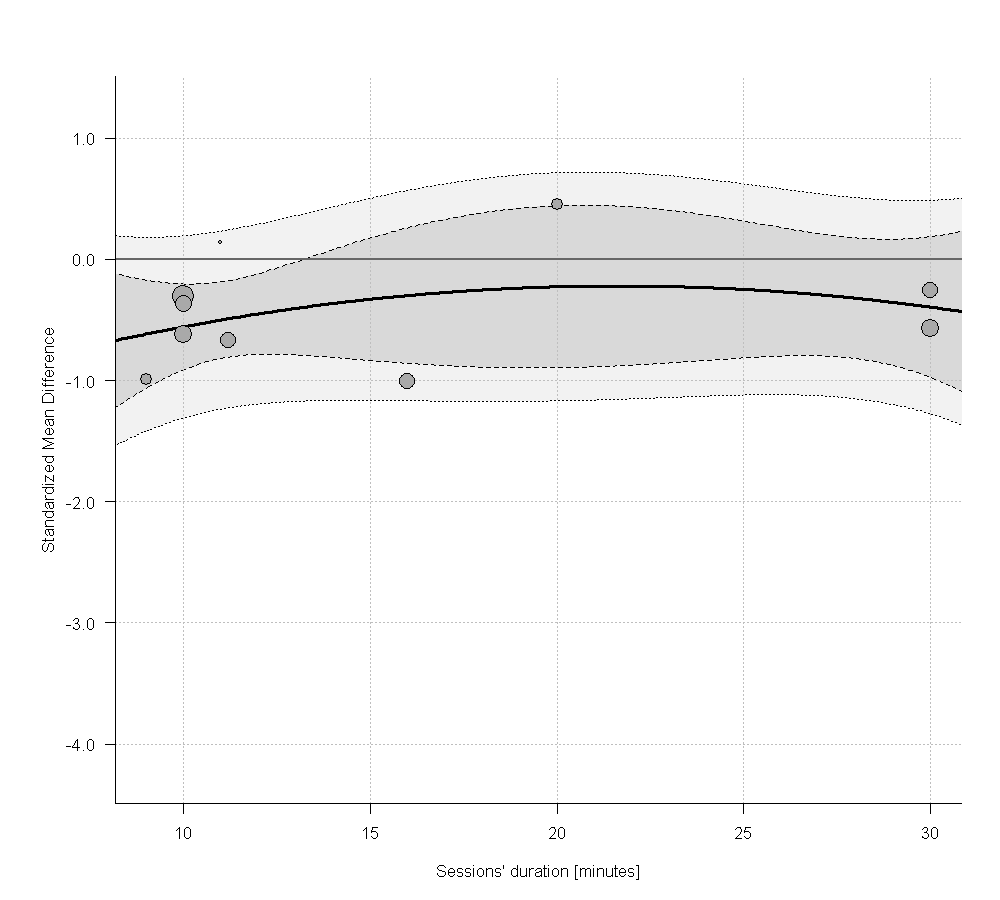

[1] "sessions.duration"
[1] "Linear"

Mixed-Effects Model (k = 10; tau^2 estimator: REML)

tau^2 (estimated amount of residual heterogeneity):     0.0867 (SE = 0.0792)
tau (square root of estimated tau^2 value):             0.2944
I^2 (residual heterogeneity / unaccounted variability): 56.73%
H^2 (unaccounted variability / sampling variability):   2.31
R^2 (amount of heterogeneity accounted for):            0.00%

Test for Residual Heterogeneity:
QE(df = 8) = 18.1676, p-val = 0.0200

Test of Moderators (coefficient 2):
QM(df = 1) = 0.3280, p-val = 0.5668

Model Results:

                   estimate      se     zval    pval    ci.lb    ci.ub    
intrcpt             -0.6096  0.2797  -2.1795  0.0293  -1.1578  -0.0614  * 
sessions.duration    0.0090  0.0158   0.5727  0.5668  -0.0219   0.0399    

---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1


[1] "Polynomial"

Mixed-Effects Model (k = 10; tau^2 estimator: REML)

tau^2 (estimated amount of residual heterogeneity):     

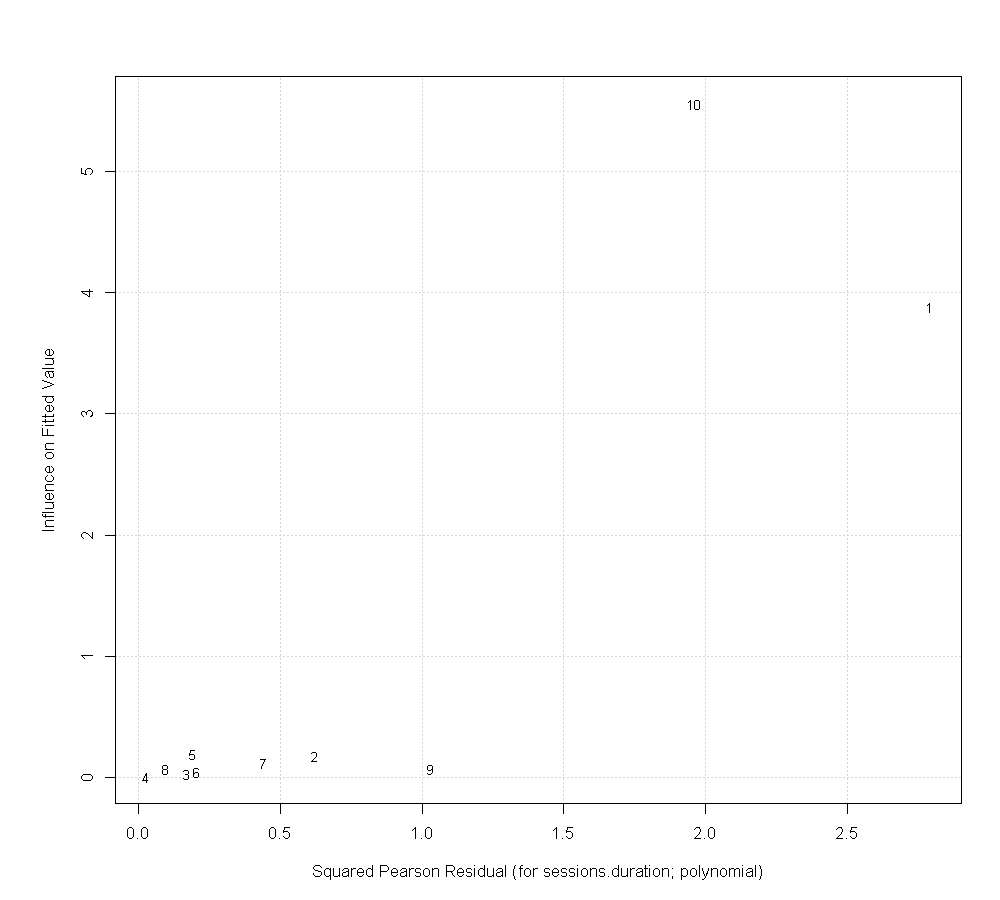

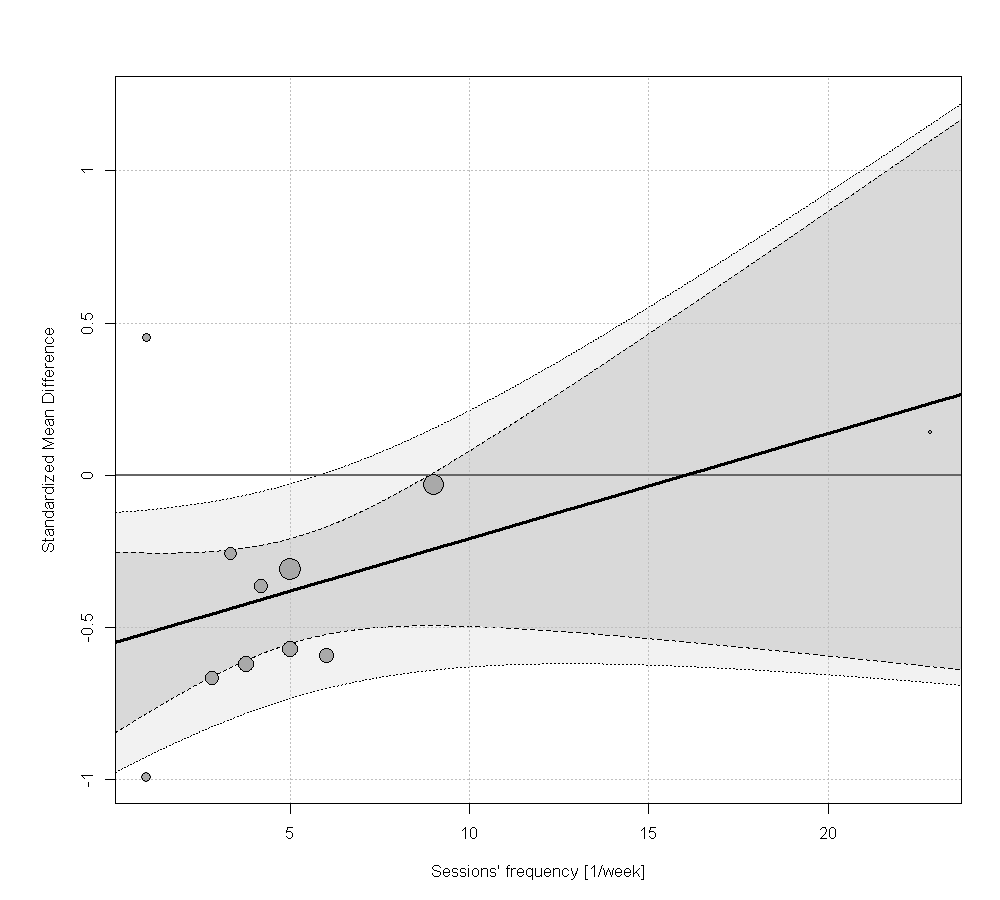

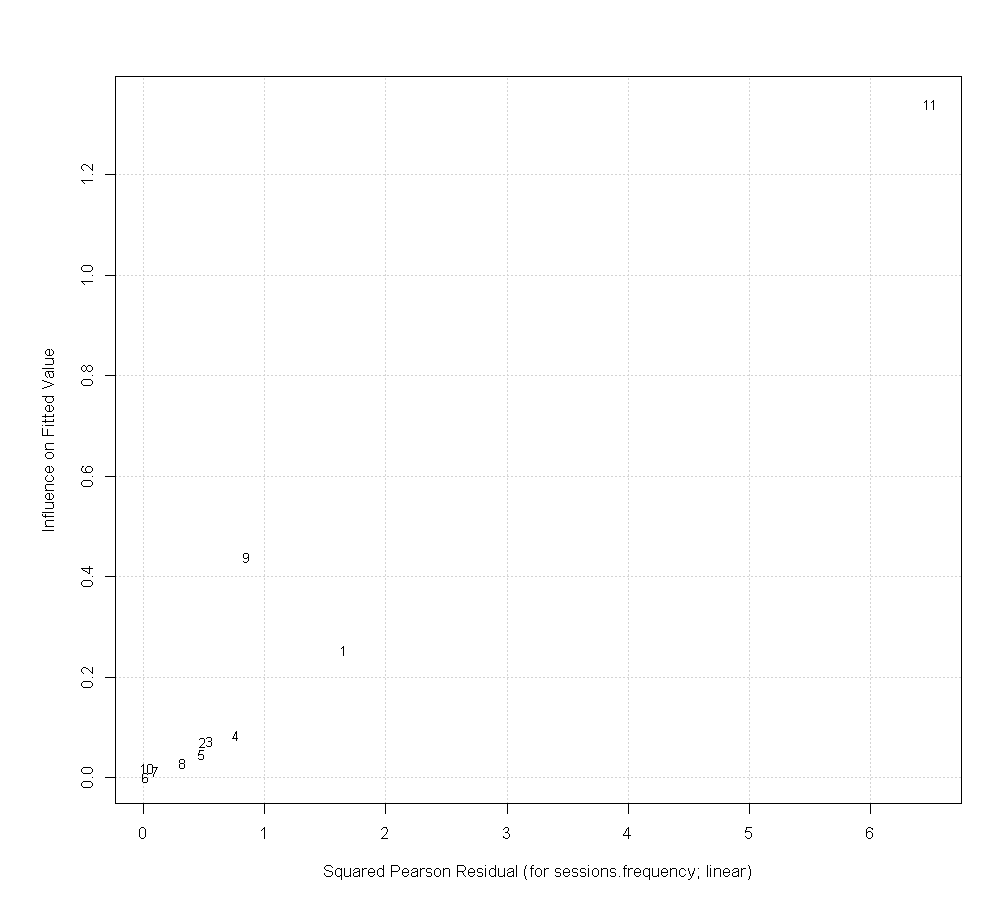

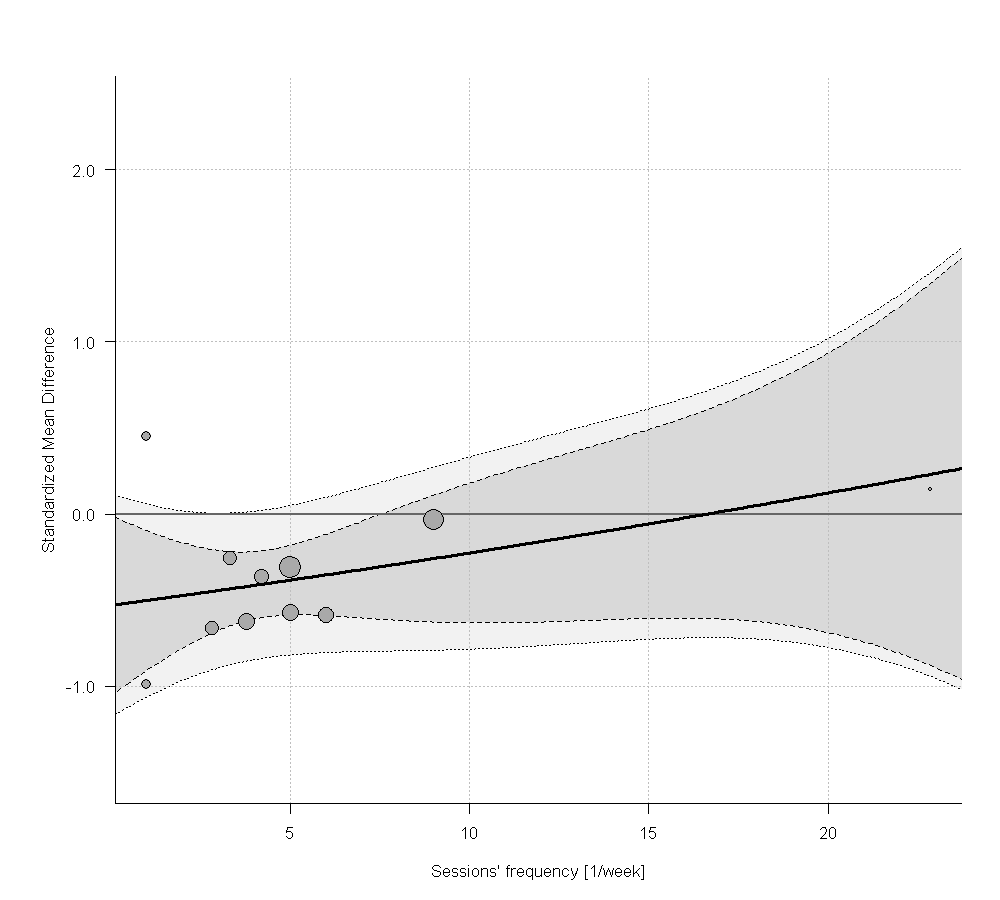

[1] "sessions.frequency"
[1] "Linear"

Mixed-Effects Model (k = 11; tau^2 estimator: REML)

tau^2 (estimated amount of residual heterogeneity):     0.0246 (SE = 0.0375)
tau (square root of estimated tau^2 value):             0.1567
I^2 (residual heterogeneity / unaccounted variability): 30.82%
H^2 (unaccounted variability / sampling variability):   1.45
R^2 (amount of heterogeneity accounted for):            44.09%

Test for Residual Heterogeneity:
QE(df = 9) = 15.4412, p-val = 0.0795

Test of Moderators (coefficient 2):
QM(df = 1) = 1.9980, p-val = 0.1575

Model Results:

                    estimate      se     zval    pval    ci.lb    ci.ub      
intrcpt              -0.5533  0.1538  -3.5973  0.0003  -0.8548  -0.2518  *** 
sessions.frequency    0.0345  0.0244   1.4135  0.1575  -0.0133   0.0823      

---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1


[1] "Polynomial"

Mixed-Effects Model (k = 11; tau^2 estimator: REML)

tau^2 (estimated amount of residual heterogen

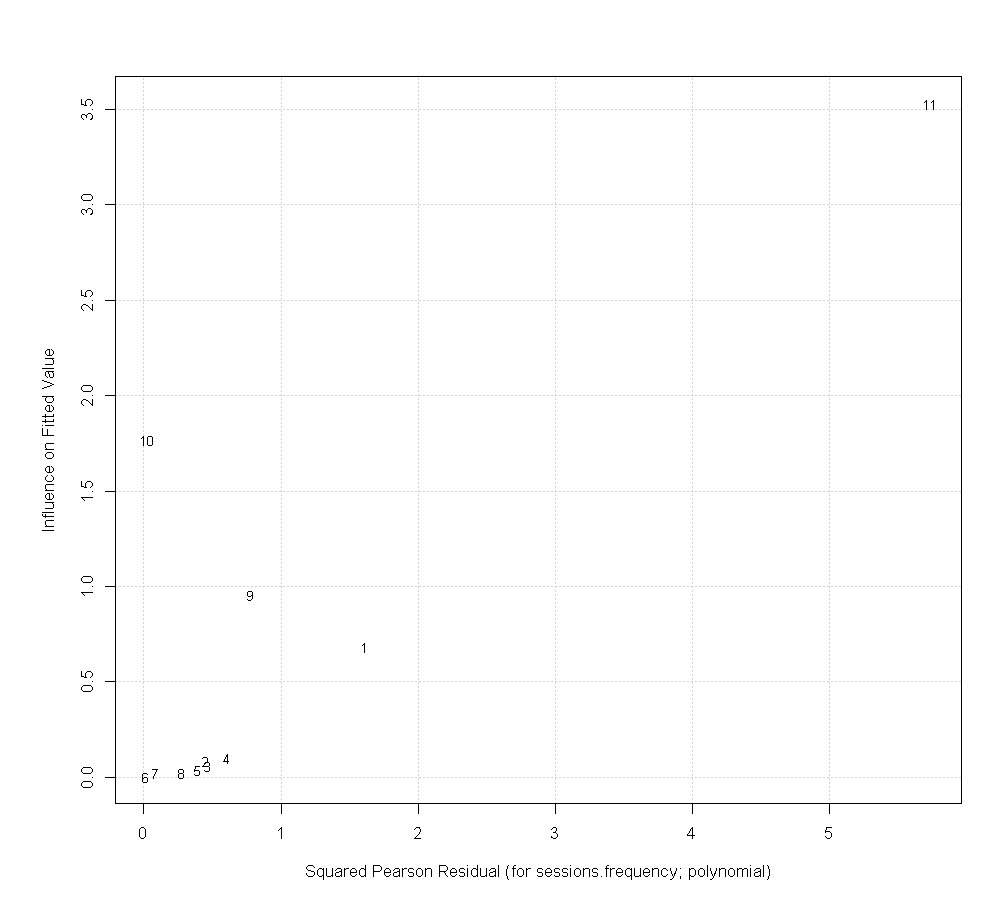

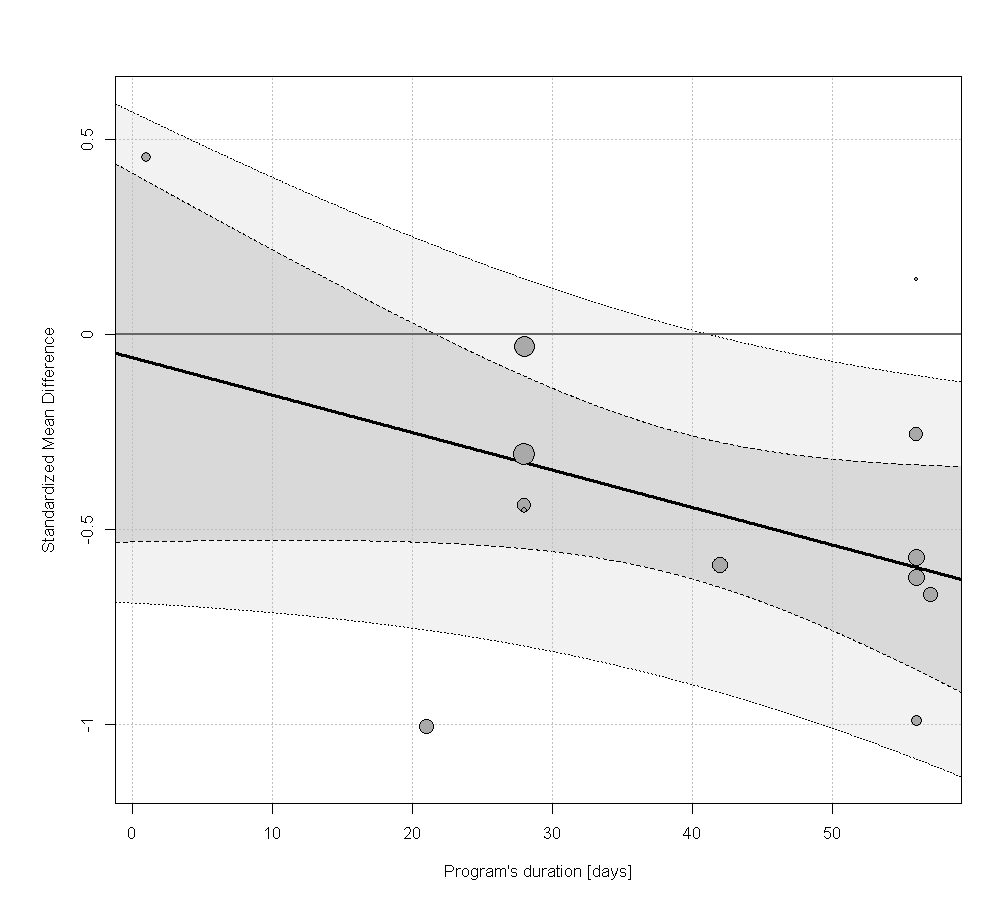

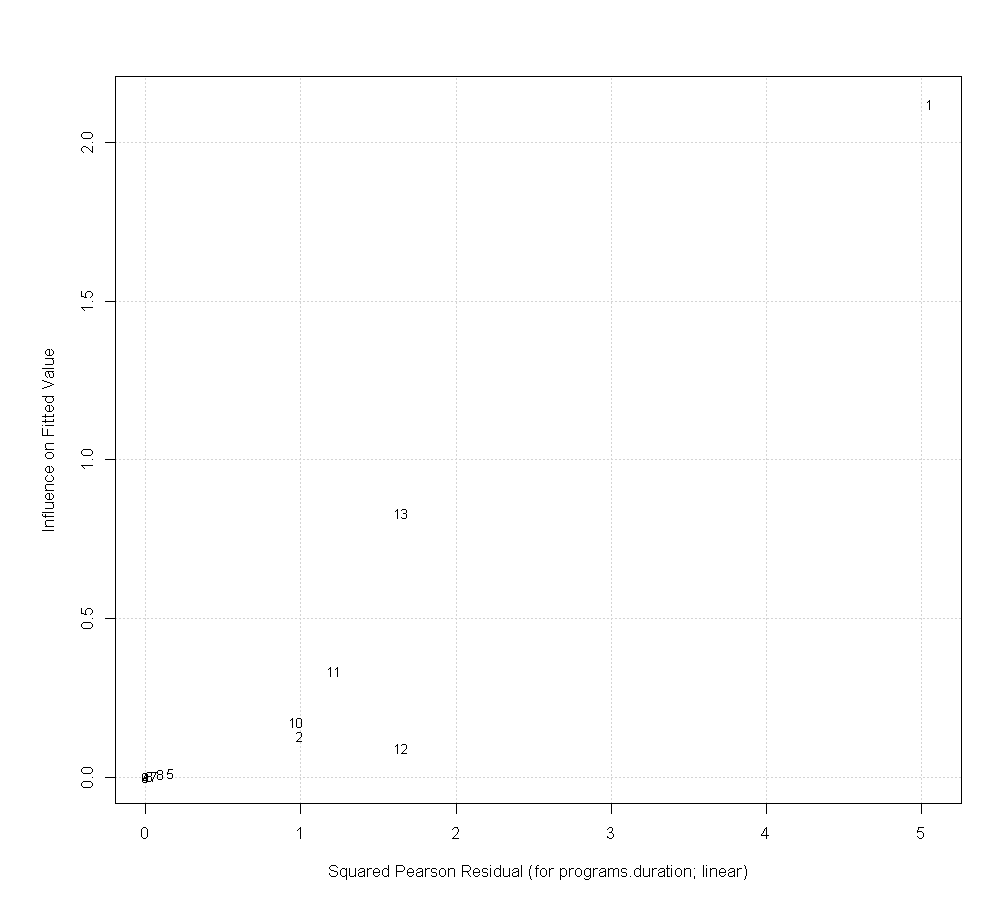

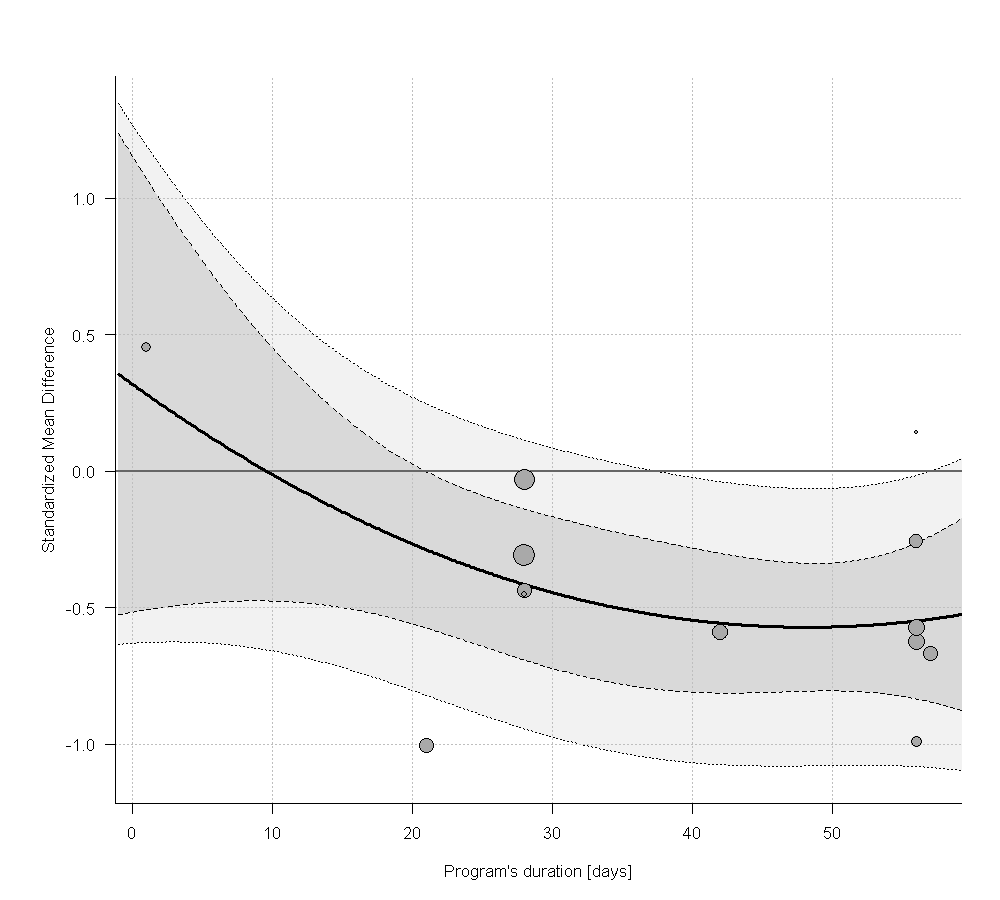

[1] "programs.duration"
[1] "Linear"

Mixed-Effects Model (k = 13; tau^2 estimator: REML)

tau^2 (estimated amount of residual heterogeneity):     0.0450 (SE = 0.0463)
tau (square root of estimated tau^2 value):             0.2121
I^2 (residual heterogeneity / unaccounted variability): 42.27%
H^2 (unaccounted variability / sampling variability):   1.73
R^2 (amount of heterogeneity accounted for):            29.40%

Test for Residual Heterogeneity:
QE(df = 11) = 19.5292, p-val = 0.0522

Test of Moderators (coefficient 2):
QM(df = 1) = 2.8538, p-val = 0.0912

Model Results:

                   estimate      se     zval    pval    ci.lb   ci.ub    
intrcpt             -0.0600  0.2412  -0.2488  0.8036  -0.5327  0.4127    
programs.duration   -0.0096  0.0057  -1.6893  0.0912  -0.0207  0.0015  . 

---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1


[1] "Polynomial"

Mixed-Effects Model (k = 13; tau^2 estimator: REML)

tau^2 (estimated amount of residual heterogeneity):     0

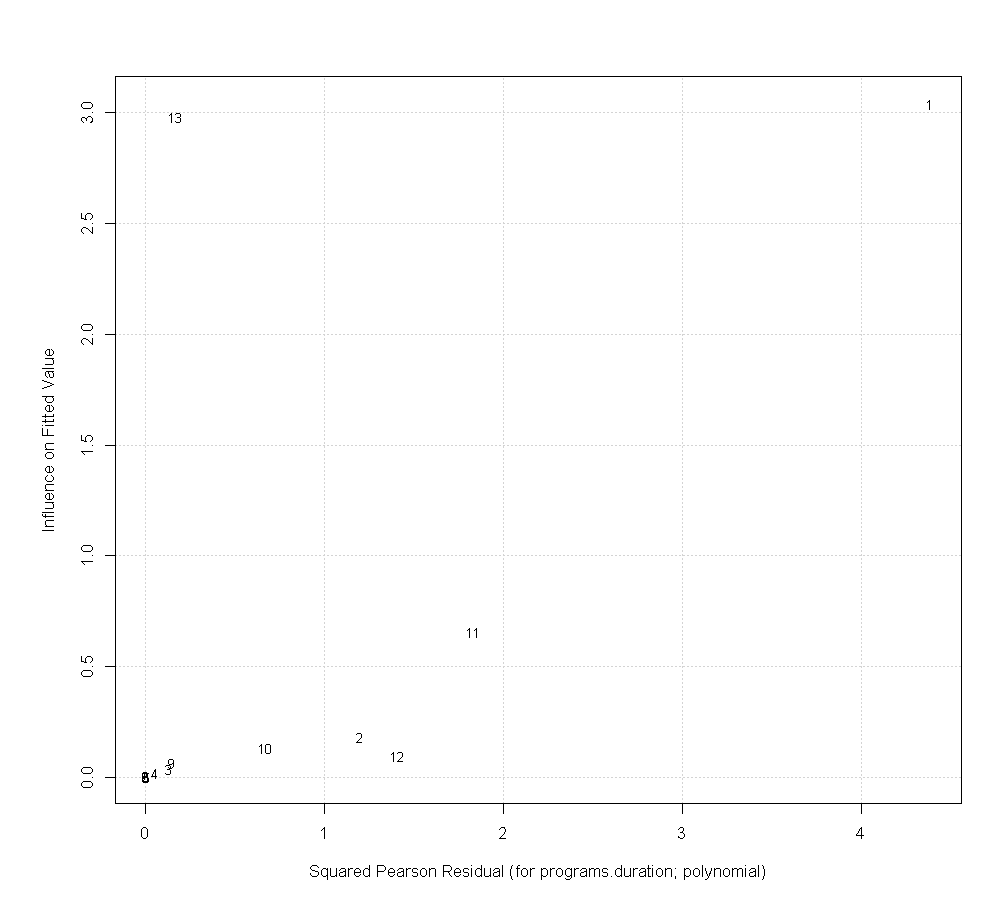

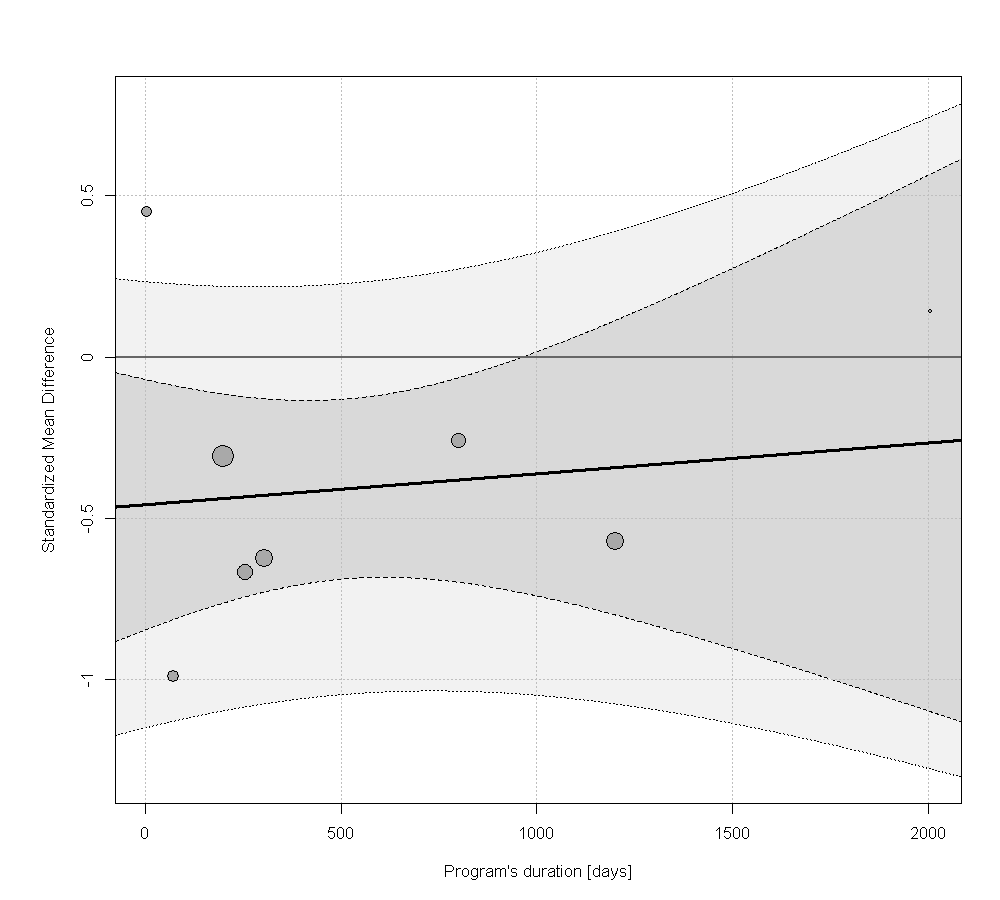

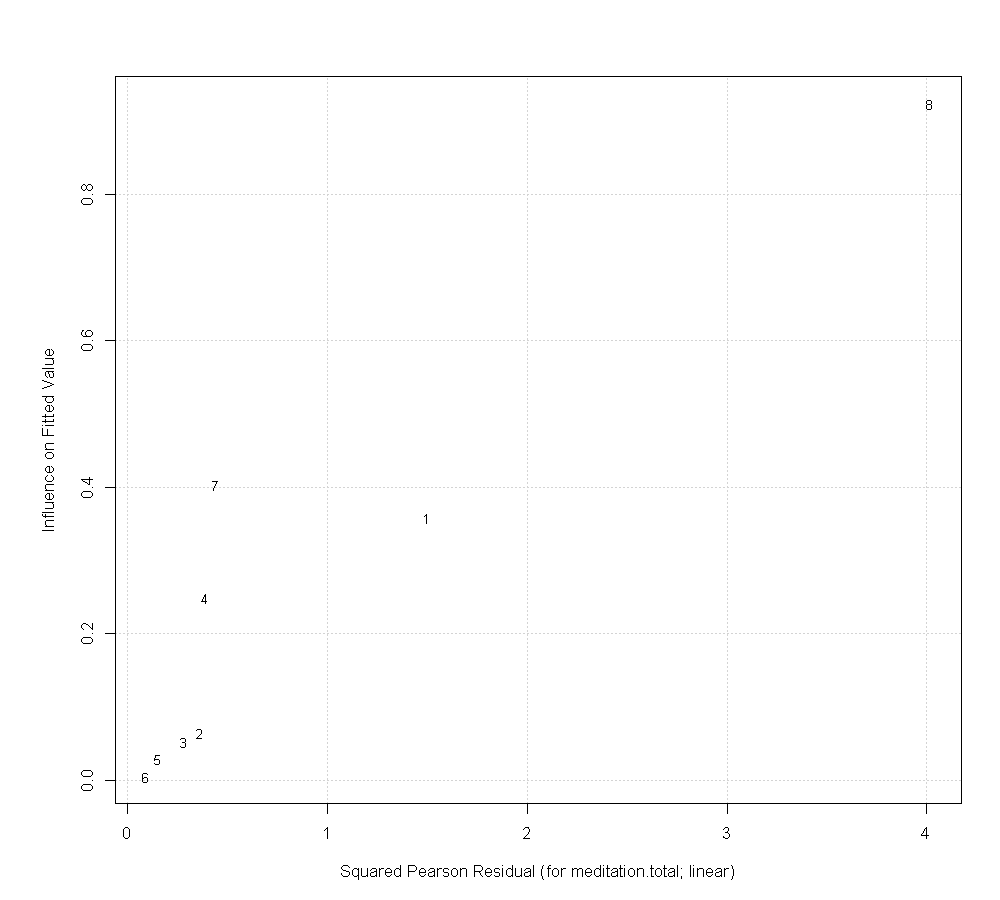

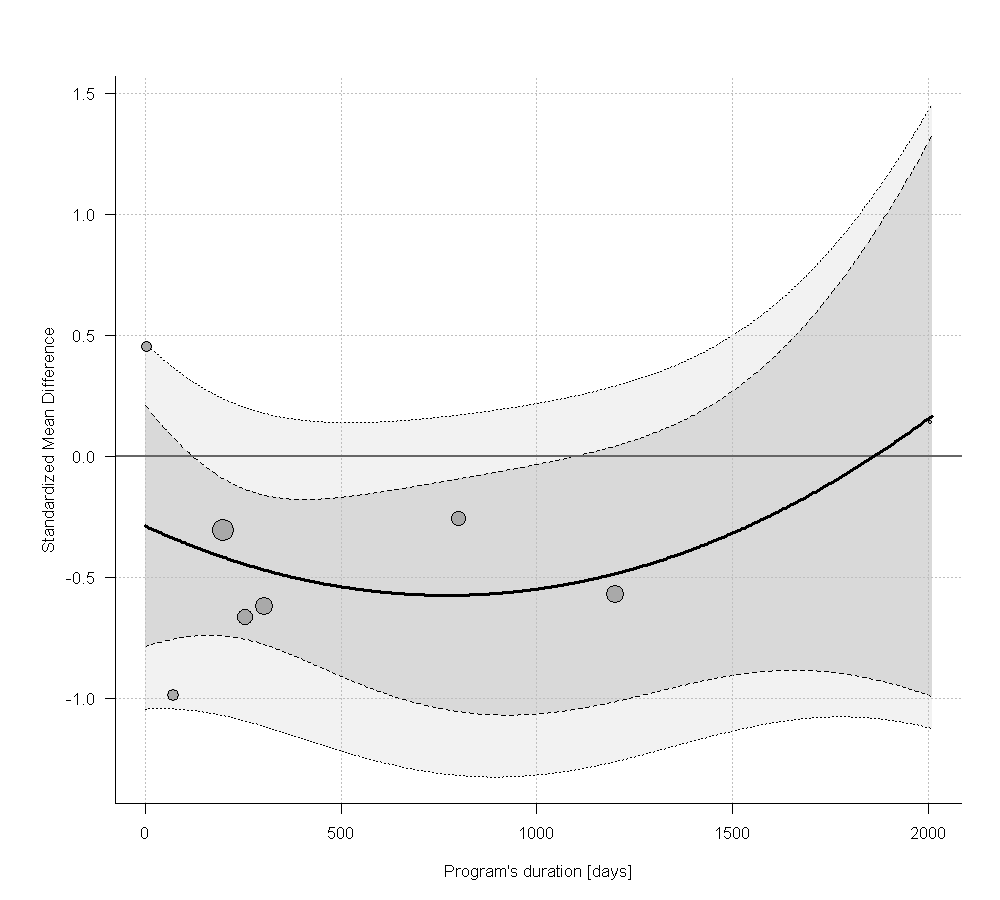

[1] "meditation.total"
[1] "Linear"

Mixed-Effects Model (k = 8; tau^2 estimator: REML)

tau^2 (estimated amount of residual heterogeneity):     0.0853 (SE = 0.0898)
tau (square root of estimated tau^2 value):             0.2921
I^2 (residual heterogeneity / unaccounted variability): 56.67%
H^2 (unaccounted variability / sampling variability):   2.31
R^2 (amount of heterogeneity accounted for):            0.00%

Test for Residual Heterogeneity:
QE(df = 6) = 13.4748, p-val = 0.0361

Test of Moderators (coefficient 2):
QM(df = 1) = 0.1271, p-val = 0.7215

Model Results:

                  estimate      se     zval    pval    ci.lb    ci.ub    
intrcpt            -0.4574  0.1979  -2.3108  0.0208  -0.8453  -0.0694  * 
meditation.total    0.0001  0.0003   0.3565  0.7215  -0.0004   0.0006    

---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1


[1] "Polynomial"

Mixed-Effects Model (k = 8; tau^2 estimator: REML)

tau^2 (estimated amount of residual heterogeneity):     0.0843

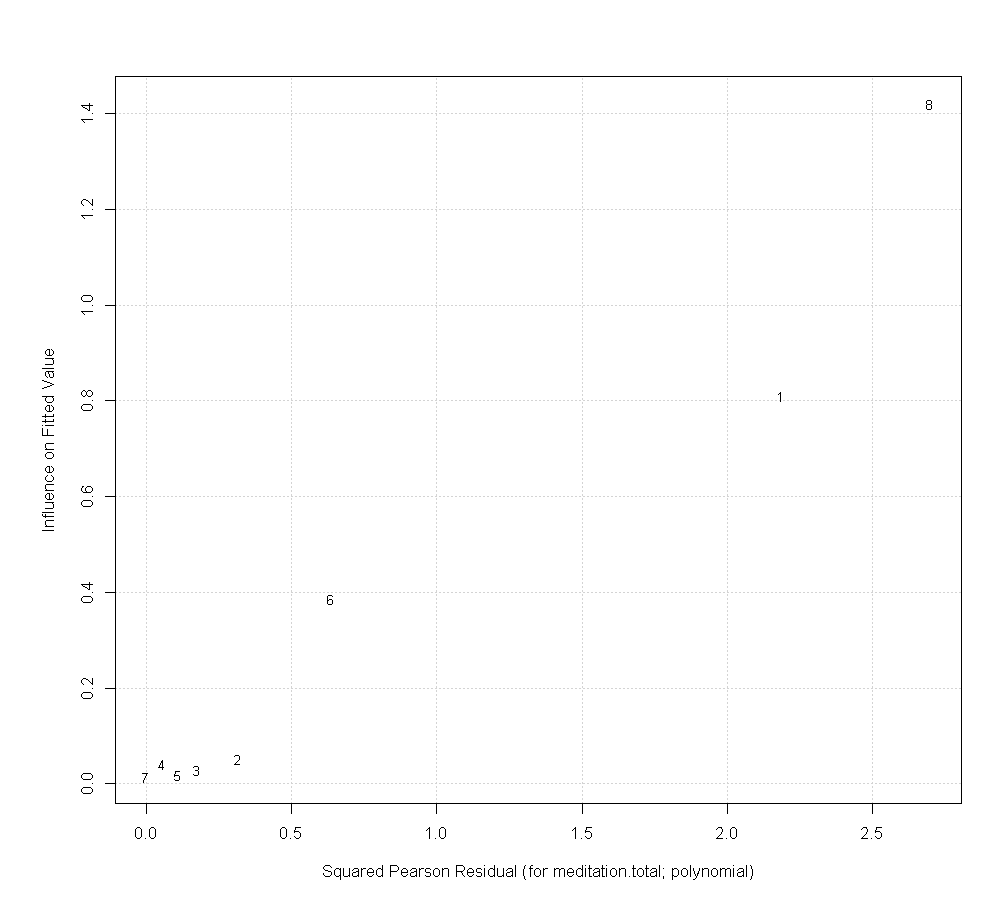

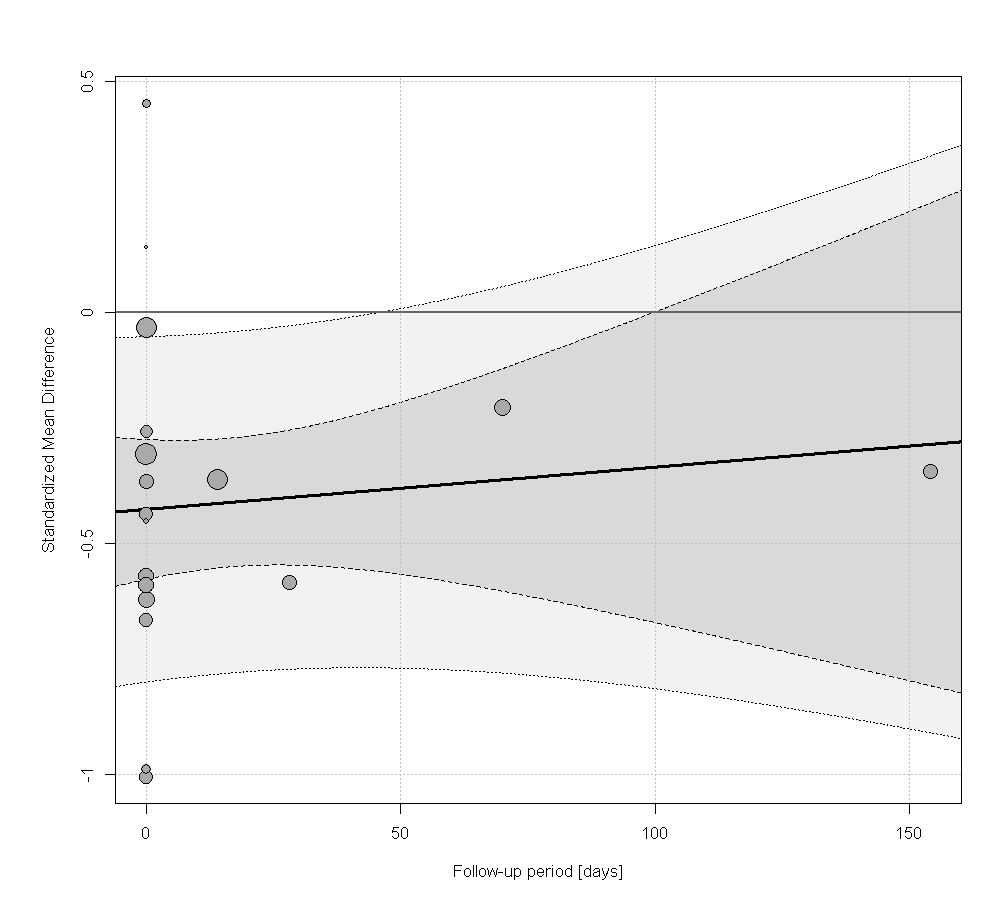

[1] "follow.up.period"
[1] "Linear"

Mixed-Effects Model (k = 18; tau^2 estimator: REML)

tau^2 (estimated amount of residual heterogeneity):     0.0305 (SE = 0.0307)
tau (square root of estimated tau^2 value):             0.1746
I^2 (residual heterogeneity / unaccounted variability): 35.24%
H^2 (unaccounted variability / sampling variability):   1.54
R^2 (amount of heterogeneity accounted for):            0.00%

Test for Residual Heterogeneity:
QE(df = 16) = 26.0976, p-val = 0.0527

Test of Moderators (coefficient 2):
QM(df = 1) = 0.2406, p-val = 0.6238

Model Results:

                  estimate      se     zval    pval    ci.lb    ci.ub      
intrcpt            -0.4266  0.0773  -5.5206  <.0001  -0.5780  -0.2751  *** 
follow.up.period    0.0009  0.0019   0.4905  0.6238  -0.0027   0.0046      

---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1


[1] "Polynomial"

Mixed-Effects Model (k = 8; tau^2 estimator: REML)

tau^2 (estimated amount of residual heterogeneity):   

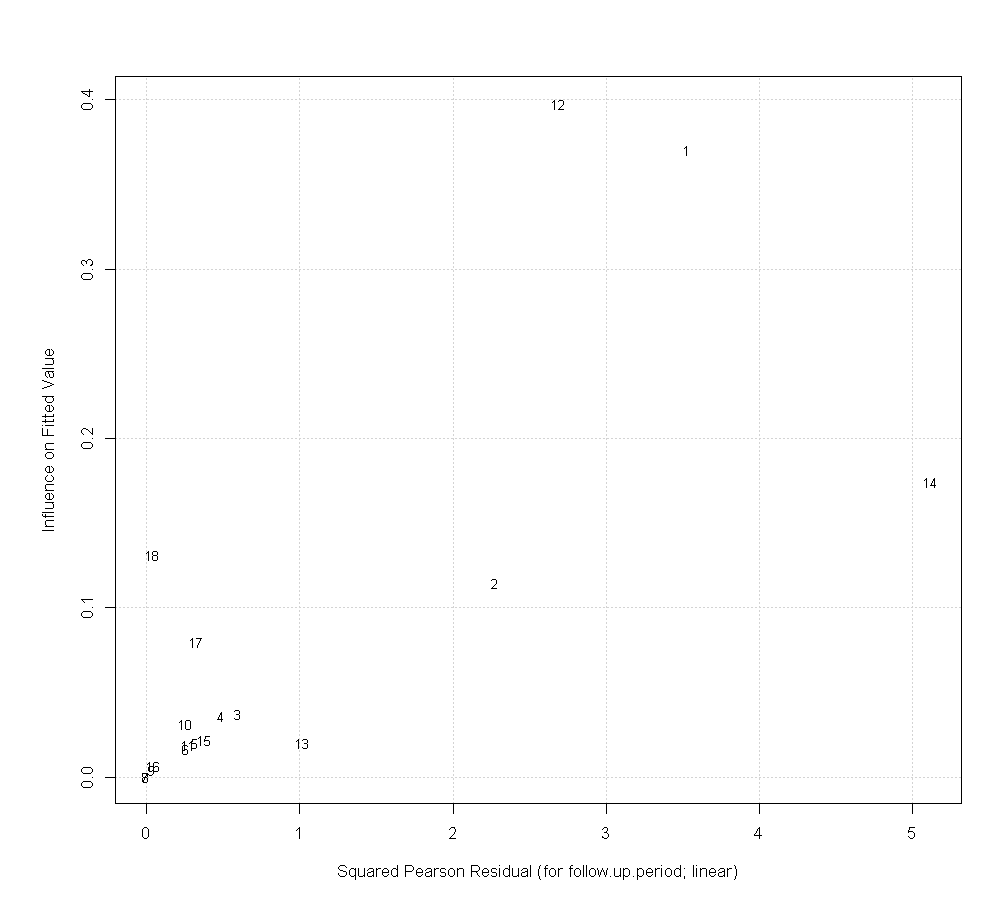

[1] "delivery.mode"
[1] "Linear"

Mixed-Effects Model (k = 14; tau^2 estimator: REML)

tau^2 (estimated amount of residual heterogeneity):     0.0621 (SE = 0.0522)
tau (square root of estimated tau^2 value):             0.2492
I^2 (residual heterogeneity / unaccounted variability): 50.32%
H^2 (unaccounted variability / sampling variability):   2.01
R^2 (amount of heterogeneity accounted for):            0.00%

Test for Residual Heterogeneity:
QE(df = 12) = 24.3588, p-val = 0.0182

Test of Moderators (coefficient 2):
QM(df = 1) = 0.1497, p-val = 0.6988

Model Results:

                                  estimate      se     zval    pval    ci.lb 
intrcpt                            -0.4151  0.1056  -3.9320  <.0001  -0.6219 
delivery.modesynchronous guiding   -0.1044  0.2697  -0.3869  0.6988  -0.6330 
                                    ci.ub      
intrcpt                           -0.2082  *** 
delivery.modesynchronous guiding   0.4243      

---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*

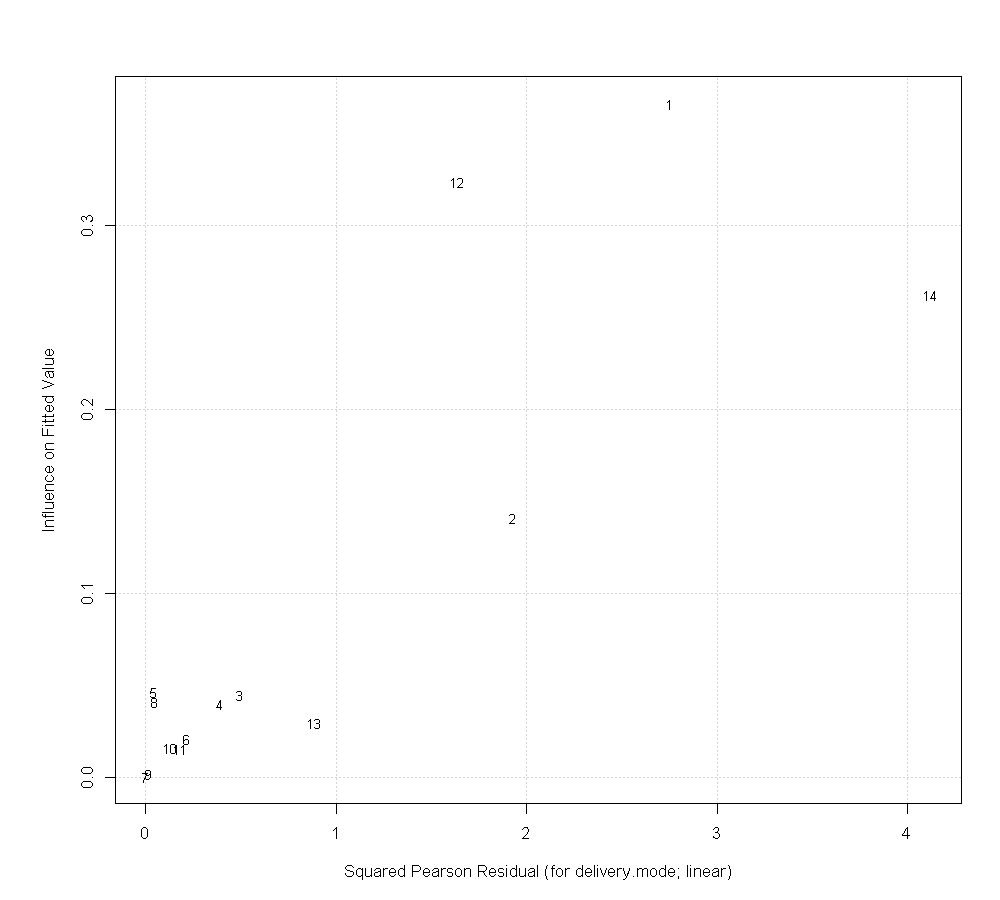

[1] "meditation.type"
[1] "Linear"

Mixed-Effects Model (k = 14; tau^2 estimator: REML)

tau^2 (estimated amount of residual heterogeneity):     0.0902 (SE = 0.0727)
tau (square root of estimated tau^2 value):             0.3003
I^2 (residual heterogeneity / unaccounted variability): 58.00%
H^2 (unaccounted variability / sampling variability):   2.38
R^2 (amount of heterogeneity accounted for):            0.00%

Test for Residual Heterogeneity:
QE(df = 10) = 23.5295, p-val = 0.0090

Test of Moderators (coefficients 2:4):
QM(df = 3) = 0.5066, p-val = 0.9174

Model Results:

                                      estimate      se     zval    pval 
intrcpt                                -0.3719  0.1405  -2.6459  0.0081 
meditation.typeconstructive family     -0.2204  0.4057  -0.5432  0.5870 
meditation.typedeconstructive family   -0.0662  0.4222  -0.1568  0.8754 
meditation.typehybrid form             -0.1410  0.2541  -0.5552  0.5788 
                                        ci.lb    ci.ub 

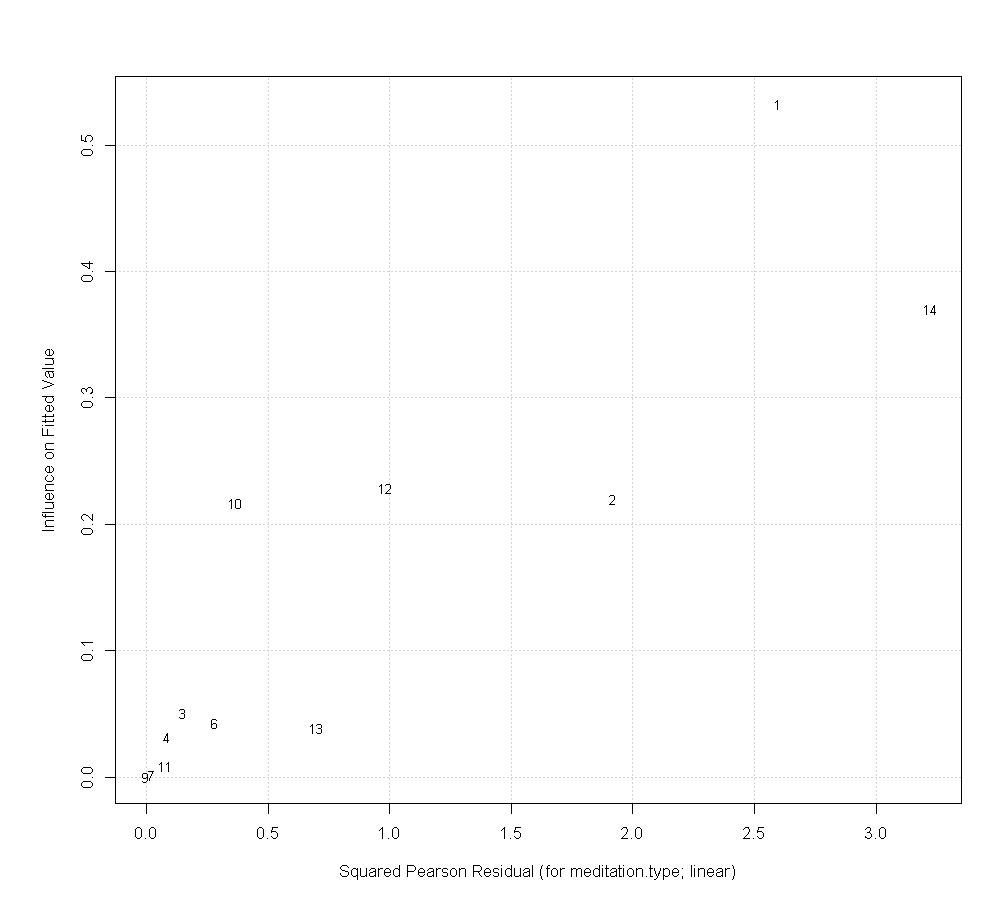

In [104]:
results.metafor.stress.dass <- print.meta.results("Stress", preferred.scale = "DASS", return.data = "results.metafor")

In [518]:
results.meta.stress.dass <- print.meta.results(
    "Stress", preferred.scale = "DASS",
    regression = F, print.forest = F, print.funnel = F, print.influence = F, print.baujat = F, split.subgroups = F, print.forest.sub.single = F, print.meta.results = F,
    return.data = "results.meta"
)
results.meta.stress.dass$k
results.meta.stress.dass$n.e.pooled
results.meta.stress.dass$n.c.pooled
results.meta.stress.dass$n.e.pooled + results.meta.stress.dass$n.c.pooled


# Stress ----------------------------------


[1] 14

[1] 472

[1] 516

[1] 988

In [ ]:
# exclude high RoB studies
print.meta.results("Stress", preferred.scale = "DASS", exclude.high.rob.vec = studies.high.rob)  # is same for PSS


# Stress ----------------------------------
Number of studies combined: k = 11
Number of observations: o = 732

                         SMD             95%-CI     z  p-value
Common effect model  -0.4775 [-0.6253; -0.3297] -6.33 < 0.0001
Random effects model -0.4775 [-0.6253; -0.3297] -6.33 < 0.0001

Quantifying heterogeneity:
 tau^2 = 0 [0.0000; 0.1058]; tau = 0 [0.0000; 0.3252]
 I^2 = 0.0% [0.0%; 60.2%]; H = 1.00 [1.00; 1.59]

Test of heterogeneity:
    Q d.f. p-value
 7.16   10  0.7106

Details on meta-analytical method:
- Inverse variance method
- Restricted maximum-likelihood estimator for tau^2
- Q-Profile method for confidence interval of tau^2 and tau
- Hedges' g (bias corrected standardised mean difference; using exact formulae)

# Subgroup Analysis: delivery.mode 
Number of studies combined: k = 11
Number of observations: o = 732

                         SMD             95%-CI     z  p-value
Common effect model  -0.4775 [-0.6253; -0.3297] -6.33 < 0.0001
Random effects model

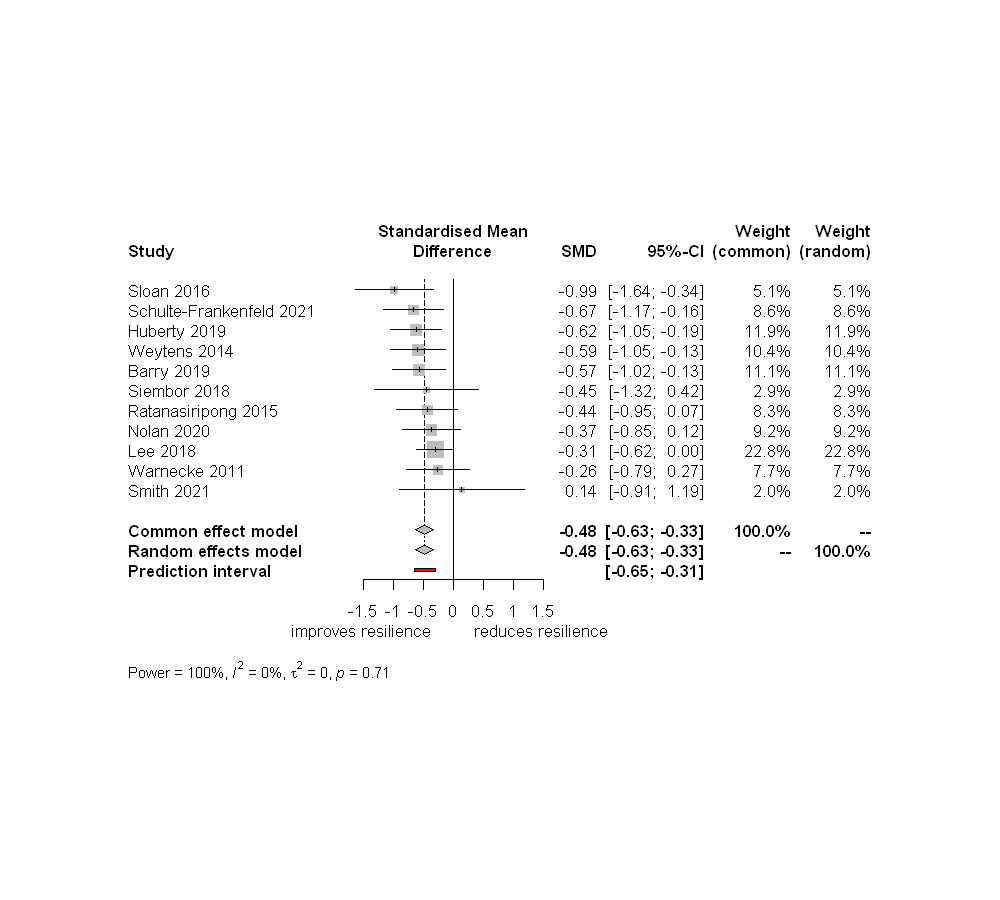


# Subgroup Analysis: meditation.type 
Number of studies combined: k = 11
Number of observations: o = 732

                         SMD             95%-CI     z  p-value
Common effect model  -0.4775 [-0.6253; -0.3297] -6.33 < 0.0001
Random effects model -0.4775 [-0.6253; -0.3297] -6.33 < 0.0001

Quantifying heterogeneity:
 tau^2 = 0 [0.0000; 0.1058]; tau = 0 [0.0000; 0.3252]
 I^2 = 0.0% [0.0%; 60.2%]; H = 1.00 [1.00; 1.59]

Test of heterogeneity:
    Q d.f. p-value
 7.16   10  0.7106

Results for subgroups (common effect model):
                                   k     SMD             95%-CI    Q  I^2
subgroup = Attentional Family      6 -0.4687 [-0.7081; -0.2293] 4.75 0.0%
subgroup = hybrid form             3 -0.4653 [-0.6900; -0.2405] 2.13 6.0%
subgroup = Constructive Family     1 -0.5922 [-1.0510; -0.1335] 0.00   --
subgroup = Deconstructive Family   1 -0.4381 [-0.9508;  0.0747] 0.00   --

Test for subgroup differences (common effect model):
                  Q d.f. p-value
Between 

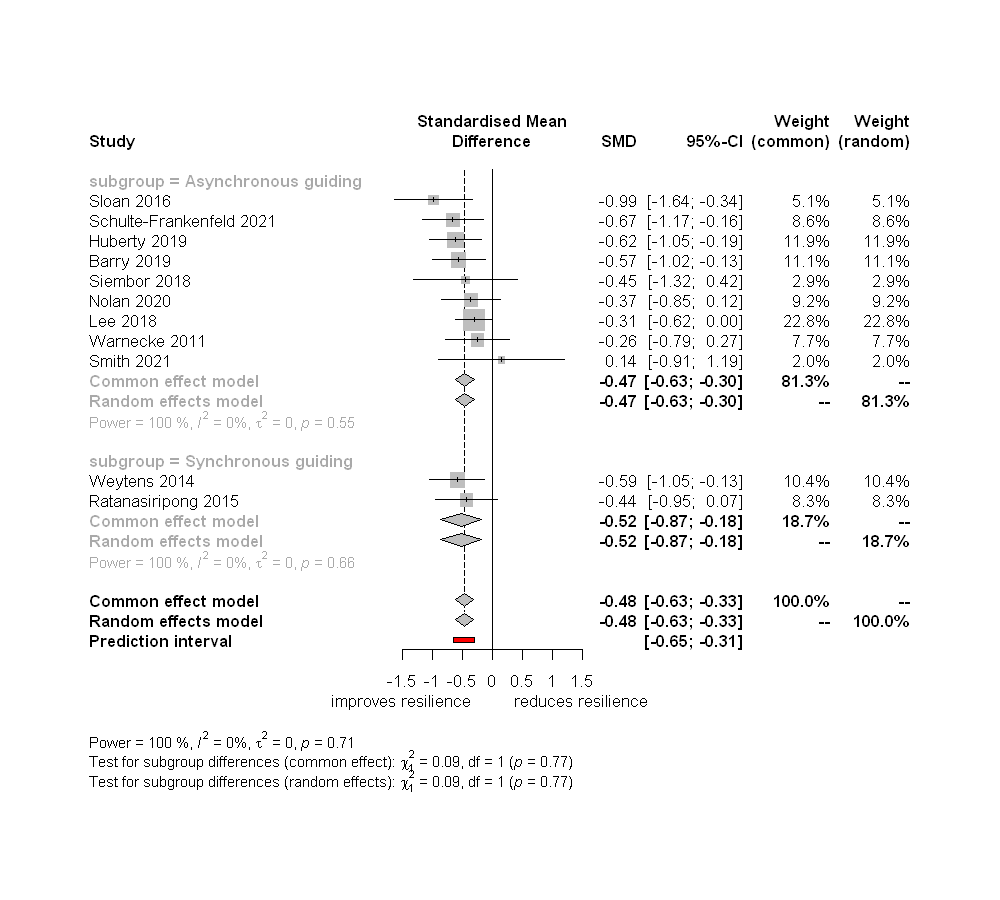

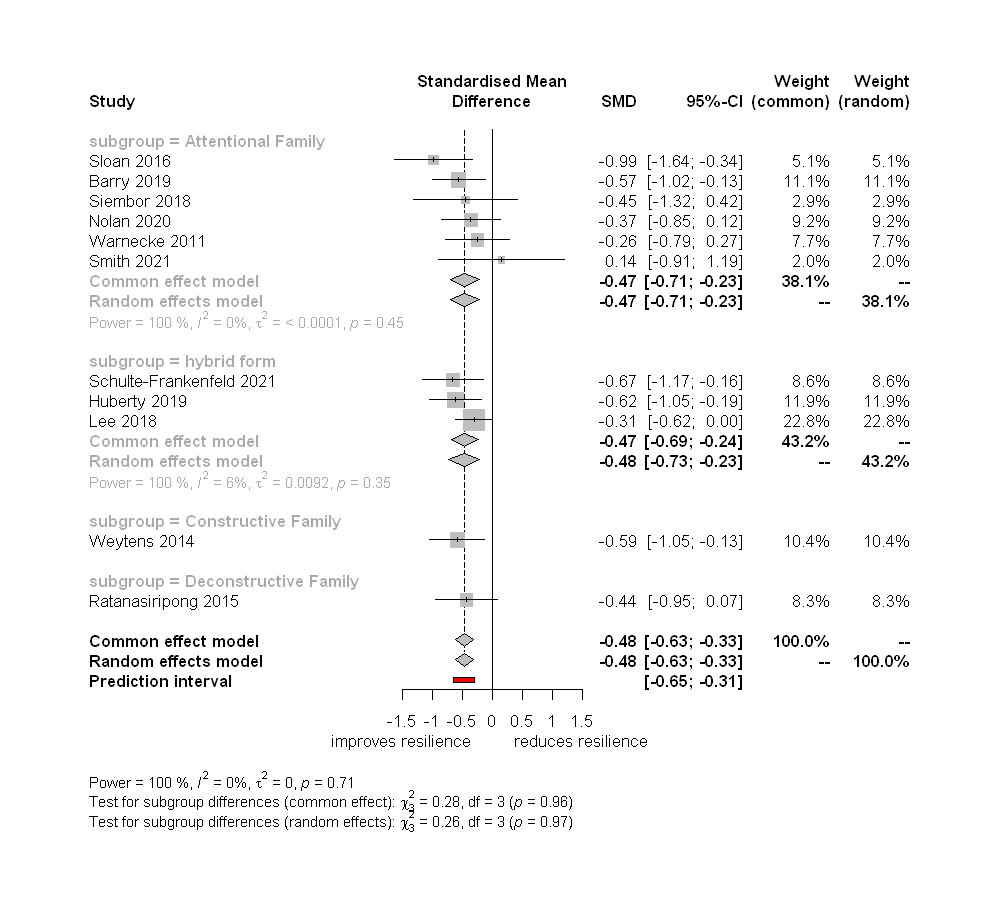


Regression Test for Funnel Plot Asymmetry

Model:     mixed-effects meta-regression model
Predictor: standard error

Test for Funnel Plot Asymmetry: z = -0.1569, p = 0.8753
Limit Estimate (as sei -> 0):   b = -0.4383 (CI: -0.9544, 0.0778)



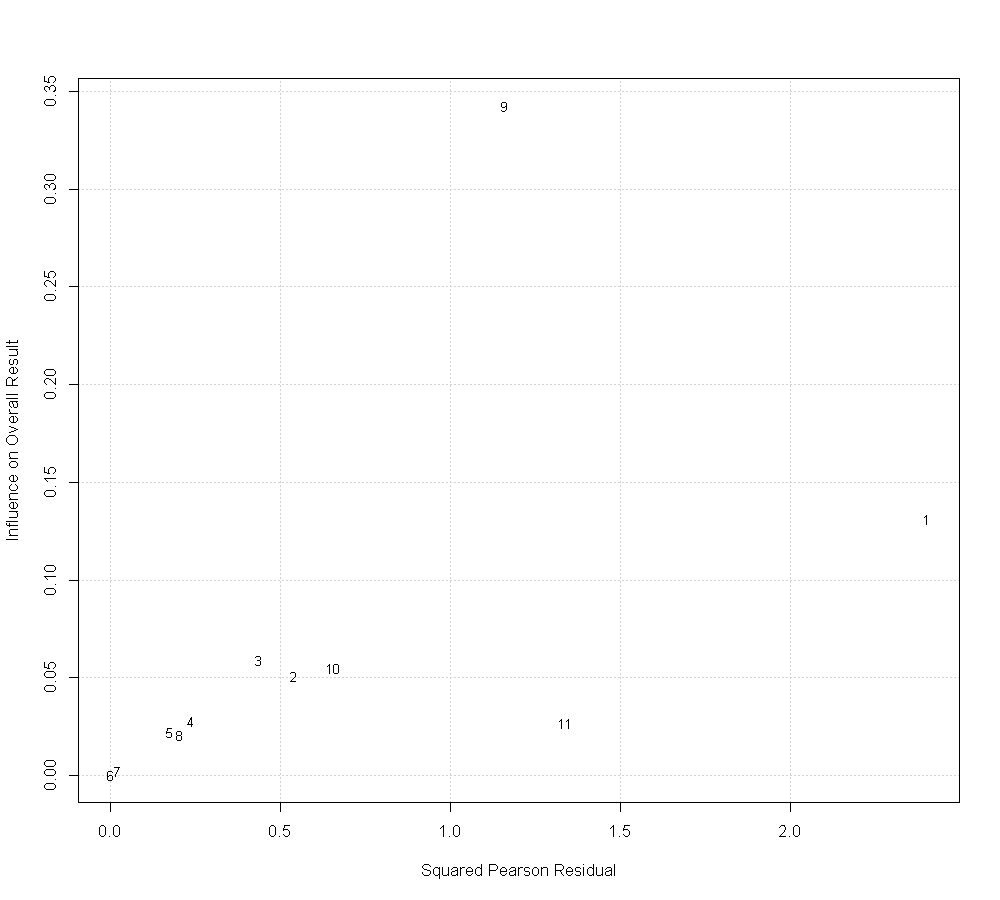

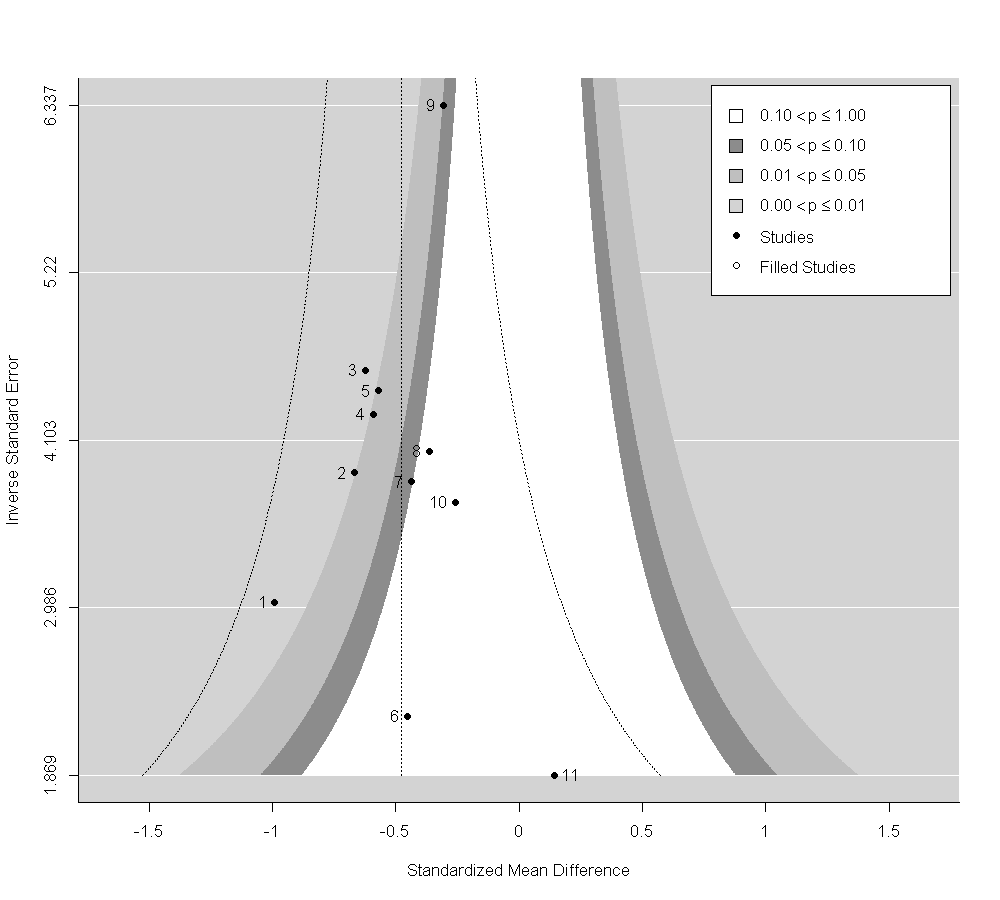

In [283]:
# without outliers of Stress (DASS) + gosh plots (for regression)
print.meta.results(
  "Stress", preferred.scale = "DASS", basic = T, filter.forest..funnel.vec = -c(1, 12, 14),
  filter.regression.linear.list = list(-c(10), -c(11), -c(1), -c(1, 12, 14), "", ""),
  filter.regression.poly.list = list(-c(1, 10), -c(11), -c(1), -c(1, 12, 14), "", ""),
  regression = T, split.subgroups = T, print.influence = F, print.baujat.regression = F, print.gosh.regression = F
)

# order of regression filter
# "sessions.duration":1, "sessions.frequency":2, "programs.duration":3, "follow.up.period":4, "delivery.mode":5, "meditation.type":6

In [ ]:
# without outliers of Stress (DASS) + gosh plots (for regression)   ###### copy for flag.x.s.r = 1 #####
print.meta.results(
  "Stress", preferred.scale = "DASS", basic = F, filter.forest..funnel.vec = -c(1, 12, 14),
  filter.regression.linear.list = list(c(""), -c(10), -c(1), -c(1, 11, 13), "", ""),
  filter.regression.poly.list = list(c(""), -c(10), -c(1), -c(11, 13), "", ""),
  regression = T, split.subgroups = F, print.influence = F, print.baujat.regression = F, print.gosh.regression = T
)

# order of regression filter
# "sessions.duration":1, "sessions.frequency":2, "programs.duration":3, "follow.up.period":4, "delivery.mode":5, "meditation.type":6

Fitting 16383 models (based on all possible subsets).



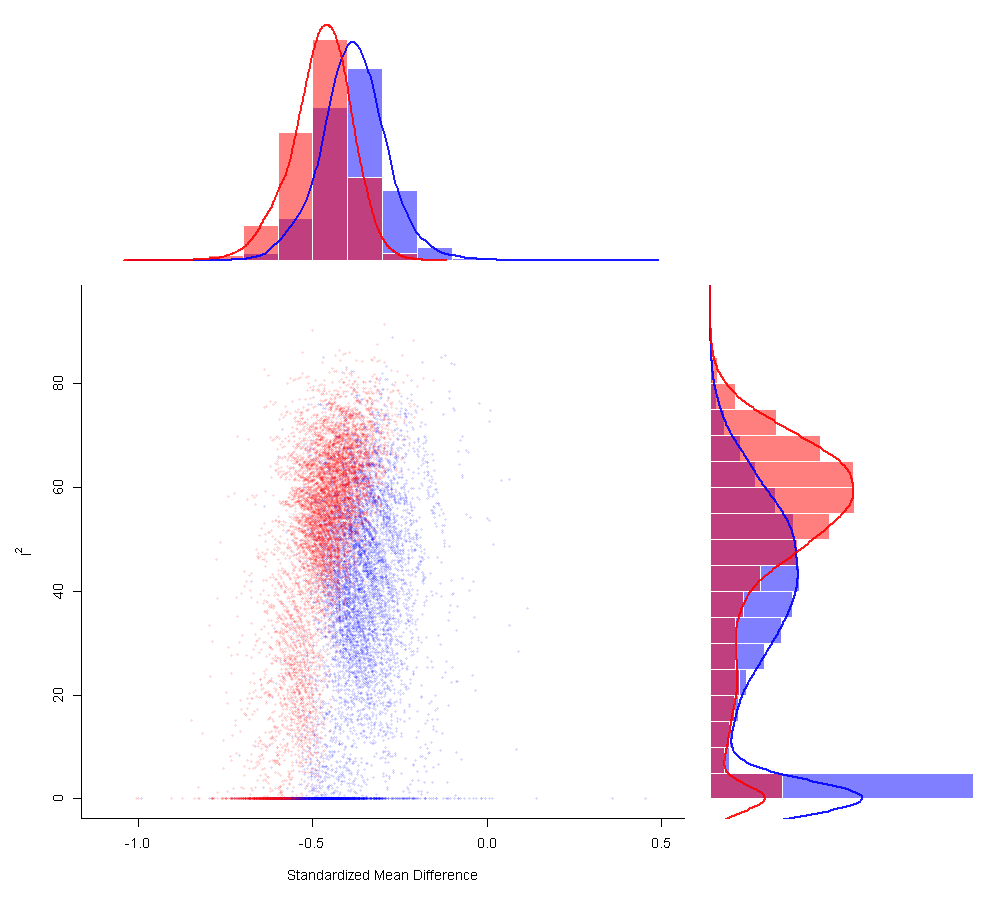

In [105]:
sav <- gosh(results.metafor.stress.dass)
plot(sav, out = 1)

Fitting 16383 models (based on all possible subsets).



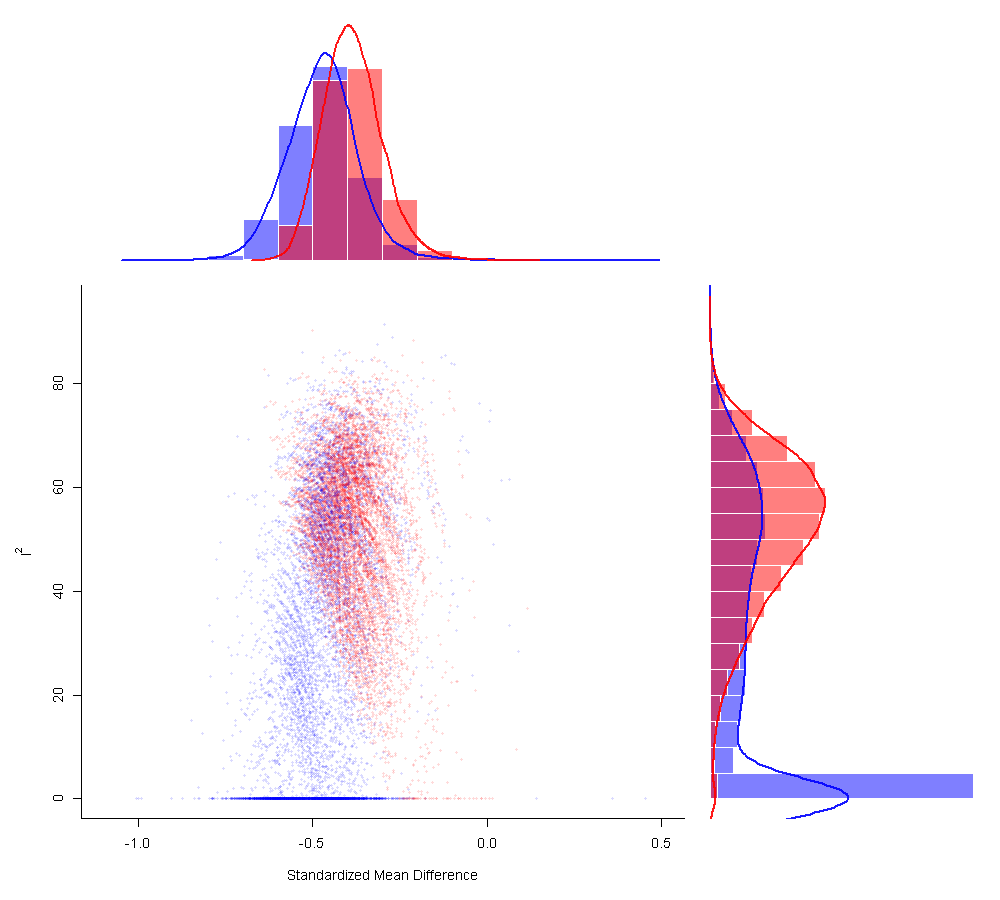

In [106]:
sav <- gosh(results.metafor.stress.dass)
plot(sav, out = 12)

Fitting 16383 models (based on all possible subsets).



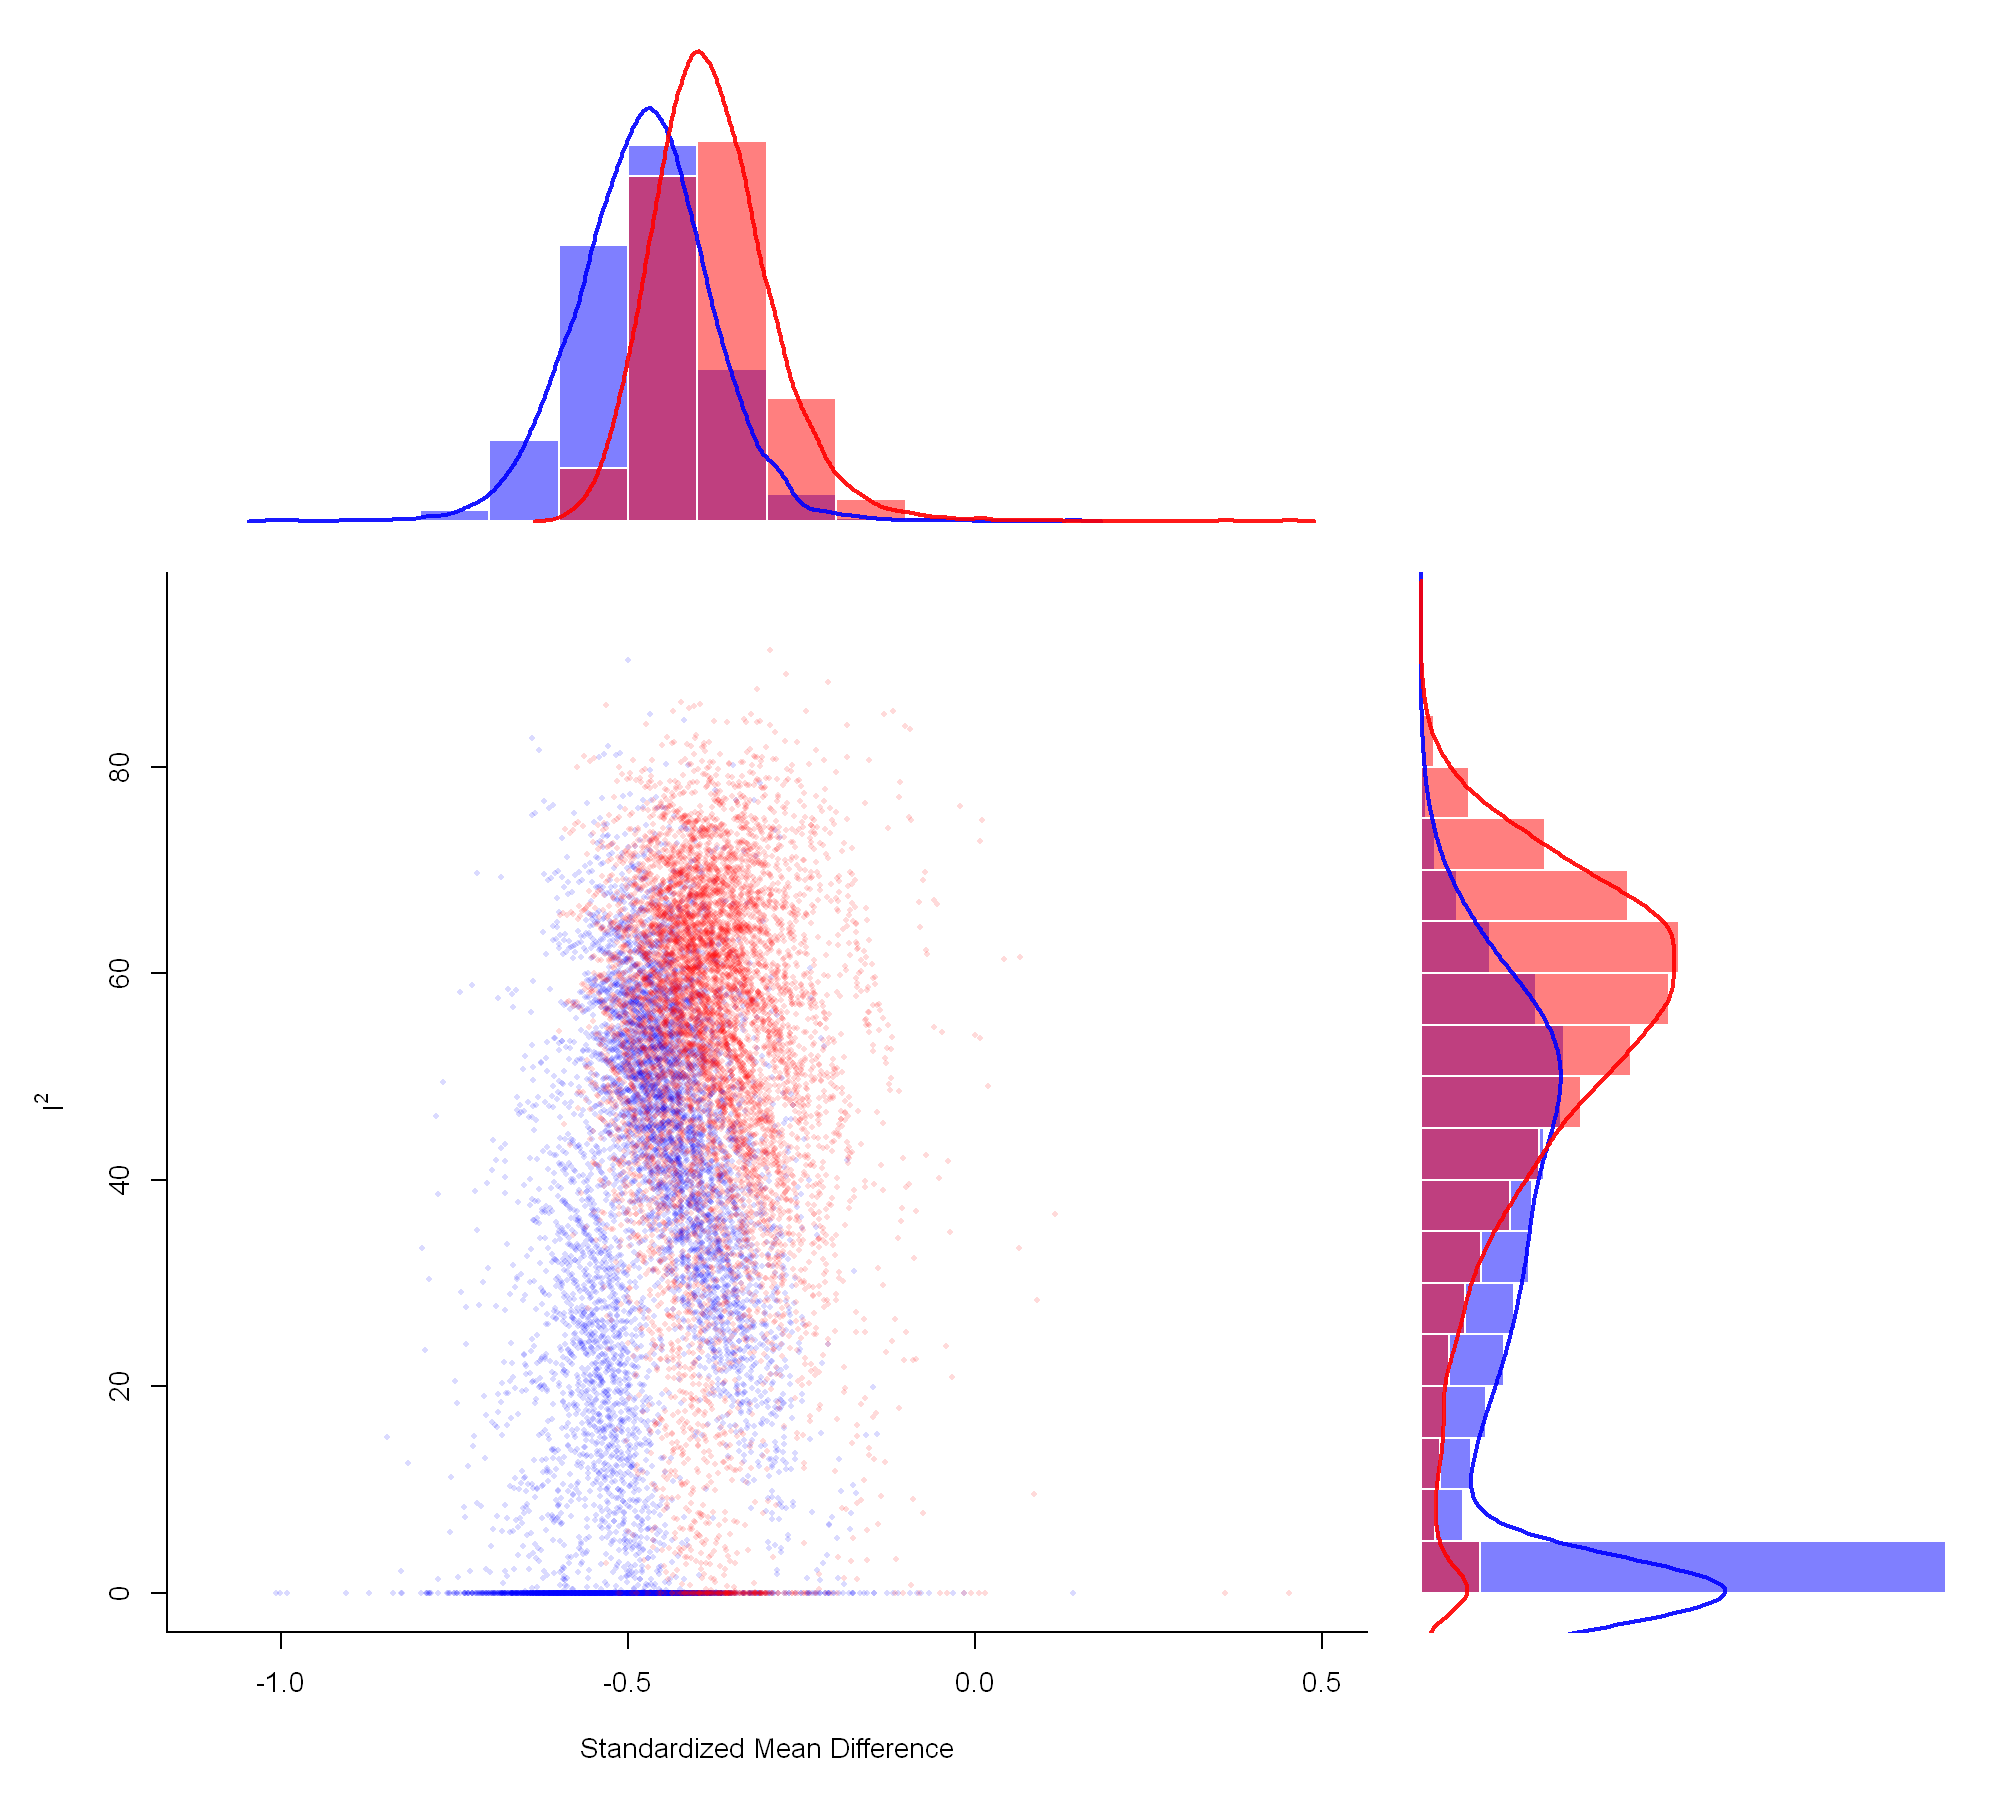

In [110]:
sav <- gosh(results.metafor.stress.dass)
plot(sav, out = 14)

Fitting 16383 models (based on all possible subsets).

Fitting 16383 models (based on all possible subsets).

Fitting 16383 models (based on all possible subsets).



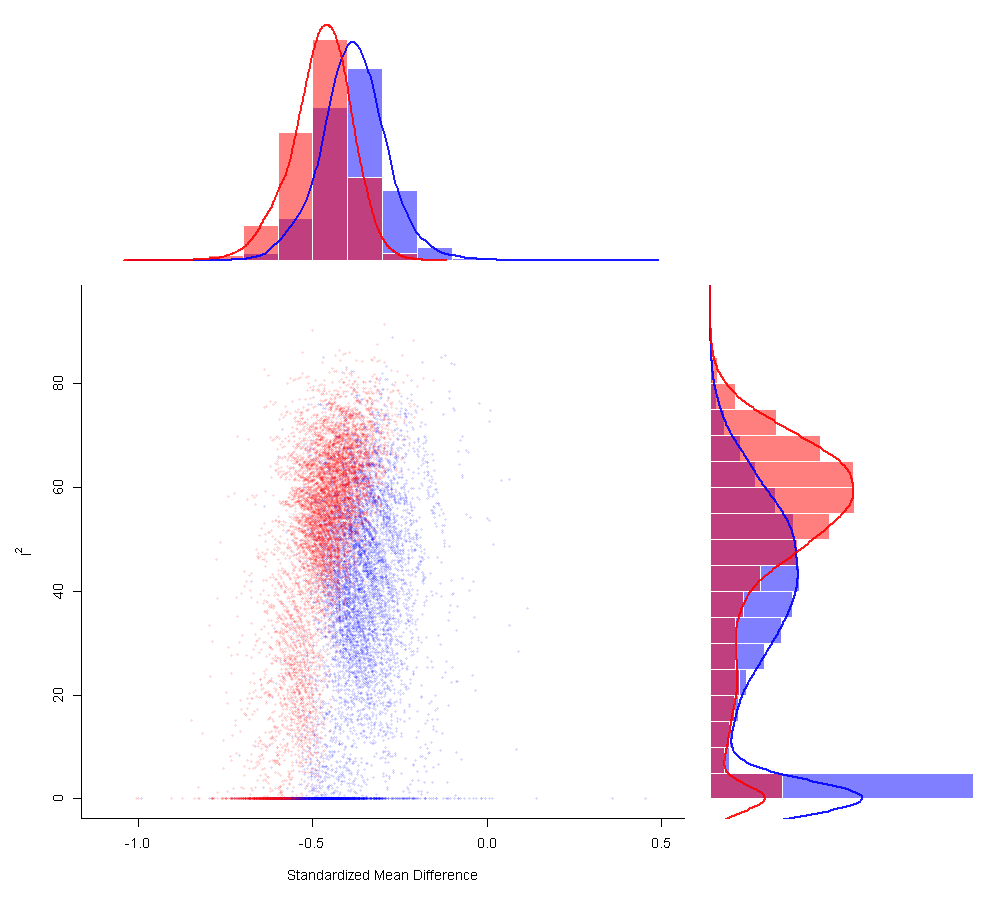

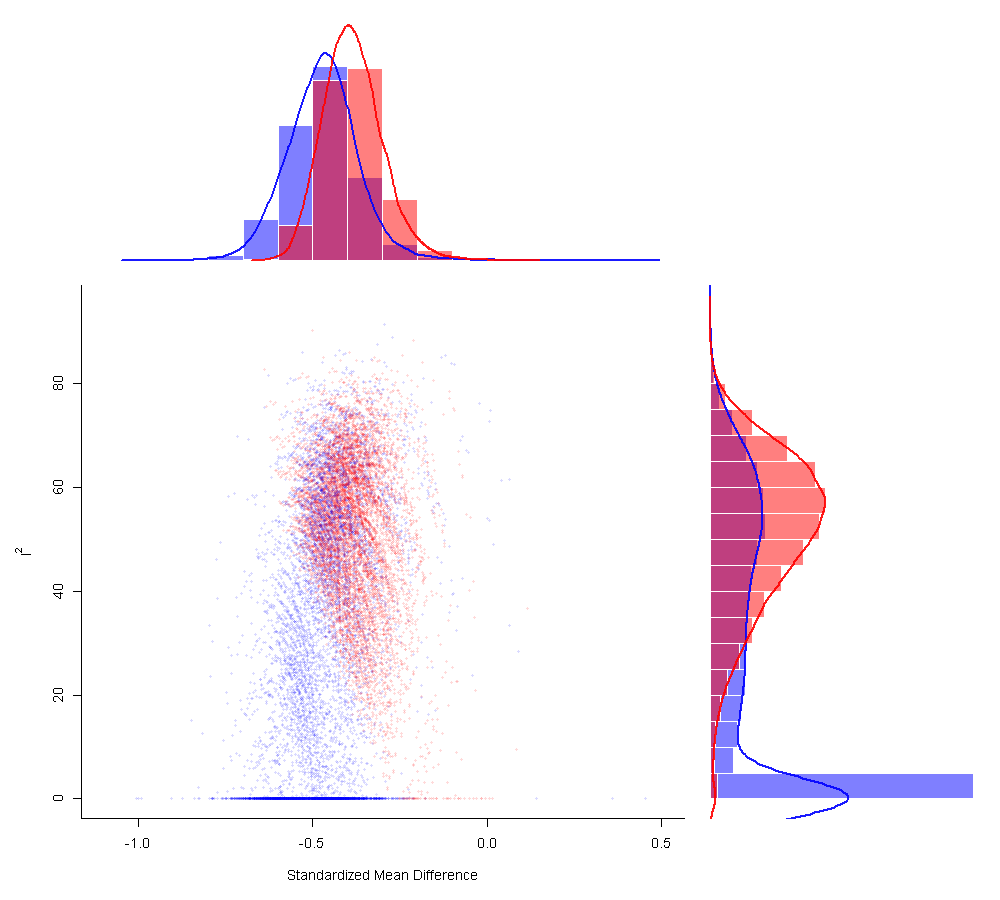

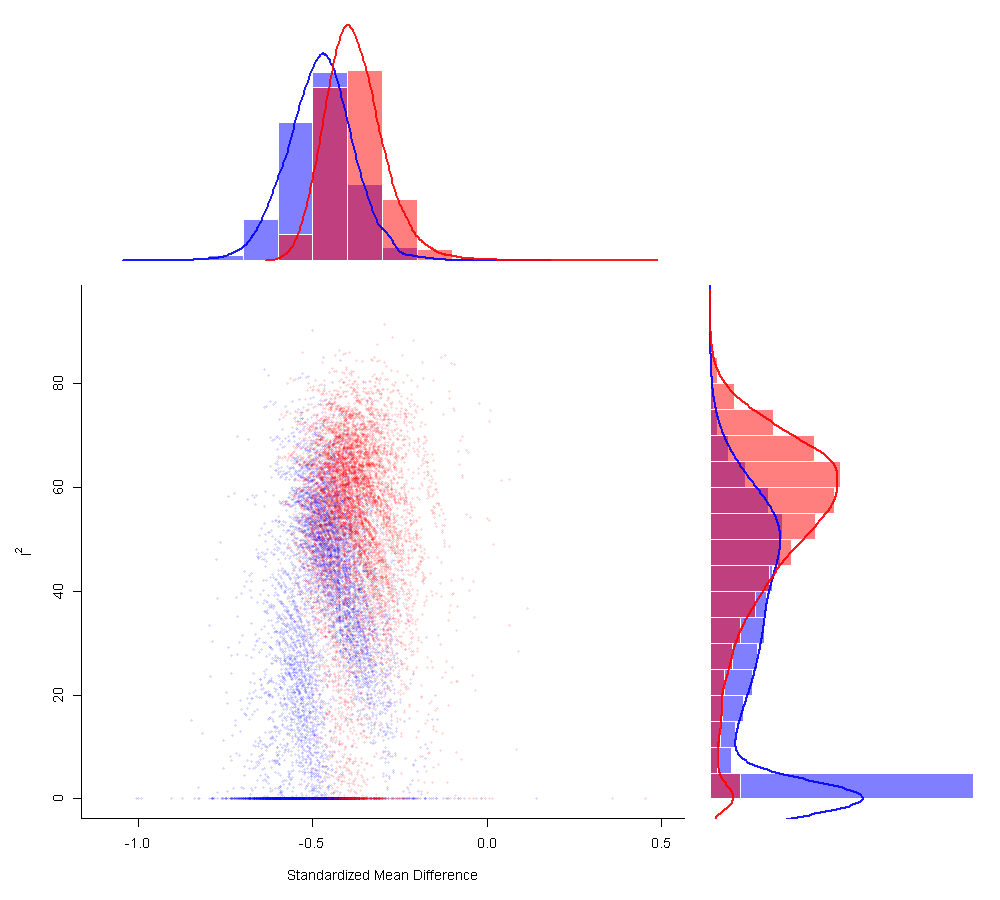

In [281]:
# # gosh plots for forest plots
# for (outlier in c(1, 12, 14)){
#   sav <- gosh(results.metafor.stress.dass)
#   plot(sav, out = outlier)
# }

In [ ]:
# gosh plots for regression (only for programs duration as one wasnt printed above)
print.meta.results(
  "Stress", preferred.scale = "DASS",
  filter.regression.linear.list = list("", "", -c(1), "", "", ""),
  filter.regression.poly.list = list("", "", -c(1), "", "", ""),
  basic = F, regression = T, print.baujat.regression = F,
  print.regplot = F, print.regression.results = F,
  print.gosh.regression = T
)

In [ ]:
# multiple regressions without interaction
options(repr.plot.width = 12, repr.plot.height = 9, repr.plot.res = 100)
print.meta.results(
  outcome = "Stress", preferred.scale = "DASS", basic = F, regression = F, regression.multiple = T, regression.multiple.degree.2 = F,
  moderator.multiple.list = list(
    c("programs.duration", "sessions.duration"), c("programs.duration", "sessions.frequency"),
    c("sessions.duration", "programs.duration"), c("sessions.duration", "sessions.frequency"),
    c("sessions.frequency", "programs.duration"), c("sessions.frequency", "sessions.duration"),
    c("sessions.frequency", "programs.duration", "sessions.duration")
  )
)
# "sessions.duration":1, "sessions.frequency":2, "programs.duration":3, "follow.up.period":4, "delivery.mode":5, "meditation.type":6
options(repr.plot.width = 10, repr.plot.height = 9, repr.plot.res = 100)

In [ ]:
# multiple regressions without interaction (without outliers)

options(repr.plot.width = 12, repr.plot.height = 9, repr.plot.res = 100)

print.meta.results(
  outcome = "Stress", preferred.scale = "DASS", basic = F, regression = F, regression.multiple = T, regression.multiple.degree.2 = F,
  print.gosh.regression = F, print.baujat.regression = F,
  moderator.multiple.list = list(
                                                  c("programs.duration", "sessions.duration"), c("programs.duration", "sessions.frequency"),
    c("sessions.duration", "programs.duration"),                                               c("sessions.duration", "sessions.frequency"),
    c("sessions.frequency", "programs.duration"), c("sessions.frequency", "sessions.duration"),
    c("sessions.frequency", "programs.duration", "sessions.duration")
    
  ),
  filter.multiple.regression.linear.list = list(
                -c(1),   -c(10, 7),
    -c(1),               -c(9),
    -c(10, 7), -c(9),
    -c(5)
  )
)

options(repr.plot.width = 10, repr.plot.height = 9, repr.plot.res = 100)

In [ ]:
# multiple regressions without interaction (without outliers)  ##### copy for without mean ranges #####

options(repr.plot.width = 12, repr.plot.height = 9, repr.plot.res = 100)

print.meta.results(
  outcome = "Stress", preferred.scale = "DASS", basic = F, regression = F, regression.multiple = T, regression.multiple.degree.2 = F,
  print.gosh.regression = T, print.baujat.regression = F,
  moderator.multiple.list = list(
                                                  c("programs.duration", "sessions.duration"), c("programs.duration", "sessions.frequency"),
    c("sessions.duration", "programs.duration"),                                               c("sessions.duration", "sessions.frequency"),
    c("sessions.frequency", "programs.duration"), c("sessions.frequency", "sessions.duration"),
    c("sessions.frequency", "programs.duration", "sessions.duration")
    
  ),
  filter.multiple.regression.linear.list = list(
              -c(1, 7), "",
    -c(1, 7),            -c(1,7),
    "",       -c(1,7),
    ""
  )
)

options(repr.plot.width = 10, repr.plot.height = 9, repr.plot.res = 100)

In [ ]:
# print gosh plot separately, as it came to an error within do.multiple.regression()
moderator.multiple.list = list(
                                                c("programs.duration", "sessions.duration"), c("programs.duration", "sessions.frequency"),
  c("sessions.duration", "programs.duration"),                                               c("sessions.duration", "sessions.frequency"),
  c("sessions.frequency", "programs.duration"), c("sessions.frequency", "sessions.duration")
)

filter.multiple.regression.linear.list = list(
              -c(1),   -c(10, 7),
  -c(1),               -c(9),
  -c(10, 7), -c(9)
)

mod.comb.no <- 1
for (moderator.combination in moderator.multiple.list){
    
  regression.df <- meta.analyze(
    "Stress", meditation.type.all, m.data.list, preferred.scale = "DASS",
    split.subgroups = FALSE, return.data = "regression.all"
  )

  # cut out data after post-test (that have follow.up.period > 0) if follow.up.period is not in moderator.combination
  if (!"follow.up.period" %in% moderator.combination){
    regression.df <- regression.df[
      which(regression.df[,"follow.up.period"] == 0),
    ]
  }

  # eliminate NAs
  regression.df <- regression.df %>%
    filter(!(
      is.na(!!sym(moderator.combination[1])) |
      !!sym(moderator.combination[1]) %in% c("NA", nm.placeholder, as.character(nm.placeholder)) |
      is.na(!!sym(moderator.combination[2])) |
      !!sym(moderator.combination[2]) %in% c("NA", nm.placeholder, as.character(nm.placeholder))
  ))
  
  if (
    is.list(filter.multiple.regression.linear.list) &
    if(is.list(filter.multiple.regression.linear.list)){filter.multiple.regression.linear.list[[mod.comb.no]][1] != ""}else{FALSE}
  ){

    for (outlier in -filter.multiple.regression.linear.list[[mod.comb.no]]){

      results.regression.linear.unfiltered <- get.results.metafor(
        regression.df, moderator = moderator.combination
      )

      cat("\n Gosh plot for", paste(moderator.combination, sep = ", "), "(outlier number:", outlier, "linear)")
      sav <- gosh(results.regression.linear.unfiltered, subsets = 15000)
      plot(sav, out = outlier)
    }
  } else {
    cat("\nno Gosh plot printed for", moderator.combination, "(linear)\n")
  }
  mod.comb.no <- mod.comb.no+1
}

In [ ]:
# multiple regression with interaction (no outliers detected)

options(repr.plot.width = 12, repr.plot.height = 9, repr.plot.res = 100)

print.meta.results(
  outcome = "Stress", preferred.scale = "DASS", basic = F, regression = F, regression.multiple = T, regression.multiple.degree.2 = F,
  non.interaction = F, interaction = T,
  moderator.multiple.list = list(
    c("programs.duration", "sessions.duration"), c("programs.duration", "sessions.frequency"),
    c("sessions.duration", "programs.duration"), c("sessions.duration", "sessions.frequency"),
    c("sessions.frequency", "programs.duration"), c("sessions.frequency", "sessions.duration"),
    c("sessions.frequency", "programs.duration", "sessions.duration")
  )
)

options(repr.plot.width = 10, repr.plot.height = 9, repr.plot.res = 100)
# "sessions.duration":1, "sessions.frequency":2, "programs.duration":3, "follow.up.period":4, "delivery.mode":5, "meditation.type":6

##### PSS as preferred scale

In [ ]:
results.metafor.stress.pss <- print.meta.results("Stress", preferred.scale = "PSS", return.data = "results.metafor")

In [ ]:
# without outliers of Stress (PSS) + gosh plots (for regression)
print.meta.results(
  "Stress", preferred.scale = "PSS", basic = F, filter.forest..funnel.vec = -c(1, 12, 14),
  filter.regression.linear.list = list(-c(1, 10), -c(11), -c(1), -c(1, 12, 14), "", ""),
  filter.regression.poly.list = list(-c(1, 10), -c(11), -c(1), -c(1, 12, 14), "", ""),
  regression = T, split.subgroups = F, print.influence = F, print.baujat.regression = F, print.gosh.regression = T
)

# order of regression filter
# "sessions.duration":1, "sessions.frequency":2, "programs.duration":3, "follow.up.period":4, "delivery.mode":5, "meditation.type":6

In [ ]:
# without outliers of Stress (PSS) + gosh plots (for regression)  ###### copy for flag.x.s.r = 1 #####
print.meta.results(
  "Stress", preferred.scale = "PSS", basic = F, filter.forest..funnel.vec = -c(1, 12, 14),
  filter.regression.linear.list = list("", -c(10), -c(1), -c(1, 11, 13), "", ""),
  filter.regression.poly.list = list("", -c(10), -c(1), -c(1, 11, 13), "", ""),
  regression = T, split.subgroups = F, print.influence = F, print.baujat.regression = F, print.gosh.regression = T
)

# order of regression filter
# "sessions.duration":1, "sessions.frequency":2, "programs.duration":3, "follow.up.period":4, "delivery.mode":5, "meditation.type":6

In [ ]:
for (outlier in c(1, 12, 14)){
  sav <- gosh(results.metafor.stress.pss)
  plot(sav, out = outlier)
}

In [ ]:
# multiple regressions without interaction
print.meta.results(
  outcome = "Stress", preferred.scale = "PSS", basic = F, regression = F, regression.multiple = T, regression.multiple.degree.2 = F,
  moderator.multiple.list = list(
    c("programs.duration", "sessions.duration"), c("programs.duration", "sessions.frequency"),
    c("sessions.duration", "programs.duration"), c("sessions.duration", "sessions.frequency"),
    c("sessions.frequency", "programs.duration"), c("sessions.frequency", "sessions.duration"),
    c("sessions.frequency", "programs.duration", "sessions.duration")
  )
)
# "sessions.duration":1, "sessions.frequency":2, "programs.duration":3, "follow.up.period":4, "delivery.mode":5, "meditation.type":6

In [ ]:
# multiple regressions without interaction (without outliers)

options(repr.plot.width = 12, repr.plot.height = 9, repr.plot.res = 100)

print.meta.results(
  outcome = "Stress", preferred.scale = "PSS", basic = F, regression = F, regression.multiple = T, regression.multiple.degree.2 = F,
  print.gosh.regression = F, print.baujat.regression = F,
  moderator.multiple.list = list(
                                                  c("programs.duration", "sessions.duration"), c("programs.duration", "sessions.frequency"),
    c("sessions.duration", "programs.duration"),                                               c("sessions.duration", "sessions.frequency"),
    c("sessions.frequency", "programs.duration"), c("sessions.frequency", "sessions.duration"),
    c("sessions.frequency", "programs.duration", "sessions.duration")
    
  ),
  filter.multiple.regression.linear.list = list(
                -c(1),   -c(10, 7),
    -c(1),               -c(9),
    -c(10, 7), -c(9),
    -c(5, 8)
  )
)

options(repr.plot.width = 10, repr.plot.height = 9, repr.plot.res = 100)

In [ ]:
# print gosh plot separately, as it came to an error within do.multiple.regression()
moderator.multiple.list = list(
                                                c("programs.duration", "sessions.duration"), c("programs.duration", "sessions.frequency"),
  c("sessions.duration", "programs.duration"),                                               c("sessions.duration", "sessions.frequency"),
  c("sessions.frequency", "programs.duration"), c("sessions.frequency", "sessions.duration")
)

filter.multiple.regression.linear.list = list(
              -c(1),   -c(10, 7),
  -c(1),               -c(9),
  -c(10, 7), -c(9)
)

mod.comb.no <- 1
for (moderator.combination in moderator.multiple.list){
    
  regression.df <- meta.analyze(
    "Stress", meditation.type.all, m.data.list, preferred.scale = "PSS",
    split.subgroups = FALSE, return.data = "regression.all"
  )

  # cut out data after post-test (that have follow.up.period > 0) if follow.up.period is not in moderator.combination
  if (!"follow.up.period" %in% moderator.combination){
    regression.df <- regression.df[
      which(regression.df[,"follow.up.period"] == 0),
    ]
  }

  # eliminate NAs
  regression.df <- regression.df %>%
    filter(!(
      is.na(!!sym(moderator.combination[1])) |
      !!sym(moderator.combination[1]) %in% c("NA", nm.placeholder, as.character(nm.placeholder)) |
      is.na(!!sym(moderator.combination[2])) |
      !!sym(moderator.combination[2]) %in% c("NA", nm.placeholder, as.character(nm.placeholder))
  ))
  
  if (
    is.list(filter.multiple.regression.linear.list) &
    if(is.list(filter.multiple.regression.linear.list)){filter.multiple.regression.linear.list[[mod.comb.no]][1] != ""}else{FALSE}
  ){

    for (outlier in -filter.multiple.regression.linear.list[[mod.comb.no]]){

      results.regression.linear.unfiltered <- get.results.metafor(
        regression.df, moderator = moderator.combination
      )

      cat("\n Gosh plot for", paste(moderator.combination, sep = ", "), "(outlier number:", outlier, "linear)")
      sav <- gosh(results.regression.linear.unfiltered, subsets = 15000)
      plot(sav, out = outlier)
    }
  } else {
    cat("\nno Gosh plot printed for", moderator.combination, "(linear)\n")
  }
  mod.comb.no <- mod.comb.no+1
}

In [ ]:
# multiple regression with interaction (no outliers detected)

options(repr.plot.width = 12, repr.plot.height = 9, repr.plot.res = 100)

print.meta.results(
  outcome = "Stress", preferred.scale = "PSS", basic = F, regression = F, regression.multiple = T, regression.multiple.degree.2 = F,
  non.interaction = F, interaction = T,
  moderator.multiple.list = list(
    c("programs.duration", "sessions.duration"), c("programs.duration", "sessions.frequency"),
    c("sessions.duration", "programs.duration"), c("sessions.duration", "sessions.frequency"),
    c("sessions.frequency", "programs.duration"), c("sessions.frequency", "sessions.duration"),
    c("sessions.frequency", "programs.duration", "sessions.duration")
  )
)

options(repr.plot.width = 10, repr.plot.height = 9, repr.plot.res = 100)
# "sessions.duration":1, "sessions.frequency":2, "programs.duration":3, "follow.up.period":4, "delivery.mode":5, "meditation.type":6

#### Well-Being

In [ ]:
results.metafor.well.being <- print.meta.results("Well-being or quality of life", return.data = "results.metafor")

In [ ]:
print.meta.results("Well-being or quality of life", filter.forest..funnel.vec = -c(1), regression = F, split.subgroups = F, print.influence = F)

In [ ]:
for (outlier in c(1)){
  sav <- gosh(results.metafor.well.being)
  plot(sav, out = outlier)
}

### Resilience Factors

In [ ]:
print.meta.results("Acceptance")

In [ ]:
print.meta.results("Active coping")

In [ ]:
print.meta.results("Empathy")

In [ ]:
print.meta.results("Hope")

In [ ]:
print.meta.results("Mindfulness (state)")

In [ ]:
results.metfor.mindfulness.t <- print.meta.results("Mindfulness (trait)", return.data = "results.metafor")

In [ ]:
results.metfor.mindfulness.t.ex.rob <- print.meta.results("Mindfulness (trait)", exclude.high.rob.vec = studies.high.rob, return.data = "results.metafor")  # exclude Johnson-Waddell 2018 (No. 3)

In [ ]:
# exclude outlier
print.meta.results("Mindfulness (trait)", filter.forest..funnel.vec = -c(9), regression = F, split.subgroups = F, print.influence = F)

In [ ]:
for (outlier in c(9)){
  sav <- gosh(results.metfor.mindfulness.t)
  plot(sav, out = outlier)
}

In [ ]:
# exclude both
print.meta.results("Mindfulness (trait)", filter.forest..funnel.vec = -c(3, 9))

In [ ]:
for (outlier in c(8)){
  sav <- gosh(results.metfor.mindfulness.t.ex.rob)
  plot(sav, out = outlier)
}

In [ ]:
print.meta.results("Optimism or positive attributional style")

In [ ]:
print.meta.results("Positive emotion")

In [ ]:
print.meta.results("Religiosity or spirituality or religious coping")

In [ ]:
print.meta.results("Self-acceptance")

In [ ]:
print.meta.results("Self-compassion")

In [ ]:
print.meta.results("Self-efficacy")

In [ ]:
print.meta.results("Self-esteem")

### All Outcomes (Summary)

#### Without preset function (without outliers)

In [ ]:
# install.packages("tidyr")
# install.packages("gridExtra")
# install.packages("forcats")
# install.packages("tidyr")

In [187]:
# set plot size
options(repr.plot.width = 25, repr.plot.height = 9, repr.plot.res = 100)

In [192]:
# get total effect sizes and confidence intervals of all outcomes
outcomes <- c()
k <- c()
o <- c()  # total observations
o.i <- c()  # observations in intervention
o.c <- c()  # observations in control
te <- c()
ci.l <- c()
ci.u <- c()
I2 <- c()
pow <- c()

for (outcome in present.outcomes){
  outliers <- outlier.list[[outcome]]
  
  if (outcome == "Stress"){
    preferred.scale <- "PSS"
  } else {
    preferred.scale <- FALSE
  }
  results.meta <- meta.analyze(
    outcome = outcome, meditation.types = meditation.type.all, m.data.list = m.data.list,
    return.data = "results.meta", preferred.scale = preferred.scale, split.subgroups = FALSE,
    filter.forest..funnel.vec = if(length(outliers) == 0){FALSE}else{-outliers}    
  )
  if (results.meta$k > 0){
    outcomes <- append(outcomes, outcome)
    k <- append(
      k,
      print.meta.results(
        outcome, preferred.scale = preferred.scale,
        regression = F, print.forest = F, print.funnel = F, print.influence = F, print.baujat = F, split.subgroups = F, print.forest.sub.single = F, print.meta.results = F,
        return.data = "results.meta",
        filter.forest..funnel.vec = if(length(outliers) == 0){FALSE}else{-outliers} 
      )$k
    )
    o.i <- append(o.i, sum(results.meta$data[, "n.int"]))
    o.c <- append(o.c, sum(results.meta$data[, "n.control"]))
    o <- append(
      o, sum(results.meta$data[, "n.int"]) + sum(results.meta$data[, "n.control"])
    )
    te  <- append(te, results.meta$TE.random)
    ci.l  <- append(ci.l, results.meta$lower.random)
    ci.u <- append(ci.u, results.meta$upper.random)
    I2 <- append(I2, results.meta$I2)
    pow <- append(pow, results.meta$power)
  }
}

df.sum <- data.frame(
  outcomes = outcomes,
  k = k,
  o.i = o.i,
  o.c = o.c,
  o = o,
  te = te,
  ci.l = ci.l,
  ci.u = ci.u,
  I2 = I2,
  pow = pow
)

# correct scale  directions
for (outcome in df.sum[,"outcomes"]){
  if (outcome.direction.df[outcome.direction.df[,"Outcome"] == outcome, "High.or.low.means.resilient"] == "v"){
    df.sum[df.sum[,"outcomes"] == outcome, c("te", "ci.l", "ci.u")] <- -1 * df.sum[df.sum[,"outcomes"] == outcome, c("te", "ci.u", "ci.l")]
  }
}

# sort by te
df.sum <- arrange(df.sum, te)

# create col with I^2 is 0 instead of NA
df.sum$I2.trans <- df.sum$I2*100

df.sum[is.na(df.sum$I2.trans), "I2.trans"] <- 0

# roud values
df.sum[,c("o", "te", "ci.l", "ci.u", "I2", "I2.trans", "pow")] <- round(df.sum[,c("o", "te", "ci.l", "ci.u", "I2", "I2.trans", "pow")], 2)

# create col of strings with te an ci vaulues
df.sum$te.ci <- paste(
  as.character(df.sum$te), " (",
  as.character(df.sum$ci.l), ", ",
  as.character(df.sum$ci.u), ")",
  sep = ""
)

# create col of strings with observation and no. of studies
df.sum$o.k <- paste(
  as.character(df.sum$o), " (",
  as.character(df.sum$k), ")",
  sep = ""
)

# set band colours for table
df.sum$colour <- rep(c("white", "gray95"), nrow(df.sum) / 2)

# correct differece of order due to rounding in band coulor
df.sum[df.sum[,"outcomes"] == "Self-efficacy", "colour"] <- "white"
df.sum[df.sum[,"outcomes"] == "Self-compassion", "colour"] <- "gray95"
df.sum[df.sum[,"outcomes"] == "Mindfulness (trait)", "colour"] <- "white"
df.sum[df.sum[,"outcomes"] == "Depression (trait)", "colour"] <- "gray95"

# correct further band coulor
df.sum[df.sum[,"outcomes"] == "Self-efficacy", "colour"] <- "gray95"
df.sum[df.sum[,"outcomes"] == "Self-compassion", "colour"] <- "white"
df.sum[df.sum[,"outcomes"] == "Active Coping", "colour"] <- "white"

df.sum


# Stress ----------------------------------

# Anxiety (state) ----------------------------------

# Anxiety (trait) ----------------------------------

# Depression (trait) ----------------------------------

# Self-efficacy ----------------------------------

# Resilience Scale ----------------------------------

# Hope ----------------------------------

# Optimism or positive attributional style ----------------------------------

# Mindfulness (trait) ----------------------------------

# Well-being or quality of life ----------------------------------
no studies included for outcome: Acceptance 

no studies included for outcome: Religiosity or spirituality or religious coping 


# Positive emotion ----------------------------------

# Mindfulness (state) ----------------------------------

# Active Coping ----------------------------------

# Self-compassion ----------------------------------

# Self-acceptance ----------------------------------

# Empathy ----------------------

outcomes,k,o.i,o.c,o,te,ci.l,ci.u,I2,pow,I2.trans,te.ci,o.k,colour
<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>
Self-acceptance,1,9,14,23,-0.60,-1.46,0.26,NA,28.16,0.00,"-0.6 (-1.46, 0.26)",23 (1),white
Resilience Scale,2,58,56,114,-0.21,-1.21,0.79,0.82,20.13,82.28,"-0.21 (-1.21, 0.79)",114 (2),gray95
Empathy,2,256,214,470,0.13,-0.09,0.36,0.32,30.37,32.47,"0.13 (-0.09, 0.36)",470 (2),white
Optimism or positive attributional style,1,43,39,82,0.15,-0.29,0.58,NA,10.31,0.00,"0.15 (-0.29, 0.58)",82 (1),gray95
Depression (trait),4,141,158,299,0.23,0.00,0.46,0.00,50.22,0.00,"0.23 (0, 0.46)",299 (4),gray95
Active Coping,1,11,10,21,0.23,-0.63,1.09,NA,8.30,0.00,"0.23 (-0.63, 1.09)",21 (1),white
Mindfulness (trait),8,301,357,658,0.25,0.09,0.40,0.00,88.66,0.00,"0.25 (0.09, 0.4)",658 (8),white
Anxiety (trait),5,181,194,375,0.27,0.07,0.47,0.00,74.00,0.00,"0.27 (0.07, 0.47)",375 (5),gray95
Anxiety (state),2,106,117,223,0.30,0.03,0.56,0.00,59.20,0.00,"0.3 (0.03, 0.56)",223 (2),white


In [193]:
fun_color_range <- colorRampPalette(c("chartreuse4", "gold", "red"))  # Create color generating function
my_colors <- fun_color_range(20)
my_colors           

[1] "#458B00" "#589300" "#6C9B00" "#7FA300" "#93AB00" "#A6B300" "#BABB00"
 [8] "#CEC300" "#E1CB00" "#F5D300" "#FFCB00" "#FFB500" "#FF9E00" "#FF8700"
[15] "#FF7100" "#FF5A00" "#FF4300" "#FF2D00" "#FF1600" "#FF0000"

In [194]:
# found order of band colours in forest plot (incorrect because coping flexibility was renamed to active coping)
correct.order <- c(
  which(df.sum$outcomes == "Stress"),
  which(df.sum$outcomes == "Anxiety (state)"),
  which(df.sum$outcomes == "Anxiety (trait)"),
  which(df.sum$outcomes == "Depression (trait)"),
  which(df.sum$outcomes == "Self-efficacy"),
  which(df.sum$outcomes == "Resilience Scale"),
  which(df.sum$outcomes == "Hope"),
  which(df.sum$outcomes == "Optimism or positive attributional style"),
  which(df.sum$outcomes == "Mindfulness (trait)"),
  which(df.sum$outcomes == "Well-being or quality of life"),
  which(df.sum$outcomes == "Positive emotion"),
  which(df.sum$outcomes == "Mindfulness (state)"),
  which(df.sum$outcomes == "Active coping"),
  which(df.sum$outcomes == "Self-compassion"),
  which(df.sum$outcomes == "Self-acceptance"),
  which(df.sum$outcomes == "Empathy")
)
correct.order

[1] 13  9  8  5 11  2 15  4  7 10 14 16 12  1  3

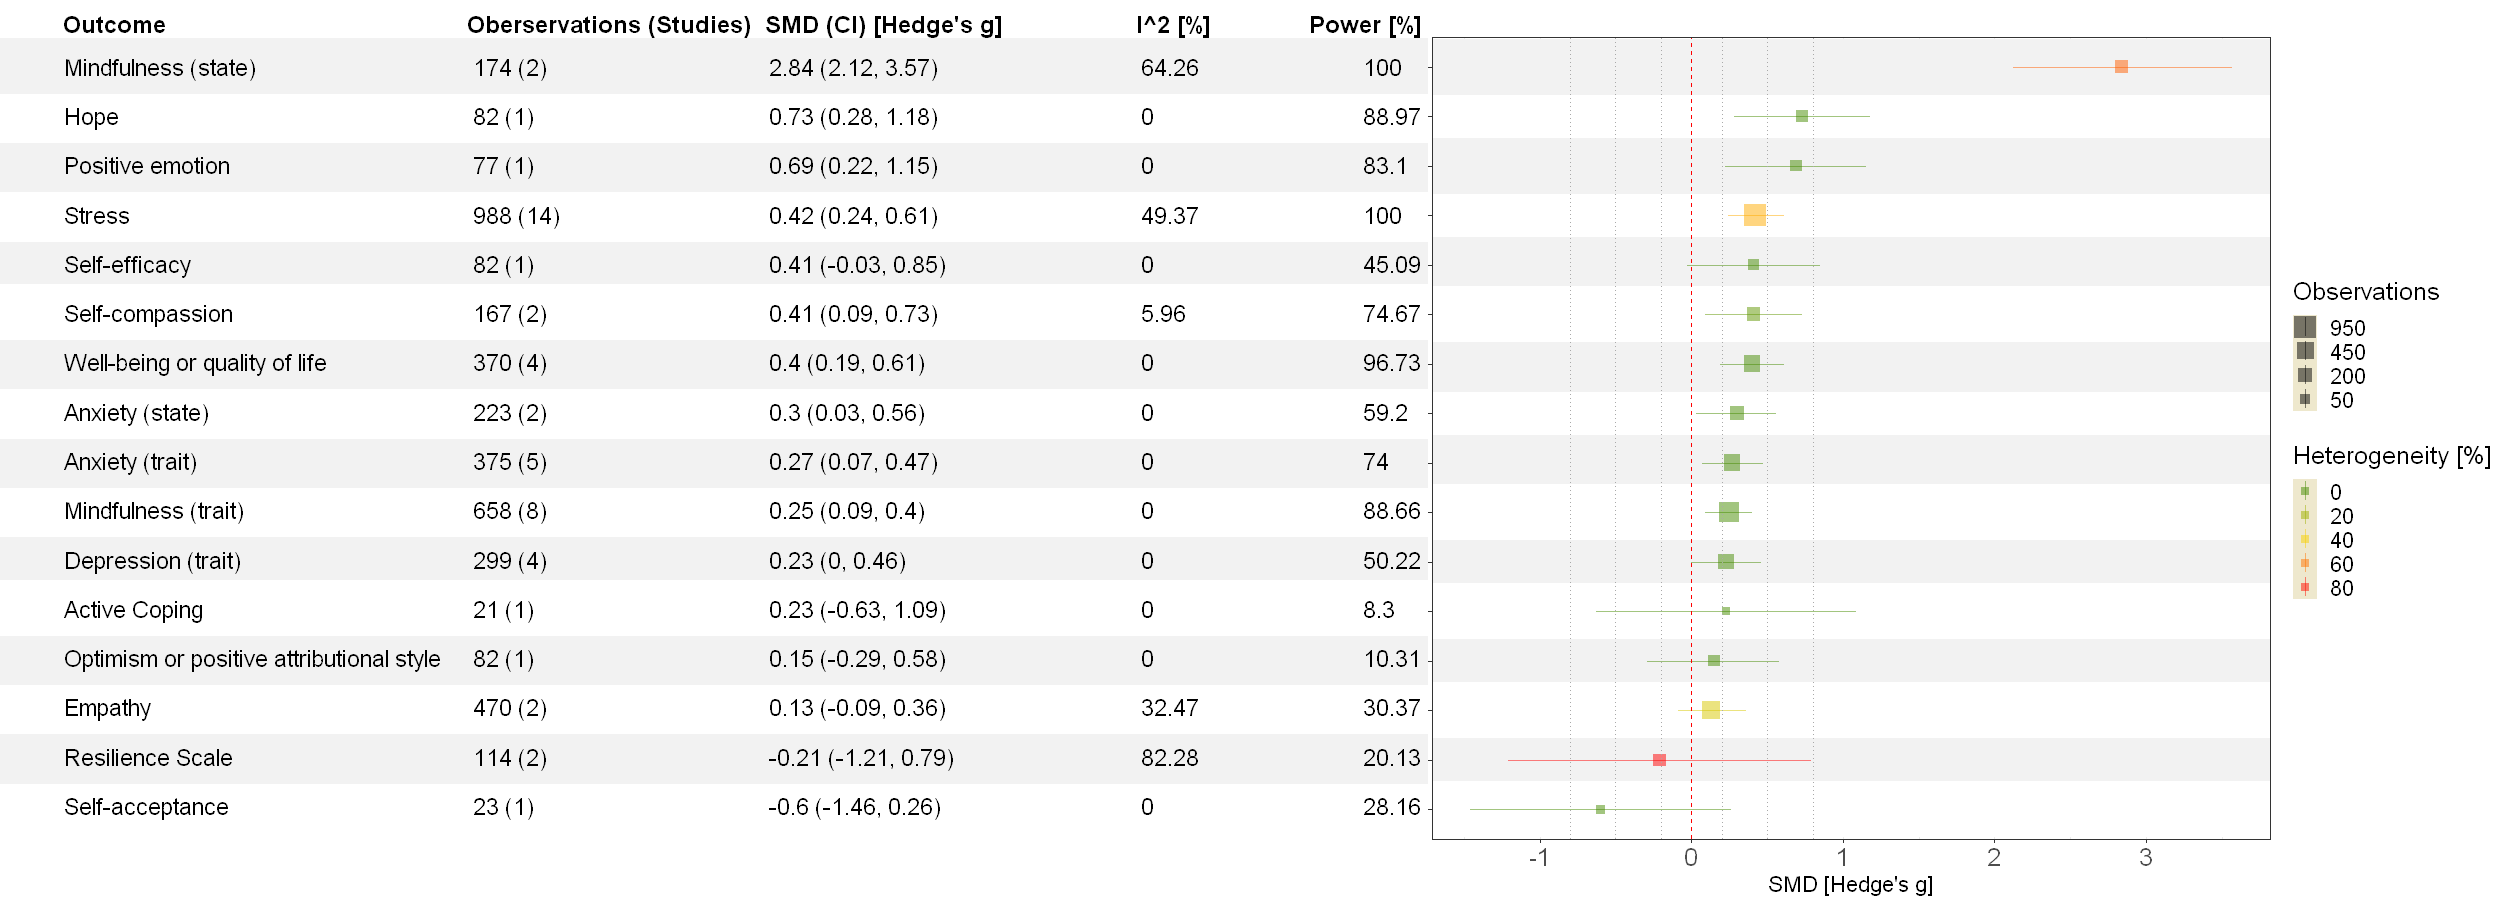

In [195]:
# forest plot
correct.color.order.forest <- c('white','white','gray95','gray95','gray95','gray95','white','gray95','white','gray95','gray95','gray95','white','white','white','white')

# plot.summary.forest <- function(df.sum, correct.color.order.forest, my_colors){
  p <- ggplot(df.sum, aes(y = te, x = reorder(outcomes, te))) + 
    geom_vline(xintercept = outcomes, colour = correct.color.order.forest, size = 19) +
    geom_pointrange(
      aes(
        ymin = ci.l, ymax = ci.u, colour = I2.trans, size = o
      ),
      alpha = 0.5, shape = 15
    ) +
    coord_flip() +
    guides(colour = guide_legend(override.aes = list(size=0.5)), reverse=TRUE) +
    scale_colour_gradientn(colors = my_colors, name="Heterogeneity [%]") + 
    scale_size_continuous(
      name = "Observations", range = c(0.5, 1.7),
      breaks = c(
        950, 450, 200, 50
      )
    ) +
    geom_hline(aes(yintercept=0), colour = 'red', lty=2) +
    geom_hline(aes(yintercept=0.2), colour = 'darkgray', lty=3) +
    geom_hline(aes(yintercept=0.5), colour = 'darkgray', lty=3) +
    geom_hline(aes(yintercept=0.8), colour = 'darkgray', lty=3) +
    geom_hline(aes(yintercept=-0.2), colour = 'darkgray', lty=3) +
    geom_hline(aes(yintercept=-0.5), colour = 'darkgray', lty=3) +
    geom_hline(aes(yintercept=-0.8), colour = 'darkgray', lty=3) +
    theme_bw() +
    theme(
      legend.key=element_rect(fill='cornsilk2'),
      legend.title=element_text(size=18),
      legend.text=element_text(size=16),
      axis.text.y = element_blank(), axis.title.y = element_blank(),
      plot.margin = margin(27, 0, 3, 0),
      axis.text=element_text(size=18), #change font size of axis text
      axis.title=element_text(size=16), #change font size of axis titles
      plot.title=element_text(size=25)
    ) +
    ylab("SMD [Hedge's g]")

  # table
  font.size <- 5.8

  data_table <- ggplot(data = df.sum, aes(y = reorder(outcomes, te))) +
    geom_hline(aes(yintercept = outcomes, colour = colour), size = 19) +

    geom_text(aes(x = 0, label = outcomes), hjust = 0, size = font.size) +
    geom_text(aes(x = 1, label = o.k), nudge_x = 0.1, hjust = 0, size = font.size) +
    geom_text(aes(x = 2, label = te.ci), hjust = 0, nudge_x = - 0.1, size = font.size) +
    geom_text(aes(x = 3, label = I2.trans), hjust = 0, nudge_x = - 0.1, size = font.size) +
    geom_text(aes(x = 4, label = pow), hjust = 0, nudge_x = - 0.5, size = font.size) +

    scale_colour_identity() +
    theme_void() +
    ggtitle("         Outcome                                           Oberservations (Studies)  SMD (CI) [Hedge's g]                   I^2 [%]              Power [%]") +
    theme(
      plot.margin = margin(5, 0, 47, 0),
      plot.title=element_text(size=17, face="bold")
    )
  # combine plots
  grid.arrange(
    data_table, p, ncol = 2,
    widths = c(4/7, 3/7)
  )
# }
# plot.summary.forest(df.sum, correct.color.order.forest, my_colors)

#### With preset function

In [154]:
# set plot size
options(repr.plot.width = 25, repr.plot.height = 9, repr.plot.res = 100)


# Stress ----------------------------------

# Anxiety (state) ----------------------------------

# Anxiety (trait) ----------------------------------

# Depression (trait) ----------------------------------

# Self-efficacy ----------------------------------

# Resilience Scale ----------------------------------

# Hope ----------------------------------

# Optimism or positive attributional style ----------------------------------

# Mindfulness (trait) ----------------------------------

# Well-being or quality of life ----------------------------------
no studies included for outcome: Acceptance 

no studies included for outcome: Religiosity or spirituality or religious coping 


# Positive emotion ----------------------------------

# Mindfulness (state) ----------------------------------

# Active Coping ----------------------------------

# Self-compassion ----------------------------------

# Self-acceptance ----------------------------------

# Empathy ----------------------

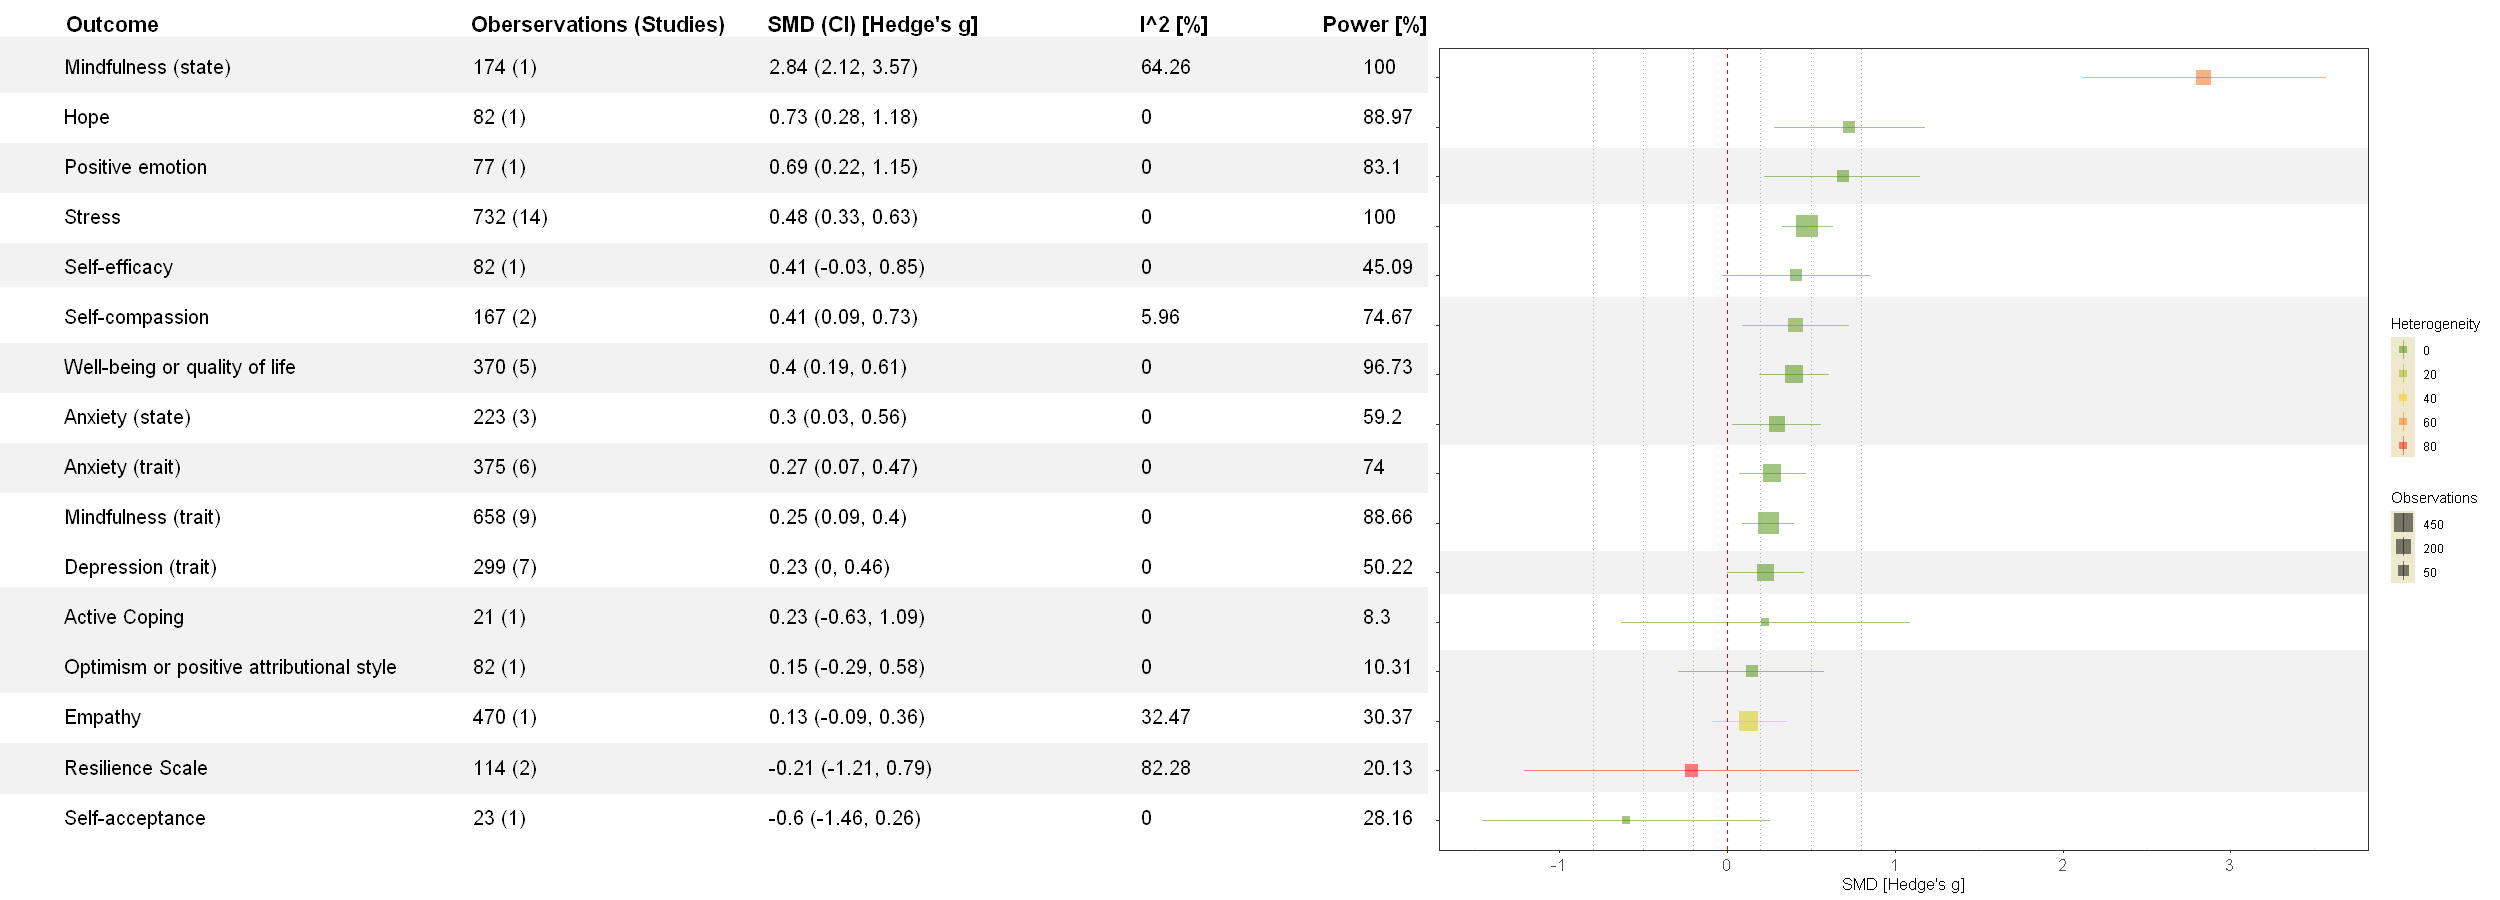

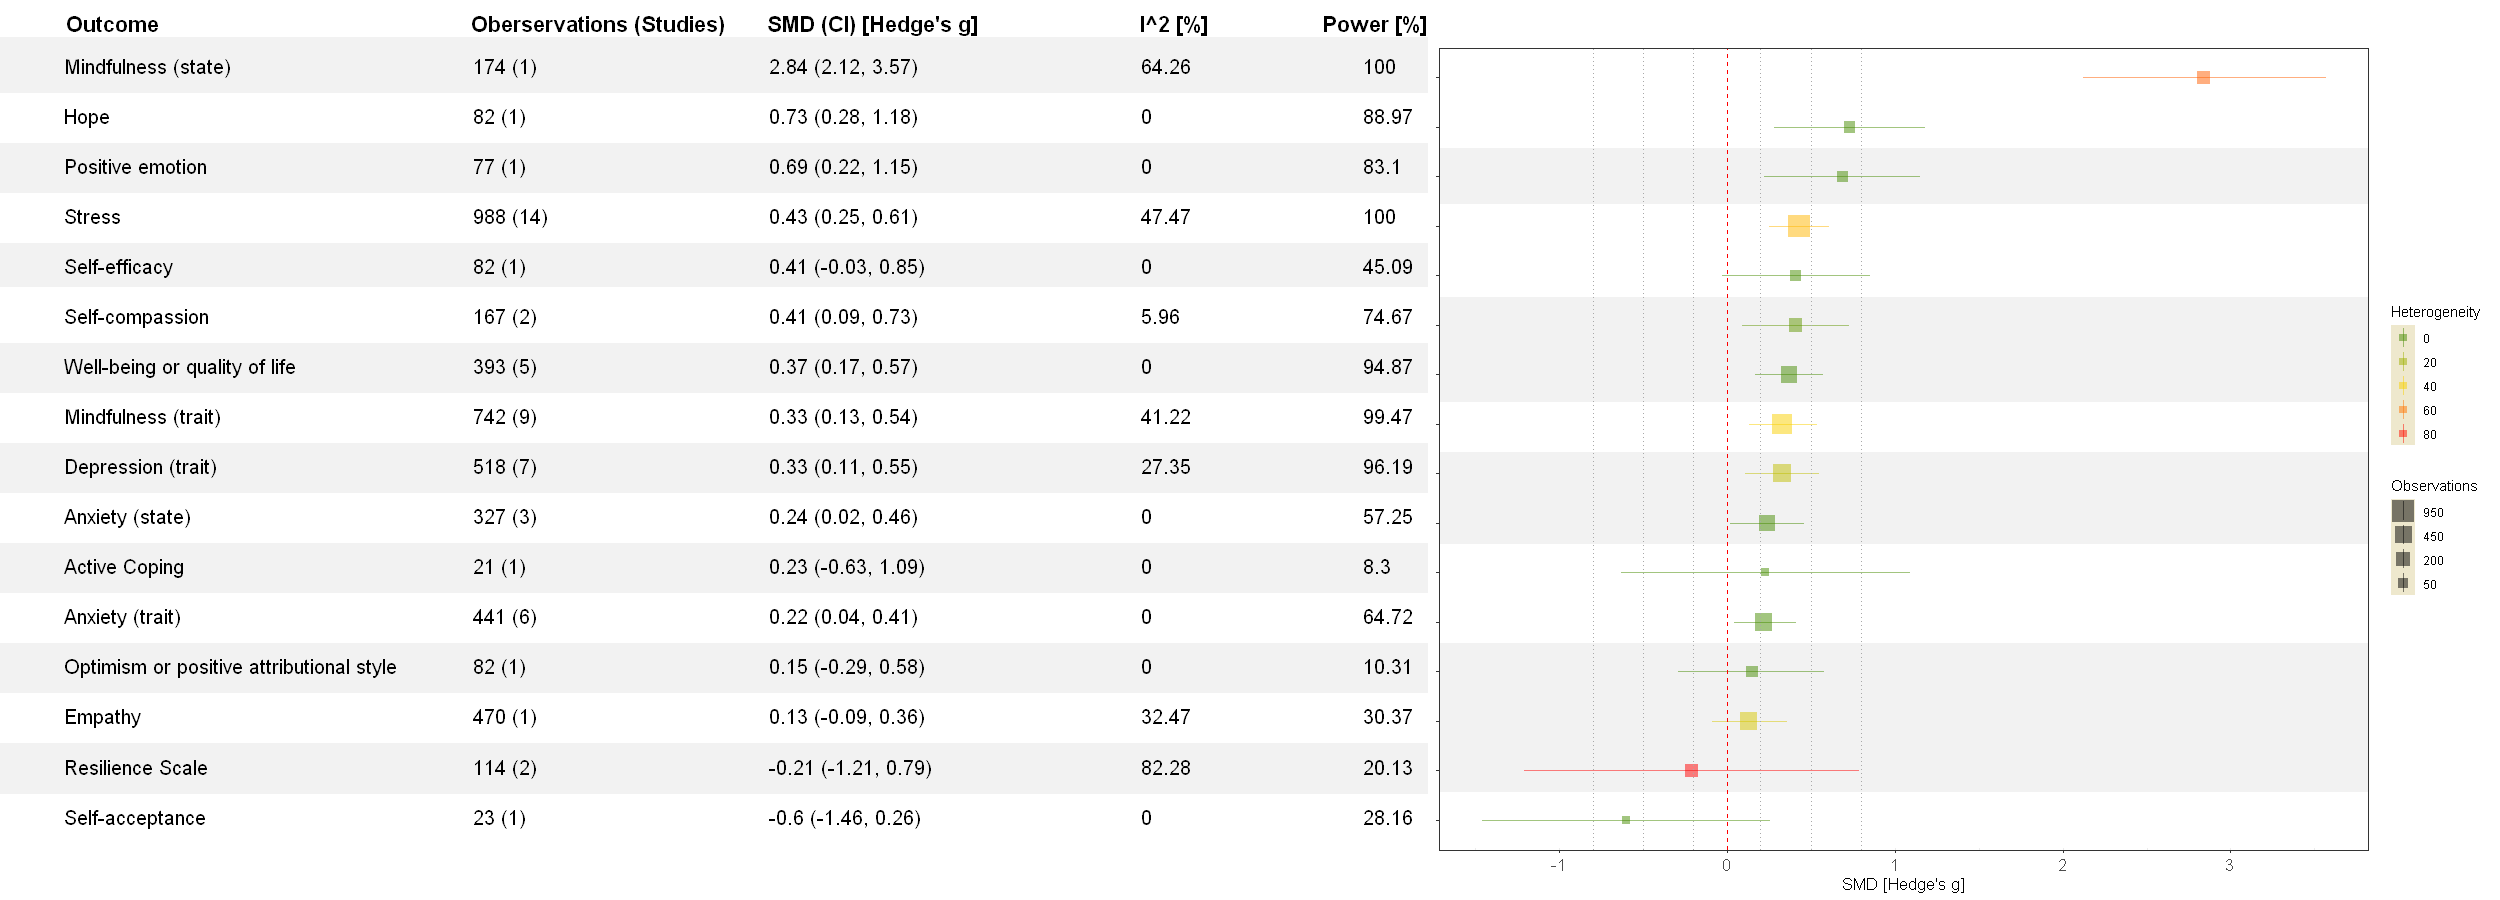

In [509]:
plot.summary.forest(with.outliers = F)
plot.summary.forest(with.outliers = T)

# Old Code

## Dashboard

### set.outcome.page

In [135]:
# # graphical parameters stress (because shiny fails to recognize the size of subgroub forest plots)
# forest.plot.box.height.Stress <- "height: 65vh;"
#   # for 16:9 (1920 x 1080) screen = "height: 65vh;"
#   # for 3:2 (2256 x 1504) screen = "height: 99vh;"

# # Tab names per outcome page
# forest.tab.name <- "Forest & Funnel Plot (without outliers)"
# forest.no.outliers.tab.name <- "Forest & Funnel Plot comparision with/without outliers"
# regression.single.no.outliers.tab.name <- "Linear Regressions (without outliers)"
# # regression.multiple.tab.name <- "Multiple Regressions"
# # regression.multiple.no.outliers.tab.name <- "M. Regressions (w.o.)"

# # set colors
# sig.0.05.color <- "red"
# sig.0.1.color <- "yellow"

# set.outcome.page <- function(outcome, preferred.scale = FALSE){
  
# # Collect data of outcome 
#   meta.df.list <- print.meta.results(
#     outcome, preferred.scale = preferred.scale,
#     regression = F, print.forest = F, print.funnel = F, print.influence = F, print.baujat = F, split.subgroups = F, print.forest.sub.single = F, print.meta.results = F,
#     return.data = "meta.df.list"
#   )
  
# # Get p-value of Egger's regression test for funnel plot asymmetry
#   funnel.asym.p <- print.meta.results(
#     outcome, preferred.scale = preferred.scale,  meta.df.list = meta.df.list,
#     regression = F, print.forest = F, print.funnel = F, print.influence = F, print.baujat = F, split.subgroups = F, print.forest.sub.single = F, print.meta.results = F,
#     return.data = "funnel.asym.p"
#   )
#   if(length(funnel.asym.p) == 0){
#     funnel.asym.p <- 1
#   }
  
#   funnel.asym.p.n.o. <- print.meta.results(
#     outcome, preferred.scale = preferred.scale, meta.df.list = meta.df.list,
#     regression = F, print.forest = F, print.funnel = F, print.influence = F, print.baujat = F, split.subgroups = F, print.forest.sub.single = F, print.meta.results = F,
#     return.data = "funnel.asym.p", filter.forest..funnel.vec = if(length(outlier.list[[outcome]]) != 0){-outlier.list[[outcome]]}else{FALSE}
#   )
#   if(length(funnel.asym.p.n.o.) == 0){
#     funnel.asym.p.n.o. <- 1
#   }
  
# # Calculate all regression results
#   regression.results.list <- list(
#     linear = list(
#       programs.duration =
#       if (nrow(meta.df.list[[1]]) >= 4){
#         print.meta.results(
#           outcome, preferred.scale = preferred.scale, meta.df.list = meta.df.list, return.data = "regression.results.linear",
#           basic = F, moderator.vec = c("programs.duration"), print.baujat.regression = F, print.regression.results = F, regression.degree.1 = T, regression.degree.2 = F,
#           print.regplot = F,
#           filter.regression.linear.list = if(length(outlier.list[["programs.duration.lin"]][[outcome]]) == 0){FALSE}else{list(-outlier.list[["programs.duration.lin"]][[outcome]])}
#         )
#       } else {NA},
#       sessions.duration =
#       if (nrow(meta.df.list[[1]]) >= 4){
#         print.meta.results(
#           outcome, preferred.scale = preferred.scale, meta.df.list = meta.df.list, return.data = "regression.results.linear",
#           basic = F, moderator.vec = c("sessions.duration"), print.baujat.regression = F, print.regression.results = F, regression.degree.1 = T, regression.degree.2 = F,
#           print.regplot = F,
#           filter.regression.linear.list = if(length(outlier.list[["sessions.duration.lin"]][[outcome]]) == 0){FALSE}else{list(-outlier.list[["sessions.duration.lin"]][[outcome]])}
#         )
#       } else {NA},
#       sessions.frequency =
#       if (nrow(meta.df.list[[1]]) >= 4){
#         print.meta.results(
#           outcome, preferred.scale = preferred.scale, meta.df.list = meta.df.list, return.data = "regression.results.linear",
#           basic = F, moderator.vec = c("sessions.frequency"), print.baujat.regression = F, print.regression.results = F, regression.degree.1 = T, regression.degree.2 = F,
#           print.regplot = F,
#           filter.regression.linear.list = if(length(outlier.list[["sessions.frequency.lin"]][[outcome]]) == 0){FALSE}else{list(-outlier.list[["sessions.frequency.lin"]][[outcome]])}
#         )
#       } else {NA},
#       follow.up.period = 
#       if (
#         nrow(meta.df.list[[1]]) >= 4 &
#         (
#           nrow(meta.df.list[[2]]) >= 1 |
#           nrow(meta.df.list[[3]]) >= 1
#         )
#       ){
#         print.meta.results(
#           outcome, preferred.scale = preferred.scale, meta.df.list = meta.df.list, return.data = "regression.results.linear",
#           basic = F, moderator.vec = c("follow.up.period"), print.baujat.regression = F, print.regression.results = F, regression.degree.1 = T, regression.degree.2 = F,
#           print.regplot = F,
#           filter.regression.linear.list = if(length(outlier.list[["follow.up.period.lin"]][[outcome]]) == 0){FALSE}else{list(-outlier.list[["follow.up.period.lin"]][[outcome]])}
#         )
#       } else {NA}
#     ),
    
#     squared = list(
#       programs.duration = 
#       if (nrow(meta.df.list[[1]]) >= 4){
#         print.meta.results(
#           outcome, preferred.scale = preferred.scale, meta.df.list = meta.df.list, return.data = "regression.results.poly",
#           basic = F, moderator.vec = c("programs.duration"), print.baujat.regression = F, print.regression.results = F, regression.degree.1 = F, regression.degree.2 = T,
#           print.regplot = F,
#           filter.regression.linear.list = if(length(outlier.list[["programs.duration.sq"]][[outcome]]) == 0){FALSE}else{list(-outlier.list[["programs.duration.sq"]][[outcome]])}
#         )
#       } else {NA},
#       sessions.duration = 
#       if (nrow(meta.df.list[[1]]) >= 4){
#         print.meta.results(
#           outcome, preferred.scale = preferred.scale, meta.df.list = meta.df.list, return.data = "regression.results.poly",
#           basic = F, moderator.vec = c("sessions.duration"), print.baujat.regression = F, print.regression.results = F, regression.degree.1 = F, regression.degree.2 = T,
#           print.regplot = F,
#           filter.regression.linear.list = if(length(outlier.list[["sessions.duration.sq"]][[outcome]]) == 0){FALSE}else{list(-outlier.list[["sessions.duration.sq"]][[outcome]])}
#         )
#       } else {NA},
#       sessions.frequency = 
#       if (nrow(meta.df.list[[1]]) >= 4){
#         print.meta.results(
#           outcome, preferred.scale = preferred.scale, meta.df.list = meta.df.list, return.data = "regression.results.poly",
#           basic = F, moderator.vec = c("sessions.frequency"), print.baujat.regression = F, print.regression.results = F, regression.degree.1 = F, regression.degree.2 = T,
#           print.regplot = F,
#           filter.regression.linear.list = if(length(outlier.list[["sessions.frequency.sq"]][[outcome]]) == 0){FALSE}else{list(-outlier.list[["sessions.frequency.sq"]][[outcome]])}
#         )
#       } else {NA},
#       follow.up.period = 
#       if (
#         nrow(meta.df.list[[1]]) >= 4 &
#         (
#           nrow(meta.df.list[[2]]) >= 1 |
#           nrow(meta.df.list[[3]]) >= 1
#         )
#       ){
#         print.meta.results(
#           outcome, preferred.scale = preferred.scale, meta.df.list = meta.df.list, return.data = "regression.results.poly",
#           basic = F, moderator.vec = c("follow.up.period"), print.baujat.regression = F, print.regression.results = F, regression.degree.1 = F, regression.degree.2 = T,
#           print.regplot = F,
#           filter.regression.linear.list = if(length(outlier.list[["follow.up.period.sq"]][[outcome]]) == 0){FALSE}else{list(-outlier.list[["follow.up.period.sq"]][[outcome]])}
#         )
#       } else {NA}
#     )
#   )
  
# # Adjust outcome name because spaces and brackets could cause trouble later on
#   outcome.alias <- gsub("([()])", "", gsub(" ", "_", outcome))
  
# # set variables for better readability of code below
#   f.up.isnt.na <- !is.na(regression.results.list$linear$follow.up.period[1])
#     # check if there are regression results for follow-up period
  
#   k.4 <- nrow(meta.df.list[[1]]) >= 4  # check if 4 or more studies are included
  
#   tabItem(
#     tabName = paste(outcome.alias, "_page", sep = ""),
#     tabsetPanel(
#       type = "tabs",
      
# # Main Results (without outliers)
#       tabPanel(
#         forest.tab.name,
#         fluidRow(
#           box(
#             title = "Forest Plot",
#             width = 8,
#             class = "well",
#             plotOutput(paste("forest.", outcome.alias, sep = "")),
#             align="center",
#             collapsible = TRUE
#           ),
#           box(
#             title = "Funnel Plot (with Trim and Fill Method)",
#             background = if(funnel.asym.p <= 0.05){sig.0.05.color}else{NULL},
#             footer = paste("P-value of Egger's regression test for funnel plot asymmetry:", round(funnel.asym.p, digits = 4)),
#             width = 4,
#             class = "well",
#             plotOutput(paste("funnel.", outcome.alias, sep = "")),
#             collapsible = TRUE
#           )
#         ),
        
#         fluidRow(
#           box(
#             title = "Forest Plot (devided by Delivery Mode)",
#             width = 6,
#             class = "well",
#             plotOutput(paste("subgroup.delivery.", outcome.alias, sep = "")),
#             align="center",
#             style = forest.plot.box.height.Stress,
#               # adjust height of grey box around the plot, as the high number of studies hinders shiny to recognize the actual plot size
#             collapsible = TRUE
#           ),
#           box(
#             title = "Forest Plot (devided by Meditation Type)",
#             width = 6,
#             plotOutput(paste("subgroup.type.", outcome.alias, sep = "")),
#             class = "well",
#             align = "center",
#             style = forest.plot.box.height.Stress,
#             collapsible = TRUE
#           )
#         )
#       ),
      
# # Main Results comparison with/without outliers
#       tabPanel(
#         forest.no.outliers.tab.name,
#         fluidRow(
#           box(
#             title = "Baujat Plot",
#             width = 4,
#             class = "well",
#             plotOutput(paste("baujat.", outcome.alias, ".forest.comp", sep = "")),
#             align="right",
#             collapsible = TRUE,
#             collapsed = TRUE
#           ),
#           box(
#             title = "Influence Plots",
#             width = 8,
#             class = "well",
#             plotOutput(paste("influence.", outcome.alias, ".forest", sep = "")),
#             align="center",
#             collapsible = TRUE,
#             collapsed = TRUE
#           )
#         ),
#         fluidRow(
#           box(
#             width = 6,
#             class = "well",
#             h4(paste(
#               "Outliers:",
#               paste(outlier.list[[outcome]], collapse = ", ")
#             ))
#           )
#         ),
#         fluidRow(
#           box(
#             title = "Forest Plot (with outliers)",
#             width = 6,
#             class = "well",
#             plotOutput(paste("forest.o.", outcome.alias, sep = "")),
#             align="right",
#             collapsible = TRUE
#           ),
#           box(
#             title = "Forest Plot (without outliers)",
#             width = 6,
#             class = "well",
#             plotOutput(paste("forest.n.o.comp", outcome.alias, sep = "")),
#             align="right",
#             collapsible = TRUE
#           )
#         ),
        
#         fluidRow(
#           box(
#             title = "Forest Plot (devided by Delivery Mode with outliers)",
#             width = 6,
#             class = "well",
#             plotOutput(paste("subgroup.delivery.", outcome.alias, ".o.", sep = "")),
#             align="center",
#             style = forest.plot.box.height.Stress,
#             collapsible = TRUE
#           ),
#           box(
#             title = "Forest Plot (devided by Delivery Mode without outliers)",
#             width = 6,
#             class = "well",
#             plotOutput(paste("subgroup.delivery.", outcome.alias, ".n.o.comp", sep = "")),
#             align="center",
#             style = forest.plot.box.height.Stress,
#             collapsible = TRUE
#           )
#         ),
        
#         fluidRow(
#           box(
#             title = "Forest Plot (devided by Meditation Type with outliers)",
#             width = 6,
#             class = "well",
#             plotOutput(paste("subgroup.type.", outcome.alias, ".o.", sep = "")),
#             align="center",
#             style = forest.plot.box.height.Stress,
#             collapsible = TRUE
#           ),
#           box(
#             title = "Forest Plot (devided by Meditation Type without outliers)",
#             width = 6,
#             class = "well",
#             plotOutput(paste("subgroup.type.", outcome.alias, ".n.o.comp", sep = "")),
#             align="center",
#             style = forest.plot.box.height.Stress,
#             collapsible = TRUE
#           )
#         ),
        
#         fluidRow(
#           box(
#             title = "Funnel Plot (with outliers)",
#             width = 6,
#             class = "well",
#             plotOutput(paste("funnel.o.", outcome.alias, sep = "")),
#             footer = paste("P-value of Egger's regression test for funnel plot asymmetry:", round(funnel.asym.p, digits = 4)),
#             align="right",
#             collapsible = TRUE
#           ),
#           box(
#             title = "Funnel Plot (without outliers)",
#             width = 6,
#             class = "well",
#             plotOutput(paste("funnel.n.o.comp", outcome.alias, sep = "")),
#             footer = paste("P-value of Egger's regression test for funnel plot asymmetry:", round(funnel.asym.p.n.o., digits = 4)),
#             align="right",
#             collapsible = TRUE
#           )
#         ),
        
#         fluidRow(
#           box(
#             title = "Gosh Plot (outlier 1)",
#             width = 4,
#             class = "well",
#             imageOutput(paste("gosh.1.", outcome.alias, ".forest.comp", sep = "")),
#             align="center",
#             collapsible = TRUE
#           ),
#           box(
#             title = "Gosh Plot (outlier 2)",
#             width = 4,
#             class = "well",
#             imageOutput(paste("gosh.2.", outcome.alias, ".forest.comp", sep = "")),
#             align="center",
#             collapsible = TRUE
#           ),
#           box(
#             title = "Gosh Plot (outlier 3)",
#             width = 4,
#             class = "well",
#             imageOutput(paste("gosh.3.", outcome.alias, ".forest.comp", sep = "")),
#             align="center",
#             collapsible = TRUE
#           )
#         )
#       ),
      
# # Linear Regressions (without outliers)
#       tabPanel(
#         regression.single.no.outliers.tab.name,
        
#     # Program's Duration
#         fluidRow(
#           box(
#             width = 12,
#             class = "well",
#             h4(paste(
#               "Program's Duration (outliers [linear; squared]:",
#               paste(
#                 paste(outlier.list[["programs.duration.lin"]][[outcome]], collapse = ", "), "; ",
#                 paste(outlier.list[["programs.duration.sq"]][[outcome]], collapse = ", "), ")",
#                 sep = ""
#               )
#             ))
#           )
#         ),
#         fluidRow(
#           box(
#             title = "linear",
#             width = 6,
#             background = if(nrow(meta.df.list[[1]]) >= 4){
#               if(regression.results.list$linear$programs.duration$QMp <= 0.05 & regression.results.list$linear$programs.duration$pval[2] <= 0.05){
#                 sig.0.05.color
#               } else if (regression.results.list$linear$programs.duration$QMp <= 0.1 & regression.results.list$linear$programs.duration$pval[2] <= 0.1){
#                 sig.0.1.color
#               } else {NULL}
#             } else {NULL},
#             class = "well",
#             plotOutput(paste("programs.duration.lin", outcome.alias, sep = "")),
#             footer = p(paste(
#               "k: ", if(k.4){regression.results.list$linear$programs.duration$k}else{"NA"}, "; ",
#               "Test of moderators p-value: ", if(k.4){round(regression.results.list$linear$programs.duration$QMp, digits = 4)}else{"NA"}, "; ",
#               "Regression coefficient p-value: ", if(k.4){round(regression.results.list$linear$programs.duration$pval[2], digits = 4)}else{"NA"}, "; ",
#               "R^2: ", if(k.4){round(regression.results.list$linear$programs.duration$R2, digits = 2)}else{"NA"}, "%; ",
#               "I^2: ", if(k.4){round(regression.results.list$linear$programs.duration$I2, digits = 2)}else{"NA"}, "%",
#               sep = ""
#             ), style="color:black"),
#             align="center",
#             collapsible = TRUE
#           ),
#           box(
#             title = "squared",
#             width = 6,
#             background = if(nrow(meta.df.list[[1]]) >= 4){
#               if(regression.results.list$squared$programs.duration$QMp <= 0.05 & regression.results.list$squared$programs.duration$pval[2] <= 0.05){
#                 sig.0.05.color
#               } else if (regression.results.list$squared$programs.duration$QMp <= 0.1 & regression.results.list$squared$programs.duration$pval[2] <= 0.1){
#                 sig.0.1.color
#               } else {NULL}
#             } else {NULL},
#             class = "well",
#             plotOutput(paste("programs.duration.sq", outcome.alias, sep = "")),
#             footer = p(paste(
#               "k: ", if(k.4){regression.results.list$linear$programs.duration$k}else{"NA"}, "; ",
#               "Test of moderators p-value: ", if(k.4){round(regression.results.list$squared$programs.duration$QMp, digits = 4)}else{"NA"}, "; ",
#               "Regression coefficient p-value: ", if(k.4){round(regression.results.list$squared$programs.duration$pval[2], digits = 4)}else{"NA"}, "; ",
#               "R^2: ", if(k.4){round(regression.results.list$squared$programs.duration$R2, digits = 2)}else{"NA"}, "%; ",
#               "I^2: ", if(k.4){round(regression.results.list$squared$programs.duration$I2, digits = 2)}else{"NA"}, "%",
#               sep = ""
#             ), style="color:black"),
#             align="center",
#             collapsible = TRUE
#           )
#         ),
        
#     # Sessions' Duration
#         fluidRow(
#           box(
#             width = 12,
#             class = "well",
#             h4(paste(
#               "Sessions's Duration (outliers [linear; squared]:",
#               paste(
#                 paste(outlier.list[["sessions.duration.lin"]][[outcome]], collapse = ", "), "; ",
#                 paste(outlier.list[["sessions.duration.sq"]][[outcome]], collapse = ", "), ")",
#                 sep = ""
#               )
#             ))
#           )
#         ),
#         fluidRow(
#           box(
#             title = "linear",
#             width = 6,
#             background = if(nrow(meta.df.list[[1]]) >= 4){
#               if(regression.results.list$linear$sessions.duration$QMp <= 0.05 & regression.results.list$linear$sessions.duration$pval[2] <= 0.05){
#                 sig.0.05.color
#               } else if (regression.results.list$linear$sessions.duration$QMp <= 0.1 & regression.results.list$linear$sessions.duration$pval[2] <= 0.1){
#                 sig.0.1.color
#               } else {NULL}
#             } else {NULL},
#             class = "well",
#             plotOutput(paste("sessions.duration.lin", outcome.alias, sep = "")),
#             footer = p(paste(
#               "k: ", if(k.4){regression.results.list$linear$sessions.duration$k}else{"NA"}, "; ",
#               "Test of moderators p-value: ", if(k.4){round(regression.results.list$linear$sessions.duration$QMp, digits = 4)}else{"NA"}, "; ",
#               "Regression coefficient p-value: ", if(k.4){round(regression.results.list$linear$sessions.duration$pval[2], digits = 4)}else{"NA"}, "; ",
#               "R^2: ", if(k.4){round(regression.results.list$linear$sessions.duration$R2, digits = 2)}else{"NA"}, "%; ",
#               "I^2: ", if(k.4){round(regression.results.list$linear$sessions.duration$I2, digits = 2)}else{"NA"}, "%",
#               sep = ""
#             ), style="color:black"),
#             align="center",
#             collapsible = TRUE
#           ),
#           box(
#             title = "squared",
#             width = 6,
#             background = if(nrow(meta.df.list[[1]]) >= 4){
#               if(regression.results.list$squared$sessions.duration$QMp <= 0.05 & regression.results.list$squared$sessions.duration$pval[2] <= 0.05){
#                 sig.0.05.color
#               } else if (regression.results.list$squared$sessions.duration$QMp <= 0.1 & regression.results.list$squared$sessions.duration$pval[2] <= 0.1){
#                 sig.0.1.color
#               } else {NULL}
#             } else {NULL},
#             class = "well",
#             plotOutput(paste("sessions.duration.sq", outcome.alias, sep = "")),
#             footer = p(paste(
#               "k: ", if(k.4){regression.results.list$linear$sessions.duration$k}else{"NA"}, "; ",
#               "Test of moderators p-value: ", if(k.4){round(regression.results.list$squared$sessions.duration$QMp, digits = 4)}else{"NA"}, "; ",
#               "Regression coefficient p-value: ", if(k.4){round(regression.results.list$squared$sessions.duration$pval[2], digits = 4)}else{"NA"}, "; ",
#               "R^2: ", if(k.4){round(regression.results.list$squared$sessions.duration$R2, digits = 2)}else{"NA"}, "%; ",
#               "I^2: ", if(k.4){round(regression.results.list$squared$sessions.duration$I2, digits = 2)}else{"NA"}, "%",
#               sep = ""
#             ), style="color:black"),
#             align="center",
#             collapsible = TRUE
#           )
#         ),
        
#     # Sessions' Frequency
#         fluidRow(
#           box(
#             width = 12,
#             class = "well",
#             h4(paste(
#               "Sessions's Frequency (outliers [linear; squared]:",
#               paste(
#                 paste(outlier.list[["sessions.frequency.lin"]][[outcome]], collapse = ", "), "; ",
#                 paste(outlier.list[["sessions.frequency.sq"]][[outcome]], collapse = ", "), ")",
#                 sep = ""
#               )
#             ))
#           )
#         ),
#         fluidRow(
#           box(
#             title = "linear",
#             width = 6,
#             background = if(nrow(meta.df.list[[1]]) >= 4){
#               if(regression.results.list$linear$sessions.frequency$QMp <= 0.05 & regression.results.list$linear$sessions.frequency$pval[2] <= 0.05){
#                 sig.0.05.color
#               } else if (regression.results.list$linear$sessions.frequency$QMp <= 0.1 & regression.results.list$linear$sessions.frequency$pval[2] <= 0.1){
#                 sig.0.1.color
#               } else {NULL}
#             } else {NULL},
#             class = "well",
#             plotOutput(paste("sessions.frequency.lin", outcome.alias, sep = "")),
#             footer = p(paste(
#               "k: ", if(k.4){regression.results.list$linear$sessions.frequency$k}else{"NA"}, "; ",
#               "Test of moderators p-value: ", if(k.4){round(regression.results.list$linear$sessions.frequency$QMp, digits = 4)}else{"NA"}, "; ",
#               "Regression coefficient p-value: ", if(k.4){round(regression.results.list$linear$sessions.frequency$pval[2], digits = 4)}else{"NA"}, "; ",
#               "R^2: ", if(k.4){round(regression.results.list$linear$sessions.frequency$R2, digits = 2)}else{"NA"}, "%; ",
#               "I^2: ", if(k.4){round(regression.results.list$linear$sessions.frequency$I2, digits = 2)}else{"NA"}, "%",
#               sep = ""
#             ), style="color:black"),
#             align="center",
#             collapsible = TRUE
#           ),
#           box(
#             title = "squared",
#             width = 6,
#             background = if(nrow(meta.df.list[[1]]) >= 4){
#               if(regression.results.list$squared$sessions.frequency$QMp <= 0.05 & regression.results.list$squared$sessions.frequency$pval[2] <= 0.05){
#                 sig.0.05.color
#               } else if (regression.results.list$squared$sessions.frequency$QMp <= 0.1 & regression.results.list$squared$sessions.frequency$pval[2] <= 0.1){
#                 sig.0.1.color
#               } else {NULL}
#             } else {NULL},
#             class = "well",
#             plotOutput(paste("sessions.frequency.sq", outcome.alias, sep = "")),
#             footer = p(paste(
#               "k: ", if(k.4){regression.results.list$linear$sessions.frequency$k}else{"NA"}, "; ",
#               "Test of moderators p-value: ", if(k.4){round(regression.results.list$squared$sessions.frequency$QMp, digits = 4)}else{"NA"}, "; ",
#               "Regression coefficient p-value: ", if(k.4){round(regression.results.list$squared$sessions.frequency$pval[2], digits = 4)}else{"NA"}, "; ",
#               "R^2: ", if(k.4){round(regression.results.list$squared$sessions.frequency$R2, digits = 2)}else{"NA"}, "%; ",
#               "I^2: ", if(k.4){round(regression.results.list$squared$sessions.frequency$I2, digits = 2)}else{"NA"}, "%",
#               sep = ""
#             ), style="color:black"),
#             align="center",
#             collapsible = TRUE
#           )
#         ),
        
#     # Follow-up Period
#         fluidRow(
#           box(
#             width = 12,
#             class = "well",
#             h4(paste(
#               "Follow-up Period (outliers [linear; squared]:",
#               paste(
#                 paste(outlier.list[["follow.up.period.lin"]][[outcome]], collapse = ", "), "; ",
#                 paste(outlier.list[["follow.up.period.sq"]][[outcome]], collapse = ", "), ")",
#                 sep = ""
#               )
#             ))
#           )
#         ),
#         fluidRow(
#           box(
#             title = "linear",
#             width = 6,
#             background =
#             if(nrow(meta.df.list[[1]]) >= 4 & f.up.isnt.na){
#               if(regression.results.list$linear$follow.up.period$QMp <= 0.05 & regression.results.list$linear$follow.up.period$pval[2] <= 0.05){
#                 sig.0.05.color
#               } else if (regression.results.list$linear$follow.up.period$QMp <= 0.1 & regression.results.list$linear$follow.up.period$pval[2] <= 0.1){
#                 sig.0.1.color
#               } else {NULL}
#             } else {NULL},
#             class = "well",
#             plotOutput(paste("follow.up.period.lin", outcome.alias, sep = "")),
#             footer = p(paste(
#               "k: ", if(k.4 & f.up.isnt.na){regression.results.list$linear$follow.up.period$k}else{"NA"}, "; ",
#               "Test of moderators p-value: ", if(k.4 & f.up.isnt.na){round(regression.results.list$linear$follow.up.period$QMp, digits = 4)}else{"NA"}, "; ",
#               "Regression coefficient p-value: ", if(k.4 & f.up.isnt.na){round(regression.results.list$linear$follow.up.period$pval[2], digits = 4)}else{"NA"}, "; ",
#               "R^2: ", if(k.4 & f.up.isnt.na){round(regression.results.list$linear$follow.up.period$R2, digits = 2)}else{"NA"}, "%; ",
#               "I^2: ", if(k.4 & f.up.isnt.na){round(regression.results.list$linear$follow.up.period$I2, digits = 2)}else{"NA"}, "%",
#               sep = ""
#             ), style="color:black"),
#             align="center",
#             collapsible = TRUE
#           ),
#           box(
#             title = "squared",
#             width = 6,
#             background = if(nrow(meta.df.list[[1]]) >= 4 & f.up.isnt.na){
#               if(regression.results.list$squared$follow.up.period$QMp <= 0.05 & regression.results.list$squared$follow.up.period$pval[2] <= 0.05){
#                 sig.0.05.color
#               } else if (regression.results.list$squared$follow.up.period$QMp <= 0.1 & regression.results.list$squared$follow.up.period$pval[2] <= 0.1){
#                 sig.0.1.color
#               } else {NULL}
#             } else {NULL},
#             class = "well",
#             plotOutput(paste("follow.up.period.sq", outcome.alias, sep = "")),
#             footer = p(paste(
#               "k: ", if(k.4 & f.up.isnt.na){regression.results.list$linear$follow.up.period$k}else{"NA"}, "; ",
#               "Test of moderators p-value: ", if(k.4 & f.up.isnt.na){round(regression.results.list$squared$follow.up.period$QMp, digits = 4)}else{"NA"}, "; ",
#               "Regression coefficient p-value: ", if(k.4 & f.up.isnt.na){round(regression.results.list$squared$follow.up.period$pval[2], digits = 4)}else{"NA"}, "; ",
#               "R^2: ", if(k.4 & f.up.isnt.na){round(regression.results.list$squared$follow.up.period$R2, digits = 2)}else{"NA"}, "%; ",
#               "I^2: ", if(k.4 & f.up.isnt.na){round(regression.results.list$squared$follow.up.period$I2, digits = 2)}else{"NA"}, "%",
#               sep = ""
#             ), style="color:black"),
#             align="center",
#             collapsible = TRUE
#           )
#         )
#       )
#     )
#   )
# }

In [137]:
# # test 1 - doesnt work follow up cant get filterd
# # graphical parameters stress (because shiny fails to recognize the size of subgroub forest plots)
# forest.plot.box.height.Stress <- "height: 65vh;"
#   # for 16:9 (1920 x 1080) screen = "height: 65vh;"
#   # for 3:2 (2256 x 1504) screen = "height: 99vh;"

# # Tab names per outcome page
# forest.no.outliers.tab.name <- "Forest & Funnel Plot (without outliers)"
# forest.comparison.tab.name <- "Forest & Funnel Plot comparision with/without outliers"
# regression.single.no.outliers.tab.name <- "Linear Regressions (without outliers)"
# regression.single.comparison.tab.name <- "Linear Regressions comparision with/without outliers/mean ranges"

# # regression.multiple.tab.name <- "Multiple Regressions"
# # regression.multiple.no.outliers.tab.name <- "M. Regressions (w.o.)"

# # set colors
# sig.0.05.color <- "red"
# sig.0.1.color <- "yellow"

# set.outcome.page <- function(outcome, preferred.scale = FALSE){
  
# # Collect data of outcome 
#   meta.df.list <- print.meta.results(
#     outcome, preferred.scale = preferred.scale,
#     regression = F, print.forest = F, print.funnel = F, print.influence = F, print.baujat = F, split.subgroups = F, print.forest.sub.single = F, print.meta.results = F,
#     return.data = "meta.df.list"
#   )
  
# # Get p-value of Egger's regression test for funnel plot asymmetry
#   funnel.asym.p <- print.meta.results(
#     outcome, preferred.scale = preferred.scale,  meta.df.list = meta.df.list,
#     regression = F, print.forest = F, print.funnel = F, print.influence = F, print.baujat = F, split.subgroups = F, print.forest.sub.single = F, print.meta.results = F,
#     return.data = "funnel.asym.p"
#   )
#   if(length(funnel.asym.p) == 0){
#     funnel.asym.p <- 1
#   }
  
#   funnel.asym.p.n.o. <- print.meta.results(
#     outcome, preferred.scale = preferred.scale, meta.df.list = meta.df.list,
#     regression = F, print.forest = F, print.funnel = F, print.influence = F, print.baujat = F, split.subgroups = F, print.forest.sub.single = F, print.meta.results = F,
#     return.data = "funnel.asym.p", filter.forest..funnel.vec = if(length(outlier.list[[outcome]]) != 0){-outlier.list[[outcome]]}else{FALSE}
#   )
#   if(length(funnel.asym.p.n.o.) == 0){
#     funnel.asym.p.n.o. <- 1
#   }
  
#   #############################################################
# # Calculate all regression results
#   regression.results.list <- list(
#     linear = list(
#       programs.duration = list(
#         ##################################################################################### <------------
#         if (nrow(meta.df.list[[1]]) >= 4){
#           print.meta.results(
#             outcome, preferred.scale = preferred.scale, meta.df.list = meta.df.list, return.data = "regression.results.linear",
#             basic = F, moderator.vec = c("programs.duration"), print.baujat.regression = F, print.regression.results = F, regression.degree.1 = T, regression.degree.2 = F,
#             print.regplot = F,
#             filter.regression.linear.list = if(length(outlier.list[["programs.duration.lin"]][[outcome]]) == 0){FALSE}else{list(-outlier.list[["programs.duration.lin"]][[outcome]])}
#           )
#         } else {NA},
#         sessions.duration =
#         if (nrow(meta.df.list[[1]]) >= 4){
#           print.meta.results(
#             outcome, preferred.scale = preferred.scale, meta.df.list = meta.df.list, return.data = "regression.results.linear",
#             basic = F, moderator.vec = c("sessions.duration"), print.baujat.regression = F, print.regression.results = F, regression.degree.1 = T, regression.degree.2 = F,
#             print.regplot = F,
#             filter.regression.linear.list = if(length(outlier.list[["sessions.duration.lin"]][[outcome]]) == 0){FALSE}else{list(-outlier.list[["sessions.duration.lin"]][[outcome]])}
#           )
#         } else {NA},
#         sessions.frequency =
#         if (nrow(meta.df.list[[1]]) >= 4){
#           print.meta.results(
#             outcome, preferred.scale = preferred.scale, meta.df.list = meta.df.list, return.data = "regression.results.linear",
#             basic = F, moderator.vec = c("sessions.frequency"), print.baujat.regression = F, print.regression.results = F, regression.degree.1 = T, regression.degree.2 = F,
#             print.regplot = F,
#             filter.regression.linear.list = if(length(outlier.list[["sessions.frequency.lin"]][[outcome]]) == 0){FALSE}else{list(-outlier.list[["sessions.frequency.lin"]][[outcome]])}
#           )
#         } else {NA},
#         follow.up.period = 
#         if (
#           nrow(meta.df.list[[1]]) >= 4 &
#           (
#             nrow(meta.df.list[[2]]) >= 1 |
#             nrow(meta.df.list[[3]]) >= 1
#           )
#         ){
#           print.meta.results(
#             outcome, preferred.scale = preferred.scale, meta.df.list = meta.df.list, return.data = "regression.results.linear",
#             basic = F, moderator.vec = c("follow.up.period"), print.baujat.regression = F, print.regression.results = F, regression.degree.1 = T, regression.degree.2 = F,
#             print.regplot = F,
#             filter.regression.linear.list = if(length(outlier.list[["follow.up.period.lin"]][[outcome]]) == 0){FALSE}else{list(-outlier.list[["follow.up.period.lin"]][[outcome]])}
#           )
#         } else {NA}
#       )
#     ),
    
#     squared = list(
#       programs.duration = 
#       if (nrow(meta.df.list[[1]]) >= 4){
#         print.meta.results(
#           outcome, preferred.scale = preferred.scale, meta.df.list = meta.df.list, return.data = "regression.results.poly",
#           basic = F, moderator.vec = c("programs.duration"), print.baujat.regression = F, print.regression.results = F, regression.degree.1 = F, regression.degree.2 = T,
#           print.regplot = F,
#           filter.regression.linear.list = if(length(outlier.list[["programs.duration.sq"]][[outcome]]) == 0){FALSE}else{list(-outlier.list[["programs.duration.sq"]][[outcome]])}
#         )
#       } else {NA},
#       sessions.duration = 
#       if (nrow(meta.df.list[[1]]) >= 4){
#         print.meta.results(
#           outcome, preferred.scale = preferred.scale, meta.df.list = meta.df.list, return.data = "regression.results.poly",
#           basic = F, moderator.vec = c("sessions.duration"), print.baujat.regression = F, print.regression.results = F, regression.degree.1 = F, regression.degree.2 = T,
#           print.regplot = F,
#           filter.regression.linear.list = if(length(outlier.list[["sessions.duration.sq"]][[outcome]]) == 0){FALSE}else{list(-outlier.list[["sessions.duration.sq"]][[outcome]])}
#         )
#       } else {NA},
#       sessions.frequency = 
#       if (nrow(meta.df.list[[1]]) >= 4){
#         print.meta.results(
#           outcome, preferred.scale = preferred.scale, meta.df.list = meta.df.list, return.data = "regression.results.poly",
#           basic = F, moderator.vec = c("sessions.frequency"), print.baujat.regression = F, print.regression.results = F, regression.degree.1 = F, regression.degree.2 = T,
#           print.regplot = F,
#           filter.regression.linear.list = if(length(outlier.list[["sessions.frequency.sq"]][[outcome]]) == 0){FALSE}else{list(-outlier.list[["sessions.frequency.sq"]][[outcome]])}
#         )
#       } else {NA},
#       follow.up.period = 
#       if (
#         nrow(meta.df.list[[1]]) >= 4 &
#         (
#           nrow(meta.df.list[[2]]) >= 1 |
#           nrow(meta.df.list[[3]]) >= 1
#         )
#       ){
#         print.meta.results(
#           outcome, preferred.scale = preferred.scale, meta.df.list = meta.df.list, return.data = "regression.results.poly",
#           basic = F, moderator.vec = c("follow.up.period"), print.baujat.regression = F, print.regression.results = F, regression.degree.1 = F, regression.degree.2 = T,
#           print.regplot = F,
#           filter.regression.linear.list = if(length(outlier.list[["follow.up.period.sq"]][[outcome]]) == 0){FALSE}else{list(-outlier.list[["follow.up.period.sq"]][[outcome]])}
#         )
#       } else {NA}
#     )
#   )
  
#   #########################################################
  
# # Adjust outcome name because spaces and brackets could cause trouble later on
#   outcome.alias <- gsub("([()])", "", gsub(" ", "_", outcome))
  
# # set variables for better readability of code below 
#   f.up.isnt.na <- !is.na(get.regression.results(meta.df.list, outcome, "follow.up.period", degree = 1, preferred.scale = preferred.scale)) 
#     # check if there are regression results for follow-up period
#   cat("f.up.isnt.na:", f.up.isnt.na)
  
#   k.4 <- nrow(meta.df.list[[1]]) >= 4  # check if 4 or more studies are included
  
#   tabItem(
#     tabName = paste(outcome.alias, "_page", sep = ""),
#     tabsetPanel(
#       type = "tabs",
      
# # Main Results (without outliers)
#       tabPanel(
#         forest.no.outliers.tab.name,
#         fluidRow(
#           box(
#             title = "Forest Plot",
#             width = 8,
#             class = "well",
#             plotOutput(paste("forest.", outcome.alias, sep = "")),
#             align="center",
#             collapsible = TRUE
#           ),
#           box(
#             title = "Funnel Plot (with Trim and Fill Method)",
#             background = if(funnel.asym.p <= 0.05){sig.0.05.color}else{NULL},
#             footer = paste("P-value of Egger's regression test for funnel plot asymmetry:", round(funnel.asym.p, digits = 4)),
#             width = 4,
#             class = "well",
#             plotOutput(paste("funnel.", outcome.alias, sep = "")),
#             collapsible = TRUE
#           )
#         ),
        
#         fluidRow(
#           box(
#             title = "Forest Plot (devided by Delivery Mode)",
#             width = 6,
#             class = "well",
#             plotOutput(paste("subgroup.delivery.", outcome.alias, sep = "")),
#             align="center",
#             style = forest.plot.box.height.Stress,
#               # adjust height of grey box around the plot, as the high number of studies hinders shiny to recognize the actual plot size
#             collapsible = TRUE
#           ),
#           box(
#             title = "Forest Plot (devided by Meditation Type)",
#             width = 6,
#             plotOutput(paste("subgroup.type.", outcome.alias, sep = "")),
#             class = "well",
#             align = "center",
#             style = forest.plot.box.height.Stress,
#             collapsible = TRUE
#           )
#         )
#       ),
      
# # Main Results comparison with/without outliers
#       tabPanel(
#         forest.comparison.tab.name,
#         fluidRow(
#           box(
#             title = "Baujat Plot",
#             width = 4,
#             class = "well",
#             plotOutput(paste("baujat.", outcome.alias, ".forest.comp", sep = "")),
#             align="right",
#             collapsible = TRUE,
#             collapsed = TRUE
#           ),
#           box(
#             title = "Influence Plots",
#             width = 8,
#             class = "well",
#             plotOutput(paste("influence.", outcome.alias, ".forest", sep = "")),
#             align="center",
#             collapsible = TRUE,
#             collapsed = TRUE
#           )
#         ),
#         fluidRow(
#           box(
#             width = 6,
#             class = "well",
#             h4(paste(
#               "Outliers:",
#               paste(outlier.list[[outcome]], collapse = ", ")
#             ))
#           )
#         ),
#         fluidRow(
#           box(
#             title = "Forest Plot (with outliers)",
#             width = 6,
#             class = "well",
#             plotOutput(paste("forest.o.", outcome.alias, sep = "")),
#             align="right",
#             collapsible = TRUE
#           ),
#           box(
#             title = "Forest Plot (without outliers)",
#             width = 6,
#             class = "well",
#             plotOutput(paste("forest.n.o.comp", outcome.alias, sep = "")),
#             align="right",
#             collapsible = TRUE
#           )
#         ),
        
#         fluidRow(
#           box(
#             title = "Forest Plot (devided by Delivery Mode with outliers)",
#             width = 6,
#             class = "well",
#             plotOutput(paste("subgroup.delivery.", outcome.alias, ".o.", sep = "")),
#             align="center",
#             style = forest.plot.box.height.Stress,
#             collapsible = TRUE
#           ),
#           box(
#             title = "Forest Plot (devided by Delivery Mode without outliers)",
#             width = 6,
#             class = "well",
#             plotOutput(paste("subgroup.delivery.", outcome.alias, ".n.o.comp", sep = "")),
#             align="center",
#             style = forest.plot.box.height.Stress,
#             collapsible = TRUE
#           )
#         ),
        
#         fluidRow(
#           box(
#             title = "Forest Plot (devided by Meditation Type with outliers)",
#             width = 6,
#             class = "well",
#             plotOutput(paste("subgroup.type.", outcome.alias, ".o.", sep = "")),
#             align="center",
#             style = forest.plot.box.height.Stress,
#             collapsible = TRUE
#           ),
#           box(
#             title = "Forest Plot (devided by Meditation Type without outliers)",
#             width = 6,
#             class = "well",
#             plotOutput(paste("subgroup.type.", outcome.alias, ".n.o.comp", sep = "")),
#             align="center",
#             style = forest.plot.box.height.Stress,
#             collapsible = TRUE
#           )
#         ),
        
#         fluidRow(
#           box(
#             title = "Funnel Plot (with outliers)",
#             width = 6,
#             class = "well",
#             plotOutput(paste("funnel.o.", outcome.alias, sep = "")),
#             footer = paste("P-value of Egger's regression test for funnel plot asymmetry:", round(funnel.asym.p, digits = 4)),
#             align="right",
#             collapsible = TRUE
#           ),
#           box(
#             title = "Funnel Plot (without outliers)",
#             width = 6,
#             class = "well",
#             plotOutput(paste("funnel.n.o.comp", outcome.alias, sep = "")),
#             footer = paste("P-value of Egger's regression test for funnel plot asymmetry:", round(funnel.asym.p.n.o., digits = 4)),
#             align="right",
#             collapsible = TRUE
#           )
#         ),
        
#         fluidRow(
#           box(
#             title = "Gosh Plot (outlier 1)",
#             width = 4,
#             class = "well",
#             imageOutput(paste("gosh.1.", outcome.alias, ".forest.comp", sep = "")),
#             align="center",
#             collapsible = TRUE
#           ),
#           box(
#             title = "Gosh Plot (outlier 2)",
#             width = 4,
#             class = "well",
#             imageOutput(paste("gosh.2.", outcome.alias, ".forest.comp", sep = "")),
#             align="center",
#             collapsible = TRUE
#           ),
#           box(
#             title = "Gosh Plot (outlier 3)",
#             width = 4,
#             class = "well",
#             imageOutput(paste("gosh.3.", outcome.alias, ".forest.comp", sep = "")),
#             align="center",
#             collapsible = TRUE
#           )
#         )
#       ),
      
# # Linear Regressions (without outliers)
#       tabPanel(
#         regression.single.no.outliers.tab.name,
        
#     # Program's Duration
#         fluidRow(
#           box(
#             width = 12,
#             class = "well",
#             h4(paste(
#               "Program's Duration (outliers [linear; squared]:",
#               paste(
#                 paste(outlier.list[["programs.duration.lin"]][[outcome]], collapse = ", "), "; ",
#                 paste(outlier.list[["programs.duration.sq"]][[outcome]], collapse = ", "), ")",
#                 sep = ""
#               )
#             ))
#           )
#         ),
#         fluidRow(
#           box(
#             title = "linear",
#             width = 6,
#             background = if(nrow(meta.df.list[[1]]) >= 4){
#               if(get.regression.results(meta.df.list, outcome, "programs.duration", degree = 1, filter = F, preferred.scale = preferred.scale)$QMp <= 0.05 & get.regression.results(meta.df.list, outcome, "programs.duration", degree = 1, filter = F, preferred.scale = preferred.scale)$pval[2] <= 0.05){
#                 sig.0.05.color
#               } else if (get.regression.results(meta.df.list, outcome, "programs.duration", degree = 1, filter = F, preferred.scale = preferred.scale)$QMp <= 0.1 & get.regression.results(meta.df.list, outcome, "programs.duration", degree = 1, filter = F, preferred.scale = preferred.scale)$pval[2] <= 0.1){
#                 sig.0.1.color
#               } else {NULL}
#             } else {NULL},
#             class = "well",
#             plotOutput(paste("programs.duration.lin", outcome.alias, sep = "")),
#             footer = p(paste(
#               "k: ", if(k.4){get.regression.results(meta.df.list, outcome, "programs.duration", degree = 1, filter = F, preferred.scale = preferred.scale)$k}else{"NA"}, "; ",
#               "Test of moderators p-value: ", if(k.4){round(get.regression.results(meta.df.list, outcome, "programs.duration", degree = 1, filter = F, preferred.scale = preferred.scale)$QMp, digits = 4)}else{"NA"}, "; ",
#               "Regression coefficient p-value: ", if(k.4){round(get.regression.results(meta.df.list, outcome, "programs.duration", degree = 1, filter = F, preferred.scale = preferred.scale)$pval[2], digits = 4)}else{"NA"}, "; ",
#               "R^2: ", if(k.4){round(get.regression.results(meta.df.list, outcome, "programs.duration", degree = 1, filter = F, preferred.scale = preferred.scale)$R2, digits = 2)}else{"NA"}, "%; ",
#               "I^2: ", if(k.4){round(get.regression.results(meta.df.list, outcome, "programs.duration", degree = 1, filter = F, preferred.scale = preferred.scale)$I2, digits = 2)}else{"NA"}, "%",
#               sep = ""
#             ), style="color:black"),
#             align="center",
#             collapsible = TRUE
#           ),
#           box(
#             title = "squared",
#             width = 6,
#             background = if(nrow(meta.df.list[[1]]) >= 4){
#               if(get.regression.results(meta.df.list, outcome, "programs.duration", degree = 2, filter = F, preferred.scale = preferred.scale)$QMp <= 0.05 & get.regression.results(meta.df.list, outcome, "programs.duration", degree = 2, filter = F, preferred.scale = preferred.scale)$pval[2] <= 0.05){
#                 sig.0.05.color
#               } else if (get.regression.results(meta.df.list, outcome, "programs.duration", degree = 2, filter = F, preferred.scale = preferred.scale)$QMp <= 0.1 & get.regression.results(meta.df.list, outcome, "programs.duration", degree = 2, filter = F, preferred.scale = preferred.scale)$pval[2] <= 0.1){
#                 sig.0.1.color
#               } else {NULL}
#             } else {NULL},
#             class = "well",
#             plotOutput(paste("programs.duration.sq", outcome.alias, sep = "")),
#             footer = p(paste(
#               "k: ", if(k.4){get.regression.results(meta.df.list, outcome, "programs.duration", degree = 1, filter = F, preferred.scale = preferred.scale)$k}else{"NA"}, "; ",
#               "Test of moderators p-value: ", if(k.4){round(get.regression.results(meta.df.list, outcome, "programs.duration", degree = 2, filter = F, preferred.scale = preferred.scale)$QMp, digits = 4)}else{"NA"}, "; ",
#               "Regression coefficient p-value: ", if(k.4){round(get.regression.results(meta.df.list, outcome, "programs.duration", degree = 2, filter = F, preferred.scale = preferred.scale)$pval[2], digits = 4)}else{"NA"}, "; ",
#               "R^2: ", if(k.4){round(get.regression.results(meta.df.list, outcome, "programs.duration", degree = 2, filter = F, preferred.scale = preferred.scale)$R2, digits = 2)}else{"NA"}, "%; ",
#               "I^2: ", if(k.4){round(get.regression.results(meta.df.list, outcome, "programs.duration", degree = 2, filter = F, preferred.scale = preferred.scale)$I2, digits = 2)}else{"NA"}, "%",
#               sep = ""
#             ), style="color:black"),
#             align="center",
#             collapsible = TRUE
#           )
#         ),
        
#     # Sessions' Duration
#         fluidRow(
#           box(
#             width = 12,
#             class = "well",
#             h4(paste(
#               "Sessions's Duration (outliers [linear; squared]:",
#               paste(
#                 paste(outlier.list[["sessions.duration.lin"]][[outcome]], collapse = ", "), "; ",
#                 paste(outlier.list[["sessions.duration.sq"]][[outcome]], collapse = ", "), ")",
#                 sep = ""
#               )
#             ))
#           )
#         ),
#         fluidRow(
#           box(
#             title = "linear",
#             width = 6,
#             background = if(nrow(meta.df.list[[1]]) >= 4){
#               if(regression.results.list$linear$sessions.duration$QMp <= 0.05 & regression.results.list$linear$sessions.duration$pval[2] <= 0.05){
#                 sig.0.05.color
#               } else if (regression.results.list$linear$sessions.duration$QMp <= 0.1 & regression.results.list$linear$sessions.duration$pval[2] <= 0.1){
#                 sig.0.1.color
#               } else {NULL}
#             } else {NULL},
#             class = "well",
#             plotOutput(paste("sessions.duration.lin", outcome.alias, sep = "")),
#             footer = p(paste(
#               "k: ", if(k.4){regression.results.list$linear$sessions.duration$k}else{"NA"}, "; ",
#               "Test of moderators p-value: ", if(k.4){round(regression.results.list$linear$sessions.duration$QMp, digits = 4)}else{"NA"}, "; ",
#               "Regression coefficient p-value: ", if(k.4){round(regression.results.list$linear$sessions.duration$pval[2], digits = 4)}else{"NA"}, "; ",
#               "R^2: ", if(k.4){round(regression.results.list$linear$sessions.duration$R2, digits = 2)}else{"NA"}, "%; ",
#               "I^2: ", if(k.4){round(regression.results.list$linear$sessions.duration$I2, digits = 2)}else{"NA"}, "%",
#               sep = ""
#             ), style="color:black"),
#             align="center",
#             collapsible = TRUE
#           ),
#           box(
#             title = "squared",
#             width = 6,
#             background = if(nrow(meta.df.list[[1]]) >= 4){
#               if(regression.results.list$squared$sessions.duration$QMp <= 0.05 & regression.results.list$squared$sessions.duration$pval[2] <= 0.05){
#                 sig.0.05.color
#               } else if (regression.results.list$squared$sessions.duration$QMp <= 0.1 & regression.results.list$squared$sessions.duration$pval[2] <= 0.1){
#                 sig.0.1.color
#               } else {NULL}
#             } else {NULL},
#             class = "well",
#             plotOutput(paste("sessions.duration.sq", outcome.alias, sep = "")),
#             footer = p(paste(
#               "k: ", if(k.4){regression.results.list$linear$sessions.duration$k}else{"NA"}, "; ",
#               "Test of moderators p-value: ", if(k.4){round(regression.results.list$squared$sessions.duration$QMp, digits = 4)}else{"NA"}, "; ",
#               "Regression coefficient p-value: ", if(k.4){round(regression.results.list$squared$sessions.duration$pval[2], digits = 4)}else{"NA"}, "; ",
#               "R^2: ", if(k.4){round(regression.results.list$squared$sessions.duration$R2, digits = 2)}else{"NA"}, "%; ",
#               "I^2: ", if(k.4){round(regression.results.list$squared$sessions.duration$I2, digits = 2)}else{"NA"}, "%",
#               sep = ""
#             ), style="color:black"),
#             align="center",
#             collapsible = TRUE
#           )
#         ),
        
#     # Sessions' Frequency
#         fluidRow(
#           box(
#             width = 12,
#             class = "well",
#             h4(paste(
#               "Sessions's Frequency (outliers [linear; squared]:",
#               paste(
#                 paste(outlier.list[["sessions.frequency.lin"]][[outcome]], collapse = ", "), "; ",
#                 paste(outlier.list[["sessions.frequency.sq"]][[outcome]], collapse = ", "), ")",
#                 sep = ""
#               )
#             ))
#           )
#         ),
#         fluidRow(
#           box(
#             title = "linear",
#             width = 6,
#             background = if(nrow(meta.df.list[[1]]) >= 4){
#               if(regression.results.list$linear$sessions.frequency$QMp <= 0.05 & regression.results.list$linear$sessions.frequency$pval[2] <= 0.05){
#                 sig.0.05.color
#               } else if (regression.results.list$linear$sessions.frequency$QMp <= 0.1 & regression.results.list$linear$sessions.frequency$pval[2] <= 0.1){
#                 sig.0.1.color
#               } else {NULL}
#             } else {NULL},
#             class = "well",
#             plotOutput(paste("sessions.frequency.lin", outcome.alias, sep = "")),
#             footer = p(paste(
#               "k: ", if(k.4){regression.results.list$linear$sessions.frequency$k}else{"NA"}, "; ",
#               "Test of moderators p-value: ", if(k.4){round(regression.results.list$linear$sessions.frequency$QMp, digits = 4)}else{"NA"}, "; ",
#               "Regression coefficient p-value: ", if(k.4){round(regression.results.list$linear$sessions.frequency$pval[2], digits = 4)}else{"NA"}, "; ",
#               "R^2: ", if(k.4){round(regression.results.list$linear$sessions.frequency$R2, digits = 2)}else{"NA"}, "%; ",
#               "I^2: ", if(k.4){round(regression.results.list$linear$sessions.frequency$I2, digits = 2)}else{"NA"}, "%",
#               sep = ""
#             ), style="color:black"),
#             align="center",
#             collapsible = TRUE
#           ),
#           box(
#             title = "squared",
#             width = 6,
#             background = if(nrow(meta.df.list[[1]]) >= 4){
#               if(regression.results.list$squared$sessions.frequency$QMp <= 0.05 & regression.results.list$squared$sessions.frequency$pval[2] <= 0.05){
#                 sig.0.05.color
#               } else if (regression.results.list$squared$sessions.frequency$QMp <= 0.1 & regression.results.list$squared$sessions.frequency$pval[2] <= 0.1){
#                 sig.0.1.color
#               } else {NULL}
#             } else {NULL},
#             class = "well",
#             plotOutput(paste("sessions.frequency.sq", outcome.alias, sep = "")),
#             footer = p(paste(
#               "k: ", if(k.4){regression.results.list$linear$sessions.frequency$k}else{"NA"}, "; ",
#               "Test of moderators p-value: ", if(k.4){round(regression.results.list$squared$sessions.frequency$QMp, digits = 4)}else{"NA"}, "; ",
#               "Regression coefficient p-value: ", if(k.4){round(regression.results.list$squared$sessions.frequency$pval[2], digits = 4)}else{"NA"}, "; ",
#               "R^2: ", if(k.4){round(regression.results.list$squared$sessions.frequency$R2, digits = 2)}else{"NA"}, "%; ",
#               "I^2: ", if(k.4){round(regression.results.list$squared$sessions.frequency$I2, digits = 2)}else{"NA"}, "%",
#               sep = ""
#             ), style="color:black"),
#             align="center",
#             collapsible = TRUE
#           )
#         ),
        
#     # Follow-up Period
#         fluidRow(
#           box(
#             width = 12,
#             class = "well",
#             h4(paste(
#               "Follow-up Period (outliers [linear; squared]:",
#               paste(
#                 paste(outlier.list[["follow.up.period.lin"]][[outcome]], collapse = ", "), "; ",
#                 paste(outlier.list[["follow.up.period.sq"]][[outcome]], collapse = ", "), ")",
#                 sep = ""
#               )
#             ))
#           )
#         ),
#         fluidRow(
#           box(
#             title = "linear",
#             width = 6,
#             background =
#             if(nrow(meta.df.list[[1]]) >= 4 & f.up.isnt.na){
#               if(regression.results.list$linear$follow.up.period$QMp <= 0.05 & regression.results.list$linear$follow.up.period$pval[2] <= 0.05){
#                 sig.0.05.color
#               } else if (regression.results.list$linear$follow.up.period$QMp <= 0.1 & regression.results.list$linear$follow.up.period$pval[2] <= 0.1){
#                 sig.0.1.color
#               } else {NULL}
#             } else {NULL},
#             class = "well",
#             plotOutput(paste("follow.up.period.lin", outcome.alias, sep = "")),
#             footer = p(paste(
#               "k: ", if(k.4 & f.up.isnt.na){regression.results.list$linear$follow.up.period$k}else{"NA"}, "; ",
#               "Test of moderators p-value: ", if(k.4 & f.up.isnt.na){round(regression.results.list$linear$follow.up.period$QMp, digits = 4)}else{"NA"}, "; ",
#               "Regression coefficient p-value: ", if(k.4 & f.up.isnt.na){round(regression.results.list$linear$follow.up.period$pval[2], digits = 4)}else{"NA"}, "; ",
#               "R^2: ", if(k.4 & f.up.isnt.na){round(regression.results.list$linear$follow.up.period$R2, digits = 2)}else{"NA"}, "%; ",
#               "I^2: ", if(k.4 & f.up.isnt.na){round(regression.results.list$linear$follow.up.period$I2, digits = 2)}else{"NA"}, "%",
#               sep = ""
#             ), style="color:black"),
#             align="center",
#             collapsible = TRUE
#           ),
#           box(
#             title = "squared",
#             width = 6,
#             background = if(nrow(meta.df.list[[1]]) >= 4 & f.up.isnt.na){
#               if(regression.results.list$squared$follow.up.period$QMp <= 0.05 & regression.results.list$squared$follow.up.period$pval[2] <= 0.05){
#                 sig.0.05.color
#               } else if (regression.results.list$squared$follow.up.period$QMp <= 0.1 & regression.results.list$squared$follow.up.period$pval[2] <= 0.1){
#                 sig.0.1.color
#               } else {NULL}
#             } else {NULL},
#             class = "well",
#             plotOutput(paste("follow.up.period.sq", outcome.alias, sep = "")),
#             footer = p(paste(
#               "k: ", if(k.4 & f.up.isnt.na){regression.results.list$linear$follow.up.period$k}else{"NA"}, "; ",
#               "Test of moderators p-value: ", if(k.4 & f.up.isnt.na){round(regression.results.list$squared$follow.up.period$QMp, digits = 4)}else{"NA"}, "; ",
#               "Regression coefficient p-value: ", if(k.4 & f.up.isnt.na){round(regression.results.list$squared$follow.up.period$pval[2], digits = 4)}else{"NA"}, "; ",
#               "R^2: ", if(k.4 & f.up.isnt.na){round(regression.results.list$squared$follow.up.period$R2, digits = 2)}else{"NA"}, "%; ",
#               "I^2: ", if(k.4 & f.up.isnt.na){round(regression.results.list$squared$follow.up.period$I2, digits = 2)}else{"NA"}, "%",
#               sep = ""
#             ), style="color:black"),
#             align="center",
#             collapsible = TRUE
#           )
#         )
#       ),
      
# # Linear Regressions (comparison with/without outliers/mean ranges)
#       tabPanel(
#         regression.single.comparison.tab.name,
        
#     # Program's Duration
#         # with outliers
#         fluidRow(
#           box(
#             width = 12,
#             class = "well",
#             h3("Program's Duration")
#           )
#         ),
#         fluidRow(
#           box(
#             width = 12,
#             class = "well",
#             h4("With Outliers")
#           )
#         ),
#         fluidRow(
#           box(
#             title = "linear",
#             width = 6,
#             background = if(nrow(meta.df.list[[1]]) >= 4){
#               if(get.regression.results(meta.df.list, outcome, "programs.duration", degree = 1, filter = F, preferred.scale = preferred.scale)$QMp <= 0.05 & get.regression.results(meta.df.list, outcome, "programs.duration", degree = 1, filter = F, preferred.scale = preferred.scale)$pval[2] <= 0.05){
#                 sig.0.05.color
#               } else if (get.regression.results(meta.df.list, outcome, "programs.duration", degree = 1, filter = F, preferred.scale = preferred.scale)$QMp <= 0.1 & get.regression.results(meta.df.list, outcome, "programs.duration", degree = 1, filter = F, preferred.scale = preferred.scale)$pval[2] <= 0.1){
#                 sig.0.1.color
#               } else {NULL}
#             } else {NULL},
#             class = "well",
#             plotOutput(paste("programs.duration.lin.w.o.", outcome.alias, sep = "")),
#             footer = p(paste(
#               "k: ", if(k.4){get.regression.results(meta.df.list, outcome, "programs.duration", degree = 1, filter = F, preferred.scale = preferred.scale)$k}else{"NA"}, "; ",
#               "Test of moderators p-value: ", if(k.4){round(get.regression.results(meta.df.list, outcome, "programs.duration", degree = 1, filter = F, preferred.scale = preferred.scale)$QMp, digits = 4)}else{"NA"}, "; ",
#               "Regression coefficient p-value: ", if(k.4){round(get.regression.results(meta.df.list, outcome, "programs.duration", degree = 1, filter = F, preferred.scale = preferred.scale)$pval[2], digits = 4)}else{"NA"}, "; ",
#               "R^2: ", if(k.4){round(get.regression.results(meta.df.list, outcome, "programs.duration", degree = 1, filter = F, preferred.scale = preferred.scale)$R2, digits = 2)}else{"NA"}, "%; ",
#               "I^2: ", if(k.4){round(get.regression.results(meta.df.list, outcome, "programs.duration", degree = 1, filter = F, preferred.scale = preferred.scale)$I2, digits = 2)}else{"NA"}, "%",
#               sep = ""
#             ), style="color:black"),
#             align="center",
#             collapsible = TRUE
#           ),
#           box(
#             title = "squared",
#             width = 6,
#             background = if(nrow(meta.df.list[[1]]) >= 4){
#               if(get.regression.results(meta.df.list, outcome, "programs.duration", degree = 2, filter = F, preferred.scale = preferred.scale)$QMp <= 0.05 & get.regression.results(meta.df.list, outcome, "programs.duration", degree = 2, filter = F, preferred.scale = preferred.scale)$pval[2] <= 0.05){
#                 sig.0.05.color
#               } else if (get.regression.results(meta.df.list, outcome, "programs.duration", degree = 2, filter = F, preferred.scale = preferred.scale)$QMp <= 0.1 & get.regression.results(meta.df.list, outcome, "programs.duration", degree = 2, filter = F, preferred.scale = preferred.scale)$pval[2] <= 0.1){
#                 sig.0.1.color
#               } else {NULL}
#             } else {NULL},
#             class = "well",
#             plotOutput(paste("programs.duration.sq.w.o.", outcome.alias, sep = "")),
#             footer = p(paste(
#               "k: ", if(k.4){get.regression.results(meta.df.list, outcome, "programs.duration", degree = 2, filter = F, preferred.scale = preferred.scale)$k}else{"NA"}, "; ",
#               "Test of moderators p-value: ", if(k.4){round(get.regression.results(meta.df.list, outcome, "programs.duration", degree = 2, filter = F, preferred.scale = preferred.scale)$QMp, digits = 4)}else{"NA"}, "; ",
#               "Regression coefficient p-value: ", if(k.4){round(get.regression.results(meta.df.list, outcome, "programs.duration", degree = 2, filter = F, preferred.scale = preferred.scale)$pval[2], digits = 4)}else{"NA"}, "; ",
#               "R^2: ", if(k.4){round(get.regression.results(meta.df.list, outcome, "programs.duration", degree = 2, filter = F, preferred.scale = preferred.scale)$R2, digits = 2)}else{"NA"}, "%; ",
#               "I^2: ", if(k.4){round(get.regression.results(meta.df.list, outcome, "programs.duration", degree = 2, filter = F, preferred.scale = preferred.scale)$I2, digits = 2)}else{"NA"}, "%",
#               sep = ""
#             ), style="color:black"),
#             align="center",
#             collapsible = TRUE
#           )
#         )  # ,
        
#         # without outliers
# #         fluidRow(
# #           box(
# #             width = 12,
# #             class = "well",
# #             h4(paste(
# #               "without outliers (outliers [linear; squared]:",
# #               paste(
# #                 paste(outlier.list[["programs.duration.lin"]][[outcome]], collapse = ", "), "; ",
# #                 paste(outlier.list[["programs.duration.sq"]][[outcome]], collapse = ", "), ")",
# #                 sep = ""
# #               )
# #             ))
# #           )
# #         ),
# #         fluidRow(
# #           box(
# #             title = "linear",
# #             width = 6,
# #             background = if(nrow(meta.df.list[[1]]) >= 4){
# #               if(get.regression.results(meta.df.list, outcome, "programs.duration", degree = 1, filter = F, preferred.scale = preferred.scale)$QMp <= 0.05 & get.regression.results(meta.df.list, outcome, "programs.duration", degree = 1, filter = F, preferred.scale = preferred.scale)$pval[2] <= 0.05){
# #                 sig.0.05.color
# #               } else if (get.regression.results(meta.df.list, outcome, "programs.duration", degree = 1, filter = F, preferred.scale = preferred.scale)$QMp <= 0.1 & get.regression.results(meta.df.list, outcome, "programs.duration", degree = 1, filter = F, preferred.scale = preferred.scale)$pval[2] <= 0.1){
# #                 sig.0.1.color
# #               } else {NULL}
# #             } else {NULL},
# #             class = "well",
# #             plotOutput(paste("programs.duration.lin", outcome.alias, sep = "")),
# #             footer = p(paste(
# #               "k: ", if(k.4){get.regression.results(meta.df.list, outcome, "programs.duration", degree = 1, filter = F, preferred.scale = preferred.scale)$k}else{"NA"}, "; ",
# #               "Test of moderators p-value: ", if(k.4){round(get.regression.results(meta.df.list, outcome, "programs.duration", degree = 1, filter = F, preferred.scale = preferred.scale)$QMp, digits = 4)}else{"NA"}, "; ",
# #               "Regression coefficient p-value: ", if(k.4){round(get.regression.results(meta.df.list, outcome, "programs.duration", degree = 1, filter = F, preferred.scale = preferred.scale)$pval[2], digits = 4)}else{"NA"}, "; ",
# #               "R^2: ", if(k.4){round(get.regression.results(meta.df.list, outcome, "programs.duration", degree = 1, filter = F, preferred.scale = preferred.scale)$R2, digits = 2)}else{"NA"}, "%; ",
# #               "I^2: ", if(k.4){round(get.regression.results(meta.df.list, outcome, "programs.duration", degree = 1, filter = F, preferred.scale = preferred.scale)$I2, digits = 2)}else{"NA"}, "%",
# #               sep = ""
# #             ), style="color:black"),
# #             align="center",
# #             collapsible = TRUE
# #           ),
# #           box(
# #             title = "squared",
# #             width = 6,
# #             background = if(nrow(meta.df.list[[1]]) >= 4){
# #               if(get.regression.results(meta.df.list, outcome, "programs.duration", degree = 2, filter = F, preferred.scale = preferred.scale)$QMp <= 0.05 & get.regression.results(meta.df.list, outcome, "programs.duration", degree = 2, filter = F, preferred.scale = preferred.scale)$pval[2] <= 0.05){
# #                 sig.0.05.color
# #               } else if (get.regression.results(meta.df.list, outcome, "programs.duration", degree = 2, filter = F, preferred.scale = preferred.scale)$QMp <= 0.1 & get.regression.results(meta.df.list, outcome, "programs.duration", degree = 2, filter = F, preferred.scale = preferred.scale)$pval[2] <= 0.1){
# #                 sig.0.1.color
# #               } else {NULL}
# #             } else {NULL},
# #             class = "well",
# #             plotOutput(paste("programs.duration.sq", outcome.alias, sep = "")),
# #             footer = p(paste(
# #               "k: ", if(k.4){get.regression.results(meta.df.list, outcome, "programs.duration", degree = 1, filter = F, preferred.scale = preferred.scale)$k}else{"NA"}, "; ",
# #               "Test of moderators p-value: ", if(k.4){round(get.regression.results(meta.df.list, outcome, "programs.duration", degree = 2, filter = F, preferred.scale = preferred.scale)$QMp, digits = 4)}else{"NA"}, "; ",
# #               "Regression coefficient p-value: ", if(k.4){round(get.regression.results(meta.df.list, outcome, "programs.duration", degree = 2, filter = F, preferred.scale = preferred.scale)$pval[2], digits = 4)}else{"NA"}, "; ",
# #               "R^2: ", if(k.4){round(get.regression.results(meta.df.list, outcome, "programs.duration", degree = 2, filter = F, preferred.scale = preferred.scale)$R2, digits = 2)}else{"NA"}, "%; ",
# #               "I^2: ", if(k.4){round(get.regression.results(meta.df.list, outcome, "programs.duration", degree = 2, filter = F, preferred.scale = preferred.scale)$I2, digits = 2)}else{"NA"}, "%",
# #               sep = ""
# #             ), style="color:black"),
# #             align="center",
# #             collapsible = TRUE
# #           )
# #         )  # ,
        
# #     # Sessions' Duration
# #         fluidRow(
# #           box(
# #             width = 12,
# #             class = "well",
# #             h4(paste(
# #               "Sessions's Duration (outliers [linear; squared]:",
# #               paste(
# #                 paste(outlier.list[["sessions.duration.lin"]][[outcome]], collapse = ", "), "; ",
# #                 paste(outlier.list[["sessions.duration.sq"]][[outcome]], collapse = ", "), ")",
# #                 sep = ""
# #               )
# #             ))
# #           )
# #         ),
# #         fluidRow(
# #           box(
# #             title = "linear",
# #             width = 6,
# #             background = if(nrow(meta.df.list[[1]]) >= 4){
# #               if(regression.results.list$linear$sessions.duration$QMp <= 0.05 & regression.results.list$linear$sessions.duration$pval[2] <= 0.05){
# #                 sig.0.05.color
# #               } else if (regression.results.list$linear$sessions.duration$QMp <= 0.1 & regression.results.list$linear$sessions.duration$pval[2] <= 0.1){
# #                 sig.0.1.color
# #               } else {NULL}
# #             } else {NULL},
# #             class = "well",
# #             plotOutput(paste("sessions.duration.lin", outcome.alias, sep = "")),
# #             footer = p(paste(
# #               "k: ", if(k.4){regression.results.list$linear$sessions.duration$k}else{"NA"}, "; ",
# #               "Test of moderators p-value: ", if(k.4){round(regression.results.list$linear$sessions.duration$QMp, digits = 4)}else{"NA"}, "; ",
# #               "Regression coefficient p-value: ", if(k.4){round(regression.results.list$linear$sessions.duration$pval[2], digits = 4)}else{"NA"}, "; ",
# #               "R^2: ", if(k.4){round(regression.results.list$linear$sessions.duration$R2, digits = 2)}else{"NA"}, "%; ",
# #               "I^2: ", if(k.4){round(regression.results.list$linear$sessions.duration$I2, digits = 2)}else{"NA"}, "%",
# #               sep = ""
# #             ), style="color:black"),
# #             align="center",
# #             collapsible = TRUE
# #           ),
# #           box(
# #             title = "squared",
# #             width = 6,
# #             background = if(nrow(meta.df.list[[1]]) >= 4){
# #               if(regression.results.list$squared$sessions.duration$QMp <= 0.05 & regression.results.list$squared$sessions.duration$pval[2] <= 0.05){
# #                 sig.0.05.color
# #               } else if (regression.results.list$squared$sessions.duration$QMp <= 0.1 & regression.results.list$squared$sessions.duration$pval[2] <= 0.1){
# #                 sig.0.1.color
# #               } else {NULL}
# #             } else {NULL},
# #             class = "well",
# #             plotOutput(paste("sessions.duration.sq", outcome.alias, sep = "")),
# #             footer = p(paste(
# #               "k: ", if(k.4){regression.results.list$linear$sessions.duration$k}else{"NA"}, "; ",
# #               "Test of moderators p-value: ", if(k.4){round(regression.results.list$squared$sessions.duration$QMp, digits = 4)}else{"NA"}, "; ",
# #               "Regression coefficient p-value: ", if(k.4){round(regression.results.list$squared$sessions.duration$pval[2], digits = 4)}else{"NA"}, "; ",
# #               "R^2: ", if(k.4){round(regression.results.list$squared$sessions.duration$R2, digits = 2)}else{"NA"}, "%; ",
# #               "I^2: ", if(k.4){round(regression.results.list$squared$sessions.duration$I2, digits = 2)}else{"NA"}, "%",
# #               sep = ""
# #             ), style="color:black"),
# #             align="center",
# #             collapsible = TRUE
# #           )
# #         ),
        
# #     # Sessions' Frequency
# #         fluidRow(
# #           box(
# #             width = 12,
# #             class = "well",
# #             h4(paste(
# #               "Sessions's Frequency (outliers [linear; squared]:",
# #               paste(
# #                 paste(outlier.list[["sessions.frequency.lin"]][[outcome]], collapse = ", "), "; ",
# #                 paste(outlier.list[["sessions.frequency.sq"]][[outcome]], collapse = ", "), ")",
# #                 sep = ""
# #               )
# #             ))
# #           )
# #         ),
# #         fluidRow(
# #           box(
# #             title = "linear",
# #             width = 6,
# #             background = if(nrow(meta.df.list[[1]]) >= 4){
# #               if(regression.results.list$linear$sessions.frequency$QMp <= 0.05 & regression.results.list$linear$sessions.frequency$pval[2] <= 0.05){
# #                 sig.0.05.color
# #               } else if (regression.results.list$linear$sessions.frequency$QMp <= 0.1 & regression.results.list$linear$sessions.frequency$pval[2] <= 0.1){
# #                 sig.0.1.color
# #               } else {NULL}
# #             } else {NULL},
# #             class = "well",
# #             plotOutput(paste("sessions.frequency.lin", outcome.alias, sep = "")),
# #             footer = p(paste(
# #               "k: ", if(k.4){regression.results.list$linear$sessions.frequency$k}else{"NA"}, "; ",
# #               "Test of moderators p-value: ", if(k.4){round(regression.results.list$linear$sessions.frequency$QMp, digits = 4)}else{"NA"}, "; ",
# #               "Regression coefficient p-value: ", if(k.4){round(regression.results.list$linear$sessions.frequency$pval[2], digits = 4)}else{"NA"}, "; ",
# #               "R^2: ", if(k.4){round(regression.results.list$linear$sessions.frequency$R2, digits = 2)}else{"NA"}, "%; ",
# #               "I^2: ", if(k.4){round(regression.results.list$linear$sessions.frequency$I2, digits = 2)}else{"NA"}, "%",
# #               sep = ""
# #             ), style="color:black"),
# #             align="center",
# #             collapsible = TRUE
# #           ),
# #           box(
# #             title = "squared",
# #             width = 6,
# #             background = if(nrow(meta.df.list[[1]]) >= 4){
# #               if(regression.results.list$squared$sessions.frequency$QMp <= 0.05 & regression.results.list$squared$sessions.frequency$pval[2] <= 0.05){
# #                 sig.0.05.color
# #               } else if (regression.results.list$squared$sessions.frequency$QMp <= 0.1 & regression.results.list$squared$sessions.frequency$pval[2] <= 0.1){
# #                 sig.0.1.color
# #               } else {NULL}
# #             } else {NULL},
# #             class = "well",
# #             plotOutput(paste("sessions.frequency.sq", outcome.alias, sep = "")),
# #             footer = p(paste(
# #               "k: ", if(k.4){regression.results.list$linear$sessions.frequency$k}else{"NA"}, "; ",
# #               "Test of moderators p-value: ", if(k.4){round(regression.results.list$squared$sessions.frequency$QMp, digits = 4)}else{"NA"}, "; ",
# #               "Regression coefficient p-value: ", if(k.4){round(regression.results.list$squared$sessions.frequency$pval[2], digits = 4)}else{"NA"}, "; ",
# #               "R^2: ", if(k.4){round(regression.results.list$squared$sessions.frequency$R2, digits = 2)}else{"NA"}, "%; ",
# #               "I^2: ", if(k.4){round(regression.results.list$squared$sessions.frequency$I2, digits = 2)}else{"NA"}, "%",
# #               sep = ""
# #             ), style="color:black"),
# #             align="center",
# #             collapsible = TRUE
# #           )
# #         ),
        
# #     # Follow-up Period
# #         fluidRow(
# #           box(
# #             width = 12,
# #             class = "well",
# #             h4(paste(
# #               "Follow-up Period (outliers [linear; squared]:",
# #               paste(
# #                 paste(outlier.list[["follow.up.period.lin"]][[outcome]], collapse = ", "), "; ",
# #                 paste(outlier.list[["follow.up.period.sq"]][[outcome]], collapse = ", "), ")",
# #                 sep = ""
# #               )
# #             ))
# #           )
# #         ),
# #         fluidRow(
# #           box(
# #             title = "linear",
# #             width = 6,
# #             background =
# #             if(nrow(meta.df.list[[1]]) >= 4 & f.up.isnt.na){
# #               if(regression.results.list$linear$follow.up.period$QMp <= 0.05 & regression.results.list$linear$follow.up.period$pval[2] <= 0.05){
# #                 sig.0.05.color
# #               } else if (regression.results.list$linear$follow.up.period$QMp <= 0.1 & regression.results.list$linear$follow.up.period$pval[2] <= 0.1){
# #                 sig.0.1.color
# #               } else {NULL}
# #             } else {NULL},
# #             class = "well",
# #             plotOutput(paste("follow.up.period.lin", outcome.alias, sep = "")),
# #             footer = p(paste(
# #               "k: ", if(k.4 & f.up.isnt.na){regression.results.list$linear$follow.up.period$k}else{"NA"}, "; ",
# #               "Test of moderators p-value: ", if(k.4 & f.up.isnt.na){round(regression.results.list$linear$follow.up.period$QMp, digits = 4)}else{"NA"}, "; ",
# #               "Regression coefficient p-value: ", if(k.4 & f.up.isnt.na){round(regression.results.list$linear$follow.up.period$pval[2], digits = 4)}else{"NA"}, "; ",
# #               "R^2: ", if(k.4 & f.up.isnt.na){round(regression.results.list$linear$follow.up.period$R2, digits = 2)}else{"NA"}, "%; ",
# #               "I^2: ", if(k.4 & f.up.isnt.na){round(regression.results.list$linear$follow.up.period$I2, digits = 2)}else{"NA"}, "%",
# #               sep = ""
# #             ), style="color:black"),
# #             align="center",
# #             collapsible = TRUE
# #           ),
# #           box(
# #             title = "squared",
# #             width = 6,
# #             background = if(nrow(meta.df.list[[1]]) >= 4 & f.up.isnt.na){
# #               if(regression.results.list$squared$follow.up.period$QMp <= 0.05 & regression.results.list$squared$follow.up.period$pval[2] <= 0.05){
# #                 sig.0.05.color
# #               } else if (regression.results.list$squared$follow.up.period$QMp <= 0.1 & regression.results.list$squared$follow.up.period$pval[2] <= 0.1){
# #                 sig.0.1.color
# #               } else {NULL}
# #             } else {NULL},
# #             class = "well",
# #             plotOutput(paste("follow.up.period.sq", outcome.alias, sep = "")),
# #             footer = p(paste(
# #               "k: ", if(k.4 & f.up.isnt.na){regression.results.list$linear$follow.up.period$k}else{"NA"}, "; ",
# #               "Test of moderators p-value: ", if(k.4 & f.up.isnt.na){round(regression.results.list$squared$follow.up.period$QMp, digits = 4)}else{"NA"}, "; ",
# #               "Regression coefficient p-value: ", if(k.4 & f.up.isnt.na){round(regression.results.list$squared$follow.up.period$pval[2], digits = 4)}else{"NA"}, "; ",
# #               "R^2: ", if(k.4 & f.up.isnt.na){round(regression.results.list$squared$follow.up.period$R2, digits = 2)}else{"NA"}, "%; ",
# #               "I^2: ", if(k.4 & f.up.isnt.na){round(regression.results.list$squared$follow.up.period$I2, digits = 2)}else{"NA"}, "%",
# #               sep = ""
# #             ), style="color:black"),
# #             align="center",
# #             collapsible = TRUE
# #           )
# #         )
#       )
      
#     )
#   )
# }

## Meditation Techniques

In [ ]:
# # check if all entries (meditation techniques) are mentioned
# med.tech.missed <- FALSE
# for (intervention in 1:ncol(meditation.techniques.df)){
#   for (study in 1:nrow(meditation.techniques.df)){
#     if (
#       !is.na(meditation.techniques.df[study, intervention]) &
#       !(
#         meditation.techniques.df[study, intervention] %in% c(
#           "NA", nm.placeholder, as.character(nm.placeholder), "None", "No Intervention",
#           "Wait-List Control"
#         )
#       ) &
#       !(meditation.techniques.df[study, intervention] %in% meditation.type.all)
#     ){
#       cat(
#         study.names[study], "Intervention", intervention,
#         "| not in meditation.type.all:\n",
#         meditation.techniques.df[study, intervention], "\n\n"
#       )
#       med.tech.missed <- TRUE
#     }
#   }
# }

# if (!med.tech.missed){
#   cat("all meditation techniques mentioned")
# }

In [ ]:
# for (outcome in present.outcomes){
#   print(outcome)
#   if (outcome == "Stress"){
#     print.meta.results(
#       outcome, preferred.scale = "Depression Anxiety and Stress Scale (DASS)", regression = FALSE, print.regression.results =F, print.meta.results = F
#     )
    
#     print.meta.results(
#       outcome, preferred.scale = "Perceived Stress Scale (PSS)", regression = FALSE, print.regression.results =F, print.meta.results = F
#     )
#   } else {
#     print.meta.results(outcome, print.regression.results =F, print.meta.results = F)
#   }
    
#   cat("######################################################\n\n")
# }
# print("FINAAAL <3")

## Templates

In [ ]:
# get.heterogeneity <- function(meta.results){
#   I2.found <- FALSE
#   for (line in capture.output(meta.results)){
#     # capture.output() gets output as character vector
#     if (
#       grepl("I\\^2", line) &
#       !grepl("%", substring(sub(".*I\\^2 = ", "", line), 1, 4)) &
#       is.double(suppressWarnings(as.double(substring(sub(".*I\\^2 = ", "", line), 1, 4))))
#         # substring(sub(".*I\\^2 = ", "", line), 1, 4) returns 1st four characters after I^2
#     ){
#       # for values >= 10 % (e.g., "15.5" = 4 characters)
#       I2.found <- TRUE
#       return(
#         as.double(substring(sub(".*I\\^2 = ", "", line), 1, 4))
#       )
#     } else if (
#       grepl("I\\^2", line) &
#       is.double(suppressWarnings(as.double(substring(sub(".*I\\^2 = ", "", line), 1, 3))))
#     ){
#       # for falues < 10 %
#       I2.found <- TRUE
#       return(
#         as.double(substring(sub(".*I\\^2 = ", "", line), 1, 3))
#       )
#     } else if (
#       grepl("I\\^2", line) &
#       !is.double(suppressWarnings(as.double(substring(sub(".*I\\^2 = ", "", line), 1, 4)))) &
#       !is.double(suppressWarnings(as.double(substring(sub(".*I\\^2 = ", "", line), 1, 3))))
#     ){
#       cat(
#         "unknown heterogeneity values:", "\n",
#         substring(sub(".*I\\^2 = ", "", line), 1, 4), "\n\n"
#       )
#     }
#   }
#   if (!I2.found){
#     print("no heterogeneity found")
#   }
# }


In [ ]:
# # regression without weights being considered!!!!!!!!!!!!!!!!!
# plot.meta.regression <- function(regression.df, regression.factor){
#   ggplot(
#     # set axis
#     data=regression.df,
#     aes(
#       x = !!sym(regression.factor),  # !!sym() makes it possible to pass string as argument
#       y = hedges.g,
#       size = weights
#     )
#   ) +
  
#   # add scatter plot
#   geom_point(
#     alpha = .5,
#     colour = "blue"
#   ) +
  
#   # label points
#   geom_text(aes(
#     label=study.id,
#     hjust=1,
#     vjust=-0.8,
#     size=0.45
#   )) +
  
#   # add vertical paddings to ensure labels are displayed completely
#   scale_x_continuous(expand = expansion(mult = 0.2)) +
  
#   # add regression line with confidence interval
#   geom_smooth(
#     method = lm,
#     se = TRUE,
#     size = 1,
#     alpha = .15,
#     fill = "#33638DFF") +
  
#   # add dashed line on 0 effect level  
#   geom_hline(
#     yintercept=0,
#     linetype="dashed",
#     color = "red",
#     size =0.5
#   ) +
  
#   # hide legend
#   theme(
#     legend.position = "none"
#   )
# }

In [ ]:
# # regression without weights being considered!!!!!!!!!!!!!!!!!
# print(1)
# regs <- c("sessions.duration", "sessions.frequency", "programs.duration", "delivery.mode")

# i <- 1
# reg <- regs[i]
# regression.df <- meta.analyze(
#   "Stress", meditation.type.all, m.data.list, time.point = 2,
#   preferred.scale = "Perceived Stress Scale (PSS)",
#   sort.by = "hedges.g", regression.factor = reg
# )

# plot.meta.regression(regression.df, reg)
# i <- i + 1

# reg <- regs[i]
# regression.df <- meta.analyze(
#   "Stress", meditation.type.all, m.data.list, time.point = 2,
#   preferred.scale = "Perceived Stress Scale (PSS)",
#   sort.by = "hedges.g", regression.factor = reg
# )

# plot.meta.regression(regression.df, reg)
# i <- i + 1

# reg <- regs[i]
# regression.df <- meta.analyze(
#   "Stress", meditation.type.all, m.data.list, time.point = 2,
#   preferred.scale = "Perceived Stress Scale (PSS)",
#   sort.by = "hedges.g", regression.factor = reg
# )

# plot.meta.regression(regression.df, reg)
# i <- i + 1

# reg <- regs[i]
# regression.df <- meta.analyze(
#   "Stress", meditation.type.all, m.data.list, time.point = 2,
#   preferred.scale = "Perceived Stress Scale (PSS)",
#   sort.by = "hedges.g", regression.factor = reg
# )

# plot.meta.regression(regression.df, reg)
# i <- i + 1


# print(2)

In [ ]:
# library('readxl')
# # import csv file into R
# # data <- read_excel('review_47966_20220515233722.xlsx')
# # write.csv(data, file = 'review_47966_20220515233722.csv')
# data <- read.csv('review_47966_20220515233722.csv')

# # create df of all Meditation 1 studies
# data.med1 =  data[data$Practiced.Techniques.in.Intervention.1 == 'Meditation 1', ] # select only rows with meditation 1 as intervetion 1


# # pooled.sd <- sqrt(((n1-1)*s1^2 + (n2-1)*s2^2) / (n1+n1-2))
# # mean.diff <- mean.1 - mean.2
# # cohens'd <- mean.diff/pooled.sd
# # calculate hedges g out of cohens d with hedges_g()

# # create df for meta analysis with Meditation 1
# library('esc')
# df.meta <- data.frame(
#   study.id =	data.med1[, 'Study.ID'],
#   number.meditation =	data.med1[, 'Sample.size.Intervention.1.T1'],  # number of participants in meditation condition
#   mean.meditation =	data.med1[, 'Intervention.1.Mean.T2'],
#   sd.meditation =	data.med1[, 'Intervention.1.SD.T2'],
#   number.control =	data.med1[, 'Sample.size.Intervention.2.T1'],
#   mean.conttrol	= data.med1[, 'Intervention.2.Mean.T2'],
#   sd.control	= data.med1[, 'Intervention.2.SD.T2'],
#   med.frequency = data.med1[, 'Frequency'],
#   pooled.sd = sqrt((data.med1[, 'Sample.size.Intervention.1.T1']-1)*data.med1[, 'Intervention.1.SD.T2']^2 + (data.med1[, 'Sample.size.Intervention.2.T1']-1)*data.med1[, 'Intervention.2.SD.T2']^2) / (data.med1[, 'Sample.size.Intervention.1.T1']+data.med1[, 'Sample.size.Intervention.1.T1']-2),
#   mean.diff.T2 = data.med1[, 'Intervention.1.Mean.T2']-data.med1[, 'Intervention.2.Mean.T2']
# )

# df.meta$hedges.g <- (df.meta[, "pooled.sd"] / df.meta[, "mean.diff.T2"])

# library('meta')
# res.df_meta =  metacont(number.meditation, mean.meditation, sd.meditation, 
#                         number.control, mean.conttrol, sd.control,
#                         fixed = T, random = T, studlab = study.id,
#                         data = df.meta, sm = "SMD")

# # plot forest plot
# forest(res.df_meta, leftcols = c('studlab'))

# # plot funnel plot
# funnel(res.df_meta)

# # metabias: Test for funnel plot asymmetry, based on rank correlation or linear regression method.
# metabias(res.df_meta, method.bias = 'linreg', k.min = , plotit = T)
# # The p-value is 0.973 which implies no publication bias. However, this meta-analysis contains k=5 studies. Egger’s test may lack the statistical power to detect bias when the number of studies is small (i.e., k<10).

# # conduct meta-regression, see: https://cjvanlissa.github.io/Doing-Meta-Analysis-in-R/plotting-regressions.html
# library('metafor')
# random.effects.model <- rma(
#   df.meta[, "hedges.g"],
#   df.meta[, "pooled.sd"]
# )
#   # second paramenter in rma-function = sampling variance = pooled standard deviation?

# install.packages('ggplot2')
# library(ggplot2)

# df.meta$weights <- 1/sqrt(df.meta$pooled.sd)
# # Specify basic plot, mapping med.frequency to the x-axis, effect size 'hedges.g' to the y-axis,
# # and 'weights' to the weight parameter.
# ggplot(df.meta, aes(x = med.frequency, y = hedges.g, size = weights)) +
#   geom_point(shape = 1) + # Add scatter
#   geom_abline(intercept = random.effects.model$b[1], slope = random.effects.model$b[2]) + # Add regression line
#   theme_bw() + # Apply black and white theme
#   theme(legend.position = "none") # Remove legend
#   # see link for beatiful meta-regression with convidence intervals: https://bookdown.org/robcrystalornelas/meta-analysis_of_ecological_data/meta-regression.html#meta-regression-with-continuous-variable

# # plot traffic light plot for RoB
# ## use {robvis} via the rob_traffic_light function
# ## see: https://bookdown.org/MathiasHarrer/Doing_Meta_Analysis_in_R/risk-of-bias-plots.html#traffic-light-plots

# # plot Summary Plots
# ## use use {robvis} via the rob_summary function

## meta.analyze, fill.meta.df(), 

In [ ]:
# # for meta.analyze without descr..reg.data.list
# fill.meta.df <- function(
#   scale, time.point, intervention.no, outcome.no, study,
#   m.data.list, nm.placeholder, int.per.study
#   ){
# # Descriptive Results
# ## for control group
#   if (intervention.no == 4){
#     for (i in 1:int.per.study){
#       # if n interventions are included, these refer to the control n times
#       study.id <<- append(
#         study.id,
#         m.data.list[["one.D.info.df"]][study,"Study.ID"]
#       )

#       n.control <<- append(
#         n.control,
#         results.descriptive.array[intervention.no, "n", time.point, outcome.no, scale, study]
#       )
#       mean.control <<- append(
#         mean.control,
#         results.descriptive.array[intervention.no, "Mean", time.point, outcome.no, scale, study]
#       )
#       sd.control <<- append(
#         sd.control,
#         results.descriptive.array[intervention.no, "SD", time.point, outcome.no, scale, study]
#       )
#     }

# ## for intervention
#   } else {
#     # add descriptive results to respective vector
#     n.int <<- append(
#       n.int,
#       results.descriptive.array[intervention.no, "n", time.point, outcome.no, scale, study]
#     )
#     mean.int <<- append(
#       mean.int,
#       results.descriptive.array[intervention.no, "Mean", time.point, outcome.no, scale, study]
#     )
#     sd.int <<- append(
#       sd.int,
#       results.descriptive.array[intervention.no, "SD", time.point, outcome.no, scale, study]
#     )

#     int.per.study <<- int.per.study + 1

# # Results for meta-regression
#     sessions.duration <<- append(
#       sessions.duration,
#       get.regression.data(m.data.list, "Sessions.Duration.in.minutes", study, intervention.no, nm.placeholder)
#     )

#     sessions.frequency <<- append(
#       sessions.duration,
#       get.regression.data(m.data.list, "Frequency.in.times.per.week", study, intervention.no, nm.placeholder)
#     )

#     programs.duration <<- append(
#       sessions.duration,
#       get.regression.data(m.data.list, "Total.Duration.in.Days", study, intervention.no, nm.placeholder)
#     )

#     delivery.mode <<- append(
#       sessions.duration,
#       get.regression.data(m.data.list, "Delivery.Mode", study, intervention.no, nm.placeholder)
#     )
#   }
# }

In [ ]:
# # without fill.meta.df()
# meta.analyze <- function(
#   outcome, meditation.types, m.data.list, preferred.scale = FALSE,
#   print.forest = FALSE, print.funnel = FALSE, print.meta.results = FALSE,
#   print.descriptive = FALSE, moderator = FALSE,
#   return.data = FALSE, filter.forest..funnel.vec = FALSE, filter.regression.vec = FALSE, sort.by = FALSE
#     # meditation.types = vector of meditation types
#     # preferred.scale = preferred scale in case of 2 scales for one outcome (Stress)
#     # moderator returns regression df instead of printing because latter does not work for some reason
# ){
#   study.id <- c()

# # Set Variables
# ## Descriptive Results
#   n.int <- c()
#   n.control <- c()
#   mean.int <- c()
#   mean.control <- c()
#   sd.int <- c()
#   sd.control <- c()

# ## Meta-Regression Factors
#   # for active control groups with regression data, create vectors also for control group
#   # and insert them at the function's control group part
#   # for this script there are only passive controls that do not have regression data
#   sessions.duration <- c()
#   sessions.frequency <- c()
#   programs.duration <- c()
#   delivery.mode <- c()
  
#   follow.up.period.t1.t2 <- c()
#   follow.up.period.t1.t3 <- c()

# ## create list of all meta data vectors to pass it to fill.meta.df()
#   # arrays or data frames are not used to be able to append values to vectors separately 
#   descr..reg.data.list.t1 <- list(
#     study.id, n.int, n.control, mean.int, mean.control, sd.int, sd.control,
#     sessions.duration, sessions.frequency, programs.duration, delivery.mode,
#     follow.up.period.t1.t2, follow.up.period.t1.t3
#   )
  
#   names(descr..reg.data.list.t1) <- c(
#     "study.id", "n.int", "n.control", "mean.int", "mean.control", "sd.int", "sd.control",
#     "sessions.duration", "sessions.frequency", "programs.duration", "delivery.mode",
#     "follow.up.period.t1.t2", "follow.up.period.t1.t3"
#   )
  
#   descr..reg.data.list.t2 <- descr..reg.data.list.t1
  
#   descr..reg.data.list.t3 <- descr..reg.data.list.t1
  
#   descr..reg.data.list <- list(descr..reg.data.list.t1, descr..reg.data.list.t2, descr..reg.data.list.t3)

#   names(descr..reg.data.list) <- c("t1", "t2", "t3")
  
# #___For other than Stress (Outcomes with one scale per outcome per study)___#
#   if (preferred.scale == FALSE){
#     for (study in 1:study.no){
#       int.per.study <- 0
#       for (outcome.no in 1:7){
#         for (intervention.no in 1:4){
#           results.descriptive.array <- m.data.list[["results.descriptive.array"]]
#           if (
#             m.data.list[["outcome.names.df"]][study, sprintf("Name.of.Outcome.%d", outcome.no)] ==
#             outcome &
#             !(
#               is.na(m.data.list[["intervention.comparisons.df.list"]][[study]][intervention.no,"Name"]) |
#               m.data.list[["intervention.comparisons.df.list"]][[study]][intervention.no,"Name"] == "NA" |
#               m.data.list[["intervention.comparisons.df.list"]][[study]][intervention.no,"Name"] ==
#                 nm.placeholder |
#               m.data.list[["intervention.comparisons.df.list"]][[study]][intervention.no,"Name"] ==
#                 as.character(nm.placeholder)
#             ) &
#             (
#               m.data.list[["meditation.techniques.df"]][study, intervention.no] %in% meditation.types |
#               ((TRUE %in% (m.data.list[["meditation.techniques.df"]][study,] %in% meditation.types)) &
#                intervention.no == 4)
#             ) &
#             !(
#               NA %in% results.descriptive.array[intervention.no,,time.point, outcome.no, "Scale.1", study] |
#               nm.placeholder %in% results.descriptive.array[intervention.no,,time.point, outcome.no, "Scale.1", study]
#             ) &
#             !(
#               NA %in% results.descriptive.array["Control",,time.point, outcome.no, "Scale.1", study] |
#               nm.placeholder %in% results.descriptive.array["Control",,time.point, outcome.no, "Scale.1", study]
#             )
#           ){
            
# # Descriptive Results
# ## For Control Group
#             if (intervention.no == 4){
#               for (i in 1:int.per.study){
#                 # if n interventions are included, these refer to the control n times
#                 study.id <- append(
#                   study.id,
#                   m.data.list[["one.D.info.df"]][study,"Study.ID"]
#                 )
                
#                 n.control <- append(
#                   n.control,
#                   results.descriptive.array[intervention.no, "n", time.point, outcome.no, "Scale.1", study]
#                 )
#                 mean.control <- append(
#                   mean.control,
#                   results.descriptive.array[intervention.no, "Mean", time.point, outcome.no, "Scale.1", study]
#                 )
#                 sd.control <- append(
#                   sd.control,
#                   results.descriptive.array[intervention.no, "SD", time.point, outcome.no, "Scale.1", study]
#                 )
#               }
            
# ## For Intervention
#             } else {
#               n.int <- append(
#                 n.int,
#                 results.descriptive.array[intervention.no, "n", time.point, outcome.no, "Scale.1", study]
#               )
#               mean.int <- append(
#                 mean.int,
#                 results.descriptive.array[intervention.no, "Mean", time.point, outcome.no, "Scale.1", study]
#               )
#               sd.int <- append(
#                 sd.int,
#                 results.descriptive.array[intervention.no, "SD", time.point, outcome.no, "Scale.1", study]
#               )
              
#               int.per.study <- int.per.study + 1
            
# # Results for Meta-Regression
#               sessions.duration <- append(
#                 sessions.duration,
#                 get.regression.data(m.data.list, "Sessions.Duration.in.minutes", study, intervention.no, nm.placeholder)
#               )
              
#               sessions.frequency <- append(
#                 sessions.duration,
#                 get.regression.data(m.data.list, "Frequency.in.times.per.week", study, intervention.no, nm.placeholder)
#               )
              
#               programs.duration <- append(
#                 sessions.duration,
#                 get.regression.data(m.data.list, "Total.Duration.in.Days", study, intervention.no, nm.placeholder)
#               )
              
#               delivery.mode <- append(
#                 sessions.duration,
#                 get.regression.data(m.data.list, "Delivery.Mode", study, intervention.no, nm.placeholder)
#               )
#             }
#           }
#         }
#       }
#     }

# #___For Stress (Sometimes 2 scales per study per outcome)___#
#   } else if (preferred.scale != FALSE){
#     for (study in 1:study.no){
#       int.per.study <- 0
#       for (time.point in 2:4){
#         for (scale in 1:2){
#           for (outcome.no in 1:7){
#             for (intervention.no in 1:4){
#               results.descriptive.array <- m.data.list[["results.descriptive.array"]]

#               if (
#                 m.data.list[["outcome.names.df"]][study, sprintf("Name.of.Outcome.%d", outcome.no)] == outcome &
#                 !(
#                   is.na(m.data.list[["intervention.comparisons.df.list"]][[study]][intervention.no,"Name"]) |
#                   m.data.list[["intervention.comparisons.df.list"]][[study]][intervention.no,"Name"] == "NA" |
#                   m.data.list[["intervention.comparisons.df.list"]][[study]][intervention.no,"Name"] == nm.placeholder |
#                   m.data.list[["intervention.comparisons.df.list"]][[study]][intervention.no,"Name"] ==
#                     as.character(nm.placeholder)
#                 ) &
#                 (
#                   m.data.list[["meditation.techniques.df"]][study, intervention.no] %in% meditation.types |
#                   ((TRUE %in% (m.data.list[["meditation.techniques.df"]][study,] %in% meditation.types)) & intervention.no == 4)
#                 ) &
#                 !(
#                   NA %in% results.descriptive.array[intervention.no,,time.point, outcome.no, scale, study] |
#                   nm.placeholder %in% results.descriptive.array[intervention.no,,time.point, outcome.no, scale, study]
#                 ) &
#                 !(
#                   NA %in% results.descriptive.array["Control",,time.point, outcome.no, scale, study] |
#                   nm.placeholder %in% results.descriptive.array["Control",,time.point, outcome.no, scale, study]
#                 )
#               ){

#   # skip iteration if 2 scales per outcome are present and current scale is not the preferred one
#                 scale.name <- m.data.list[["outcome.measures.df.list"]][[study]][sprintf("Outcome.%d", outcome.no),
#                   "Measures.Name"]
#                 if (multiple.commas.present(scale.name)){
#                   cat("multiple commas in scale name, find solution:", scale.name, "\n\n")
#                   next
#                 } else if (grepl(",", scale.name)){  # comma = 2 scales per outcome
#                   if (scale == 1){
#                     scale.name.substring <- sub(",.*", "", scale.name)
#                       # extracts substring before comma
#                     if (!grepl(gsub("([()])","\\\\\\1", preferred.scale), scale.name.substring)){
#                       # grepl(gsub("([()])","\\\\\\1", preferred.scale) makes parenthesis in preferred.scale searchable
#                       next
#                     }
#                   } else if (scale == 2){
#                     scale.name.substring <- sub(".*,", "", scale.name)
#                       # extracts substring after comma
#                     if (!grepl(gsub("([()])","\\\\\\1", preferred.scale), scale.name.substring)){
#                       next
#                     }
#                   }
#                 }

#   # Descriptive Results
#   ## for control group
#                 if (intervention.no == 4){
#                   for (i in 1:int.per.study){
#                     # if n interventions are included, these refer to the control n times
#                     descr..reg.data.list[[time.point - 1]][["study.id"]] <- append(
#                       # time.point - 1 because descr..reg.data.list starts at t1
#                       descr..reg.data.list[[time.point - 1]][["study.id"]],
#                       m.data.list[["one.D.info.df"]][study,"Study.ID"]
#                     )

#                     descr..reg.data.list[[time.point - 1]][["n.control"]] <- append(
#                       descr..reg.data.list[[time.point - 1]][["n.control"]],
#                       results.descriptive.array[intervention.no, "n", time.point, outcome.no, scale, study]
#                     )
#                     descr..reg.data.list[[time.point - 1]][["mean.control"]] <- append(
#                       descr..reg.data.list[[time.point - 1]][["mean.control"]],
#                       results.descriptive.array[intervention.no, "Mean", time.point, outcome.no, scale, study]
#                     )
#                     descr..reg.data.list[[time.point - 1]][["sd.control"]] <- append(
#                       descr..reg.data.list[[time.point - 1]][["sd.control"]],
#                       results.descriptive.array[intervention.no, "SD", time.point, outcome.no, scale, study]
#                     )
#                   }

#   ## for intervention
#                 } else {
#                   # add descriptive results to respective vector
#                   descr..reg.data.list[[time.point - 1]][["n.int"]] <- append(
#                     descr..reg.data.list[[time.point - 1]][["n.int"]],
#                     results.descriptive.array[intervention.no, "n", time.point, outcome.no, scale, study]
#                   )
#                   descr..reg.data.list[[time.point - 1]][["mean.int"]] <- append(
#                     descr..reg.data.list[[time.point - 1]][["mean.int"]],
#                     results.descriptive.array[intervention.no, "Mean", time.point, outcome.no, scale, study]
#                   )
#                   descr..reg.data.list[[time.point - 1]][["sd.int"]] <- append(
#                     descr..reg.data.list[[time.point - 1]][["sd.int"]],
#                     results.descriptive.array[intervention.no, "SD", time.point, outcome.no, scale, study]
#                   )

#                   int.per.study <- int.per.study + 1

#   # Results for meta-regression
#                   descr..reg.data.list[[time.point - 1]][["sessions.duration"]] <- append(
#                     descr..reg.data.list[[time.point - 1]][["sessions.duration"]],
#                     get.regression.data(m.data.list, "Sessions.Duration.in.minutes", study, intervention.no, nm.placeholder)
#                   )

#                   descr..reg.data.list[[time.point - 1]][["sessions.frequency"]] <- append(
#                     descr..reg.data.list[[time.point - 1]][["sessions.duration"]],
#                     get.regression.data(m.data.list, "Frequency.in.times.per.week", study, intervention.no, nm.placeholder)
#                   )

#                   descr..reg.data.list[[time.point - 1]][["programs.duration"]] <- append(
#                     descr..reg.data.list[[time.point - 1]][["programs.duration"]],
#                     get.regression.data(m.data.list, "Total.Duration.in.Days", study, intervention.no, nm.placeholder)
#                   )

#                   descr..reg.data.list[[time.point - 1]][["delivery.mode"]] <- append(
#                     descr..reg.data.list[[time.point - 1]][["delivery.mode"]],
#                     get.regression.data(m.data.list, "Delivery.Mode", study, intervention.no, nm.placeholder)
#                   )
#                 }
#               }
#             }
#           }
#         }
#       }
#     }
#   }

#   meta.df.list <- list()
  
#   for (time.point in 1:3){  # here 1 is post-test
    
#     n.control <- descr..reg.data.list[[time.point]][["n.control"]]
#     mean.control <- descr..reg.data.list[[time.point]][["mean.control"]]
#     sd.control <- descr..reg.data.list[[time.point]][["sd.control"]]
#     n.int <- descr..reg.data.list[[time.point]][["n.int"]]
#     mean.int <- descr..reg.data.list[[time.point]][["mean.int"]]
#     sd.int <- descr..reg.data.list[[time.point]][["sd.int"]]

#     sessions.duration <- descr..reg.data.list[[time.point]][["sessions.duration"]]
#     sessions.frequency <- descr..reg.data.list[[time.point]][["sessions.frequency"]]
#     programs.duration <- descr..reg.data.list[[time.point]][["programs.duration"]]
#     delivery.mode <- descr..reg.data.list[[time.point]][["delivery.mode"]]
    
#     pooled.sd <- sqrt((((n.int - 1) * sd.int^2) + ((n.control - 1) * sd.control^2)) / (n.int + n.control -2))
#     mean.diff <- mean.int - mean.control
#     hedges.g <- mean.diff / pooled.sd 
#     weights <- 1/sqrt(pooled.sd)

#     # correct not understdood bug (length(sessions.frequency) = length(sessions.duration) + 1)
#     if (length(sessions.frequency) == length(sessions.duration) + 1){
#       sessions.frequency <- sessions.frequency[2:length(sessions.frequency)]
#     }
#     if (length(programs.duration) == length(sessions.duration) + 1){
#       programs.duration <- programs.duration[2:length(programs.duration)]
#     }
#     if (length(delivery.mode) == length(sessions.duration) + 1){
#       delivery.mode <- delivery.mode[2:length(delivery.mode)]
#     }
    
#     meta.df.list <- append(
#       meta.df.list,
#       list(data.frame(  # data frame as to be in a list to append it to a list
#         study.id = descr..reg.data.list[[time.point]][["study.id"]],
#         n.control = descr..reg.data.list[[time.point]][["n.control"]],
#         mean.control = descr..reg.data.list[[time.point]][["mean.control"]],
#         sd.control = descr..reg.data.list[[time.point]][["sd.control"]],
#         n.int = descr..reg.data.list[[time.point]][["n.int"]],
#         mean.int = descr..reg.data.list[[time.point]][["mean.int"]],
#         sd.int = descr..reg.data.list[[time.point]][["sd.int"]],
#         pooled.sd = pooled.sd,
#         mean.diff = mean.diff,
#         hedges.g = hedges.g,
#         weights = weights,
#         sessions.duration = descr..reg.data.list[[time.point]][["sessions.duration"]],
#         sessions.frequency = descr..reg.data.list[[time.point]][["sessions.frequency"]],
#         programs.duration = descr..reg.data.list[[time.point]][["programs.duration"]],
#         delivery.mode = descr..reg.data.list[[time.point]][["delivery.mode"]]
#       ))
      
#     # sort studies
#       if (sort.by == "hedges.g"){
#         meta.df.list[[time.point]] <- arrange(meta.df.list[[time.point]], hedges.g)
#       } else if (sort.by == "name"){
#         meta.df.list[[time.point]] <- arrange(meta.df.list[[time.point]], study.id)
#       } else if (sort.by != FALSE){
#         cat('\n\nsort by "hedges.g" or "name"\n\n')
#       }

#     # filter for studies for clustering
#       if (!FALSE %in% filter.forest..funnel.vec){
#         meta.df.list[[time.point]] <- meta.df.list[[time.point]][filter.forest..funnel.vec,]
#       }
#     )
#   }
  
#   names(meta.df.list) <- c("t1", "t2", "t3")
  
# # get results df for forest plot {meta}
#   results.forest.df <- metacont(
#     n.int, mean.int, sd.int,
#     n.control, mean.control, sd.control,
#     fixed = T, random = T, studlab = study.id,
#     data = meta.df.list[[1]], sm = "SMD"
#   )

# # Forest plot and descriptive & meta-results
#   if (print.descriptive){
#     print(meta.df.list[[1]])
#   }

#   if (print.meta.results){
#     print(results.forest.df)
#   }

#   if (print.forest){
#     label.add <- ""
#     if (preferred.scale != FALSE){
#       if (grepl("PSS", preferred.scale)){
#         label.add <- " (prefrerred scale: PSS)"
#       } else if (grepl("DASS", preferred.scale)){
#         label.add <- " (prefrerred scale: DASS)"
#       } 
#     }
#     forest(
#       results.forest.df, leftcols = c('studlab'),
#       prediction = TRUE,
#       label.c = "Passive Control", label.e = "Meditation",
#       plotwidth = "4cm",
#       label.left = paste(outcome, label.add)
#     )
#   }

# # Funnel plot
#   # get results for funnel and meta-regression plot
#   results.funnel <- get.funnel..regression.results(meta.df.list[[1]])
#     # method argument is set default to:
#     # method="REML" = restricted maximum likelihood estimator (Viechtbauer, 2005; Raudenbush, 2009)
  
#   if (print.funnel){
#     # # with {meta}
#     # funnel(results.forest.df)

#     # with {metafor}
#     trim.and.fill <- trimfill(results.funnel)

#     funnel(
#       trim.and.fill, legend = TRUE, label = TRUE,
#       level=c(90, 95, 99), shade=c("white", "gray55", "gray75"), refline=0
#     )
#   }

# # Meta-Regression {metafor}
# ## Session's Duration
#   if (moderator != FALSE){
#     regression.df <- meta.df.list[[1]] %>%
#       filter(!is.na(!!sym(moderator)))
    
#     if (!FALSE %in% filter.regression.vec){
#       regression.df <- regression.df[filter.regression.vec,]
#     }
    
#     return(regression.df)
#   }

# # Return Results
#   if (return.data == "descriptive"){
#     return(meta.df.list[[1]])
#   } else if (return.data == "meta results"){
#     return(return.data == "results forest")
#   } else if (return.data == "hedges.g"){
#     return(meta.df.list[[1]][, "hedges.g"])
#   }
# }


In [ ]:
# # without descr..reg.data.list
# meta.analyze <- function(
#   outcome, meditation.types, m.data.list, time.point, preferred.scale = FALSE,
#   print.forest = FALSE, print.funnel = FALSE, print.meta.results = FALSE,
#   print.descriptive = FALSE, moderator = FALSE,
#   return.data = FALSE, filter.forest..funnel.vec = FALSE, filter.regression.vec = FALSE, sort.by = FALSE
#     # meditation.types = vector of meditation types
#     # preferred.scale = preferred scale in case of 2 scales for one outcome (Stress)
#     # moderator returns regression df instead of printing because latter does not work for some reason
# ){
#   study.id <<- c()

# # Set Variables
# ## Descriptive Results
#   n.int <<- c()
#   n.control <<- c()
#   mean.int <<- c()
#   mean.control <<- c()
#   sd.int <<- c()
#   sd.control <<- c()

# ## Meta-Regression Factors
#   # for active control groups with regression data, create vectors also for control group
#   # and insert them at the function's control group part
#   # for this script there are only passive controls that do not have regression data
#   sessions.duration <<- c()
#   sessions.frequency <<- c()
#   programs.duration <<- c()
#   delivery.mode <<- c()
  
#   follow.up.period.t1.t2 <<- c()
#   follow.up.period.t1.t3 <<- c()

# #___For other than Stress (Outcomes with one scale per outcome per study)___#
#   if (preferred.scale == FALSE){
#     for (study in 1:study.no){
#       int.per.study <- 0
#       for (outcome.no in 1:7){
#         for (intervention.no in 1:4){
#           results.descriptive.array <- m.data.list[["results.descriptive.array"]]
#           if (
#             m.data.list[["outcome.names.df"]][study, sprintf("Name.of.Outcome.%d", outcome.no)] ==
#             outcome &
#             !(
#               is.na(m.data.list[["intervention.comparisons.df.list"]][[study]][intervention.no,"Name"]) |
#               m.data.list[["intervention.comparisons.df.list"]][[study]][intervention.no,"Name"] == "NA" |
#               m.data.list[["intervention.comparisons.df.list"]][[study]][intervention.no,"Name"] ==
#                 nm.placeholder |
#               m.data.list[["intervention.comparisons.df.list"]][[study]][intervention.no,"Name"] ==
#                 as.character(nm.placeholder)
#             ) &
#             (
#               m.data.list[["meditation.techniques.df"]][study, intervention.no] %in% meditation.types |
#               ((TRUE %in% (m.data.list[["meditation.techniques.df"]][study,] %in% meditation.types)) &
#                intervention.no == 4)
#             ) &
#             !(
#               NA %in% results.descriptive.array[intervention.no,,time.point, outcome.no, "Scale.1", study] |
#               nm.placeholder %in% results.descriptive.array[intervention.no,,time.point, outcome.no, "Scale.1", study]
#             ) &
#             !(
#               NA %in% results.descriptive.array["Control",,time.point, outcome.no, "Scale.1", study] |
#               nm.placeholder %in% results.descriptive.array["Control",,time.point, outcome.no, "Scale.1", study]
#             )
#           ){
            
# # Descriptive Results
# ## For Control Group
#             if (intervention.no == 4){
#               for (i in 1:int.per.study){
#                 # if n interventions are included, these refer to the control n times
#                 study.id <- append(
#                   study.id,
#                   m.data.list[["one.D.info.df"]][study,"Study.ID"]
#                 )
                
#                 n.control <- append(
#                   n.control,
#                   results.descriptive.array[intervention.no, "n", time.point, outcome.no, "Scale.1", study]
#                 )
#                 mean.control <- append(
#                   mean.control,
#                   results.descriptive.array[intervention.no, "Mean", time.point, outcome.no, "Scale.1", study]
#                 )
#                 sd.control <- append(
#                   sd.control,
#                   results.descriptive.array[intervention.no, "SD", time.point, outcome.no, "Scale.1", study]
#                 )
#               }
            
# ## For Intervention
#             } else {
#               n.int <- append(
#                 n.int,
#                 results.descriptive.array[intervention.no, "n", time.point, outcome.no, "Scale.1", study]
#               )
#               mean.int <- append(
#                 mean.int,
#                 results.descriptive.array[intervention.no, "Mean", time.point, outcome.no, "Scale.1", study]
#               )
#               sd.int <- append(
#                 sd.int,
#                 results.descriptive.array[intervention.no, "SD", time.point, outcome.no, "Scale.1", study]
#               )
              
#               int.per.study <- int.per.study + 1
            
# # Results for Meta-Regression
#               sessions.duration <- append(
#                 sessions.duration,
#                 get.regression.data(m.data.list, "Sessions.Duration.in.minutes", study, intervention.no, nm.placeholder)
#               )
              
#               sessions.frequency <- append(
#                 sessions.duration,
#                 get.regression.data(m.data.list, "Frequency.in.times.per.week", study, intervention.no, nm.placeholder)
#               )
              
#               programs.duration <- append(
#                 sessions.duration,
#                 get.regression.data(m.data.list, "Total.Duration.in.Days", study, intervention.no, nm.placeholder)
#               )
              
#               delivery.mode <- append(
#                 sessions.duration,
#                 get.regression.data(m.data.list, "Delivery.Mode", study, intervention.no, nm.placeholder)
#               )
#             }
#           }
#         }
#       }
#     }

# #___For Stress (Sometimes 2 scales per study per outcome)___#
#   } else if (preferred.scale != FALSE){
#     for (study in 1:study.no){
#       int.per.study <<- 0
#       for (scale in 1:2){
#         for (outcome.no in 1:7){
#           for (intervention.no in 1:4){
#             results.descriptive.array <- m.data.list[["results.descriptive.array"]]

#             if (
#               m.data.list[["outcome.names.df"]][study, sprintf("Name.of.Outcome.%d", outcome.no)] == outcome &
#               !(
#                 is.na(m.data.list[["intervention.comparisons.df.list"]][[study]][intervention.no,"Name"]) |
#                 m.data.list[["intervention.comparisons.df.list"]][[study]][intervention.no,"Name"] == "NA" |
#                 m.data.list[["intervention.comparisons.df.list"]][[study]][intervention.no,"Name"] == nm.placeholder |
#                 m.data.list[["intervention.comparisons.df.list"]][[study]][intervention.no,"Name"] ==
#                   as.character(nm.placeholder)
#               ) &
#               (
#                 m.data.list[["meditation.techniques.df"]][study, intervention.no] %in% meditation.types |
#                 ((TRUE %in% (m.data.list[["meditation.techniques.df"]][study,] %in% meditation.types)) & intervention.no == 4)
#               ) &
#               !(
#                 NA %in% results.descriptive.array[intervention.no,,time.point, outcome.no, scale, study] |
#                 nm.placeholder %in% results.descriptive.array[intervention.no,,time.point, outcome.no, scale, study]
#               ) &
#               !(
#                 NA %in% results.descriptive.array["Control",,time.point, outcome.no, scale, study] |
#                 nm.placeholder %in% results.descriptive.array["Control",,time.point, outcome.no, scale, study]
#               )
#             ){

# # skip iteration if 2 scales per outcome are present and current scale is not the preferred one
#               scale.name <- m.data.list[["outcome.measures.df.list"]][[study]][sprintf("Outcome.%d", outcome.no),
#                 "Measures.Name"]
#               if (multiple.commas.present(scale.name)){
#                 cat("multiple commas in scale name, find solution:", scale.name, "\n\n")
#                 next
#               } else if (grepl(",", scale.name)){  # comma = 2 scales per outcome
#                 if (scale == 1){
#                   scale.name.substring <- sub(",.*", "", scale.name)
#                     # extracts substring before comma
#                   if (!grepl(gsub("([()])","\\\\\\1", preferred.scale), scale.name.substring)){
#                     # grepl(gsub("([()])","\\\\\\1", preferred.scale) makes parenthesis in preferred.scale searchable
#                     next
#                   }
#                 } else if (scale == 2){
#                   scale.name.substring <- sub(".*,", "", scale.name)
#                     # extracts substring after comma
#                   if (!grepl(gsub("([()])","\\\\\\1", preferred.scale), scale.name.substring)){
#                     next
#                   }
#                 }
#               }
#               fill.meta.df(
#                 scale, time.point, intervention.no, outcome.no, study,
#                 m.data.list, nm.placeholder, int.per.study
#               )
#             }
#           }
#         }
#       }
#     }
#   }

#   pooled.sd <- sqrt((((n.int - 1) * sd.int^2) + ((n.control - 1) * sd.control^2)) / (n.int + n.control -2))
#   mean.diff <- mean.int - mean.control
#   hedges.g <- mean.diff / pooled.sd 
#   weights <- 1/sqrt(pooled.sd)
  
#   # correct not understdood bug (length(sessions.frequency) = length(sessions.duration) + 1)
#   if (length(sessions.frequency) == length(sessions.duration) + 1){
#     sessions.frequency <- sessions.frequency[2:length(sessions.frequency)]
#   }
#   if (length(programs.duration) == length(sessions.duration) + 1){
#     programs.duration <- programs.duration[2:length(programs.duration)]
#   }
#   if (length(delivery.mode) == length(sessions.duration) + 1){
#     delivery.mode <- delivery.mode[2:length(delivery.mode)]
#   }
  
#   meta.df <- data.frame(
#     study.id =	study.id,
#     n.control =	n.control,
#     mean.control =	mean.control,
#     sd.control =	sd.control,
#     n.int =	n.int,
#     mean.int	= mean.int,
#     sd.int	= sd.int,
#     pooled.sd = pooled.sd,
#     mean.diff = mean.diff,
#     hedges.g = hedges.g,
#     weights = weights,
#     sessions.duration = sessions.duration,
#     sessions.frequency = sessions.frequency,
#     programs.duration = programs.duration,
#     delivery.mode = delivery.mode
#   )

# # sort studies
#   if (sort.by == "hedges.g"){
#     meta.df <- arrange(meta.df, hedges.g)
#   } else if (sort.by == "name"){
#     meta.df <- arrange(meta.df, study.id)
#   } else if (sort.by != FALSE){
#     cat('\n\nsort by "hedges.g" or "name"\n\n')
#   }

# # filter for studies for clustering
#   if (!FALSE %in% filter.forest..funnel.vec){
#     meta.df <- meta.df[filter.forest..funnel.vec,]
#   }
  
# # get results df for forest plot {meta}
#   results.forest.df <- metacont(
#     n.int, mean.int, sd.int,
#     n.control, mean.control, sd.control,
#     fixed = T, random = T, studlab = study.id,
#     data = meta.df, sm = "SMD"
#   )

# # Forest plot and descriptive & meta-results
#   if (print.descriptive){
#     print(meta.df)
#   }

#   if (print.meta.results){
#     print(results.forest.df)
#   }

#   if (print.forest){
#     label.add <- ""
#     if (preferred.scale != FALSE){
#       if (grepl("PSS", preferred.scale)){
#         label.add <- " (prefrerred scale: PSS)"
#       } else if (grepl("DASS", preferred.scale)){
#         label.add <- " (prefrerred scale: DASS)"
#       } 
#     }
#     forest(
#       results.forest.df, leftcols = c('studlab'),
#       prediction = TRUE,
#       label.c = "Passive Control", label.e = "Meditation",
#       plotwidth = "4cm",
#       label.left = paste(outcome, label.add)
#     )
#   }

# # Funnel plot
#   # get results for funnel and meta-regression plot
#   results.funnel <- get.funnel..regression.results(meta.df)
#     # method argument is set default to:
#     # method="REML" = restricted maximum likelihood estimator (Viechtbauer, 2005; Raudenbush, 2009)
  
#   if (print.funnel){
#     # # with {meta}
#     # funnel(results.forest.df)

#     # with {metafor}
#     trim.and.fill <- trimfill(results.funnel)

#     funnel(
#       trim.and.fill, legend = TRUE, label = TRUE,
#       level=c(90, 95, 99), shade=c("white", "gray55", "gray75"), refline=0
#     )
#   }

# # Meta-Regression {metafor}
# ## Session's Duration
#   if (moderator != FALSE){
#     regression.df <- meta.df %>%
#       filter(!is.na(!!sym(moderator)))
    
#     if (!FALSE %in% filter.regression.vec){
#       regression.df <- regression.df[filter.regression.vec,]
#     }
    
#     return(regression.df)
#   }

# # Return Results
#   if (return.data == "descriptive"){
#     return(meta.df)
#   } else if (return.data == "meta results"){
#     return(return.data == "results forest")
#   } else if (return.data == "hedges.g"){
#     return(meta.df[, "hedges.g"])
#   }
# }


In [ ]:
# # old working
# meta.analyze <- function(
#   outcome, meditation.types, m.data.list, time.point, preferred.scale = FALSE,
#   print.forest = FALSE, print.funnel = FALSE, print.meta.results = FALSE,
#   print.descriptive = FALSE, moderator = FALSE,
#   return.data = FALSE, filter.forest..funnel.vec = FALSE, filter.regression.vec = FALSE, sort.by = FALSE
#     # meditation.types = vector of meditation types
#     # preferred.scale = preferred scale in case of 2 scales for one outcome (Stress)
#     # moderator returns regression df instead of printing because latter does not work for some reason
# ){
#   study.id <- c()

# # Set Variables
# ## Descriptive Results
#   n.int <- c()
#   n.control <- c()
#   mean.int <- c()
#   mean.control <- c()
#   sd.int <- c()
#   sd.control <- c()

# ## Meta-Regression Factors
#   # for active control groups with regression data, create vectors also for control group
#   # and insert them at the function's control group part
#   # for this script there are only passive controls that do not have regression data
#   sessions.duration <- c()
#   sessions.frequency <- c()
#   programs.duration <- c()
#   delivery.mode <- c()
  
#   follow.up.period.t1.t2 <- c()
#   follow.up.period.t1.t3 <- c()

# #___For other than Stress (Outcomes with one scale per outcome per study)___#
#   if (preferred.scale == FALSE){
#     for (study in 1:study.no){
#       int.per.study <- 0
#       for (outcome.no in 1:7){
#         for (intervention.no in 1:4){
#           results.descriptive.array <- m.data.list[["results.descriptive.array"]]
#           if (
#             m.data.list[["outcome.names.df"]][study, sprintf("Name.of.Outcome.%d", outcome.no)] ==
#             outcome &
#             !(
#               is.na(m.data.list[["intervention.comparisons.df.list"]][[study]][intervention.no,"Name"]) |
#               m.data.list[["intervention.comparisons.df.list"]][[study]][intervention.no,"Name"] == "NA" |
#               m.data.list[["intervention.comparisons.df.list"]][[study]][intervention.no,"Name"] ==
#                 nm.placeholder |
#               m.data.list[["intervention.comparisons.df.list"]][[study]][intervention.no,"Name"] ==
#                 as.character(nm.placeholder)
#             ) &
#             (
#               m.data.list[["meditation.techniques.df"]][study, intervention.no] %in% meditation.types |
#               ((TRUE %in% (m.data.list[["meditation.techniques.df"]][study,] %in% meditation.types)) &
#                intervention.no == 4)
#             ) &
#             !(
#               NA %in% results.descriptive.array[intervention.no,,time.point, outcome.no, "Scale.1", study] |
#               nm.placeholder %in% results.descriptive.array[intervention.no,,time.point, outcome.no, "Scale.1", study]
#             ) &
#             !(
#               NA %in% results.descriptive.array["Control",,time.point, outcome.no, "Scale.1", study] |
#               nm.placeholder %in% results.descriptive.array["Control",,time.point, outcome.no, "Scale.1", study]
#             )
#           ){
            
# # Descriptive Results
# ## For Control Group
#             if (intervention.no == 4){
#               for (i in 1:int.per.study){
#                 # if n interventions are included, these refer to the control n times
#                 study.id <- append(
#                   study.id,
#                   m.data.list[["one.D.info.df"]][study,"Study.ID"]
#                 )
                
#                 n.control <- append(
#                   n.control,
#                   results.descriptive.array[intervention.no, "n", time.point, outcome.no, "Scale.1", study]
#                 )
#                 mean.control <- append(
#                   mean.control,
#                   results.descriptive.array[intervention.no, "Mean", time.point, outcome.no, "Scale.1", study]
#                 )
#                 sd.control <- append(
#                   sd.control,
#                   results.descriptive.array[intervention.no, "SD", time.point, outcome.no, "Scale.1", study]
#                 )
#               }
            
# ## For Intervention
#             } else {
#               n.int <- append(
#                 n.int,
#                 results.descriptive.array[intervention.no, "n", time.point, outcome.no, "Scale.1", study]
#               )
#               mean.int <- append(
#                 mean.int,
#                 results.descriptive.array[intervention.no, "Mean", time.point, outcome.no, "Scale.1", study]
#               )
#               sd.int <- append(
#                 sd.int,
#                 results.descriptive.array[intervention.no, "SD", time.point, outcome.no, "Scale.1", study]
#               )
              
#               int.per.study <- int.per.study + 1
            
# # Results for Meta-Regression
#               sessions.duration <- append(
#                 sessions.duration,
#                 get.regression.data(m.data.list, "Sessions.Duration.in.minutes", study, intervention.no, nm.placeholder)
#               )
              
#               sessions.frequency <- append(
#                 sessions.frequency,
#                 get.regression.data(m.data.list, "Frequency.in.times.per.week", study, intervention.no, nm.placeholder)
#               )
              
#               programs.duration <- append(
#                 programs.duration,
#                 get.regression.data(m.data.list, "Total.Duration.in.Days", study, intervention.no, nm.placeholder)
#               )
              
#               delivery.mode <- append(
#                 delivery.mode,
#                 get.regression.data(m.data.list, "Delivery.Mode", study, intervention.no, nm.placeholder)
#               )
#             }
#           }
#         }
#       }
#     }

# #___For Stress (Sometimes 2 scales per study per outcome)___#
#   } else if (preferred.scale != FALSE){
#     for (study in 1:study.no){
#       int.per.study <- 0
#       for (scale in 1:2){
#         for (outcome.no in 1:7){
#           for (intervention.no in 1:4){
#             results.descriptive.array <- m.data.list[["results.descriptive.array"]]

#             if (
#               m.data.list[["outcome.names.df"]][study, sprintf("Name.of.Outcome.%d", outcome.no)] == outcome &
#               !(
#                 is.na(m.data.list[["intervention.comparisons.df.list"]][[study]][intervention.no,"Name"]) |
#                 m.data.list[["intervention.comparisons.df.list"]][[study]][intervention.no,"Name"] == "NA" |
#                 m.data.list[["intervention.comparisons.df.list"]][[study]][intervention.no,"Name"] == nm.placeholder |
#                 m.data.list[["intervention.comparisons.df.list"]][[study]][intervention.no,"Name"] ==
#                   as.character(nm.placeholder)
#               ) &
#               (
#                 m.data.list[["meditation.techniques.df"]][study, intervention.no] %in% meditation.types |
#                 ((TRUE %in% (m.data.list[["meditation.techniques.df"]][study,] %in% meditation.types)) & intervention.no == 4)
#               ) &
#               !(
#                 NA %in% results.descriptive.array[intervention.no,,time.point, outcome.no, scale, study] |
#                 nm.placeholder %in% results.descriptive.array[intervention.no,,time.point, outcome.no, scale, study]
#               ) &
#               !(
#                 NA %in% results.descriptive.array["Control",,time.point, outcome.no, scale, study] |
#                 nm.placeholder %in% results.descriptive.array["Control",,time.point, outcome.no, scale, study]
#               )
#             ){

# # skip iteration if 2 scales per outcome are present and current scale is not the preferred one
#               scale.name <- m.data.list[["outcome.measures.df.list"]][[study]][sprintf("Outcome.%d", outcome.no),
#                 "Measures.Name"]
#               if (multiple.commas.present(scale.name)){
#                 cat("multiple commas in scale name, find solution:", scale.name, "\n\n")
#                 next
#               } else if (grepl(",", scale.name)){  # comma = 2 scales per outcome
#                 if (scale == 1){
#                   scale.name.substring <- sub(",.*", "", scale.name)
#                     # extracts substring before comma
#                   if (!grepl(gsub("([()])","\\\\\\1", preferred.scale), scale.name.substring)){
#                     # grepl(gsub("([()])","\\\\\\1", preferred.scale) makes parenthesis in preferred.scale searchable
#                     next
#                   }
#                 } else if (scale == 2){
#                   scale.name.substring <- sub(".*,", "", scale.name)
#                     # extracts substring after comma
#                   if (!grepl(gsub("([()])","\\\\\\1", preferred.scale), scale.name.substring)){
#                     next
#                   }
#                 }
#               }

# # Descriptive Results
# ## for control group
#               if (intervention.no == 4){
#                 for (i in 1:int.per.study){
#                   # if n interventions are included, these refer to the control n times
#                   study.id <- append(
#                     study.id,
#                     m.data.list[["one.D.info.df"]][study,"Study.ID"]
#                   )
                  
#                   n.control <- append(
#                     n.control,
#                     results.descriptive.array[intervention.no, "n", time.point, outcome.no, scale, study]
#                   )
#                   mean.control <- append(
#                     mean.control,
#                     results.descriptive.array[intervention.no, "Mean", time.point, outcome.no, scale, study]
#                   )
#                   sd.control <- append(
#                     sd.control,
#                     results.descriptive.array[intervention.no, "SD", time.point, outcome.no, scale, study]
#                   )
#                 }
              
# ## for intervention
#               } else {
#                 # add descriptive results to respective vector
#                 n.int <- append(
#                   n.int,
#                   results.descriptive.array[intervention.no, "n", time.point, outcome.no, scale, study]
#                 )
#                 mean.int <- append(
#                   mean.int,
#                   results.descriptive.array[intervention.no, "Mean", time.point, outcome.no, scale, study]
#                 )
#                 sd.int <- append(
#                   sd.int,
#                   results.descriptive.array[intervention.no, "SD", time.point, outcome.no, scale, study]
#                 )
                
#                 int.per.study <- int.per.study + 1
              
# # Results for meta-regression
#                 sessions.duration <- append(
#                   sessions.duration,
#                   get.regression.data(m.data.list, "Sessions.Duration.in.minutes", study, intervention.no, nm.placeholder)
#                 )
                
#                 sessions.frequency <- append(
#                   sessions.duration,
#                   get.regression.data(m.data.list, "Frequency.in.times.per.week", study, intervention.no, nm.placeholder)
#                 )
                
#                 programs.duration <- append(
#                   sessions.duration,
#                   get.regression.data(m.data.list, "Total.Duration.in.Days", study, intervention.no, nm.placeholder)
#                 )
                
#                 delivery.mode <- append(
#                   sessions.duration,
#                   get.regression.data(m.data.list, "Delivery.Mode", study, intervention.no, nm.placeholder)
#                 )
#               }
#             }
#           }
#         }
#       }
#     }
#   }

#   pooled.sd <- sqrt((((n.int - 1) * sd.int^2) + ((n.control - 1) * sd.control^2)) / (n.int + n.control -2))
#   mean.diff <- mean.int - mean.control
#   hedges.g <- mean.diff / pooled.sd 
#   weights <- 1/sqrt(pooled.sd)
  
#   # correct not understdood bug (length(sessions.frequency) = length(sessions.duration) + 1)
#   if (length(sessions.frequency) == length(sessions.duration) + 1){
#     sessions.frequency <- sessions.frequency[2:length(sessions.frequency)]
#   }
#   if (length(programs.duration) == length(sessions.duration) + 1){
#     programs.duration <- programs.duration[2:length(programs.duration)]
#   }
#   if (length(delivery.mode) == length(sessions.duration) + 1){
#     delivery.mode <- delivery.mode[2:length(delivery.mode)]
#   }
  
#   meta.df <- data.frame(
#     study.id =	study.id,
#     n.control =	n.control,
#     mean.control =	mean.control,
#     sd.control =	sd.control,
#     n.int =	n.int,
#     mean.int	= mean.int,
#     sd.int	= sd.int,
#     pooled.sd = pooled.sd,
#     mean.diff = mean.diff,
#     hedges.g = hedges.g,
#     weights = weights,
#     sessions.duration = sessions.duration,
#     sessions.frequency = sessions.frequency,
#     programs.duration = programs.duration,
#     delivery.mode = delivery.mode
#   )

# # sort studies
#   if (sort.by == "hedges.g"){
#     meta.df <- arrange(meta.df, hedges.g)
#   } else if (sort.by == "name"){
#     meta.df <- arrange(meta.df, study.id)
#   } else if (sort.by != FALSE){
#     cat('\n\nsort by "hedges.g" or "name"\n\n')
#   }

# # filter for studies for clustering
#   if (!FALSE %in% filter.forest..funnel.vec){
#     meta.df <- meta.df[filter.forest..funnel.vec,]
#   }
  
# # get results df for forest plot {meta}
#   results.forest.df <- metacont(
#     n.int, mean.int, sd.int,
#     n.control, mean.control, sd.control,
#     fixed = T, random = T, studlab = study.id,
#     data = meta.df, sm = "SMD"
#   )

# # Forest plot and descriptive & meta-results
#   if (print.descriptive){
#     print(meta.df)
#   }

#   if (print.meta.results){
#     print(results.forest.df)
#   }

#   if (print.forest){
#     label.add <- ""
#     if (preferred.scale != FALSE){
#       if (grepl("PSS", preferred.scale)){
#         label.add <- " (prefrerred scale: PSS)"
#       } else if (grepl("DASS", preferred.scale)){
#         label.add <- " (prefrerred scale: DASS)"
#       } 
#     }
#     forest(
#       results.forest.df, leftcols = c('studlab'),
#       prediction = TRUE,
#       label.c = "Passive Control", label.e = "Meditation",
#       plotwidth = "4cm",
#       label.left = paste(outcome, label.add)
#     )
#   }

# # Funnel plot
#   # get results for funnel and meta-regression plot
#   results.funnel <- get.funnel..regression.results(meta.df)
#     # method argument is set default to:
#     # method="REML" = restricted maximum likelihood estimator (Viechtbauer, 2005; Raudenbush, 2009)
  
#   if (print.funnel){
#     # # with {meta}
#     # funnel(results.forest.df)

#     # with {metafor}
#     trim.and.fill <- trimfill(results.funnel)

#     funnel(
#       trim.and.fill, legend = TRUE, label = TRUE,
#       level=c(90, 95, 99), shade=c("white", "gray55", "gray75"), refline=0
#     )
#   }

# # Meta-Regression {metafor}
# ## Session's Duration
#   if (moderator != FALSE){
#     regression.df <- meta.df %>%
#       filter(!is.na(!!sym(moderator)))
    
#     if (!FALSE %in% filter.regression.vec){
#       regression.df <- regression.df[filter.regression.vec,]
#     }
    
#     return(regression.df)
#   }

# # Return Results
#   if (return.data == "descriptive"){
#     return(meta.df)
#   } else if (return.data == "meta results"){
#     return(return.data == "results forest")
#   } else if (return.data == "hedges.g"){
#     return(meta.df[, "hedges.g"])
#   }
# }


In [ ]:
# # for meta.analyze() without descr..reg.data.list
# print.meta.results <- function(
#   outcome,
#   moderator.vec = c("sessions.duration", "sessions.frequency", "programs.duration"),
#   preferred.scale = FALSE
# ){
#   meta.analyze(
#     outcome, meditation.type.all, m.data.list, time.point = 2, print.forest = TRUE,
#     print.funnel = TRUE,  preferred.scale = preferred.scale,  sort.by = "hedges.g",
#     print.descriptive = TRUE
#   )
#   for (moderator in moderator.vec){
    
#     regression.df <- meta.analyze(
#       outcome, meditation.type.all, m.data.list, time.point = 2, preferred.scale = preferred.scale,
#       moderator = moderator
#     )
    
#     results.regression <- get.funnel..regression.results(
#       regression.df, moderator = moderator
#     )

#     regplot(
#       results.regression,
#       refline=0,
#       # xlim = c(0,60), predlim = c(0,60),
#       label=TRUE
#     )

#     print(results.regression)
#   }
# }

### Get no of included studies from meta results

In [ ]:
# # returns values of meta.results after search.term from start to end as double
# get.studies.no <- function(meta.results){
#   k.found <- FALSE
#   search.term <- "Number of studies combined: k = "
#   for (line in capture.output(meta.results)){
#     # capture.output() gets output as character vector
#     if (
#       grepl(search.term, line) &
#       is.double(suppressWarnings(as.double(sub(sprintf(".*%s", search.term), "", line))))
#         # sub(sprintf(".*%s", search.term), "", line) returns characters after search.term
#     ){
#       k.found <- TRUE
#       return(
#         as.double(sub(sprintf(".*%s", search.term), "", line))
#       )
#       break
#     }
#   }
#   if (!k.found){
#     print("no k found")
#   }
# }


### Get effect size from meta results

In [ ]:
# # returns values of meta.results after search.term from start to end as double
# get.effect.size <- function(meta.results){
#   g.found <- FALSE
#   search.term <- "Random effects model "
#   start <- 1
#   end.1 <- 7
#   end.2 <- 6
#   for (line in capture.output(meta.results)){
#     # capture.output() gets output as character vector
#     if (
#       grepl(search.term, line) &
#       substring(sub(sprintf(".*%s", search.term), "", line), start, start) == "-" &
#       is.double(suppressWarnings(as.double(substring(sub(sprintf(".*%s", search.term), "", line), start, end.1))))
#         # substring(sub(sprintf(".*%s", search.term), "", line), start, end.1) returns characters from start to end after search.term
#     ){
#       g.found <- TRUE
#       return(
#         as.double(substring(sub(sprintf(".*%s", search.term), "", line), start, end.1))
#       )
#       break
#     } else if (
#       grepl(search.term, line) &
#       !substring(sub(sprintf(".*%s", search.term), "", line), start, start) == "-" &
#       is.double(suppressWarnings(as.double(substring(sub(sprintf(".*%s", search.term), "", line), start, end.2))))
#     ){
#       g.found <- TRUE
#       return(
#         as.double(substring(sub(sprintf(".*%s", search.term), "", line), start, end.2))
#       )
#       break
#     }
#   }
#   if (!g.found){
#     print("no effect size found")
#   }
# }


In [ ]:
# # for single plots approach to return returning.plots.list
# meta.analyze <- function(
# # includes...
#   # ...printing forest and funnel plots,
#   # ...returning...
#     # ...filtered single regression data frame (regression plotting was outsourced to print.meta.results function)
#     # ...single plots
#     # ...other data
  
#   # mandatory infos
#   outcome, meditation.types, m.data.list, preferred.scale = FALSE,
  
#   # print plots or data
#   print.forest = FALSE, print.funnel = FALSE, print.meta.results = FALSE,
#   print.descriptive = FALSE, print.influence = FALSE, report = FALSE,
  
#   # regression and subgroup analysis 
#   moderator = FALSE, split.subgroups = TRUE, subgroups = c("delivery.mode", "meditation.type"),
  
#   # filter and sorting
#   filter.forest..funnel.vec = FALSE, filter.regression.vec = FALSE, sort.by = "hedges.g",
#   exclude.high.rob.vec = FALSE,
  
#   # return
#   return.data = FALSE, return.plots.vec = FALSE
#     # meditation.types = vector of meditation types
#     # preferred.scale = preferred scale in case of 2 scales for one outcome (Stress)
#     # moderator returns regression df instead of printing because latter does not work for some reason
#     # filter.forest..funnel.vec (filters basic data frame) and filter.regression.vec (filters regression results) should not be combined
# ){
  
#   if (!is.logical(return.plots.vec)){
#     returning.plots.list <- list(rep("", length(return.plots.vec)))
#     names(returning.plots.list) <- return.plots.vec
#   }
  
#   study.id <- c()

# # Set Variables
# ## Descriptive Results
#   n.int <- c()
#   n.control <- c()
#   mean.int <- c()
#   mean.control <- c()
#   sd.int <- c()
#   sd.control <- c()

# ## Meta-Regression Factors
#   # for active control groups with regression data, create vectors also for control group
#   # and insert them at the function's control group part
#   # for this script there are only passive controls that do not have regression data
#   sessions.duration <- c()
#   sessions.frequency <- c()
#   programs.duration <- c()
#   delivery.mode <- c()
#   follow.up.period <- c()
#   meditation.type <- c()
  
# ## create list of all meta data vectors to pass it to fill.meta.df()
#   # arrays or data frames are not used to be able to append values to vectors separately 
#   descr..reg.data.list.t1 <- list(
#     study.id, n.int, n.control, mean.int, mean.control, sd.int, sd.control,
#     sessions.duration, sessions.frequency, programs.duration, delivery.mode,
#     follow.up.period, meditation.type
#   )
  
#   names(descr..reg.data.list.t1) <- c(
#     "study.id", "n.int", "n.control", "mean.int", "mean.control", "sd.int", "sd.control",
#     "sessions.duration", "sessions.frequency", "programs.duration", "delivery.mode",
#     "follow.up.period", "meditation.type"
#   )
  
#   descr..reg.data.list.t2 <- descr..reg.data.list.t1
  
#   descr..reg.data.list.t3 <- descr..reg.data.list.t1
  
#   descr..reg.data.list <- list(descr..reg.data.list.t1, descr..reg.data.list.t2, descr..reg.data.list.t3)

#   names(descr..reg.data.list) <- c("t1", "t2", "t3")

# #___For other than Stress (Outcomes with one scale per outcome per study)___#
#   if (preferred.scale == FALSE){
#     for (study in 1:study.no){
#       for (time.point in 2:4){  # in this case 2 is post-test
#         int.per.study <- 0
#         for (outcome.no in 1:7){
#           for (intervention.no in 1:4){
#             results.descriptive.array <- m.data.list[["results.descriptive.array"]]
#             if (
#               m.data.list[["outcome.names.df"]][study, sprintf("Name.of.Outcome.%d", outcome.no)] ==
#               outcome &
#               !(
#                 is.na(m.data.list[["intervention.comparisons.df.list"]][[study]][intervention.no,"Name"]) |
#                 m.data.list[["intervention.comparisons.df.list"]][[study]][intervention.no,"Name"] == "NA" |
#                 m.data.list[["intervention.comparisons.df.list"]][[study]][intervention.no,"Name"] ==
#                   nm.placeholder |
#                 m.data.list[["intervention.comparisons.df.list"]][[study]][intervention.no,"Name"] ==
#                   as.character(nm.placeholder)
#               ) &
#               (
#                 m.data.list[["meditation.techniques.df"]][study, intervention.no] %in% meditation.types |
#                 ((TRUE %in% (m.data.list[["meditation.techniques.df"]][study,] %in% meditation.types)) &
#                  intervention.no == 4)
#               ) &
#               !(
#                 NA %in% results.descriptive.array[intervention.no,,time.point, outcome.no, "Scale.1", study] |
#                 nm.placeholder %in% results.descriptive.array[intervention.no,,time.point, outcome.no, "Scale.1", study]
#               ) &
#               !(
#                 NA %in% results.descriptive.array["Control",,time.point, outcome.no, "Scale.1", study] |
#                 nm.placeholder %in% results.descriptive.array["Control",,time.point, outcome.no, "Scale.1", study]
#               )
#             ){
#               descr..reg.data.list <- fill.meta.df(
#                 "Scale.1", time.point - 1, intervention.no, outcome.no, study,
#                 m.data.list, nm.placeholder, int.per.study, descr..reg.data.list,
#                 "descr..reg.data.list"
#                 # time.point - 1 because descr..reg.data.list starts with pos-test
#               )
#               int.per.study <- fill.meta.df(
#                 "Scale.1", time.point - 1, intervention.no, outcome.no, study,
#                 m.data.list, nm.placeholder, int.per.study, descr..reg.data.list,
#                 "int.per.study"
#               )
#             }
#           }
#         }
#       }
#     }

# #___For Stress (Sometimes 2 scales per study per outcome)___#
#   } else if (preferred.scale != FALSE){
#     for (study in 1:study.no){
#       for (time.point in 2:4){  # in this case 2 is post-test
#         int.per.study <- 0
#         for (scale in 1:2){
#           for (outcome.no in 1:7){
#             for (intervention.no in 1:4){
#               results.descriptive.array <- m.data.list[["results.descriptive.array"]]

#               if (
#                 m.data.list[["outcome.names.df"]][study, sprintf("Name.of.Outcome.%d", outcome.no)] == outcome &
#                 !(
#                   is.na(m.data.list[["intervention.comparisons.df.list"]][[study]][intervention.no,"Name"]) |
#                   m.data.list[["intervention.comparisons.df.list"]][[study]][intervention.no,"Name"] == "NA" |
#                   m.data.list[["intervention.comparisons.df.list"]][[study]][intervention.no,"Name"] == nm.placeholder |
#                   m.data.list[["intervention.comparisons.df.list"]][[study]][intervention.no,"Name"] ==
#                     as.character(nm.placeholder)
#                 ) &
#                 (
#                   m.data.list[["meditation.techniques.df"]][study, intervention.no] %in% meditation.types |
#                   ((TRUE %in% (m.data.list[["meditation.techniques.df"]][study,] %in% meditation.types)) & intervention.no == 4)
#                 ) &
#                 !(
#                   NA %in% results.descriptive.array[intervention.no,,time.point, outcome.no, scale, study] |
#                   nm.placeholder %in% results.descriptive.array[intervention.no,,time.point, outcome.no, scale, study]
#                 ) &
#                 !(
#                   NA %in% results.descriptive.array["Control",,time.point, outcome.no, scale, study] |
#                   nm.placeholder %in% results.descriptive.array["Control",,time.point, outcome.no, scale, study]
#                 )
#               ){

#   # skip iteration if 2 scales per outcome are present and current scale is not the preferred one
#                 scale.name <- m.data.list[["outcome.measures.df.list"]][[study]][sprintf("Outcome.%d", outcome.no),
#                   "Measures.Name"]
#                 if (multiple.commas.present(scale.name)){
#                   cat("multiple commas in scale name, find solution:", scale.name, "\n\n")
#                   next
#                 } else if (grepl(",", scale.name)){  # comma = 2 scales per outcome
#                   if (scale == 1){
#                     scale.name.substring <- sub(",.*", "", scale.name)
#                       # extracts substring before comma
#                     if (!grepl(gsub("([()])","\\\\\\1", preferred.scale), scale.name.substring)){
#                       # grepl(gsub("([()])","\\\\\\1", preferred.scale) makes parenthesis in preferred.scale searchable
#                       next
#                     }
#                   } else if (scale == 2){
#                     scale.name.substring <- sub(".*,", "", scale.name)
#                       # extracts substring after comma
#                     if (!grepl(gsub("([()])","\\\\\\1", preferred.scale), scale.name.substring)){
#                       next
#                     }
#                   }
#                 }
                
#                 descr..reg.data.list <- fill.meta.df(
#                   scale, time.point - 1, intervention.no, outcome.no, study,
#                   m.data.list, nm.placeholder, int.per.study, descr..reg.data.list,
#                   "descr..reg.data.list"
#                   # time.point - 1 because descr..reg.data.list starts with pos-test
#                 )
#                 int.per.study <- fill.meta.df(
#                   scale, time.point - 1, intervention.no, outcome.no, study,
#                   m.data.list, nm.placeholder, int.per.study, descr..reg.data.list,
#                   "int.per.study"
#                 )
#               }
#             }
#           }
#         }
#       }
#     }
#   }
  
# # Create data frame list from descr..reg.data.list
#   meta.df.list <- list()
  
#   for (time.point in 1:3){  # here 1 is post-test
    
#     n.control <- descr..reg.data.list[[time.point]][["n.control"]]
#     mean.control <- descr..reg.data.list[[time.point]][["mean.control"]]
#     sd.control <- descr..reg.data.list[[time.point]][["sd.control"]]
#     n.int <- descr..reg.data.list[[time.point]][["n.int"]]
#     mean.int <- descr..reg.data.list[[time.point]][["mean.int"]]
#     sd.int <- descr..reg.data.list[[time.point]][["sd.int"]]

#     sessions.duration <- descr..reg.data.list[[time.point]][["sessions.duration"]]
#     sessions.frequency <- descr..reg.data.list[[time.point]][["sessions.frequency"]]
#     programs.duration <- descr..reg.data.list[[time.point]][["programs.duration"]]
#     delivery.mode <- descr..reg.data.list[[time.point]][["delivery.mode"]]
    
#     follow.up.period <- descr..reg.data.list[[time.point]][["follow.up.period"]]
    
#     meditation.type <- descr..reg.data.list[[time.point]][["meditation.type"]]
    
#     pooled.sd <- sqrt((((n.int - 1) * sd.int^2) + ((n.control - 1) * sd.control^2)) / (n.int + n.control -2))
#     mean.diff <- mean.int - mean.control
#     hedges.g <- mean.diff / pooled.sd 
#     weights <- 1/sqrt(pooled.sd)
    
#     meta.df.list <- append(
#       meta.df.list,
#       list(data.frame(  # data frame as to be in a list to append it to a list
#         study.id = descr..reg.data.list[[time.point]][["study.id"]],
#         n.control = n.control,
#         mean.control = mean.control,
#         sd.control = sd.control,
#         n.int = n.int,
#         mean.int = mean.int,
#         sd.int = sd.int,
#         pooled.sd = pooled.sd,
#         mean.diff = mean.diff,
#         hedges.g = hedges.g,
#         weights = weights,
#         sessions.duration = sessions.duration,
#         sessions.frequency = sessions.frequency,
#         programs.duration = programs.duration,
#         delivery.mode = delivery.mode,
#         follow.up.period = follow.up.period,
#         meditation.type = meditation.type,
#         meditation.total = sessions.duration * sessions.frequency * (programs.duration / 7)
#       ))
#     )

#     # sort studies
#     if (sort.by == "hedges.g"){
#       meta.df.list[[time.point]] <- arrange(meta.df.list[[time.point]], hedges.g)
#     } else if (sort.by == "name"){
#       meta.df.list[[time.point]] <- arrange(meta.df.list[[time.point]], study.id)
#     } else if (sort.by != FALSE){
#       cat('\n\nsort by "hedges.g" or "name"\n\n')
#     }
    
    
#     # filter studies
#     if (!FALSE %in% exclude.high.rob.vec){
#       studies.high.rob.included <- which(meta.df.list[[time.point]]$study.id %in% studies.high.rob)
#       if (length(studies.high.rob.included) > 0){
#         meta.df.list[[time.point]] <- meta.df.list[[time.point]][
#           -studies.high.rob.included,
#         ]
#       }
#     }
    
#     if (!FALSE %in% filter.forest..funnel.vec){
#       meta.df.list[[time.point]] <- meta.df.list[[time.point]][filter.forest..funnel.vec,]
#     }
#   }
                           
#   names(meta.df.list) <- c("t1", "t2", "t3")
  
#   if (nrow(meta.df.list[[1]]) >= 1){
    
# # get results df for forest plot {meta}
#     results.meta <- metacont(
#       n.int, mean.int, sd.int,
#       n.control, mean.control, sd.control,
#       fixed = T, random = T, studlab = study.id,
#       data = meta.df.list[[1]], sm = "SMD"
#     )
    
# # calculate power
#     results.meta.cohens.d <- metacont(
#       n.int, mean.int, sd.int,
#       n.control, mean.control, sd.control,
#       fixed = T, random = T, studlab = study.id,
#       data = meta.df.list[[1]], sm = "SMD", method.smd = "Cohen"
#     )
    
#     if (results.meta.cohens.d$TE.random > 0){
#       te.random <- results.meta.cohens.d$TE.random
#     } else {
#       te.random <- -results.meta.cohens.d$TE.random
#     }
#     power.obj <- power.analysis(
#       d = te.random,  # over all effect size (must be positive)
#       k = results.meta.cohens.d$k,  # number of included studies
#       n1 = mean(results.meta.cohens.d$n.c), n2 = mean(results.meta.cohens.d$n.e)  # mean numbers of control and experimental goup
#     )
    
#     results.meta$power <- round(100 * power.obj$Power, digits = 2)
    
# # Print Forest plot or descriptive or meta-results
#     if (print.descriptive){
#       print(meta.df.list[[1]])
#     }

#     if (print.meta.results){
#       print(results.meta)
#     }

#     if (print.forest){
#       label.add <- ""
#       if (preferred.scale != FALSE){
#         if (grepl("PSS", preferred.scale)){
#           label.add <- " (PSS) "
#         } else if (grepl("DASS", preferred.scale)){
#           label.add <- " (DASS) "
#         } 
#       }
      
#       forest(
#         results.meta, leftcols = c('studlab'),
#         prediction = TRUE,
#         label.c = "Passive Control", label.e = "Meditation",
#         plotwidth = "5cm",
#         smlab = paste("SMD for\n", outcome, label.add),
#         hetlab = paste("Power =", as.character(results.meta$power), "%; "),
#         addrows.below.overall = 3,  # rows below SMD sclae
#         colgap.forest.left = "1cm"  # left space from graph 
#       )
      
#       if ("forest" %in% return.plots.vec){
#         plot.index <- which(returning.plots.list == "forest")
#         print("Check")  ###############################
#         print(returning.plots.list)
#         returning.plots.list[plot.index] <- recordPlot()
#         print(returning.plots.list)
#       }
#     }
    
#     # Subgroup Analysis
#     if (split.subgroups){
#       if (results.meta$k >= 4){
#         forest.sub <- list(rep("", length(subgroups)))
#         i <- 1
#         for (subgroup in subgroups){
#           cat("\n")
#           cat("# Subgroup Analysis:", subgroup, "\n")
          
#           if (outcome == "Well-being or quality of life" & subgroup == "delivery.mode"){
#             # for some reason it does not work in this case
#             print(meta.df.list[[1]][,c("study.id", "delivery.mode")])
#             next
#           }
          
#           results.meta.sub <- update.meta(
#             results.meta, subgroup = eval(parse(text = subgroup))
#               # eval(parse()) makes it possible to pass string as variable
#           )
#           print(results.meta.sub)
#           forest(
#             results.meta.sub, leftcols = c('studlab'),
#             prediction = TRUE,
#             label.c = "Passive Control", label.e = "Meditation",
#             plotwidth = "5cm", addrows.below.overall = 3,
#             colgap.forest.left = "3cm", squaresize = 1.2
#           )
          
#           if ("forest.sub" %in% return.plots.vec){
#             forest.sub[i] <- recordPlot()
#           }
#           i <- i + 1
#         }
#         if ("forest.sub" %in% return.plots.vec){
#           plot.index <- which(returning.plots.list == "forest.sub")
#           returning.plots.list[plot.index] <- forest.sub
#         }
#         cat("\n")
#       } else {
#         cat("\n")
#         print("k < 4 => no Subgroup Analysis")
#         cat("\n\n")
#       }
#     }
    
#     # Sensitivity Analysis (influential outliers present?)
#     if(print.influence & results.meta$k >= 3){
#       results.influence <- get.results.metafor(meta.df.list[[1]])
      
#       par(mar = c(5, 6, 4, 2))  # to set plot parameters?
#       plot(influence(results.influence), cex = 0.8, las = 1)
#       if ("influence.forest" %in% return.plots.vec){
#         plot.index <- which(returning.plots.list == "influence.forest")
#         returning.plots.list[plot.index] <- recordPlot()
#       }
      
#       baujat(results.influence)
#       if ("baujat.forest" %in% return.plots.vec){
#         plot.index <- which(returning.plots.list == "baujat.forest")
#         returning.plots.list[plot.index] <- recordPlot()
#       }
      
#     } else if (print.influence & results.meta$k < 3){
#       print("number of included studies is below 3 --> now sensitivity analysis")
#     }
    
#     if(report){
#       results.report <- get.results.metafor(meta.df.list[[1]])
#       reporter(results.report)
#     }
#   } else {
#     cat("no studies included for outcome:", outcome, "\n\n")
#   }

#   if (print.funnel & nrow(meta.df.list[[1]]) >= 3){
    
# # Funnel plot
#     # get results for funnel and meta-regression plot
#     results.funnel <- get.results.metafor(meta.df.list[[1]])
#       # method argument is set default to:
#       # method="REML" = restricted maximum likelihood estimator (Viechtbauer, 2005; Raudenbush, 2009)

#     # # with {meta}
#     # funnel(results.meta)

#     # with {metafor}
#     trim.and.fill <- trimfill(results.funnel)

#     funnel(
#       trim.and.fill, legend = TRUE,  yaxis="seinv", label = FALSE,
#       level=c(90, 95, 99), shade=c("white", "gray55", "gray75"),
#       refline=0, lty = 0, refline2 = results.meta$TE.random, lty2 = 3
#         # results.meta$TE.random = overall effect size of the random effects model
#     )
    
#     if ("funnel" %in% return.plots.vec){
#       plot.index <- which(returning.plots.list == "funnel")
#       returning.plots.list[plot.index] <- recordPlot()
#     }
    
#   } else if (print.funnel & nrow(meta.df.list[[1]]) < 3){
#     print(sprintf("Number of included studies (%d) for the funnel plot is below 3 for outcome: %s", nrow(meta.df.list[[1]]), outcome))
#     cat("\n")
#   }

# # Meta-Regression {metafor}
#   # only preparing data frames for regression analysis in print.meta.results().
#   # (an unknown error occured while doing this in the curren function)
#   if (moderator %in% c(
#     "sessions.duration", "sessions.frequency", "programs.duration", "meditation.total", "delivery.mode",
#     "follow.up.period", "meditation.type"
#     )
#   ){
#   # follow.up.period
#     if (moderator == "follow.up.period"){
#       regression.df.list <- list()
#       for (t in 1:3){
#         regression.df <- meta.df.list[[t]] %>%
#           filter(!(
#             is.na(!!sym(moderator)) |
#             !!sym(moderator) %in% c("NA", nm.placeholder, as.character(nm.placeholder))
#           ))
#           # filters out rows in which the moderator's column is NA
        
#         regression.df.list <- append(
#           regression.df.list,
#           list(regression.df)
#         )
#       }
#       regression.df <- rbind(regression.df.list[[1]], regression.df.list[[2]], regression.df.list[[3]])
#         # rbind() appends rows of data frames together
      
#   # other moderators    
#     } else {
#       regression.df <- meta.df.list[[1]] %>%
#         filter(!(
#           is.na(!!sym(moderator)) |
#           !!sym(moderator) %in% c("NA", nm.placeholder, as.character(nm.placeholder))
#         ))
#     }
    
#   # filter
#     if (!FALSE %in% filter.regression.vec){
#       regression.df <- regression.df[filter.regression.vec,]
#     }
    
#     if(moderator != FALSE & is.logical(return.plots.vec)){
#       return(regression.df)
#     } else if (moderator != FALSE & !is.logical(return.plots.vec)){
#       return(list(regression.df, returning.plots.list))
#     }

    
#   } else if (moderator != FALSE) {
#     print('set moderator to "follow.up.period", "sessions.duration", "sessions.frequency", "programs.duration", "meditation.total", or "delivery.mode"')
#   }

# # Return Data
#   if (moderator == FALSE & return.data == FALSE & !is.logical(return.plots.vec)){
#     return.plots.possible <- c("forest", "forest.sub", "influence.forest", "baujat.forest", "funnel")
#     if (FALSE %in% (return.plots.vec %in% return.plots.possible)){
#       cat(
#         "\nfollowing plots of return.plots.vec are invalid for the meta.analyze function:",
#         paste(
#           return.plots.vec[
#             which(!return.plots.vec %in% return.plots.possible)
#           ],
#           collapse = ", "
#         ),
#         '\nuse one of these instead: "forest", "forest.sub", "influence.forest", "baujat.forest", "funnel"\n\n'
#       )
#     }
#     return(returning.plots.list)
  
#   } else if (moderator == FALSE & return.data != FALSE & is.logical(return.plots.vec)){
#     if (return.data == "descriptive"){
#         return(meta.df.list)
#     } else if (return.data == "regression.all"){
#       return(rbind(meta.df.list[[1]], meta.df.list[[2]], meta.df.list[[3]]))
#     } else if (return.data == "results.meta"){
#       if (nrow(meta.df.list[[1]]) >= 1){
#         results.meta <- metacont(
#           n.int, mean.int, sd.int,
#           n.control, mean.control, sd.control,
#           fixed = T, random = T, studlab = study.id,
#           data = meta.df.list[[1]], sm = "SMD"
#         )

#         if (results.meta$TE.random > 0){
#           te.random <- results.meta$TE.random
#         } else {
#           te.random <- -results.meta$TE.random
#         }
#         power.obj <- power.analysis(
#           d = te.random,  # over all effect size (must be positive)
#           k = results.meta$k,  # number of included studies
#           n1 = mean(results.meta$n.c), n2 = mean(results.meta$n.e)  # mean numbers of control and experimental goup
#         )
#         results.meta$power <- round(100 * power.obj$Power, digits = 2)

#         return(results.meta)
#       } else {
#         return(
#           data.frame(k = c(0))
#         )
#       }
#     } else if (return.data == "results.metafor"){
#       return(get.results.metafor(meta.df.list[[1]]))
#     } else if (return.data == "hedges.g"){
#       return(meta.df.list[[1]][, "hedges.g"])
#     } else {
#       print('set return.data to "descriptive", "regression.all", "results.meta", "results.metafor", or "hedges.g"')
#     }
#   } else if (moderator != FALSE & return.data != FALSE){
#     if (!is.logical(return.plots.vec)){
#       print("Argument moderator and return.data are != FALSE. Only regression.df and return.plots.vec were returned.")
#     } else {
#       print("Argument moderator and return.data are != FALSE. Only regression data was returned.")
#     }
#   }
# }

## Multiple Regression Plot

In [ ]:
# multiple.regression.plot <- function(comb.reg.plot.linear.list){
  
#   for (comb.reg.plot.linear.list.i in comb.reg.plot.linear.list){
#     model.res.list <- comb.reg.plot.linear.list.i[[1]]
#     mod.fix.val.low <- comb.reg.plot.linear.list.i[[2]][1]
#     mod.fix.val.med <- comb.reg.plot.linear.list.i[[2]][2]
#     mod.fix.val.high <- comb.reg.plot.linear.list.i[[2]][3]
#     moderator.combination <- comb.reg.plot.linear.list.i[[3]]
    
#     print(
#       ggplot(model.res.list[["low"]], aes(x = X.mod.1, y = pred, group = 1)) + 
#         # 3 regression lines (for low, medium, and high moderator 2 values)
#         geom_line(aes(col="low"), data = model.res.list[["low"]]) + 
#         geom_ribbon(aes(ymin = ci.lb, ymax = ci.ub), alpha = 0.05, fill = "red", data = model.res.list[["low"]]) +
#         geom_line(aes(col="medium"), data = model.res.list[["medium"]]) + 
#         geom_ribbon(aes(ymin = ci.lb, ymax = ci.ub), alpha = 0.05, fill = "blue", model.res.list[["medium"]]) +
#         geom_line(aes(col="high"), data = model.res.list[["high"]]) + 
#         geom_ribbon(aes(ymin = ci.lb, ymax = ci.ub), alpha = 0.05, fill = "chartreuse3", model.res.list[["high"]]) +

#         # bubbles (SMDs x Moderator 1 x weights)
#         geom_point(aes(x= !!sym(moderator.combination[2]), y = hedges.g, size = weights), color="darkslategray", alpha = 0.5, data = model.res.list[["data"]]) +

#         # labels
#         ylab("Standard Mean Difference") +
#         xlab(moderator.combination[1]) +
#         labs(title = paste("Multiple Regression Plot of", moderator.combination[1], "&", moderator.combination[2])) +
#         scale_color_manual(
#           name = moderator.combination[2], values = c("low" = 'red', "medium" = 'blue', "high" = 'chartreuse3'),
#           breaks = c("low", "medium", "high")
#         ) +
#         scale_size_continuous(guide = "none")  # +
#     )
#       # coord_cartesian(ylim = c(NA, 0))  # to change display range
#   }
# }

In [ ]:
# print.meta.results(
#   outcome = "Stress",
#   preferred.scale = "DASS", moderator.multiple.list = list(c("sessions.duration", "sessions.frequency")),
#   regression.multiple = T,
#   print.meta.results = F, basic = F,
#   regression.label = T, regression = F,
#   print.gosh.regression = T, regression.multiple.degree.2 = F,
#   print.regression.results = T
# )

In [ ]:
# results.escalc

In [ ]:
# test.df.list <- list("", "", "", "")
# names(test.df.list) <- c("low", "medium", "high", "data")

# for (multiplicator in 1:3){
#   mod.pred.vals <- seq(-1, max(results.regression.linear$data$sessions.duration, na.rm = T) + 5, length=500)
#   mod.fix.vals <- rep(max(results.regression.linear$data$sessions.frequency, na.rm = T) / 4 * multiplicator, 500)
#   test <- predict(results.regression.linear, newmods = unname(cbind(mod.pred.vals, mod.fix.vals)), addx=TRUE)
#   test.df <- data.frame(
#     pred = test$pred,
#     ci.lb = test$ci.lb,
#     ci.ub = test$ci.ub,
#     pi.lb = test$pi.lb,
#     pi.ub = test$pi.ub,
#     X.sessions.duration = test$X[,"sessions.duration"]
#   )
#   test.df.list[[multiplicator]] <- test.df
# }
# test.df.list

In [ ]:
# dat.escalc <- data.frame(
#   results.escalc[
#     which(!(
#       is.na(results.escalc[,"sessions.duration"]) |
#       is.na(results.escalc[,"sessions.frequency"]) 
#     ))
#     ,
#   ]
# )
# dat.escalc

In [ ]:
# dat <- results.regression.linear$data[
#   which(!(
#     is.na(results.regression.linear$data[,"sessions.duration"]) |
#     is.na(results.regression.linear$data[,"sessions.frequency"]) 
#   ))
#   ,
# ]
# test.df.list[[4]] <- dat[,c("study.id", "hedges.g", "weights", "sessions.duration", "sessions.frequency")]
# test.df.list[[4]]

In [ ]:
# # set correct SMD and weights that are used by metafor
# test.df.list[[4]]$hedges.g <- dat.escalc$yi
# test.df.list[[4]]$weights <- 1 / dat.escalc$vi
# test.df.list[[4]]

In [ ]:
# # get fixed sessions frequencies 
# max(results.regression.linear$data$sessions.frequency, na.rm = T) / 4 * 1
# max(results.regression.linear$data$sessions.frequency, na.rm = T) / 4 * 2
# max(results.regression.linear$data$sessions.frequency, na.rm = T) / 4 * 3

In [ ]:
# # set plot size
# options(repr.plot.width = 10, repr.plot.height = 7, repr.plot.res = 100)

In [ ]:
# ggplot(test.df.list[["low"]], aes(x = X.sessions.duration, y = pred, group = 1)) + 
#   geom_line(aes(col="9.48"), data = test.df.list[["low"]]) + 
#   geom_ribbon(aes(ymin = ci.lb, ymax = ci.ub), alpha = 0.05, fill = "red", data = test.df.list[["low"]]) +
#   geom_line(aes(col="18.95"), data = test.df.list[["medium"]]) + 
#   geom_ribbon(aes(ymin = ci.lb, ymax = ci.ub), alpha = 0.05, fill = "blue", test.df.list[["medium"]]) +
#   geom_line(aes(col="28.43"), data = test.df.list[["high"]]) + 
#   geom_ribbon(aes(ymin = ci.lb, ymax = ci.ub), alpha = 0.05, fill = "chartreuse3", test.df.list[["high"]]) +
#   geom_point(aes(x=sessions.duration, y = hedges.g, size = weights), color="darkslategray", alpha = 0.5, data = test.df.list[["data"]]) +
#   ylab("Standard Mean Difference") +
#   xlab("Sessions' Duration [min]") +
#   labs(title = "Multiple Regression Plot of Sessions' Frequency & Sessions' Duration of Stress") +
#   scale_color_manual(
#     name = "Sessions' Frequency [1/week]", values = c("9.48" = 'red', "18.95" = 'blue', "28.43" = 'chartreuse3'),
#     breaks = c("9.48", "18.95", "28.43")
#   ) +
#   scale_size_continuous(guide = "none")# +
#   # coord_cartesian(ylim = c(NA, 0))  # to change display range

In [ ]:
# # without outlayers
# print.meta.results(
#   outcome = "Stress",
#   preferred.scale = "DASS", moderator.multiple.list = list(c("sessions.frequency", "programs.duration")),
#   regression.multiple = T, filter.multiple.regression.linear.list = list(-c(11)),
#   print.meta.results = F, basic = F,
#   regression.label = T, regression = F,
#   print.gosh.regression = T, regression.multiple.degree.2 = F
# )

## Trying to implement Cubic Regression

In [ ]:
# test.regression.data <- print.meta.results(
#   "Stress", preferred.scale = "DASS", return.data = "regression.all"
# )

### 3rd Grade

In [ ]:
# test.regression.data.t1 <- test.regression.data[-c(9,15,16,17,18),]
# test.regression.data.t1

In [ ]:
# results.escalc <- escalc(
#   data = test.regression.data.t1, measure = "SMD",
#   m1i = test.regression.data.t1[,"mean.int"], sd1i = test.regression.data.t1[,"sd.int"], n1i = test.regression.data.t1[,"n.int"],
#   m2i = test.regression.data.t1[,"mean.control"], sd2i = test.regression.data.t1[,"sd.control"], n2i = test.regression.data.t1[,"n.control"]
# )

In [ ]:
# degree <- 3

# res.cub.test <- rma(yi, vi, mods = ~ poly(programs.duration, degree=degree, raw=TRUE), data=results.escalc)
# res.cub.test

In [ ]:
# xs <- seq(-1, max(test.regression.data.t1$programs.duration) + 5, length=500)
# sav <- predict(res.cub.test, newmods=unname(poly(xs, degree=degree, raw=TRUE)))
# regplot(res.cub.test, mod=2, pred=sav, xvals=xs, las=1, digits=1, bty="l",
#         xlab="Programs' Duration", main="Cubic Polynomial Model")

### 2nd Grade

In [ ]:
# degree <- 2

# res.cub.test <- rma(yi, vi, mods = ~ poly(programs.duration, degree=degree, raw=TRUE), data=results.escalc)
# res.cub.test

In [ ]:
# xs <- seq(-1, max(test.regression.data.t1$programs.duration) + 5, length=500)
# sav <- predict(res.cub.test, newmods=unname(poly(xs, degree=degree, raw=TRUE)))
# regplot(res.cub.test, mod=2, pred=sav, xvals=xs, las=1, digits=1, bty="l",
#         xlab="Programs' Duration", main="Cubic Polynomial Model")

### Multiple Regression 2nd Grad

In [ ]:
regression.df.filtered

In [ ]:
results.regression.poly

















In [ ]:
test.results.escalc

In [ ]:
# test.results.escalc <- escalc(
#   data = regression.df.filtered, measure = "SMD",
#   m1i = regression.df.filtered[,"mean.int"], sd1i = regression.df.filtered[,"sd.int"], n1i = regression.df.filtered[,"n.int"],
#   m2i = regression.df.filtered[,"mean.control"], sd2i = regression.df.filtered[,"sd.control"], n2i = regression.df.filtered[,"n.control"]
# )

# test.results.metafor <- rma.uni(
#   yi, vi, mods = ~
#   poly(sessions.duration, degree=2, raw=TRUE) +
#   poly(sessions.frequency, degree=2, raw=TRUE), 
#   data=test.results.escalc
# )

# test.results.metafor

In [ ]:
# test.results.metafor.1 <- rma.uni(
#   yi, vi, mods = ~
#   poly(test.results.escalc[,"sessions.duration"], degree=2, raw=TRUE) +
#   poly(test.results.escalc[, "sessions.frequency"], degree=2, raw=TRUE), 
#   data=test.results.escalc
# )
# test.results.metafor.1








In [ ]:
regression.df.filtered[,moderator.combination[1]]

In [ ]:
# regression.df.filtered[,moderator.combination[2]]

In [ ]:
# rows.no.na <- which(
#   !is.na(regression.df.filtered[,moderator.combination[1:2]])
# )
# rows.no.na

In [ ]:
# regression.df.filtered.1 <- regression.df.filtered[rows.no.na,]

In [ ]:
# test.results.escalc <- escalc(
#   data = regression.df.filtered.1, measure = "SMD",
#   m1i = regression.df.filtered.1[,"mean.int"], sd1i = regression.df.filtered.1[,"sd.int"], n1i = regression.df.filtered.1[,"n.int"],
#   m2i = regression.df.filtered.1[,"mean.control"], sd2i = regression.df.filtered.1[,"sd.control"], n2i = regression.df.filtered.1[,"n.control"]
# )

# test.results.metafor <- rma.uni(
#   yi, vi, mods = ~
#   poly(test.results.escalc[,moderator.combination[1]], degree=2, raw=TRUE) +
#   poly(test.results.escalc[,moderator.combination[2]], degree=2, raw=TRUE), 
#   data=test.results.escalc
# )

# test.results.metafor

## Summary Plot

In [ ]:
# ###dataframe


# forestdf <- structure(list(labels = structure(1:36, .Label = c("Age*", "Sex – male vs. female", 
#                                                                "Body-mass index*,1 ", "Systolic blood pressure*", "Race - vs. white", 
#                                                                "Asian", "Black", "Townsend deprivation index", "Social habit", 
#                                                                "Smoking - vs. never", "Previous", "Current", "Alcohol use - vs. never", 
#                                                                "Once or twice a week", "Three or four times a week", "Daily or almost daily", 
#                                                                "Comorbidity", "Cancer", "Diabetes", "Chronic obstructive pulmonary disease2", 
#                                                                "Asthma", "Ischemic heart disease3", "Hypothyroidism", "Hypercholesterolemia", 
#                                                                "Allergic rhinitis", "Depression", "Serology", "White blood cell count", 
#                                                                "Red blood cell count", "Hemoglobin concentration", "Mean corpuscular volume", 
#                                                                "Mean corpuscular hemoglobin concentration", "Platelet count", 
#                                                                "Lymphocyte count", "Monocyte count", "Neutrophil count"), class = "factor"), 
#                            rr = c(1.18, 1.45, 1.76, 0.98, NA, 2.16, 2.65, 1.09, NA, 
#                                   NA, 1.35, 1.15, NA, 0.73, 0.63, 0.63, NA, 1.23, 1.34, 1.51, 
#                                   1.12, 1.46, 0.96, 1.1, 1.18, 1.38, NA, 1.03, 0.87, 0.93, 
#                                   1, 0.94, 1, 1.03, 1.17, 1.06), rrhigh = c(1.08, 1.28, 1.57, 
#                                                                             0.95, NA, 1.63, 2.03, 1.07, NA, NA, 1.18, 0.94, NA, 0.58, 
#                                                                             0.49, 0.5, NA, 0.99, 1.08, 1.09, 0.93, 1.15, 0.71, 0.92, 
#                                                                             0.91, 1.1, NA, 1.02, 0.73, 0.87, 0.99, 0.88, 1, 1.01, 1.03, 
#                                                                             1.01), rrlow = c(1.28, 1.64, 1.97, 1.02, NA, 2.86, 3.44, 
#                                                                                              1.11, NA, NA, 1.55, 1.42, NA, 0.9, 0.79, 0.81, NA, 1.53, 
#                                                                                              1.66, 2.09, 1.34, 1.85, 1.3, 1.31, 1.52, 1.74, NA, 1.04, 
#                                                                                              1.03, 0.98, 1.01, 1.01, 1, 1.05, 1.32, 1.1)), class = "data.frame", row.names = c(NA, 
#                                                                                                                                                                                -36L))


# forestdf$labels <- factor(forestdf$labels,levels = forestdf$labels)
# levels(forestdf$labels)

In [ ]:
# # summary fores plot without table
# ggplot(df.sum, aes(y = te, x = reorder(outcomes, te))) + 
#   geom_pointrange(
#     aes(
#       ymin = ci.l, ymax = ci.u, colour = I2.trans, size = o
#     ),
#     alpha = 0.5, shape = 15
#   ) +
#   coord_flip() +
#   guides(colour = guide_legend(override.aes = list(size=0.5)), reverse=TRUE) +
#   scale_colour_gradientn(colors = my_colors, name="Heterogeneity") + 
#   scale_size_continuous(
#     name = "Observations", range = c(0.5, 1.7),
#     breaks = c(
#       950, 500, 50
#     )
#   ) +
#   geom_hline(aes(yintercept=0), colour = 'red', lty=2) +
#   theme_bw() +
#   theme(legend.key=element_rect(fill='cornsilk2')) +
#   ylab("Hedge's g") + xlab('Outcome') + ggtitle('Summary Forest Plot')

In [ ]:
# #

# fplottable <- structure(list(labels = structure(c(1L, 30L, 7L, 33L, 27L, 4L, 
# 6L, 35L, 32L, 31L, 26L, 11L, 2L, 24L, 34L, 12L, 10L, 8L, 14L, 
# 9L, 5L, 18L, 17L, 16L, 3L, 13L, 29L, 36L, 28L, 15L, 21L, 20L, 
# 25L, 19L, 22L, 23L), .Label = c("Age*", "Alcohol use - vs. never", 
# "Allergic rhinitis", "Asian", "Asthma", "Black", "Body-mass index*,1 ", 
# "Cancer", "Chronic obstructive pulmonary disease2", "Comorbidity", 
# "Current", "Daily or almost daily", "Depression", "Diabetes", 
# "Hemoglobin concentration", "Hypercholesterolemia", "Hypothyroidism", 
# "Ischemic heart disease3", "Lymphocyte count", "Mean corpuscular hemoglobin concentration", 
# "Mean corpuscular volume", "Monocyte count", "Neutrophil count", 
# "Once or twice a week", "Platelet count", "Previous", "Race - vs. white", 
# "Red blood cell count", "Serology", "Sex – male vs. female", 
# "Smoking - vs. never", "Social habit", "Systolic blood pressure*", 
# "Three or four times a week", "Townsend deprivation index", "White blood cell count"
# ), class = "factor"), No..of.Events = c(1073L, 581L, 1061L, 1031L, 
# NA, 57L, 68L, 1072L, NA, NA, 442L, 117L, NA, 262L, 191L, 172L, 
# NA, 96L, 107L, 41L, 146L, 86L, 52L, 170L, 66L, 84L, NA, 1009L, 
# 1009L, 1009L, 1009L, 1009L, 1009L, 1005L, 1005L, 1005L), ARR..95..CI. = c("1.18 (1.08-1.28)", 
# "1.45 (1.28-1.64)", "1.76 (1.57-1.97)", "0.98 (0.95-1.02)", "", 
# "2.16 (1.63-2.86)", "2.65 (2.03-3.44)", "1.09 (1.07-1.11)", "", 
# "", "1.35 (1.18-1.55)", "1.15 (0.94-1.42)", "", "0.73 (0.58-0.90)", 
# "0.63 (0.49-0.79)", "0.63 (0.50-0.81)", "", "1.23 (0.99-1.53)", 
# "1.34 (1.08-1.66)", "1.51 (1.09-2.09)", "1.12 (0.93-1.34)", "1.46 (1.15-1.85)", 
# "0.96 (0.71-1.30)", "1.10 (0.92-1.31)", "1.18 (0.91-1.52)", "1.38 (1.10-1.74)", 
# "", "1.03 (1.02-1.04)", "0.87 (0.73-1.03)", "0.93 (0.87-0.98)", 
# "1.00 (0.99-1.01)", "0.94 (0.88-1.01)", "1.00 (1.00-1.00)", "1.03 (1.01-1.05)", 
# "1.17 (1.03-1.32)", "1.06 (1.01-1.10)")), class = "data.frame", row.names = c(NA, 
# -36L))

In [ ]:
# forestdf$colour <- rep(c("white", "gray95"), 18)
# p <- ggplot(forestdf, aes(x = rr, y = labels, xmin = rrlow, xmax = rrhigh)) +
#   geom_hline(aes(yintercept = labels, colour = colour), size = 7) + 
#   geom_pointrange(shape = 22, fill = "black") +
#   geom_vline(xintercept = 1, linetype = 3) +
#   xlab("Variable") +
#   ylab("Adjusted Relative Risk with 95% Confidence Interval") +
#   theme_classic() +
#   scale_colour_identity() +
#   scale_y_discrete(limits = rev(forestdf$labels)) +
#   scale_x_log10(limits = c(0.25, 4), 
#                 breaks = c(0.25, 0.5, 1, 2, 4), 
#                 labels = c("0.25", "0.5", "1", "2", "4"), expand = c(0,0)) +
#   theme(axis.text.y = element_blank(), axis.title.y = element_blank())

# names(fplottable) <- c("labels", "eventnum", "arr")
# fplottable$labels <- factor(fplottable$labels, rev(levels(forestdf$labels)))
# fplottable$colour <- rep(c("white", "gray95"), 18)

# data_table <- ggplot(data = fplottable, aes(y = labels)) +
#   geom_hline(aes(yintercept = labels, colour = colour), size = 7) +
#   geom_text(aes(x = 0, label = labels), hjust = 0) +
#   geom_text(aes(x = 5, label = eventnum)) +
#   geom_text(aes(x = 7, label = arr), hjust = 1) +
#   scale_colour_identity() +
#   theme_void() + 
#   theme(plot.margin = margin(5, 0, 35, 0))

# grid.arrange(data_table,p, ncol = 2)

## Calculate age and sex values

In [ ]:
# # get overall mean age of T1 (post-test)
# age.overall.t1 <- NA
# for (study in 1:study.no){
  
#   # get over all mean age T1
#   if (
#     !is.na(population.characteristics.array["Mean.Age", "Over.All", "T1", study]) &
#     population.characteristics.array["Mean.Age", "Over.All", "T1", study] != nm.placeholder
#   ){
#     age.overall.t1 <- population.characteristics.array["Mean.Age", "Over.All", "T1", study]
  
#   # if over all mean age T1 is NA, over all mean age T0 is over all mean age T1
#   } else if (
#     !is.na(population.characteristics.array["Mean.Age", "Over.All", "T0", study]) &
#     population.characteristics.array["Mean.Age", "Over.All", "T0", study] != nm.placeholder
#   ){
#     age.overall.t1 <- population.characteristics.array["Mean.Age", "Over.All", "T0", study]
   
#   # if over all mean age at T1 and T0 is NA, calculate over all mean age from mean of groups
#   } else if (
#     (
#       is.na(population.characteristics.array["Mean.Age", "Over.All", "T1", study]) |
#       population.characteristics.array["Mean.Age", "Over.All", "T1", study] == nm.placeholder
#     ) &
#     (
#       is.na(population.characteristics.array["Mean.Age", "Over.All", "T0", study]) |
#       population.characteristics.array["Mean.Age", "Over.All", "T0", study] == nm.placeholder
#     )
#   ){
    
#     no.participants.vec <- c()
#     mean.age.vec <- c()
#     t.range <- c(1,0)
#     for (intervention in 1:4){
#       for (t in t.range){
        
#         try(
#           if (!(
#                 is.na(population.characteristics.array["Mean.Age", intervention, t, study]) |
#                 (population.characteristics.array["Mean.Age", intervention, t, study] %in% nm.placeholder) |
#                 is.na(population.characteristics.array["No.Participants", intervention, t, study]) |
#                 (population.characteristics.array["No.Participants", intervention, t, study] %in% nm.placeholder)
#           )){

#             no.participants.vec <- append(
#               no.participants.vec,
#               population.characteristics.array["No.Participants", intervention, t, study]
#             )

#             mean.age.vec <- append(
#               mean.age.vec,
#               population.characteristics.array["Mean.Age", intervention, t, study]
#             )
#             break  # do not add values of T0 if values of T1 are present
#           },
#           silent=TRUE
#         )
#       }
#     }
    
#     mean.age.x.n.vec <- c()
    
#     if (length(no.participants.vec) != length(mean.age.vec)){
#       cat(
#         "\n\nERROR#1: length of no.participants.vec and mean.age.vec are not equal in:",
#         "\n", study.names[study], "| Intervention", intervention, "| T", t, "\n\n"
#       )
#     }
    
#     if (length(no.participants.vec) > 0){
#       mean.age.x.n.vec <- mean.age.vec * no.participants.vec
#       age.overall.t1 <- sum(mean.age.x.n.vec) / sum(no.participants.vec)
#     }
#   } else {
#       print("ERROR#2: unknown case")
#   }
#   population.characteristics.array["Mean.Age", "Over.All", "T1", study] <- age.overall.t1
# }

In [ ]:
# for (study in 1:study.no){
#   if (
#     !TRUE %in%
#     c(
#       population.characteristics.array[
#         c("No.Females", "No.Males", "No.Participants"),
#         "Over.All", "T1", study
#       ] %in%
#       c(NA, nm.placeholder)
#     )
#   ){
#     population.characteristics.array[c("Females.Percent", "Males.Percent"), "Over.All", "T1", study] <- round(
#       population.characteristics.array[c("No.Females", "No.Males"), "Over.All", "T1", study] /
#       rep(population.characteristics.array["No.Participants", "Over.All", "T1", study], 2) * 100,
#       digits = 2
#     )
    
#     population.characteristics.array["Diverse.Percent", "Over.All", "T1", study] <- round(
#       100 -
#       sum(population.characteristics.array[c("No.Females", "No.Males"), "Over.All", "T1", study]) /
#       population.characteristics.array["No.Participants", "Over.All", "T1", study] * 100,
#       digits = 2
#     )
    
#   } else if (
#     !TRUE %in%
#     c(
#       population.characteristics.array[
#         c("No.Females", "No.Males", "No.Participants"),
#         "Over.All", "T0", study
#       ] %in%
#       c(NA, nm.placeholder)
#     )
#   ){
#     population.characteristics.array[c("Females.Percent", "Males.Percent"), "Over.All", "T1", study] <- round(
#       population.characteristics.array[c("No.Females", "No.Males"), "Over.All", "T0", study] /
#       rep(population.characteristics.array["No.Participants", "Over.All", "T0", study], 2) * 100,
#       digits = 2
#     )
    
#     population.characteristics.array["Diverse.Percent", "Over.All", "T1", study] <- round(
#       100 -
#       sum(population.characteristics.array[c("No.Females", "No.Males"), "Over.All", "T0", study]) /
#       population.characteristics.array["No.Participants", "Over.All", "T0", study] * 100,
#       digits = 2
#     )
#   } else (
#     cat("\nnot enough sex data in study:", study.names[study])
#   )
# }

In [ ]:
# # calculate Sex.Percent for T1 (post-test) of studies in which sex values are present at T1
# population.characteristics.array["Sex.Percent", "Over.All", "T1",] <- round(
#   as.vector(population.characteristics.array["No.Females", "Over.All", "T1",]) /
#   as.vector(population.characteristics.array["No.Participants", "Over.All", "T1",]),
#   digits = 2
# )

# # calculate Sex.Percent for T1 (post-test) out of T0 of studies in which sex values are not present at T1
# na.val.vec <- as.vector(which(
#   is.na(population.characteristics.array["Sex.Percent", "Over.All", "T1",])
# ))

# population.characteristics.array["Sex.Percent", "Over.All", "T1", na.val.vec] <- round(
#   as.vector(population.characteristics.array["No.Females", "Over.All", "T0", na.val.vec]) /
#   as.vector(population.characteristics.array["No.Participants", "Over.All", "T0", na.val.vec]),
#   digits = 2
# )

# ## set negative values (occured due to nm.placeholder = -999) to NA
# nm.val.vec <- as.vector(which(
#   population.characteristics.array["Sex.Percent", "Over.All", "T1",] < 0
# ))

# population.characteristics.array["Sex.Percent", "Over.All", "T1", na.val.vec] <- NA

## ShinyDashboard

In [ ]:
# Define UI for app that draws a histogram ----
ui <- fluidPage(

  # Main panel for displaying outputs ----
  mainPanel(
    fluidRow(
      class = "Forest_Funnel",
      column(
        7,
        class = "well",
        plotOutput("forest"),
        align="center"
      ),
      column(
        5,
        class = "well",
        plotOutput("funnel")
      )
    ),

    fluidRow(
      class = "Forest_Baujat",
      column(
        7,
        class = "well",
        plotOutput("subgroup.delivery"),
        align="center",
        style = "height: 103vh;"  # adjust height of grey box around the plot
      ),
      column(
        5,
        class = "well",
        plotOutput("baujat"),
        align="center"
      )
    ),

    fluidRow(
      class = "Forest",
      column(
        7,
        plotOutput("subgroup.type"),
        class = "well",
        align = "left",
        style = "height: 103vh;"
      ),
      column(
        5
      )
    )
  )
)

server <- function(input, output, session) {

  output$forest <- renderPlot(
    {
      print.meta.results(
        "Stress", preferred.scale = "DASS",
        regression = F, print.forest = T, print.funnel = F, print.influence = F, print.baujat = F, split.subgroups = F, print.forest.sub.single = F, print.meta.results = F
      )
    }
  )
  
  output$subgroup.delivery <- renderPlot(
    {
      print.meta.results(
        "Stress", preferred.scale = "DASS",
        regression = F, print.forest = F, print.funnel = F, print.influence = F, print.baujat = F, split.subgroups = T, print.forest.sub.single = "delivery.mode", print.meta.results = F
      )
    },
    height = 600  # adjust height of plot (independently of from the ui frame)
  )
  
  output$subgroup.type <- renderPlot(
    {
      print.meta.results(
        "Stress", preferred.scale = "DASS",
        regression = F, print.forest = F, print.funnel = F, print.influence = F, print.baujat = F, split.subgroups = T, print.forest.sub.single = "meditation.type", print.meta.results = F
      )
    },
    height = 600
  )
  
  output$funnel <- renderPlot({
    print.meta.results(
      "Stress", preferred.scale = "DASS",
      regression = F, print.forest = F, print.funnel = T, print.influence = F, print.baujat = F, split.subgroups = F, print.forest.sub.single = F, print.meta.results = F
    )
  })
  
  output$baujat <- renderPlot({
    print.meta.results(
      "Stress", preferred.scale = "DASS",
      regression = F, print.forest = F, print.funnel = F, print.influence = F, print.baujat = T, split.subgroups = F, print.forest.sub.single = F, print.meta.results = F
    )
  })
  
  # end session by closing the window / tab
  session$onSessionEnded(function() {
        stopApp()
  })
}

shinyApp(ui, server)

# Notes
- Different Scales
    - 2 Array-Dims with same values
    - Results in Dim "Scale.2" only if 2nd scale is present, else: NA

- Ignore 2nd scale entry for Sloan 2016
- Huberty has different sessions' frequency during follow-up

# ToDo
- interpret abbreviations nsts or ntc of notes --> check if scales in this studies really measure the trait or the state outcome? --> Check scales for state oder trait

- check why regression does not work for outcome == "Well-being or quality of life" & subgroup == "delivery.mode"

- check last scale directions that does not have a source

- qualitative ergebnisse auswerten?

- double check Evidence of Effectiveness in Study Characteristics Table with key.authors conclusion of one.D.info.df